In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
    UpSampling2D, Dropout, Activation, Flatten, Reshape, merge, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import Initializer, RandomNormal
from keras.regularizers import l2
from keras.models import Model
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz
import random

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test_, y_test_) = mnist.load_data()

In [3]:
'''Note that in the paper, the output of the generative model
is tanh activation layer, which will be the input to our
discriminative model. So we need to normalize input images 
to tanh scale (-1.0 to 1.0)'''

x_train = (x_train.astype(np.float32)/255.0) * 2.0 - 1.0
x_train = np.expand_dims(x_train, axis=3)

In [4]:
'''Discriminator network'''
discriminator_input = Input(x_train.shape[1:])
discriminator_x = Conv2D(256, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_input)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Conv2D(512, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)
discriminator_x = Flatten()(discriminator_x)

discriminator_x = Dense(256, kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Dense(1,activation='sigmoid')(discriminator_x)

discriminator_model = Model(discriminator_input,discriminator_x)
discriminator_model.compile(Adam(0.00001),loss='binary_crossentropy')

In [5]:
'''Generator network'''
generator_input = Input((100,))
generator_x = Dense(512*14*14, kernel_initializer='glorot_normal')(generator_input)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = Reshape((14,14,512))(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(256, (3,3), padding='same', 
                  kernel_initializer='glorot_uniform')(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(128, (3,3), padding='same',
                  kernel_initializer='glorot_uniform')(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(1, (1,1), padding='same',
                  kernel_initializer='glorot_uniform')(generator_x)
generator_x = Activation('tanh')(generator_x)

generator_model = Model(generator_input,generator_x)
generator_model.compile(Adam(0.00001),loss='binary_crossentropy')

In [6]:
'''Freeze discriminator'''
discriminator_model.trainable = False
for layer in discriminator_model.layers:
    layer.trainable = False

'''GAN = generator + discriminator'''
gan_input = Input((100,))
gan_x = generator_model(gan_input)
gan_x = discriminator_model(gan_x)
model = Model(gan_input, gan_x)
model.compile(Adam(0.00001), loss = "binary_crossentropy")

In [7]:
'''Train discriminator for 1 epoch as a start'''
init_data = len(x_train)//6

real = np.random.permutation(x_train)[:init_data]
fake = generator_model.predict(np.random.rand(init_data,100))
x_init = np.concatenate((real,fake))

real_label = np.zeros((init_data,1))
fake_label = np.ones((init_data,1))
y_init = np.concatenate((real_label,fake_label))

In [9]:
'''Unfreeze discriminator'''
discriminator_model.trainable = True
for layer in discriminator_model.layers:
    layer.trainable = True

discriminator_model.fit(x_init,y_init,batch_size=128,epochs=1)

Epoch 1/1
20000/20000 [==============================] - 5s - loss: 0.3729     


In [10]:
discriminator_loss = []
generator_loss = []
num_data = len(x_train)

In [14]:
'''Note that our discriminator and generator models are referenced
by our GAN and we do not want the discriminator part of the GAN to be
trained when trying to minimize generator losses. To do so, we can just
do it by freezing discriminator model before training generator'''

model.optimizer = Adam(lr = 0.00001, beta_1 = 0.5, beta_2 = 0.99)
discriminator_model.optimizer = Adam(lr=0.00001, beta_1 = 0.5, beta_2 = 0.99)

num_iterations = 50000
real_per_iter = 64
fake_per_iter = 64

real_label = np.zeros((real_per_iter,1))
fake_label = np.ones((fake_per_iter,1))
y_mini = np.concatenate((real_label,fake_label))

repeat_discriminator = 1
repeat_generator = 1

for i in range(num_iterations):
    print('Iteration #%d' % i)
    
    '''Unfreeze discriminator'''
    discriminator_model.trainable = True
    for layer in discriminator_model.layers:
        layer.trainable = True
        
    '''Training discriminator'''
    for k in range(repeat_discriminator):
        '''Create real and fake data, as well as their labels'''
        real = x_train[np.random.randint(0,high=num_data,size=real_per_iter)]
        fake = generator_model.predict(np.random.uniform(size=[fake_per_iter,100]))
        x_mini = np.concatenate((real, fake))
        discriminator_loss.append(discriminator_model.train_on_batch(x_mini,y_mini))
    
    '''Freeze discriminator'''
    discriminator_model.trainable = False
    for layer in discriminator_model.layers:
        layer.trainable = False
    
    '''Training generator'''
    for k in range(repeat_generator):
        generator_x = np.random.uniform(size=[fake_per_iter*2,100])
        generator_y = np.zeros((fake_per_iter*2,1)) #We want it to be classified as real
        generator_loss.append(model.train_on_batch(generator_x, generator_y))
    
    '''Show losses'''
    print('Discriminator loss = %.6f Generator loss = %.6f'
          % (discriminator_loss[len(discriminator_loss)-1],
             generator_loss[len(generator_loss)-1]))

Iteration #0
Discriminator loss = 0.077328 Generator loss = 0.077250
Iteration #1
Discriminator loss = 0.077336 Generator loss = 0.077186
Iteration #2
Discriminator loss = 0.077714 Generator loss = 0.077235
Iteration #3
Discriminator loss = 0.077435 Generator loss = 0.077182
Iteration #4
Discriminator loss = 0.077686 Generator loss = 0.077014
Iteration #5
Discriminator loss = 0.077398 Generator loss = 0.077066
Iteration #6
Discriminator loss = 0.077375 Generator loss = 0.077151
Iteration #7
Discriminator loss = 0.077775 Generator loss = 0.077043
Iteration #8
Discriminator loss = 0.077849 Generator loss = 0.077136
Iteration #9
Discriminator loss = 0.077720 Generator loss = 0.077023
Iteration #10
Discriminator loss = 0.077611 Generator loss = 0.076981
Iteration #11
Discriminator loss = 0.077588 Generator loss = 0.076997
Iteration #12
Discriminator loss = 0.077590 Generator loss = 0.077033
Iteration #13
Discriminator loss = 0.077661 Generator loss = 0.077211
Iteration #14
Discriminator lo

Discriminator loss = 0.079464 Generator loss = 4.803992
Iteration #119
Discriminator loss = 0.079333 Generator loss = 4.862837
Iteration #120
Discriminator loss = 0.078366 Generator loss = 4.634426
Iteration #121
Discriminator loss = 0.079194 Generator loss = 4.810066
Iteration #122
Discriminator loss = 0.077958 Generator loss = 4.491579
Iteration #123
Discriminator loss = 0.077923 Generator loss = 4.781353
Iteration #124
Discriminator loss = 0.078235 Generator loss = 4.802870
Iteration #125
Discriminator loss = 0.078460 Generator loss = 4.837277
Iteration #126
Discriminator loss = 0.077956 Generator loss = 5.320594
Iteration #127
Discriminator loss = 0.077826 Generator loss = 5.536108
Iteration #128
Discriminator loss = 0.078420 Generator loss = 6.008531
Iteration #129
Discriminator loss = 0.079412 Generator loss = 5.669292
Iteration #130
Discriminator loss = 0.077875 Generator loss = 5.521824
Iteration #131
Discriminator loss = 0.078217 Generator loss = 5.354559
Iteration #132
Discri

Discriminator loss = 0.074653 Generator loss = 7.981312
Iteration #236
Discriminator loss = 0.074482 Generator loss = 7.926367
Iteration #237
Discriminator loss = 0.074316 Generator loss = 7.857904
Iteration #238
Discriminator loss = 0.074418 Generator loss = 7.751530
Iteration #239
Discriminator loss = 0.074408 Generator loss = 7.634677
Iteration #240
Discriminator loss = 0.074283 Generator loss = 7.924899
Iteration #241
Discriminator loss = 0.074359 Generator loss = 7.782946
Iteration #242
Discriminator loss = 0.074366 Generator loss = 7.631387
Iteration #243
Discriminator loss = 0.074447 Generator loss = 7.923734
Iteration #244
Discriminator loss = 0.074170 Generator loss = 7.672534
Iteration #245
Discriminator loss = 0.074132 Generator loss = 7.694839
Iteration #246
Discriminator loss = 0.074598 Generator loss = 7.791018
Iteration #247
Discriminator loss = 0.074430 Generator loss = 7.909919
Iteration #248
Discriminator loss = 0.074344 Generator loss = 7.905528
Iteration #249
Discri

Discriminator loss = 0.072718 Generator loss = 7.694270
Iteration #353
Discriminator loss = 0.072899 Generator loss = 7.744261
Iteration #354
Discriminator loss = 0.072671 Generator loss = 7.983686
Iteration #355
Discriminator loss = 0.072864 Generator loss = 7.944780
Iteration #356
Discriminator loss = 0.072722 Generator loss = 7.846440
Iteration #357
Discriminator loss = 0.072547 Generator loss = 7.841053
Iteration #358
Discriminator loss = 0.072726 Generator loss = 7.731057
Iteration #359
Discriminator loss = 0.072615 Generator loss = 7.812393
Iteration #360
Discriminator loss = 0.072710 Generator loss = 7.968303
Iteration #361
Discriminator loss = 0.072560 Generator loss = 7.905324
Iteration #362
Discriminator loss = 0.072615 Generator loss = 7.919132
Iteration #363
Discriminator loss = 0.072596 Generator loss = 7.962394
Iteration #364
Discriminator loss = 0.072867 Generator loss = 7.891425
Iteration #365
Discriminator loss = 0.072501 Generator loss = 7.820909
Iteration #366
Discri

Discriminator loss = 0.071017 Generator loss = 8.389563
Iteration #470
Discriminator loss = 0.071106 Generator loss = 8.237769
Iteration #471
Discriminator loss = 0.070986 Generator loss = 8.474307
Iteration #472
Discriminator loss = 0.071017 Generator loss = 8.359779
Iteration #473
Discriminator loss = 0.071153 Generator loss = 8.471925
Iteration #474
Discriminator loss = 0.070940 Generator loss = 8.507974
Iteration #475
Discriminator loss = 0.070980 Generator loss = 8.543919
Iteration #476
Discriminator loss = 0.070943 Generator loss = 8.769034
Iteration #477
Discriminator loss = 0.070923 Generator loss = 8.457092
Iteration #478
Discriminator loss = 0.070916 Generator loss = 8.657474
Iteration #479
Discriminator loss = 0.070949 Generator loss = 8.596060
Iteration #480
Discriminator loss = 0.070862 Generator loss = 8.767962
Iteration #481
Discriminator loss = 0.070856 Generator loss = 8.502089
Iteration #482
Discriminator loss = 0.070889 Generator loss = 8.599195
Iteration #483
Discri

Discriminator loss = 0.069333 Generator loss = 9.075464
Iteration #587
Discriminator loss = 0.069345 Generator loss = 8.917466
Iteration #588
Discriminator loss = 0.069288 Generator loss = 8.903687
Iteration #589
Discriminator loss = 0.069306 Generator loss = 9.131914
Iteration #590
Discriminator loss = 0.069256 Generator loss = 8.768663
Iteration #591
Discriminator loss = 0.069319 Generator loss = 8.862966
Iteration #592
Discriminator loss = 0.069281 Generator loss = 8.852926
Iteration #593
Discriminator loss = 0.069186 Generator loss = 8.969172
Iteration #594
Discriminator loss = 0.069235 Generator loss = 8.679250
Iteration #595
Discriminator loss = 0.069289 Generator loss = 8.850042
Iteration #596
Discriminator loss = 0.069146 Generator loss = 8.806027
Iteration #597
Discriminator loss = 0.069139 Generator loss = 8.867406
Iteration #598
Discriminator loss = 0.069175 Generator loss = 8.803686
Iteration #599
Discriminator loss = 0.069164 Generator loss = 8.879672
Iteration #600
Discri

Discriminator loss = 0.067690 Generator loss = 9.301672
Iteration #703
Discriminator loss = 0.067637 Generator loss = 9.176260
Iteration #704
Discriminator loss = 0.067625 Generator loss = 9.032144
Iteration #705
Discriminator loss = 0.067733 Generator loss = 9.281906
Iteration #706
Discriminator loss = 0.067587 Generator loss = 9.183055
Iteration #707
Discriminator loss = 0.067560 Generator loss = 9.257079
Iteration #708
Discriminator loss = 0.067518 Generator loss = 9.253565
Iteration #709
Discriminator loss = 0.067541 Generator loss = 9.331587
Iteration #710
Discriminator loss = 0.067515 Generator loss = 9.221762
Iteration #711
Discriminator loss = 0.067516 Generator loss = 9.401199
Iteration #712
Discriminator loss = 0.067539 Generator loss = 9.249924
Iteration #713
Discriminator loss = 0.067510 Generator loss = 9.598416
Iteration #714
Discriminator loss = 0.067443 Generator loss = 8.835742
Iteration #715
Discriminator loss = 0.067456 Generator loss = 9.092933
Iteration #716
Discri

Discriminator loss = 0.065905 Generator loss = 9.525513
Iteration #819
Discriminator loss = 0.065890 Generator loss = 9.908186
Iteration #820
Discriminator loss = 0.065876 Generator loss = 9.777251
Iteration #821
Discriminator loss = 0.065835 Generator loss = 9.898224
Iteration #822
Discriminator loss = 0.065876 Generator loss = 9.887492
Iteration #823
Discriminator loss = 0.065843 Generator loss = 9.534371
Iteration #824
Discriminator loss = 0.065850 Generator loss = 9.686221
Iteration #825
Discriminator loss = 0.065860 Generator loss = 9.856008
Iteration #826
Discriminator loss = 0.065783 Generator loss = 9.612587
Iteration #827
Discriminator loss = 0.065765 Generator loss = 9.710564
Iteration #828
Discriminator loss = 0.065773 Generator loss = 9.584776
Iteration #829
Discriminator loss = 0.065794 Generator loss = 9.369788
Iteration #830
Discriminator loss = 0.065755 Generator loss = 9.504882
Iteration #831
Discriminator loss = 0.065701 Generator loss = 9.664079
Iteration #832
Discri

Discriminator loss = 0.064172 Generator loss = 9.721077
Iteration #935
Discriminator loss = 0.064154 Generator loss = 9.750764
Iteration #936
Discriminator loss = 0.064128 Generator loss = 9.766471
Iteration #937
Discriminator loss = 0.064145 Generator loss = 9.782248
Iteration #938
Discriminator loss = 0.064101 Generator loss = 9.799730
Iteration #939
Discriminator loss = 0.064121 Generator loss = 9.790638
Iteration #940
Discriminator loss = 0.064061 Generator loss = 9.720501
Iteration #941
Discriminator loss = 0.064076 Generator loss = 9.766636
Iteration #942
Discriminator loss = 0.064038 Generator loss = 9.879056
Iteration #943
Discriminator loss = 0.064022 Generator loss = 10.061173
Iteration #944
Discriminator loss = 0.064015 Generator loss = 9.932301
Iteration #945
Discriminator loss = 0.064005 Generator loss = 9.839799
Iteration #946
Discriminator loss = 0.063975 Generator loss = 9.933755
Iteration #947
Discriminator loss = 0.063970 Generator loss = 9.877855
Iteration #948
Discr

Discriminator loss = 0.062419 Generator loss = 10.098228
Iteration #1051
Discriminator loss = 0.062399 Generator loss = 10.031290
Iteration #1052
Discriminator loss = 0.062394 Generator loss = 9.994691
Iteration #1053
Discriminator loss = 0.062355 Generator loss = 9.982959
Iteration #1054
Discriminator loss = 0.062335 Generator loss = 9.965538
Iteration #1055
Discriminator loss = 0.062347 Generator loss = 9.855641
Iteration #1056
Discriminator loss = 0.062350 Generator loss = 10.224657
Iteration #1057
Discriminator loss = 0.062320 Generator loss = 10.044135
Iteration #1058
Discriminator loss = 0.062298 Generator loss = 10.205457
Iteration #1059
Discriminator loss = 0.062244 Generator loss = 10.197738
Iteration #1060
Discriminator loss = 0.062250 Generator loss = 9.952844
Iteration #1061
Discriminator loss = 0.062236 Generator loss = 10.100428
Iteration #1062
Discriminator loss = 0.062227 Generator loss = 10.095320
Iteration #1063
Discriminator loss = 0.062223 Generator loss = 9.999912


Discriminator loss = 0.060653 Generator loss = 10.030291
Iteration #1165
Discriminator loss = 0.060677 Generator loss = 10.002872
Iteration #1166
Discriminator loss = 0.060667 Generator loss = 10.232315
Iteration #1167
Discriminator loss = 0.060607 Generator loss = 9.954507
Iteration #1168
Discriminator loss = 0.060606 Generator loss = 10.066144
Iteration #1169
Discriminator loss = 0.060621 Generator loss = 10.219491
Iteration #1170
Discriminator loss = 0.060560 Generator loss = 10.214996
Iteration #1171
Discriminator loss = 0.060594 Generator loss = 10.299822
Iteration #1172
Discriminator loss = 0.060530 Generator loss = 10.288273
Iteration #1173
Discriminator loss = 0.060529 Generator loss = 10.125084
Iteration #1174
Discriminator loss = 0.060514 Generator loss = 10.111053
Iteration #1175
Discriminator loss = 0.060491 Generator loss = 10.298703
Iteration #1176
Discriminator loss = 0.060467 Generator loss = 9.893528
Iteration #1177
Discriminator loss = 0.060471 Generator loss = 10.335

Discriminator loss = 0.058927 Generator loss = 10.201579
Iteration #1279
Discriminator loss = 0.058906 Generator loss = 10.499313
Iteration #1280
Discriminator loss = 0.058874 Generator loss = 10.132978
Iteration #1281
Discriminator loss = 0.058897 Generator loss = 10.092307
Iteration #1282
Discriminator loss = 0.058843 Generator loss = 10.136105
Iteration #1283
Discriminator loss = 0.058956 Generator loss = 10.416829
Iteration #1284
Discriminator loss = 0.058837 Generator loss = 10.486206
Iteration #1285
Discriminator loss = 0.058788 Generator loss = 10.391472
Iteration #1286
Discriminator loss = 0.058773 Generator loss = 10.040456
Iteration #1287
Discriminator loss = 0.058767 Generator loss = 10.132298
Iteration #1288
Discriminator loss = 0.058759 Generator loss = 10.400027
Iteration #1289
Discriminator loss = 0.058739 Generator loss = 10.193396
Iteration #1290
Discriminator loss = 0.058726 Generator loss = 10.230698
Iteration #1291
Discriminator loss = 0.058687 Generator loss = 10.2

Discriminator loss = 0.057116 Generator loss = 10.337405
Iteration #1393
Discriminator loss = 0.057122 Generator loss = 10.306439
Iteration #1394
Discriminator loss = 0.057091 Generator loss = 10.124557
Iteration #1395
Discriminator loss = 0.057071 Generator loss = 10.186562
Iteration #1396
Discriminator loss = 0.057054 Generator loss = 10.391163
Iteration #1397
Discriminator loss = 0.057070 Generator loss = 10.285488
Iteration #1398
Discriminator loss = 0.057062 Generator loss = 10.176636
Iteration #1399
Discriminator loss = 0.057027 Generator loss = 10.228752
Iteration #1400
Discriminator loss = 0.056991 Generator loss = 10.232816
Iteration #1401
Discriminator loss = 0.056998 Generator loss = 10.303102
Iteration #1402
Discriminator loss = 0.056976 Generator loss = 10.309979
Iteration #1403
Discriminator loss = 0.056952 Generator loss = 10.416529
Iteration #1404
Discriminator loss = 0.056936 Generator loss = 10.328871
Iteration #1405
Discriminator loss = 0.056933 Generator loss = 10.4

Discriminator loss = 0.055320 Generator loss = 10.712337
Iteration #1507
Discriminator loss = 0.055318 Generator loss = 10.529777
Iteration #1508
Discriminator loss = 0.055301 Generator loss = 10.508400
Iteration #1509
Discriminator loss = 0.055314 Generator loss = 10.291300
Iteration #1510
Discriminator loss = 0.055271 Generator loss = 10.257836
Iteration #1511
Discriminator loss = 0.055255 Generator loss = 10.217715
Iteration #1512
Discriminator loss = 0.055259 Generator loss = 10.247389
Iteration #1513
Discriminator loss = 0.055232 Generator loss = 10.454360
Iteration #1514
Discriminator loss = 0.055214 Generator loss = 10.313953
Iteration #1515
Discriminator loss = 0.055179 Generator loss = 10.552958
Iteration #1516
Discriminator loss = 0.055178 Generator loss = 10.296124
Iteration #1517
Discriminator loss = 0.055195 Generator loss = 10.466442
Iteration #1518
Discriminator loss = 0.055144 Generator loss = 10.529252
Iteration #1519
Discriminator loss = 0.055146 Generator loss = 10.5

Discriminator loss = 0.053545 Generator loss = 10.353150
Iteration #1621
Discriminator loss = 0.053533 Generator loss = 10.438649
Iteration #1622
Discriminator loss = 0.053535 Generator loss = 10.223229
Iteration #1623
Discriminator loss = 0.053510 Generator loss = 10.227189
Iteration #1624
Discriminator loss = 0.053482 Generator loss = 10.382174
Iteration #1625
Discriminator loss = 0.053449 Generator loss = 10.156740
Iteration #1626
Discriminator loss = 0.053464 Generator loss = 10.213248
Iteration #1627
Discriminator loss = 0.053426 Generator loss = 10.185934
Iteration #1628
Discriminator loss = 0.053432 Generator loss = 10.094637
Iteration #1629
Discriminator loss = 0.053392 Generator loss = 10.361251
Iteration #1630
Discriminator loss = 0.053388 Generator loss = 10.346885
Iteration #1631
Discriminator loss = 0.053368 Generator loss = 10.277699
Iteration #1632
Discriminator loss = 0.053378 Generator loss = 10.391594
Iteration #1633
Discriminator loss = 0.053324 Generator loss = 10.3

Discriminator loss = 0.051769 Generator loss = 10.517946
Iteration #1735
Discriminator loss = 0.051739 Generator loss = 10.305903
Iteration #1736
Discriminator loss = 0.051724 Generator loss = 10.388370
Iteration #1737
Discriminator loss = 0.051687 Generator loss = 10.362926
Iteration #1738
Discriminator loss = 0.051694 Generator loss = 10.416077
Iteration #1739
Discriminator loss = 0.051645 Generator loss = 10.381814
Iteration #1740
Discriminator loss = 0.051657 Generator loss = 10.357183
Iteration #1741
Discriminator loss = 0.051639 Generator loss = 10.233547
Iteration #1742
Discriminator loss = 0.051631 Generator loss = 10.439442
Iteration #1743
Discriminator loss = 0.051589 Generator loss = 10.384097
Iteration #1744
Discriminator loss = 0.051592 Generator loss = 10.570002
Iteration #1745
Discriminator loss = 0.051574 Generator loss = 10.085230
Iteration #1746
Discriminator loss = 0.051559 Generator loss = 10.128338
Iteration #1747
Discriminator loss = 0.051549 Generator loss = 10.0

Discriminator loss = 0.049928 Generator loss = 10.577801
Iteration #1849
Discriminator loss = 0.049936 Generator loss = 10.390141
Iteration #1850
Discriminator loss = 0.049907 Generator loss = 10.504976
Iteration #1851
Discriminator loss = 0.049893 Generator loss = 10.336687
Iteration #1852
Discriminator loss = 0.049882 Generator loss = 10.332056
Iteration #1853
Discriminator loss = 0.049850 Generator loss = 10.542660
Iteration #1854
Discriminator loss = 0.049834 Generator loss = 10.369607
Iteration #1855
Discriminator loss = 0.049853 Generator loss = 10.394967
Iteration #1856
Discriminator loss = 0.049810 Generator loss = 10.610060
Iteration #1857
Discriminator loss = 0.049788 Generator loss = 10.516752
Iteration #1858
Discriminator loss = 0.049783 Generator loss = 10.270881
Iteration #1859
Discriminator loss = 0.049794 Generator loss = 10.591778
Iteration #1860
Discriminator loss = 0.049761 Generator loss = 10.407593
Iteration #1861
Discriminator loss = 0.049732 Generator loss = 10.4

Discriminator loss = 0.048123 Generator loss = 10.717351
Iteration #1963
Discriminator loss = 0.048121 Generator loss = 10.609993
Iteration #1964
Discriminator loss = 0.048086 Generator loss = 10.327565
Iteration #1965
Discriminator loss = 0.048091 Generator loss = 10.699089
Iteration #1966
Discriminator loss = 0.048070 Generator loss = 10.596245
Iteration #1967
Discriminator loss = 0.048062 Generator loss = 9.957483
Iteration #1968
Discriminator loss = 0.048053 Generator loss = 10.431637
Iteration #1969
Discriminator loss = 0.048020 Generator loss = 10.389016
Iteration #1970
Discriminator loss = 0.048005 Generator loss = 10.287868
Iteration #1971
Discriminator loss = 0.047991 Generator loss = 10.608818
Iteration #1972
Discriminator loss = 0.047966 Generator loss = 10.597192
Iteration #1973
Discriminator loss = 0.047950 Generator loss = 10.231766
Iteration #1974
Discriminator loss = 0.047956 Generator loss = 10.255617
Iteration #1975
Discriminator loss = 0.047921 Generator loss = 10.41

Discriminator loss = 0.046320 Generator loss = 10.395120
Iteration #2077
Discriminator loss = 0.046330 Generator loss = 10.400030
Iteration #2078
Discriminator loss = 0.046318 Generator loss = 10.345484
Iteration #2079
Discriminator loss = 0.046287 Generator loss = 10.487491
Iteration #2080
Discriminator loss = 0.046288 Generator loss = 10.485381
Iteration #2081
Discriminator loss = 0.046273 Generator loss = 10.087485
Iteration #2082
Discriminator loss = 0.046257 Generator loss = 10.592253
Iteration #2083
Discriminator loss = 0.046208 Generator loss = 10.282819
Iteration #2084
Discriminator loss = 0.046208 Generator loss = 10.227957
Iteration #2085
Discriminator loss = 0.046220 Generator loss = 10.617752
Iteration #2086
Discriminator loss = 0.046190 Generator loss = 10.455796
Iteration #2087
Discriminator loss = 0.046169 Generator loss = 10.552984
Iteration #2088
Discriminator loss = 0.046174 Generator loss = 10.255348
Iteration #2089
Discriminator loss = 0.046143 Generator loss = 10.3

Discriminator loss = 0.044563 Generator loss = 10.625010
Iteration #2191
Discriminator loss = 0.044537 Generator loss = 10.642537
Iteration #2192
Discriminator loss = 0.044503 Generator loss = 10.523320
Iteration #2193
Discriminator loss = 0.044548 Generator loss = 10.502704
Iteration #2194
Discriminator loss = 0.044479 Generator loss = 10.393661
Iteration #2195
Discriminator loss = 0.044483 Generator loss = 10.712949
Iteration #2196
Discriminator loss = 0.044444 Generator loss = 10.274263
Iteration #2197
Discriminator loss = 0.044472 Generator loss = 10.434186
Iteration #2198
Discriminator loss = 0.044427 Generator loss = 10.252044
Iteration #2199
Discriminator loss = 0.044418 Generator loss = 10.384415
Iteration #2200
Discriminator loss = 0.044388 Generator loss = 10.466870
Iteration #2201
Discriminator loss = 0.044448 Generator loss = 10.572557
Iteration #2202
Discriminator loss = 0.044370 Generator loss = 10.431763
Iteration #2203
Discriminator loss = 0.044358 Generator loss = 10.4

Discriminator loss = 0.042787 Generator loss = 10.547477
Iteration #2305
Discriminator loss = 0.042775 Generator loss = 10.508892
Iteration #2306
Discriminator loss = 0.042735 Generator loss = 10.472000
Iteration #2307
Discriminator loss = 0.042753 Generator loss = 10.716193
Iteration #2308
Discriminator loss = 0.042714 Generator loss = 10.555274
Iteration #2309
Discriminator loss = 0.042728 Generator loss = 10.390816
Iteration #2310
Discriminator loss = 0.042695 Generator loss = 10.444166
Iteration #2311
Discriminator loss = 0.042672 Generator loss = 10.744921
Iteration #2312
Discriminator loss = 0.042662 Generator loss = 10.711885
Iteration #2313
Discriminator loss = 0.042638 Generator loss = 10.417180
Iteration #2314
Discriminator loss = 0.042634 Generator loss = 10.513288
Iteration #2315
Discriminator loss = 0.042603 Generator loss = 10.490182
Iteration #2316
Discriminator loss = 0.042595 Generator loss = 10.243142
Iteration #2317
Discriminator loss = 0.042570 Generator loss = 10.4

Discriminator loss = 0.041018 Generator loss = 10.549251
Iteration #2419
Discriminator loss = 0.040986 Generator loss = 10.691154
Iteration #2420
Discriminator loss = 0.040985 Generator loss = 10.397159
Iteration #2421
Discriminator loss = 0.040966 Generator loss = 10.602069
Iteration #2422
Discriminator loss = 0.040935 Generator loss = 10.386011
Iteration #2423
Discriminator loss = 0.040941 Generator loss = 10.470711
Iteration #2424
Discriminator loss = 0.040938 Generator loss = 10.517966
Iteration #2425
Discriminator loss = 0.040932 Generator loss = 10.458937
Iteration #2426
Discriminator loss = 0.040891 Generator loss = 10.703553
Iteration #2427
Discriminator loss = 0.040886 Generator loss = 10.710253
Iteration #2428
Discriminator loss = 0.040847 Generator loss = 10.565235
Iteration #2429
Discriminator loss = 0.040847 Generator loss = 10.487350
Iteration #2430
Discriminator loss = 0.040838 Generator loss = 10.485202
Iteration #2431
Discriminator loss = 0.040808 Generator loss = 10.5

Discriminator loss = 0.039299 Generator loss = 10.537500
Iteration #2532
Discriminator loss = 0.039275 Generator loss = 10.478702
Iteration #2533
Discriminator loss = 0.039268 Generator loss = 10.289631
Iteration #2534
Discriminator loss = 0.039246 Generator loss = 10.502384
Iteration #2535
Discriminator loss = 0.039244 Generator loss = 10.229627
Iteration #2536
Discriminator loss = 0.039215 Generator loss = 10.414557
Iteration #2537
Discriminator loss = 0.039195 Generator loss = 10.637925
Iteration #2538
Discriminator loss = 0.039177 Generator loss = 10.428779
Iteration #2539
Discriminator loss = 0.039167 Generator loss = 10.426685
Iteration #2540
Discriminator loss = 0.039165 Generator loss = 10.265629
Iteration #2541
Discriminator loss = 0.039163 Generator loss = 10.349371
Iteration #2542
Discriminator loss = 0.039127 Generator loss = 10.451735
Iteration #2543
Discriminator loss = 0.039119 Generator loss = 10.491953
Iteration #2544
Discriminator loss = 0.039107 Generator loss = 10.6

Discriminator loss = 0.037600 Generator loss = 10.592341
Iteration #2645
Discriminator loss = 0.037573 Generator loss = 10.652298
Iteration #2646
Discriminator loss = 0.037552 Generator loss = 10.744658
Iteration #2647
Discriminator loss = 0.037544 Generator loss = 10.434105
Iteration #2648
Discriminator loss = 0.037590 Generator loss = 10.651870
Iteration #2649
Discriminator loss = 0.037535 Generator loss = 10.295191
Iteration #2650
Discriminator loss = 0.037488 Generator loss = 10.476101
Iteration #2651
Discriminator loss = 0.037473 Generator loss = 10.662487
Iteration #2652
Discriminator loss = 0.037465 Generator loss = 10.706293
Iteration #2653
Discriminator loss = 0.037458 Generator loss = 10.508255
Iteration #2654
Discriminator loss = 0.037449 Generator loss = 10.921323
Iteration #2655
Discriminator loss = 0.037420 Generator loss = 10.420052
Iteration #2656
Discriminator loss = 0.037405 Generator loss = 10.190492
Iteration #2657
Discriminator loss = 0.037393 Generator loss = 10.6

Discriminator loss = 0.035895 Generator loss = 10.731761
Iteration #2759
Discriminator loss = 0.035900 Generator loss = 10.600132
Iteration #2760
Discriminator loss = 0.035874 Generator loss = 10.728293
Iteration #2761
Discriminator loss = 0.035873 Generator loss = 10.446093
Iteration #2762
Discriminator loss = 0.035855 Generator loss = 10.624656
Iteration #2763
Discriminator loss = 0.035821 Generator loss = 10.579301
Iteration #2764
Discriminator loss = 0.035822 Generator loss = 10.399153
Iteration #2765
Discriminator loss = 0.035781 Generator loss = 10.636379
Iteration #2766
Discriminator loss = 0.035767 Generator loss = 10.457435
Iteration #2767
Discriminator loss = 0.035755 Generator loss = 10.642498
Iteration #2768
Discriminator loss = 0.035738 Generator loss = 10.394167
Iteration #2769
Discriminator loss = 0.035740 Generator loss = 10.816079
Iteration #2770
Discriminator loss = 0.035722 Generator loss = 10.633650
Iteration #2771
Discriminator loss = 0.035725 Generator loss = 10.6

Discriminator loss = 0.034238 Generator loss = 10.522242
Iteration #2873
Discriminator loss = 0.034212 Generator loss = 10.668141
Iteration #2874
Discriminator loss = 0.034200 Generator loss = 10.634377
Iteration #2875
Discriminator loss = 0.034209 Generator loss = 10.497627
Iteration #2876
Discriminator loss = 0.034157 Generator loss = 10.729792
Iteration #2877
Discriminator loss = 0.034159 Generator loss = 10.320662
Iteration #2878
Discriminator loss = 0.034153 Generator loss = 10.386997
Iteration #2879
Discriminator loss = 0.034139 Generator loss = 10.582787
Iteration #2880
Discriminator loss = 0.034116 Generator loss = 10.444446
Iteration #2881
Discriminator loss = 0.034099 Generator loss = 10.713323
Iteration #2882
Discriminator loss = 0.034090 Generator loss = 10.648350
Iteration #2883
Discriminator loss = 0.034060 Generator loss = 10.435946
Iteration #2884
Discriminator loss = 0.034040 Generator loss = 10.910089
Iteration #2885
Discriminator loss = 0.034037 Generator loss = 10.4

Discriminator loss = 0.032614 Generator loss = 10.475390
Iteration #2987
Discriminator loss = 0.032587 Generator loss = 10.625468
Iteration #2988
Discriminator loss = 0.032569 Generator loss = 10.719563
Iteration #2989
Discriminator loss = 0.032552 Generator loss = 10.200216
Iteration #2990
Discriminator loss = 0.032528 Generator loss = 10.583583
Iteration #2991
Discriminator loss = 0.032511 Generator loss = 10.538162
Iteration #2992
Discriminator loss = 0.032532 Generator loss = 10.649249
Iteration #2993
Discriminator loss = 0.032479 Generator loss = 10.223595
Iteration #2994
Discriminator loss = 0.032488 Generator loss = 10.289188
Iteration #2995
Discriminator loss = 0.032476 Generator loss = 10.480029
Iteration #2996
Discriminator loss = 0.032460 Generator loss = 10.574482
Iteration #2997
Discriminator loss = 0.032442 Generator loss = 10.327305
Iteration #2998
Discriminator loss = 0.032428 Generator loss = 10.362394
Iteration #2999
Discriminator loss = 0.032391 Generator loss = 10.4

Discriminator loss = 0.031007 Generator loss = 10.185740
Iteration #3101
Discriminator loss = 0.030971 Generator loss = 10.055855
Iteration #3102
Discriminator loss = 0.030964 Generator loss = 9.914351
Iteration #3103
Discriminator loss = 0.031013 Generator loss = 10.119788
Iteration #3104
Discriminator loss = 0.030930 Generator loss = 10.175072
Iteration #3105
Discriminator loss = 0.030935 Generator loss = 9.876112
Iteration #3106
Discriminator loss = 0.030900 Generator loss = 9.924959
Iteration #3107
Discriminator loss = 0.030888 Generator loss = 9.873878
Iteration #3108
Discriminator loss = 0.030870 Generator loss = 10.093223
Iteration #3109
Discriminator loss = 0.030886 Generator loss = 10.119568
Iteration #3110
Discriminator loss = 0.030856 Generator loss = 9.984870
Iteration #3111
Discriminator loss = 0.030856 Generator loss = 10.346344
Iteration #3112
Discriminator loss = 0.030819 Generator loss = 10.025759
Iteration #3113
Discriminator loss = 0.030814 Generator loss = 10.171906

Discriminator loss = 0.029458 Generator loss = 9.303800
Iteration #3215
Discriminator loss = 0.029422 Generator loss = 9.420036
Iteration #3216
Discriminator loss = 0.029399 Generator loss = 9.401621
Iteration #3217
Discriminator loss = 0.029423 Generator loss = 9.567548
Iteration #3218
Discriminator loss = 0.029378 Generator loss = 9.542917
Iteration #3219
Discriminator loss = 0.029361 Generator loss = 9.342657
Iteration #3220
Discriminator loss = 0.029344 Generator loss = 9.463288
Iteration #3221
Discriminator loss = 0.029344 Generator loss = 9.510509
Iteration #3222
Discriminator loss = 0.029340 Generator loss = 9.405458
Iteration #3223
Discriminator loss = 0.029331 Generator loss = 9.412477
Iteration #3224
Discriminator loss = 0.029312 Generator loss = 9.434816
Iteration #3225
Discriminator loss = 0.029288 Generator loss = 9.247110
Iteration #3226
Discriminator loss = 0.029269 Generator loss = 9.435030
Iteration #3227
Discriminator loss = 0.029266 Generator loss = 9.338901
Iteratio

Discriminator loss = 0.027929 Generator loss = 8.764183
Iteration #3329
Discriminator loss = 0.027902 Generator loss = 8.912580
Iteration #3330
Discriminator loss = 0.027931 Generator loss = 8.815902
Iteration #3331
Discriminator loss = 0.027910 Generator loss = 8.783834
Iteration #3332
Discriminator loss = 0.027878 Generator loss = 8.678853
Iteration #3333
Discriminator loss = 0.027857 Generator loss = 8.660951
Iteration #3334
Discriminator loss = 0.027856 Generator loss = 8.793521
Iteration #3335
Discriminator loss = 0.027813 Generator loss = 8.743063
Iteration #3336
Discriminator loss = 0.027836 Generator loss = 8.748722
Iteration #3337
Discriminator loss = 0.027786 Generator loss = 8.917339
Iteration #3338
Discriminator loss = 0.027810 Generator loss = 8.602411
Iteration #3339
Discriminator loss = 0.027775 Generator loss = 8.455628
Iteration #3340
Discriminator loss = 0.027760 Generator loss = 8.711499
Iteration #3341
Discriminator loss = 0.027774 Generator loss = 8.652857
Iteratio

Discriminator loss = 0.027204 Generator loss = 4.479833
Iteration #3443
Discriminator loss = 0.027123 Generator loss = 4.268143
Iteration #3444
Discriminator loss = 0.027327 Generator loss = 4.492238
Iteration #3445
Discriminator loss = 0.027244 Generator loss = 4.390356
Iteration #3446
Discriminator loss = 0.027152 Generator loss = 4.365799
Iteration #3447
Discriminator loss = 0.027311 Generator loss = 4.568195
Iteration #3448
Discriminator loss = 0.027434 Generator loss = 4.578672
Iteration #3449
Discriminator loss = 0.027074 Generator loss = 4.454137
Iteration #3450
Discriminator loss = 0.027120 Generator loss = 4.609517
Iteration #3451
Discriminator loss = 0.027129 Generator loss = 4.421890
Iteration #3452
Discriminator loss = 0.027141 Generator loss = 4.509298
Iteration #3453
Discriminator loss = 0.027186 Generator loss = 4.352292
Iteration #3454
Discriminator loss = 0.027248 Generator loss = 4.528833
Iteration #3455
Discriminator loss = 0.027024 Generator loss = 4.472507
Iteratio

Discriminator loss = 0.025580 Generator loss = 8.941812
Iteration #3557
Discriminator loss = 0.025508 Generator loss = 8.992910
Iteration #3558
Discriminator loss = 0.025647 Generator loss = 8.677999
Iteration #3559
Discriminator loss = 0.025668 Generator loss = 8.682635
Iteration #3560
Discriminator loss = 0.025449 Generator loss = 8.742912
Iteration #3561
Discriminator loss = 0.025490 Generator loss = 8.708674
Iteration #3562
Discriminator loss = 0.025512 Generator loss = 8.889562
Iteration #3563
Discriminator loss = 0.025605 Generator loss = 8.982416
Iteration #3564
Discriminator loss = 0.025484 Generator loss = 8.885395
Iteration #3565
Discriminator loss = 0.025373 Generator loss = 8.683321
Iteration #3566
Discriminator loss = 0.025395 Generator loss = 8.989548
Iteration #3567
Discriminator loss = 0.025437 Generator loss = 8.962250
Iteration #3568
Discriminator loss = 0.025368 Generator loss = 8.953499
Iteration #3569
Discriminator loss = 0.025434 Generator loss = 8.739976
Iteratio

Discriminator loss = 0.024084 Generator loss = 9.693426
Iteration #3671
Discriminator loss = 0.024036 Generator loss = 9.393565
Iteration #3672
Discriminator loss = 0.024040 Generator loss = 9.461034
Iteration #3673
Discriminator loss = 0.024017 Generator loss = 9.496667
Iteration #3674
Discriminator loss = 0.023993 Generator loss = 9.166276
Iteration #3675
Discriminator loss = 0.023954 Generator loss = 9.510517
Iteration #3676
Discriminator loss = 0.023986 Generator loss = 9.511154
Iteration #3677
Discriminator loss = 0.023971 Generator loss = 9.322715
Iteration #3678
Discriminator loss = 0.023926 Generator loss = 9.424453
Iteration #3679
Discriminator loss = 0.023922 Generator loss = 9.419967
Iteration #3680
Discriminator loss = 0.023928 Generator loss = 9.425339
Iteration #3681
Discriminator loss = 0.023899 Generator loss = 9.541637
Iteration #3682
Discriminator loss = 0.023902 Generator loss = 9.427409
Iteration #3683
Discriminator loss = 0.023910 Generator loss = 9.500083
Iteratio

Discriminator loss = 0.023584 Generator loss = 0.089077
Iteration #3785
Discriminator loss = 0.023060 Generator loss = 0.086357
Iteration #3786
Discriminator loss = 0.023722 Generator loss = 0.125379
Iteration #3787
Discriminator loss = 0.023478 Generator loss = 0.096163
Iteration #3788
Discriminator loss = 0.023124 Generator loss = 0.082082
Iteration #3789
Discriminator loss = 0.024862 Generator loss = 0.121593
Iteration #3790
Discriminator loss = 0.022928 Generator loss = 0.131781
Iteration #3791
Discriminator loss = 0.023328 Generator loss = 0.100807
Iteration #3792
Discriminator loss = 0.023197 Generator loss = 0.121929
Iteration #3793
Discriminator loss = 0.023090 Generator loss = 0.155710
Iteration #3794
Discriminator loss = 0.023023 Generator loss = 0.133512
Iteration #3795
Discriminator loss = 0.023123 Generator loss = 0.134717
Iteration #3796
Discriminator loss = 0.023244 Generator loss = 0.135596
Iteration #3797
Discriminator loss = 0.023289 Generator loss = 0.127362
Iteratio

Discriminator loss = 0.054272 Generator loss = 5.480759
Iteration #3899
Discriminator loss = 0.063807 Generator loss = 5.679925
Iteration #3900
Discriminator loss = 0.051193 Generator loss = 5.885664
Iteration #3901
Discriminator loss = 0.057112 Generator loss = 6.315750
Iteration #3902
Discriminator loss = 0.081869 Generator loss = 6.294893
Iteration #3903
Discriminator loss = 0.039238 Generator loss = 6.634166
Iteration #3904
Discriminator loss = 0.069526 Generator loss = 6.170407
Iteration #3905
Discriminator loss = 0.053217 Generator loss = 5.704600
Iteration #3906
Discriminator loss = 0.073009 Generator loss = 6.017912
Iteration #3907
Discriminator loss = 0.049097 Generator loss = 6.190629
Iteration #3908
Discriminator loss = 0.044932 Generator loss = 6.422353
Iteration #3909
Discriminator loss = 0.071898 Generator loss = 6.135264
Iteration #3910
Discriminator loss = 0.050044 Generator loss = 5.873871
Iteration #3911
Discriminator loss = 0.068708 Generator loss = 5.688477
Iteratio

Discriminator loss = 0.114532 Generator loss = 3.934789
Iteration #4013
Discriminator loss = 0.120210 Generator loss = 4.326733
Iteration #4014
Discriminator loss = 0.076452 Generator loss = 4.289340
Iteration #4015
Discriminator loss = 0.099685 Generator loss = 4.366975
Iteration #4016
Discriminator loss = 0.083877 Generator loss = 4.806992
Iteration #4017
Discriminator loss = 0.154486 Generator loss = 4.379173
Iteration #4018
Discriminator loss = 0.097992 Generator loss = 4.182903
Iteration #4019
Discriminator loss = 0.122054 Generator loss = 3.929322
Iteration #4020
Discriminator loss = 0.082000 Generator loss = 4.073963
Iteration #4021
Discriminator loss = 0.103316 Generator loss = 4.369273
Iteration #4022
Discriminator loss = 0.134866 Generator loss = 4.365651
Iteration #4023
Discriminator loss = 0.100207 Generator loss = 4.349174
Iteration #4024
Discriminator loss = 0.099938 Generator loss = 4.231769
Iteration #4025
Discriminator loss = 0.084674 Generator loss = 4.276890
Iteratio

Discriminator loss = 0.227043 Generator loss = 2.673777
Iteration #4127
Discriminator loss = 0.264502 Generator loss = 3.078886
Iteration #4128
Discriminator loss = 0.221275 Generator loss = 3.381106
Iteration #4129
Discriminator loss = 0.172786 Generator loss = 3.422749
Iteration #4130
Discriminator loss = 0.352989 Generator loss = 3.433301
Iteration #4131
Discriminator loss = 0.235787 Generator loss = 3.080372
Iteration #4132
Discriminator loss = 0.174521 Generator loss = 2.905073
Iteration #4133
Discriminator loss = 0.151094 Generator loss = 2.698126
Iteration #4134
Discriminator loss = 0.240713 Generator loss = 2.981831
Iteration #4135
Discriminator loss = 0.200636 Generator loss = 2.972517
Iteration #4136
Discriminator loss = 0.117976 Generator loss = 3.136104
Iteration #4137
Discriminator loss = 0.225115 Generator loss = 2.943497
Iteration #4138
Discriminator loss = 0.225267 Generator loss = 2.780465
Iteration #4139
Discriminator loss = 0.139097 Generator loss = 2.611617
Iteratio

Discriminator loss = 0.098298 Generator loss = 0.153342
Iteration #4241
Discriminator loss = 0.055884 Generator loss = 0.192449
Iteration #4242
Discriminator loss = 0.052820 Generator loss = 0.254122
Iteration #4243
Discriminator loss = 0.041408 Generator loss = 0.275404
Iteration #4244
Discriminator loss = 0.040662 Generator loss = 0.388176
Iteration #4245
Discriminator loss = 0.050334 Generator loss = 0.462145
Iteration #4246
Discriminator loss = 0.053406 Generator loss = 0.505474
Iteration #4247
Discriminator loss = 0.052382 Generator loss = 0.431187
Iteration #4248
Discriminator loss = 0.057728 Generator loss = 0.427551
Iteration #4249
Discriminator loss = 0.053460 Generator loss = 0.355688
Iteration #4250
Discriminator loss = 0.095586 Generator loss = 0.229969
Iteration #4251
Discriminator loss = 0.058149 Generator loss = 0.231267
Iteration #4252
Discriminator loss = 0.067327 Generator loss = 0.123239
Iteration #4253
Discriminator loss = 0.073238 Generator loss = 0.093452
Iteratio

Discriminator loss = 0.076767 Generator loss = 0.135271
Iteration #4355
Discriminator loss = 0.119289 Generator loss = 0.097691
Iteration #4356
Discriminator loss = 0.082122 Generator loss = 0.068409
Iteration #4357
Discriminator loss = 0.059115 Generator loss = 0.055429
Iteration #4358
Discriminator loss = 0.083548 Generator loss = 0.094381
Iteration #4359
Discriminator loss = 0.103006 Generator loss = 0.124480
Iteration #4360
Discriminator loss = 0.058602 Generator loss = 0.240650
Iteration #4361
Discriminator loss = 0.052861 Generator loss = 0.367512
Iteration #4362
Discriminator loss = 0.062813 Generator loss = 0.586400
Iteration #4363
Discriminator loss = 0.067413 Generator loss = 0.622208
Iteration #4364
Discriminator loss = 0.148374 Generator loss = 0.562086
Iteration #4365
Discriminator loss = 0.058952 Generator loss = 0.377266
Iteration #4366
Discriminator loss = 0.093297 Generator loss = 0.293966
Iteration #4367
Discriminator loss = 0.073072 Generator loss = 0.213439
Iteratio

Discriminator loss = 0.306678 Generator loss = 0.749813
Iteration #4469
Discriminator loss = 0.355763 Generator loss = 0.921619
Iteration #4470
Discriminator loss = 0.289710 Generator loss = 0.777282
Iteration #4471
Discriminator loss = 0.267557 Generator loss = 0.894344
Iteration #4472
Discriminator loss = 0.330866 Generator loss = 1.100026
Iteration #4473
Discriminator loss = 0.323957 Generator loss = 1.118389
Iteration #4474
Discriminator loss = 0.289618 Generator loss = 0.605381
Iteration #4475
Discriminator loss = 0.307714 Generator loss = 0.575009
Iteration #4476
Discriminator loss = 0.391611 Generator loss = 0.850657
Iteration #4477
Discriminator loss = 0.351631 Generator loss = 1.044498
Iteration #4478
Discriminator loss = 0.365438 Generator loss = 1.039312
Iteration #4479
Discriminator loss = 0.401271 Generator loss = 0.782267
Iteration #4480
Discriminator loss = 0.366614 Generator loss = 0.508665
Iteration #4481
Discriminator loss = 0.388951 Generator loss = 0.912480
Iteratio

Discriminator loss = 0.681948 Generator loss = 0.876947
Iteration #4583
Discriminator loss = 0.632472 Generator loss = 0.880670
Iteration #4584
Discriminator loss = 0.618444 Generator loss = 0.960657
Iteration #4585
Discriminator loss = 0.680269 Generator loss = 1.114808
Iteration #4586
Discriminator loss = 0.647427 Generator loss = 1.168657
Iteration #4587
Discriminator loss = 0.673432 Generator loss = 1.078465
Iteration #4588
Discriminator loss = 0.682278 Generator loss = 1.102646
Iteration #4589
Discriminator loss = 0.686727 Generator loss = 0.924282
Iteration #4590
Discriminator loss = 0.622929 Generator loss = 0.916909
Iteration #4591
Discriminator loss = 0.650635 Generator loss = 0.891599
Iteration #4592
Discriminator loss = 0.734687 Generator loss = 0.949958
Iteration #4593
Discriminator loss = 0.693507 Generator loss = 0.986390
Iteration #4594
Discriminator loss = 0.651844 Generator loss = 1.113285
Iteration #4595
Discriminator loss = 0.710898 Generator loss = 1.128436
Iteratio

Discriminator loss = 0.635398 Generator loss = 1.051420
Iteration #4697
Discriminator loss = 0.578116 Generator loss = 1.022364
Iteration #4698
Discriminator loss = 0.517099 Generator loss = 1.047812
Iteration #4699
Discriminator loss = 0.527191 Generator loss = 1.048695
Iteration #4700
Discriminator loss = 0.520782 Generator loss = 1.095109
Iteration #4701
Discriminator loss = 0.583738 Generator loss = 1.097662
Iteration #4702
Discriminator loss = 0.601677 Generator loss = 1.123557
Iteration #4703
Discriminator loss = 0.530876 Generator loss = 1.084815
Iteration #4704
Discriminator loss = 0.557428 Generator loss = 1.116301
Iteration #4705
Discriminator loss = 0.553650 Generator loss = 0.977600
Iteration #4706
Discriminator loss = 0.613788 Generator loss = 0.952314
Iteration #4707
Discriminator loss = 0.555662 Generator loss = 0.923353
Iteration #4708
Discriminator loss = 0.576170 Generator loss = 1.003314
Iteration #4709
Discriminator loss = 0.676521 Generator loss = 1.113267
Iteratio

Discriminator loss = 0.381690 Generator loss = 0.272724
Iteration #4811
Discriminator loss = 0.362412 Generator loss = 0.294691
Iteration #4812
Discriminator loss = 0.328291 Generator loss = 0.326527
Iteration #4813
Discriminator loss = 0.398442 Generator loss = 0.371704
Iteration #4814
Discriminator loss = 0.359038 Generator loss = 0.380558
Iteration #4815
Discriminator loss = 0.379698 Generator loss = 0.353727
Iteration #4816
Discriminator loss = 0.404107 Generator loss = 0.364533
Iteration #4817
Discriminator loss = 0.435040 Generator loss = 0.395905
Iteration #4818
Discriminator loss = 0.365016 Generator loss = 0.355713
Iteration #4819
Discriminator loss = 0.411439 Generator loss = 0.325141
Iteration #4820
Discriminator loss = 0.433663 Generator loss = 0.311682
Iteration #4821
Discriminator loss = 0.383987 Generator loss = 0.311986
Iteration #4822
Discriminator loss = 0.421733 Generator loss = 0.346860
Iteration #4823
Discriminator loss = 0.460460 Generator loss = 0.336522
Iteratio

Discriminator loss = 0.345793 Generator loss = 0.396703
Iteration #4925
Discriminator loss = 0.402688 Generator loss = 0.381787
Iteration #4926
Discriminator loss = 0.443850 Generator loss = 0.447722
Iteration #4927
Discriminator loss = 0.377737 Generator loss = 0.425366
Iteration #4928
Discriminator loss = 0.447041 Generator loss = 0.400923
Iteration #4929
Discriminator loss = 0.338510 Generator loss = 0.486732
Iteration #4930
Discriminator loss = 0.369972 Generator loss = 0.367458
Iteration #4931
Discriminator loss = 0.387674 Generator loss = 0.458367
Iteration #4932
Discriminator loss = 0.342240 Generator loss = 0.338745
Iteration #4933
Discriminator loss = 0.327588 Generator loss = 0.384529
Iteration #4934
Discriminator loss = 0.312772 Generator loss = 0.506403
Iteration #4935
Discriminator loss = 0.427124 Generator loss = 0.573122
Iteration #4936
Discriminator loss = 0.382775 Generator loss = 0.483404
Iteration #4937
Discriminator loss = 0.447852 Generator loss = 0.462509
Iteratio

Discriminator loss = 0.414463 Generator loss = 0.579120
Iteration #5039
Discriminator loss = 0.383239 Generator loss = 0.533748
Iteration #5040
Discriminator loss = 0.423064 Generator loss = 0.631945
Iteration #5041
Discriminator loss = 0.402617 Generator loss = 0.686204
Iteration #5042
Discriminator loss = 0.437245 Generator loss = 0.897840
Iteration #5043
Discriminator loss = 0.397627 Generator loss = 0.812890
Iteration #5044
Discriminator loss = 0.397773 Generator loss = 0.647284
Iteration #5045
Discriminator loss = 0.408756 Generator loss = 0.517376
Iteration #5046
Discriminator loss = 0.454718 Generator loss = 0.525444
Iteration #5047
Discriminator loss = 0.436140 Generator loss = 0.580631
Iteration #5048
Discriminator loss = 0.460954 Generator loss = 0.756946
Iteration #5049
Discriminator loss = 0.457897 Generator loss = 0.901886
Iteration #5050
Discriminator loss = 0.408551 Generator loss = 0.757754
Iteration #5051
Discriminator loss = 0.462235 Generator loss = 0.614884
Iteratio

Discriminator loss = 0.535285 Generator loss = 0.811339
Iteration #5153
Discriminator loss = 0.582328 Generator loss = 0.998519
Iteration #5154
Discriminator loss = 0.511673 Generator loss = 0.955026
Iteration #5155
Discriminator loss = 0.535554 Generator loss = 0.862560
Iteration #5156
Discriminator loss = 0.588886 Generator loss = 0.735644
Iteration #5157
Discriminator loss = 0.655439 Generator loss = 0.858731
Iteration #5158
Discriminator loss = 0.618664 Generator loss = 0.712842
Iteration #5159
Discriminator loss = 0.581430 Generator loss = 0.832559
Iteration #5160
Discriminator loss = 0.582384 Generator loss = 0.915495
Iteration #5161
Discriminator loss = 0.574954 Generator loss = 1.085958
Iteration #5162
Discriminator loss = 0.677641 Generator loss = 1.203845
Iteration #5163
Discriminator loss = 0.611160 Generator loss = 1.060650
Iteration #5164
Discriminator loss = 0.677508 Generator loss = 0.882478
Iteration #5165
Discriminator loss = 0.624117 Generator loss = 0.648006
Iteratio

Discriminator loss = 0.624857 Generator loss = 0.692098
Iteration #5267
Discriminator loss = 0.597071 Generator loss = 0.792444
Iteration #5268
Discriminator loss = 0.564667 Generator loss = 0.872949
Iteration #5269
Discriminator loss = 0.613757 Generator loss = 0.802807
Iteration #5270
Discriminator loss = 0.495296 Generator loss = 0.752394
Iteration #5271
Discriminator loss = 0.523050 Generator loss = 0.747093
Iteration #5272
Discriminator loss = 0.578236 Generator loss = 0.782484
Iteration #5273
Discriminator loss = 0.548459 Generator loss = 0.660904
Iteration #5274
Discriminator loss = 0.614671 Generator loss = 0.707332
Iteration #5275
Discriminator loss = 0.566311 Generator loss = 0.659171
Iteration #5276
Discriminator loss = 0.609982 Generator loss = 0.665368
Iteration #5277
Discriminator loss = 0.561657 Generator loss = 0.621797
Iteration #5278
Discriminator loss = 0.538736 Generator loss = 0.737477
Iteration #5279
Discriminator loss = 0.589969 Generator loss = 0.755756
Iteratio

Discriminator loss = 0.691762 Generator loss = 0.780614
Iteration #5381
Discriminator loss = 0.730001 Generator loss = 0.746871
Iteration #5382
Discriminator loss = 0.656550 Generator loss = 0.747119
Iteration #5383
Discriminator loss = 0.685605 Generator loss = 0.697502
Iteration #5384
Discriminator loss = 0.701401 Generator loss = 0.639878
Iteration #5385
Discriminator loss = 0.733696 Generator loss = 0.591453
Iteration #5386
Discriminator loss = 0.625591 Generator loss = 0.604319
Iteration #5387
Discriminator loss = 0.691621 Generator loss = 0.613579
Iteration #5388
Discriminator loss = 0.693912 Generator loss = 0.660575
Iteration #5389
Discriminator loss = 0.665420 Generator loss = 0.728052
Iteration #5390
Discriminator loss = 0.682151 Generator loss = 0.717459
Iteration #5391
Discriminator loss = 0.638241 Generator loss = 0.716807
Iteration #5392
Discriminator loss = 0.676267 Generator loss = 0.779688
Iteration #5393
Discriminator loss = 0.635519 Generator loss = 0.717124
Iteratio

Discriminator loss = 0.661088 Generator loss = 0.654015
Iteration #5496
Discriminator loss = 0.719469 Generator loss = 0.673572
Iteration #5497
Discriminator loss = 0.641802 Generator loss = 0.717101
Iteration #5498
Discriminator loss = 0.647133 Generator loss = 0.694487
Iteration #5499
Discriminator loss = 0.711311 Generator loss = 0.747873
Iteration #5500
Discriminator loss = 0.620133 Generator loss = 0.728372
Iteration #5501
Discriminator loss = 0.707052 Generator loss = 0.741254
Iteration #5502
Discriminator loss = 0.625499 Generator loss = 0.757714
Iteration #5503
Discriminator loss = 0.661958 Generator loss = 0.751125
Iteration #5504
Discriminator loss = 0.684171 Generator loss = 0.738709
Iteration #5505
Discriminator loss = 0.715422 Generator loss = 0.714516
Iteration #5506
Discriminator loss = 0.651367 Generator loss = 0.686049
Iteration #5507
Discriminator loss = 0.671807 Generator loss = 0.736625
Iteration #5508
Discriminator loss = 0.692433 Generator loss = 0.767895
Iteratio

Discriminator loss = 0.674264 Generator loss = 0.607501
Iteration #5610
Discriminator loss = 0.607093 Generator loss = 0.594175
Iteration #5611
Discriminator loss = 0.587939 Generator loss = 0.661792
Iteration #5612
Discriminator loss = 0.576127 Generator loss = 0.654385
Iteration #5613
Discriminator loss = 0.599598 Generator loss = 0.707085
Iteration #5614
Discriminator loss = 0.552457 Generator loss = 0.711882
Iteration #5615
Discriminator loss = 0.564423 Generator loss = 0.699875
Iteration #5616
Discriminator loss = 0.596311 Generator loss = 0.657487
Iteration #5617
Discriminator loss = 0.585572 Generator loss = 0.651721
Iteration #5618
Discriminator loss = 0.620862 Generator loss = 0.625082
Iteration #5619
Discriminator loss = 0.579294 Generator loss = 0.595504
Iteration #5620
Discriminator loss = 0.601884 Generator loss = 0.598887
Iteration #5621
Discriminator loss = 0.659374 Generator loss = 0.628863
Iteration #5622
Discriminator loss = 0.542122 Generator loss = 0.634359
Iteratio

Discriminator loss = 0.616014 Generator loss = 0.841399
Iteration #5724
Discriminator loss = 0.597152 Generator loss = 0.830822
Iteration #5725
Discriminator loss = 0.615218 Generator loss = 0.837145
Iteration #5726
Discriminator loss = 0.654605 Generator loss = 0.828790
Iteration #5727
Discriminator loss = 0.637836 Generator loss = 0.776543
Iteration #5728
Discriminator loss = 0.603425 Generator loss = 0.764358
Iteration #5729
Discriminator loss = 0.599765 Generator loss = 0.767861
Iteration #5730
Discriminator loss = 0.571057 Generator loss = 0.816795
Iteration #5731
Discriminator loss = 0.633749 Generator loss = 0.807620
Iteration #5732
Discriminator loss = 0.696847 Generator loss = 0.802987
Iteration #5733
Discriminator loss = 0.658308 Generator loss = 0.702472
Iteration #5734
Discriminator loss = 0.627665 Generator loss = 0.835417
Iteration #5735
Discriminator loss = 0.622478 Generator loss = 0.847240
Iteration #5736
Discriminator loss = 0.634485 Generator loss = 0.854330
Iteratio

Discriminator loss = 0.645190 Generator loss = 0.880609
Iteration #5838
Discriminator loss = 0.659327 Generator loss = 0.839263
Iteration #5839
Discriminator loss = 0.680362 Generator loss = 0.816326
Iteration #5840
Discriminator loss = 0.670855 Generator loss = 0.833676
Iteration #5841
Discriminator loss = 0.642707 Generator loss = 0.870693
Iteration #5842
Discriminator loss = 0.650328 Generator loss = 0.864201
Iteration #5843
Discriminator loss = 0.631835 Generator loss = 0.894427
Iteration #5844
Discriminator loss = 0.635010 Generator loss = 0.835037
Iteration #5845
Discriminator loss = 0.622917 Generator loss = 0.860279
Iteration #5846
Discriminator loss = 0.644762 Generator loss = 0.846722
Iteration #5847
Discriminator loss = 0.686045 Generator loss = 0.897515
Iteration #5848
Discriminator loss = 0.671241 Generator loss = 0.877333
Iteration #5849
Discriminator loss = 0.658504 Generator loss = 0.823540
Iteration #5850
Discriminator loss = 0.607426 Generator loss = 0.877566
Iteratio

Discriminator loss = 0.592184 Generator loss = 0.701633
Iteration #5952
Discriminator loss = 0.572851 Generator loss = 0.673516
Iteration #5953
Discriminator loss = 0.598327 Generator loss = 0.676941
Iteration #5954
Discriminator loss = 0.653792 Generator loss = 0.718152
Iteration #5955
Discriminator loss = 0.702927 Generator loss = 0.686214
Iteration #5956
Discriminator loss = 0.600962 Generator loss = 0.750426
Iteration #5957
Discriminator loss = 0.616726 Generator loss = 0.760427
Iteration #5958
Discriminator loss = 0.649652 Generator loss = 0.803189
Iteration #5959
Discriminator loss = 0.575302 Generator loss = 0.738288
Iteration #5960
Discriminator loss = 0.569905 Generator loss = 0.693830
Iteration #5961
Discriminator loss = 0.626392 Generator loss = 0.693202
Iteration #5962
Discriminator loss = 0.649078 Generator loss = 0.650218
Iteration #5963
Discriminator loss = 0.612770 Generator loss = 0.638528
Iteration #5964
Discriminator loss = 0.590993 Generator loss = 0.652574
Iteratio

Discriminator loss = 0.621645 Generator loss = 0.730935
Iteration #6066
Discriminator loss = 0.590199 Generator loss = 0.805623
Iteration #6067
Discriminator loss = 0.578582 Generator loss = 0.753187
Iteration #6068
Discriminator loss = 0.571532 Generator loss = 0.738624
Iteration #6069
Discriminator loss = 0.575252 Generator loss = 0.695339
Iteration #6070
Discriminator loss = 0.593640 Generator loss = 0.748677
Iteration #6071
Discriminator loss = 0.631935 Generator loss = 0.758770
Iteration #6072
Discriminator loss = 0.594985 Generator loss = 0.754284
Iteration #6073
Discriminator loss = 0.642007 Generator loss = 0.724203
Iteration #6074
Discriminator loss = 0.672949 Generator loss = 0.739228
Iteration #6075
Discriminator loss = 0.595051 Generator loss = 0.741127
Iteration #6076
Discriminator loss = 0.603864 Generator loss = 0.774039
Iteration #6077
Discriminator loss = 0.554290 Generator loss = 0.783070
Iteration #6078
Discriminator loss = 0.606455 Generator loss = 0.734609
Iteratio

Discriminator loss = 0.653356 Generator loss = 0.785855
Iteration #6180
Discriminator loss = 0.700458 Generator loss = 0.790283
Iteration #6181
Discriminator loss = 0.633771 Generator loss = 0.741232
Iteration #6182
Discriminator loss = 0.627002 Generator loss = 0.715253
Iteration #6183
Discriminator loss = 0.644154 Generator loss = 0.767779
Iteration #6184
Discriminator loss = 0.715268 Generator loss = 0.731873
Iteration #6185
Discriminator loss = 0.665430 Generator loss = 0.734385
Iteration #6186
Discriminator loss = 0.669468 Generator loss = 0.664078
Iteration #6187
Discriminator loss = 0.657703 Generator loss = 0.712551
Iteration #6188
Discriminator loss = 0.693798 Generator loss = 0.759613
Iteration #6189
Discriminator loss = 0.617146 Generator loss = 0.767020
Iteration #6190
Discriminator loss = 0.689954 Generator loss = 0.862526
Iteration #6191
Discriminator loss = 0.695564 Generator loss = 0.887102
Iteration #6192
Discriminator loss = 0.691397 Generator loss = 0.865657
Iteratio

Discriminator loss = 0.655060 Generator loss = 0.814922
Iteration #6295
Discriminator loss = 0.649393 Generator loss = 0.844233
Iteration #6296
Discriminator loss = 0.651179 Generator loss = 0.793692
Iteration #6297
Discriminator loss = 0.673279 Generator loss = 0.753555
Iteration #6298
Discriminator loss = 0.632647 Generator loss = 0.782261
Iteration #6299
Discriminator loss = 0.677504 Generator loss = 0.789059
Iteration #6300
Discriminator loss = 0.724512 Generator loss = 0.817428
Iteration #6301
Discriminator loss = 0.651839 Generator loss = 0.830081
Iteration #6302
Discriminator loss = 0.703382 Generator loss = 0.838779
Iteration #6303
Discriminator loss = 0.656915 Generator loss = 0.780110
Iteration #6304
Discriminator loss = 0.677792 Generator loss = 0.811802
Iteration #6305
Discriminator loss = 0.638750 Generator loss = 0.775568
Iteration #6306
Discriminator loss = 0.650858 Generator loss = 0.766283
Iteration #6307
Discriminator loss = 0.681119 Generator loss = 0.786220
Iteratio

Discriminator loss = 0.607868 Generator loss = 0.920217
Iteration #6409
Discriminator loss = 0.555455 Generator loss = 0.878309
Iteration #6410
Discriminator loss = 0.585343 Generator loss = 0.869305
Iteration #6411
Discriminator loss = 0.560925 Generator loss = 0.848492
Iteration #6412
Discriminator loss = 0.671197 Generator loss = 0.896145
Iteration #6413
Discriminator loss = 0.613653 Generator loss = 0.850718
Iteration #6414
Discriminator loss = 0.638135 Generator loss = 0.860709
Iteration #6415
Discriminator loss = 0.597238 Generator loss = 0.903826
Iteration #6416
Discriminator loss = 0.583480 Generator loss = 0.882423
Iteration #6417
Discriminator loss = 0.596461 Generator loss = 0.916081
Iteration #6418
Discriminator loss = 0.593825 Generator loss = 0.867448
Iteration #6419
Discriminator loss = 0.620016 Generator loss = 0.810200
Iteration #6420
Discriminator loss = 0.588609 Generator loss = 0.825084
Iteration #6421
Discriminator loss = 0.619092 Generator loss = 0.862048
Iteratio

Discriminator loss = 0.610908 Generator loss = 0.831766
Iteration #6523
Discriminator loss = 0.612999 Generator loss = 0.847476
Iteration #6524
Discriminator loss = 0.669747 Generator loss = 0.848277
Iteration #6525
Discriminator loss = 0.596006 Generator loss = 0.751467
Iteration #6526
Discriminator loss = 0.583666 Generator loss = 0.784549
Iteration #6527
Discriminator loss = 0.590973 Generator loss = 0.687470
Iteration #6528
Discriminator loss = 0.757069 Generator loss = 0.774700
Iteration #6529
Discriminator loss = 0.637205 Generator loss = 0.767105
Iteration #6530
Discriminator loss = 0.628098 Generator loss = 0.727164
Iteration #6531
Discriminator loss = 0.687330 Generator loss = 0.760692
Iteration #6532
Discriminator loss = 0.679470 Generator loss = 0.781372
Iteration #6533
Discriminator loss = 0.687678 Generator loss = 0.755834
Iteration #6534
Discriminator loss = 0.724387 Generator loss = 0.670768
Iteration #6535
Discriminator loss = 0.696018 Generator loss = 0.669535
Iteratio

Discriminator loss = 0.573811 Generator loss = 0.752834
Iteration #6637
Discriminator loss = 0.487011 Generator loss = 0.799128
Iteration #6638
Discriminator loss = 0.554968 Generator loss = 0.796707
Iteration #6639
Discriminator loss = 0.549409 Generator loss = 0.810476
Iteration #6640
Discriminator loss = 0.501095 Generator loss = 0.896877
Iteration #6641
Discriminator loss = 0.532196 Generator loss = 0.885356
Iteration #6642
Discriminator loss = 0.533286 Generator loss = 0.838172
Iteration #6643
Discriminator loss = 0.509235 Generator loss = 0.928486
Iteration #6644
Discriminator loss = 0.534663 Generator loss = 0.939873
Iteration #6645
Discriminator loss = 0.531797 Generator loss = 0.936602
Iteration #6646
Discriminator loss = 0.553823 Generator loss = 0.907385
Iteration #6647
Discriminator loss = 0.525501 Generator loss = 0.946154
Iteration #6648
Discriminator loss = 0.575286 Generator loss = 0.885214
Iteration #6649
Discriminator loss = 0.600511 Generator loss = 0.854093
Iteratio

Discriminator loss = 0.617218 Generator loss = 0.597296
Iteration #6751
Discriminator loss = 0.611508 Generator loss = 0.582562
Iteration #6752
Discriminator loss = 0.593945 Generator loss = 0.582192
Iteration #6753
Discriminator loss = 0.584611 Generator loss = 0.636128
Iteration #6754
Discriminator loss = 0.629857 Generator loss = 0.574466
Iteration #6755
Discriminator loss = 0.584923 Generator loss = 0.592363
Iteration #6756
Discriminator loss = 0.591725 Generator loss = 0.548899
Iteration #6757
Discriminator loss = 0.614021 Generator loss = 0.554906
Iteration #6758
Discriminator loss = 0.629896 Generator loss = 0.608000
Iteration #6759
Discriminator loss = 0.591280 Generator loss = 0.655428
Iteration #6760
Discriminator loss = 0.588746 Generator loss = 0.677750
Iteration #6761
Discriminator loss = 0.635307 Generator loss = 0.680248
Iteration #6762
Discriminator loss = 0.584861 Generator loss = 0.660932
Iteration #6763
Discriminator loss = 0.586228 Generator loss = 0.662638
Iteratio

Discriminator loss = 0.607558 Generator loss = 0.921951
Iteration #6865
Discriminator loss = 0.630764 Generator loss = 0.836532
Iteration #6866
Discriminator loss = 0.627204 Generator loss = 0.943300
Iteration #6867
Discriminator loss = 0.639535 Generator loss = 0.850483
Iteration #6868
Discriminator loss = 0.594030 Generator loss = 0.976730
Iteration #6869
Discriminator loss = 0.702826 Generator loss = 0.918253
Iteration #6870
Discriminator loss = 0.607190 Generator loss = 0.960820
Iteration #6871
Discriminator loss = 0.605386 Generator loss = 0.917157
Iteration #6872
Discriminator loss = 0.577390 Generator loss = 0.919086
Iteration #6873
Discriminator loss = 0.616014 Generator loss = 0.964924
Iteration #6874
Discriminator loss = 0.634311 Generator loss = 0.937915
Iteration #6875
Discriminator loss = 0.610122 Generator loss = 0.958699
Iteration #6876
Discriminator loss = 0.584937 Generator loss = 1.005323
Iteration #6877
Discriminator loss = 0.638130 Generator loss = 1.093543
Iteratio

Discriminator loss = 0.399033 Generator loss = 0.833497
Iteration #6979
Discriminator loss = 0.362900 Generator loss = 0.817079
Iteration #6980
Discriminator loss = 0.379045 Generator loss = 0.732831
Iteration #6981
Discriminator loss = 0.386510 Generator loss = 0.778455
Iteration #6982
Discriminator loss = 0.332732 Generator loss = 0.718203
Iteration #6983
Discriminator loss = 0.399018 Generator loss = 0.660279
Iteration #6984
Discriminator loss = 0.385440 Generator loss = 0.715113
Iteration #6985
Discriminator loss = 0.355526 Generator loss = 0.672862
Iteration #6986
Discriminator loss = 0.349390 Generator loss = 0.690842
Iteration #6987
Discriminator loss = 0.338303 Generator loss = 0.697940
Iteration #6988
Discriminator loss = 0.367090 Generator loss = 0.599536
Iteration #6989
Discriminator loss = 0.382600 Generator loss = 0.658853
Iteration #6990
Discriminator loss = 0.343091 Generator loss = 0.631051
Iteration #6991
Discriminator loss = 0.338411 Generator loss = 0.716690
Iteratio

Discriminator loss = 0.689668 Generator loss = 0.787096
Iteration #7093
Discriminator loss = 0.749868 Generator loss = 0.874373
Iteration #7094
Discriminator loss = 0.621680 Generator loss = 0.922914
Iteration #7095
Discriminator loss = 0.700084 Generator loss = 1.084313
Iteration #7096
Discriminator loss = 0.688301 Generator loss = 1.084113
Iteration #7097
Discriminator loss = 0.645585 Generator loss = 1.036655
Iteration #7098
Discriminator loss = 0.726683 Generator loss = 1.049934
Iteration #7099
Discriminator loss = 0.623604 Generator loss = 0.863413
Iteration #7100
Discriminator loss = 0.704112 Generator loss = 0.853701
Iteration #7101
Discriminator loss = 0.731892 Generator loss = 0.818050
Iteration #7102
Discriminator loss = 0.683897 Generator loss = 0.745879
Iteration #7103
Discriminator loss = 0.683676 Generator loss = 0.831756
Iteration #7104
Discriminator loss = 0.610804 Generator loss = 0.862781
Iteration #7105
Discriminator loss = 0.596429 Generator loss = 0.989268
Iteratio

Discriminator loss = 0.681020 Generator loss = 0.936856
Iteration #7207
Discriminator loss = 0.605285 Generator loss = 0.858441
Iteration #7208
Discriminator loss = 0.649611 Generator loss = 0.752177
Iteration #7209
Discriminator loss = 0.666143 Generator loss = 0.757836
Iteration #7210
Discriminator loss = 0.683103 Generator loss = 0.776269
Iteration #7211
Discriminator loss = 0.586150 Generator loss = 0.788089
Iteration #7212
Discriminator loss = 0.576189 Generator loss = 0.747862
Iteration #7213
Discriminator loss = 0.694348 Generator loss = 0.832705
Iteration #7214
Discriminator loss = 0.673687 Generator loss = 0.837263
Iteration #7215
Discriminator loss = 0.705807 Generator loss = 0.848061
Iteration #7216
Discriminator loss = 0.603178 Generator loss = 0.874674
Iteration #7217
Discriminator loss = 0.638768 Generator loss = 0.807064
Iteration #7218
Discriminator loss = 0.670460 Generator loss = 0.672066
Iteration #7219
Discriminator loss = 0.660687 Generator loss = 0.702157
Iteratio

Discriminator loss = 0.589363 Generator loss = 0.935395
Iteration #7321
Discriminator loss = 0.543483 Generator loss = 0.962718
Iteration #7322
Discriminator loss = 0.583502 Generator loss = 0.942395
Iteration #7323
Discriminator loss = 0.616752 Generator loss = 0.944649
Iteration #7324
Discriminator loss = 0.542075 Generator loss = 0.964570
Iteration #7325
Discriminator loss = 0.580675 Generator loss = 1.005035
Iteration #7326
Discriminator loss = 0.582075 Generator loss = 0.946885
Iteration #7327
Discriminator loss = 0.548703 Generator loss = 0.919721
Iteration #7328
Discriminator loss = 0.549248 Generator loss = 0.986385
Iteration #7329
Discriminator loss = 0.564091 Generator loss = 0.972272
Iteration #7330
Discriminator loss = 0.538472 Generator loss = 0.894541
Iteration #7331
Discriminator loss = 0.521686 Generator loss = 0.918178
Iteration #7332
Discriminator loss = 0.553256 Generator loss = 0.934123
Iteration #7333
Discriminator loss = 0.570425 Generator loss = 0.910904
Iteratio

Discriminator loss = 0.497261 Generator loss = 1.174195
Iteration #7435
Discriminator loss = 0.562666 Generator loss = 1.174119
Iteration #7436
Discriminator loss = 0.538911 Generator loss = 1.003063
Iteration #7437
Discriminator loss = 0.592438 Generator loss = 1.227461
Iteration #7438
Discriminator loss = 0.526261 Generator loss = 1.245824
Iteration #7439
Discriminator loss = 0.564863 Generator loss = 1.310243
Iteration #7440
Discriminator loss = 0.599261 Generator loss = 1.228946
Iteration #7441
Discriminator loss = 0.582201 Generator loss = 1.145784
Iteration #7442
Discriminator loss = 0.587792 Generator loss = 1.105353
Iteration #7443
Discriminator loss = 0.602916 Generator loss = 1.163462
Iteration #7444
Discriminator loss = 0.558101 Generator loss = 1.142785
Iteration #7445
Discriminator loss = 0.555609 Generator loss = 1.191303
Iteration #7446
Discriminator loss = 0.561756 Generator loss = 1.091898
Iteration #7447
Discriminator loss = 0.613190 Generator loss = 1.239746
Iteratio

Discriminator loss = 0.603089 Generator loss = 0.717855
Iteration #7549
Discriminator loss = 0.582297 Generator loss = 0.762574
Iteration #7550
Discriminator loss = 0.586353 Generator loss = 0.829381
Iteration #7551
Discriminator loss = 0.654731 Generator loss = 0.846162
Iteration #7552
Discriminator loss = 0.622739 Generator loss = 0.922598
Iteration #7553
Discriminator loss = 0.669975 Generator loss = 0.867967
Iteration #7554
Discriminator loss = 0.632230 Generator loss = 0.784402
Iteration #7555
Discriminator loss = 0.698851 Generator loss = 0.695194
Iteration #7556
Discriminator loss = 0.651000 Generator loss = 0.760855
Iteration #7557
Discriminator loss = 0.687654 Generator loss = 0.723962
Iteration #7558
Discriminator loss = 0.614387 Generator loss = 0.723109
Iteration #7559
Discriminator loss = 0.571912 Generator loss = 0.683820
Iteration #7560
Discriminator loss = 0.560337 Generator loss = 0.813121
Iteration #7561
Discriminator loss = 0.679061 Generator loss = 0.849013
Iteratio

Discriminator loss = 0.561389 Generator loss = 0.924159
Iteration #7664
Discriminator loss = 0.602608 Generator loss = 0.837674
Iteration #7665
Discriminator loss = 0.597912 Generator loss = 0.917641
Iteration #7666
Discriminator loss = 0.559995 Generator loss = 0.899180
Iteration #7667
Discriminator loss = 0.588944 Generator loss = 0.933431
Iteration #7668
Discriminator loss = 0.542752 Generator loss = 1.020810
Iteration #7669
Discriminator loss = 0.588489 Generator loss = 0.988789
Iteration #7670
Discriminator loss = 0.607549 Generator loss = 0.966452
Iteration #7671
Discriminator loss = 0.638646 Generator loss = 0.918125
Iteration #7672
Discriminator loss = 0.581477 Generator loss = 0.887579
Iteration #7673
Discriminator loss = 0.576965 Generator loss = 0.809983
Iteration #7674
Discriminator loss = 0.622792 Generator loss = 0.842619
Iteration #7675
Discriminator loss = 0.611231 Generator loss = 0.871957
Iteration #7676
Discriminator loss = 0.598693 Generator loss = 0.895195
Iteratio

Discriminator loss = 0.619414 Generator loss = 0.662067
Iteration #7778
Discriminator loss = 0.632461 Generator loss = 0.692895
Iteration #7779
Discriminator loss = 0.674350 Generator loss = 0.690826
Iteration #7780
Discriminator loss = 0.656877 Generator loss = 0.752473
Iteration #7781
Discriminator loss = 0.629362 Generator loss = 0.810728
Iteration #7782
Discriminator loss = 0.615446 Generator loss = 0.768191
Iteration #7783
Discriminator loss = 0.656561 Generator loss = 0.786239
Iteration #7784
Discriminator loss = 0.632306 Generator loss = 0.783462
Iteration #7785
Discriminator loss = 0.711548 Generator loss = 0.813388
Iteration #7786
Discriminator loss = 0.682028 Generator loss = 0.731691
Iteration #7787
Discriminator loss = 0.587592 Generator loss = 0.764214
Iteration #7788
Discriminator loss = 0.648592 Generator loss = 0.712411
Iteration #7789
Discriminator loss = 0.603516 Generator loss = 0.751739
Iteration #7790
Discriminator loss = 0.641557 Generator loss = 0.843725
Iteratio

Discriminator loss = 0.646377 Generator loss = 0.925911
Iteration #7892
Discriminator loss = 0.615263 Generator loss = 0.794099
Iteration #7893
Discriminator loss = 0.664065 Generator loss = 0.712641
Iteration #7894
Discriminator loss = 0.707306 Generator loss = 0.766621
Iteration #7895
Discriminator loss = 0.625714 Generator loss = 0.746056
Iteration #7896
Discriminator loss = 0.640474 Generator loss = 0.822332
Iteration #7897
Discriminator loss = 0.600190 Generator loss = 0.828604
Iteration #7898
Discriminator loss = 0.649039 Generator loss = 0.871455
Iteration #7899
Discriminator loss = 0.541285 Generator loss = 0.802163
Iteration #7900
Discriminator loss = 0.617232 Generator loss = 0.784858
Iteration #7901
Discriminator loss = 0.627833 Generator loss = 0.847644
Iteration #7902
Discriminator loss = 0.581271 Generator loss = 0.765255
Iteration #7903
Discriminator loss = 0.637305 Generator loss = 0.839441
Iteration #7904
Discriminator loss = 0.558126 Generator loss = 0.840003
Iteratio

Discriminator loss = 0.519201 Generator loss = 0.892294
Iteration #8007
Discriminator loss = 0.600805 Generator loss = 0.882387
Iteration #8008
Discriminator loss = 0.568755 Generator loss = 0.955456
Iteration #8009
Discriminator loss = 0.638064 Generator loss = 0.851394
Iteration #8010
Discriminator loss = 0.613752 Generator loss = 0.906129
Iteration #8011
Discriminator loss = 0.623217 Generator loss = 0.794549
Iteration #8012
Discriminator loss = 0.569218 Generator loss = 0.822515
Iteration #8013
Discriminator loss = 0.519818 Generator loss = 0.821086
Iteration #8014
Discriminator loss = 0.570918 Generator loss = 0.805301
Iteration #8015
Discriminator loss = 0.610908 Generator loss = 0.858589
Iteration #8016
Discriminator loss = 0.604401 Generator loss = 0.856256
Iteration #8017
Discriminator loss = 0.643440 Generator loss = 0.908268
Iteration #8018
Discriminator loss = 0.658858 Generator loss = 0.899628
Iteration #8019
Discriminator loss = 0.628647 Generator loss = 0.849352
Iteratio

Discriminator loss = 0.608919 Generator loss = 1.034588
Iteration #8121
Discriminator loss = 0.561967 Generator loss = 1.110678
Iteration #8122
Discriminator loss = 0.544055 Generator loss = 1.121936
Iteration #8123
Discriminator loss = 0.529191 Generator loss = 1.119702
Iteration #8124
Discriminator loss = 0.635230 Generator loss = 1.130042
Iteration #8125
Discriminator loss = 0.565948 Generator loss = 1.019252
Iteration #8126
Discriminator loss = 0.608732 Generator loss = 0.954556
Iteration #8127
Discriminator loss = 0.623224 Generator loss = 0.878402
Iteration #8128
Discriminator loss = 0.544030 Generator loss = 0.914946
Iteration #8129
Discriminator loss = 0.547353 Generator loss = 0.990087
Iteration #8130
Discriminator loss = 0.531820 Generator loss = 1.023945
Iteration #8131
Discriminator loss = 0.602853 Generator loss = 1.136384
Iteration #8132
Discriminator loss = 0.591822 Generator loss = 1.217294
Iteration #8133
Discriminator loss = 0.586407 Generator loss = 1.294913
Iteratio

Discriminator loss = 0.587610 Generator loss = 0.984675
Iteration #8235
Discriminator loss = 0.572743 Generator loss = 0.839067
Iteration #8236
Discriminator loss = 0.587962 Generator loss = 0.902214
Iteration #8237
Discriminator loss = 0.588667 Generator loss = 0.743237
Iteration #8238
Discriminator loss = 0.554756 Generator loss = 0.805035
Iteration #8239
Discriminator loss = 0.557936 Generator loss = 0.838259
Iteration #8240
Discriminator loss = 0.516235 Generator loss = 0.876829
Iteration #8241
Discriminator loss = 0.555615 Generator loss = 0.878941
Iteration #8242
Discriminator loss = 0.633373 Generator loss = 0.880585
Iteration #8243
Discriminator loss = 0.555637 Generator loss = 0.840707
Iteration #8244
Discriminator loss = 0.574684 Generator loss = 0.786253
Iteration #8245
Discriminator loss = 0.553135 Generator loss = 0.751267
Iteration #8246
Discriminator loss = 0.570635 Generator loss = 0.712852
Iteration #8247
Discriminator loss = 0.589673 Generator loss = 0.763216
Iteratio

Discriminator loss = 0.633295 Generator loss = 0.879214
Iteration #8349
Discriminator loss = 0.551264 Generator loss = 0.852590
Iteration #8350
Discriminator loss = 0.642604 Generator loss = 0.770245
Iteration #8351
Discriminator loss = 0.615069 Generator loss = 0.793521
Iteration #8352
Discriminator loss = 0.557119 Generator loss = 0.774491
Iteration #8353
Discriminator loss = 0.617460 Generator loss = 0.734658
Iteration #8354
Discriminator loss = 0.615428 Generator loss = 0.879426
Iteration #8355
Discriminator loss = 0.587356 Generator loss = 0.937893
Iteration #8356
Discriminator loss = 0.589558 Generator loss = 0.936131
Iteration #8357
Discriminator loss = 0.586828 Generator loss = 0.923057
Iteration #8358
Discriminator loss = 0.596942 Generator loss = 0.876526
Iteration #8359
Discriminator loss = 0.640198 Generator loss = 0.794895
Iteration #8360
Discriminator loss = 0.640944 Generator loss = 0.813476
Iteration #8361
Discriminator loss = 0.612639 Generator loss = 0.717746
Iteratio

Discriminator loss = 0.568071 Generator loss = 0.972333
Iteration #8463
Discriminator loss = 0.557304 Generator loss = 0.876881
Iteration #8464
Discriminator loss = 0.482240 Generator loss = 0.886112
Iteration #8465
Discriminator loss = 0.569512 Generator loss = 0.922528
Iteration #8466
Discriminator loss = 0.576528 Generator loss = 0.962889
Iteration #8467
Discriminator loss = 0.565864 Generator loss = 0.909180
Iteration #8468
Discriminator loss = 0.563214 Generator loss = 1.011764
Iteration #8469
Discriminator loss = 0.484117 Generator loss = 1.086079
Iteration #8470
Discriminator loss = 0.523735 Generator loss = 1.139035
Iteration #8471
Discriminator loss = 0.588884 Generator loss = 1.121671
Iteration #8472
Discriminator loss = 0.502744 Generator loss = 0.965815
Iteration #8473
Discriminator loss = 0.524836 Generator loss = 1.006953
Iteration #8474
Discriminator loss = 0.533472 Generator loss = 0.872111
Iteration #8475
Discriminator loss = 0.521042 Generator loss = 0.847300
Iteratio

Discriminator loss = 0.573659 Generator loss = 0.723050
Iteration #8577
Discriminator loss = 0.630450 Generator loss = 0.765920
Iteration #8578
Discriminator loss = 0.548794 Generator loss = 0.724799
Iteration #8579
Discriminator loss = 0.604498 Generator loss = 0.783990
Iteration #8580
Discriminator loss = 0.599411 Generator loss = 0.884226
Iteration #8581
Discriminator loss = 0.573865 Generator loss = 0.967591
Iteration #8582
Discriminator loss = 0.549615 Generator loss = 0.930540
Iteration #8583
Discriminator loss = 0.565007 Generator loss = 0.945066
Iteration #8584
Discriminator loss = 0.584583 Generator loss = 0.806283
Iteration #8585
Discriminator loss = 0.561323 Generator loss = 0.685947
Iteration #8586
Discriminator loss = 0.568076 Generator loss = 0.668433
Iteration #8587
Discriminator loss = 0.610337 Generator loss = 0.612567
Iteration #8588
Discriminator loss = 0.576136 Generator loss = 0.736249
Iteration #8589
Discriminator loss = 0.610110 Generator loss = 0.714024
Iteratio

Discriminator loss = 0.646910 Generator loss = 0.609580
Iteration #8691
Discriminator loss = 0.647256 Generator loss = 0.669110
Iteration #8692
Discriminator loss = 0.584258 Generator loss = 0.739350
Iteration #8693
Discriminator loss = 0.613304 Generator loss = 0.757074
Iteration #8694
Discriminator loss = 0.569847 Generator loss = 0.786822
Iteration #8695
Discriminator loss = 0.599164 Generator loss = 1.006522
Iteration #8696
Discriminator loss = 0.664046 Generator loss = 1.061949
Iteration #8697
Discriminator loss = 0.663408 Generator loss = 0.961213
Iteration #8698
Discriminator loss = 0.669896 Generator loss = 0.848475
Iteration #8699
Discriminator loss = 0.572578 Generator loss = 0.668549
Iteration #8700
Discriminator loss = 0.608243 Generator loss = 0.578163
Iteration #8701
Discriminator loss = 0.664587 Generator loss = 0.531738
Iteration #8702
Discriminator loss = 0.668845 Generator loss = 0.606808
Iteration #8703
Discriminator loss = 0.679906 Generator loss = 0.721080
Iteratio

Discriminator loss = 0.629680 Generator loss = 0.762304
Iteration #8805
Discriminator loss = 0.620014 Generator loss = 0.774877
Iteration #8806
Discriminator loss = 0.654433 Generator loss = 0.720596
Iteration #8807
Discriminator loss = 0.620209 Generator loss = 0.729295
Iteration #8808
Discriminator loss = 0.663708 Generator loss = 0.722925
Iteration #8809
Discriminator loss = 0.633632 Generator loss = 0.764275
Iteration #8810
Discriminator loss = 0.639036 Generator loss = 0.725961
Iteration #8811
Discriminator loss = 0.622948 Generator loss = 0.766485
Iteration #8812
Discriminator loss = 0.618669 Generator loss = 0.708878
Iteration #8813
Discriminator loss = 0.627884 Generator loss = 0.751527
Iteration #8814
Discriminator loss = 0.530746 Generator loss = 0.826544
Iteration #8815
Discriminator loss = 0.641899 Generator loss = 0.754381
Iteration #8816
Discriminator loss = 0.598587 Generator loss = 0.838289
Iteration #8817
Discriminator loss = 0.617724 Generator loss = 0.726355
Iteratio

Discriminator loss = 0.564156 Generator loss = 0.934949
Iteration #8919
Discriminator loss = 0.592190 Generator loss = 0.871377
Iteration #8920
Discriminator loss = 0.617280 Generator loss = 0.885402
Iteration #8921
Discriminator loss = 0.609516 Generator loss = 0.930774
Iteration #8922
Discriminator loss = 0.678339 Generator loss = 0.868318
Iteration #8923
Discriminator loss = 0.612444 Generator loss = 0.922149
Iteration #8924
Discriminator loss = 0.666485 Generator loss = 0.933442
Iteration #8925
Discriminator loss = 0.613784 Generator loss = 0.906276
Iteration #8926
Discriminator loss = 0.660262 Generator loss = 0.932068
Iteration #8927
Discriminator loss = 0.681637 Generator loss = 0.896432
Iteration #8928
Discriminator loss = 0.658871 Generator loss = 0.899667
Iteration #8929
Discriminator loss = 0.628936 Generator loss = 0.866874
Iteration #8930
Discriminator loss = 0.610406 Generator loss = 0.885597
Iteration #8931
Discriminator loss = 0.613046 Generator loss = 0.928497
Iteratio

Discriminator loss = 0.618579 Generator loss = 0.746890
Iteration #9033
Discriminator loss = 0.598991 Generator loss = 0.742984
Iteration #9034
Discriminator loss = 0.605128 Generator loss = 0.747606
Iteration #9035
Discriminator loss = 0.653193 Generator loss = 0.740532
Iteration #9036
Discriminator loss = 0.612851 Generator loss = 0.707165
Iteration #9037
Discriminator loss = 0.588152 Generator loss = 0.702803
Iteration #9038
Discriminator loss = 0.638242 Generator loss = 0.758175
Iteration #9039
Discriminator loss = 0.657354 Generator loss = 0.790253
Iteration #9040
Discriminator loss = 0.643029 Generator loss = 0.748162
Iteration #9041
Discriminator loss = 0.673938 Generator loss = 0.740512
Iteration #9042
Discriminator loss = 0.600189 Generator loss = 0.760806
Iteration #9043
Discriminator loss = 0.641349 Generator loss = 0.727535
Iteration #9044
Discriminator loss = 0.679749 Generator loss = 0.725584
Iteration #9045
Discriminator loss = 0.616926 Generator loss = 0.681528
Iteratio

Discriminator loss = 0.619116 Generator loss = 0.715343
Iteration #9147
Discriminator loss = 0.583412 Generator loss = 0.717606
Iteration #9148
Discriminator loss = 0.599499 Generator loss = 0.689372
Iteration #9149
Discriminator loss = 0.693594 Generator loss = 0.777857
Iteration #9150
Discriminator loss = 0.644009 Generator loss = 0.709886
Iteration #9151
Discriminator loss = 0.589817 Generator loss = 0.707612
Iteration #9152
Discriminator loss = 0.599252 Generator loss = 0.703064
Iteration #9153
Discriminator loss = 0.579254 Generator loss = 0.658555
Iteration #9154
Discriminator loss = 0.598033 Generator loss = 0.602136
Iteration #9155
Discriminator loss = 0.591930 Generator loss = 0.638711
Iteration #9156
Discriminator loss = 0.636650 Generator loss = 0.717192
Iteration #9157
Discriminator loss = 0.646933 Generator loss = 0.725832
Iteration #9158
Discriminator loss = 0.626366 Generator loss = 0.756170
Iteration #9159
Discriminator loss = 0.623234 Generator loss = 0.839689
Iteratio

Discriminator loss = 0.679330 Generator loss = 0.825286
Iteration #9261
Discriminator loss = 0.586112 Generator loss = 0.826438
Iteration #9262
Discriminator loss = 0.689348 Generator loss = 0.793858
Iteration #9263
Discriminator loss = 0.611048 Generator loss = 0.811574
Iteration #9264
Discriminator loss = 0.616169 Generator loss = 0.765957
Iteration #9265
Discriminator loss = 0.690567 Generator loss = 0.782207
Iteration #9266
Discriminator loss = 0.722054 Generator loss = 0.864538
Iteration #9267
Discriminator loss = 0.610963 Generator loss = 0.956060
Iteration #9268
Discriminator loss = 0.670788 Generator loss = 0.965251
Iteration #9269
Discriminator loss = 0.666228 Generator loss = 0.934896
Iteration #9270
Discriminator loss = 0.628294 Generator loss = 0.894350
Iteration #9271
Discriminator loss = 0.673849 Generator loss = 0.790521
Iteration #9272
Discriminator loss = 0.652501 Generator loss = 0.780603
Iteration #9273
Discriminator loss = 0.679992 Generator loss = 0.779620
Iteratio

Discriminator loss = 0.631091 Generator loss = 0.839264
Iteration #9375
Discriminator loss = 0.657143 Generator loss = 0.937622
Iteration #9376
Discriminator loss = 0.606899 Generator loss = 0.907224
Iteration #9377
Discriminator loss = 0.652542 Generator loss = 0.986542
Iteration #9378
Discriminator loss = 0.628426 Generator loss = 0.833267
Iteration #9379
Discriminator loss = 0.642420 Generator loss = 0.850457
Iteration #9380
Discriminator loss = 0.591670 Generator loss = 0.760517
Iteration #9381
Discriminator loss = 0.636693 Generator loss = 0.670121
Iteration #9382
Discriminator loss = 0.599209 Generator loss = 0.675786
Iteration #9383
Discriminator loss = 0.625250 Generator loss = 0.770858
Iteration #9384
Discriminator loss = 0.672211 Generator loss = 0.831900
Iteration #9385
Discriminator loss = 0.644656 Generator loss = 0.992108
Iteration #9386
Discriminator loss = 0.651102 Generator loss = 1.067890
Iteration #9387
Discriminator loss = 0.631928 Generator loss = 1.052214
Iteratio

Discriminator loss = 0.630337 Generator loss = 0.822321
Iteration #9489
Discriminator loss = 0.659788 Generator loss = 0.823992
Iteration #9490
Discriminator loss = 0.650129 Generator loss = 0.909455
Iteration #9491
Discriminator loss = 0.638675 Generator loss = 0.814365
Iteration #9492
Discriminator loss = 0.658477 Generator loss = 0.769094
Iteration #9493
Discriminator loss = 0.677505 Generator loss = 0.771818
Iteration #9494
Discriminator loss = 0.666103 Generator loss = 0.711590
Iteration #9495
Discriminator loss = 0.598440 Generator loss = 0.685996
Iteration #9496
Discriminator loss = 0.618924 Generator loss = 0.665431
Iteration #9497
Discriminator loss = 0.669378 Generator loss = 0.712344
Iteration #9498
Discriminator loss = 0.651064 Generator loss = 0.721232
Iteration #9499
Discriminator loss = 0.665024 Generator loss = 0.881508
Iteration #9500
Discriminator loss = 0.666329 Generator loss = 0.869956
Iteration #9501
Discriminator loss = 0.644234 Generator loss = 0.989269
Iteratio

Discriminator loss = 0.661177 Generator loss = 1.033647
Iteration #9603
Discriminator loss = 0.598373 Generator loss = 1.022554
Iteration #9604
Discriminator loss = 0.647459 Generator loss = 0.979648
Iteration #9605
Discriminator loss = 0.642672 Generator loss = 0.986955
Iteration #9606
Discriminator loss = 0.631546 Generator loss = 0.937120
Iteration #9607
Discriminator loss = 0.622366 Generator loss = 0.911396
Iteration #9608
Discriminator loss = 0.635914 Generator loss = 0.899007
Iteration #9609
Discriminator loss = 0.651281 Generator loss = 0.841095
Iteration #9610
Discriminator loss = 0.692725 Generator loss = 0.929796
Iteration #9611
Discriminator loss = 0.642853 Generator loss = 0.948406
Iteration #9612
Discriminator loss = 0.685423 Generator loss = 0.977419
Iteration #9613
Discriminator loss = 0.635132 Generator loss = 0.981090
Iteration #9614
Discriminator loss = 0.668301 Generator loss = 0.875403
Iteration #9615
Discriminator loss = 0.669821 Generator loss = 0.884657
Iteratio

Discriminator loss = 0.649894 Generator loss = 0.830357
Iteration #9717
Discriminator loss = 0.584512 Generator loss = 0.801580
Iteration #9718
Discriminator loss = 0.603027 Generator loss = 0.801745
Iteration #9719
Discriminator loss = 0.615950 Generator loss = 0.836799
Iteration #9720
Discriminator loss = 0.609702 Generator loss = 0.816488
Iteration #9721
Discriminator loss = 0.577038 Generator loss = 0.865971
Iteration #9722
Discriminator loss = 0.570898 Generator loss = 0.874200
Iteration #9723
Discriminator loss = 0.704941 Generator loss = 0.845771
Iteration #9724
Discriminator loss = 0.550994 Generator loss = 0.810605
Iteration #9725
Discriminator loss = 0.579693 Generator loss = 0.781402
Iteration #9726
Discriminator loss = 0.678366 Generator loss = 0.765393
Iteration #9727
Discriminator loss = 0.644565 Generator loss = 0.713727
Iteration #9728
Discriminator loss = 0.613535 Generator loss = 0.710236
Iteration #9729
Discriminator loss = 0.639506 Generator loss = 0.795318
Iteratio

Discriminator loss = 0.696420 Generator loss = 0.858241
Iteration #9831
Discriminator loss = 0.651086 Generator loss = 0.897349
Iteration #9832
Discriminator loss = 0.655483 Generator loss = 0.892809
Iteration #9833
Discriminator loss = 0.658228 Generator loss = 0.883861
Iteration #9834
Discriminator loss = 0.658253 Generator loss = 0.798229
Iteration #9835
Discriminator loss = 0.661845 Generator loss = 0.715684
Iteration #9836
Discriminator loss = 0.618705 Generator loss = 0.687014
Iteration #9837
Discriminator loss = 0.683077 Generator loss = 0.665897
Iteration #9838
Discriminator loss = 0.704420 Generator loss = 0.678042
Iteration #9839
Discriminator loss = 0.663731 Generator loss = 0.729732
Iteration #9840
Discriminator loss = 0.684677 Generator loss = 0.789339
Iteration #9841
Discriminator loss = 0.637830 Generator loss = 0.853793
Iteration #9842
Discriminator loss = 0.671292 Generator loss = 0.933135
Iteration #9843
Discriminator loss = 0.664592 Generator loss = 0.964710
Iteratio

Discriminator loss = 0.712968 Generator loss = 0.808055
Iteration #9945
Discriminator loss = 0.691407 Generator loss = 0.836420
Iteration #9946
Discriminator loss = 0.694705 Generator loss = 0.817937
Iteration #9947
Discriminator loss = 0.707182 Generator loss = 0.801062
Iteration #9948
Discriminator loss = 0.628745 Generator loss = 0.833293
Iteration #9949
Discriminator loss = 0.633527 Generator loss = 0.784706
Iteration #9950
Discriminator loss = 0.652349 Generator loss = 0.840472
Iteration #9951
Discriminator loss = 0.696002 Generator loss = 0.878271
Iteration #9952
Discriminator loss = 0.678196 Generator loss = 0.826038
Iteration #9953
Discriminator loss = 0.689547 Generator loss = 0.833151
Iteration #9954
Discriminator loss = 0.645616 Generator loss = 0.742699
Iteration #9955
Discriminator loss = 0.677880 Generator loss = 0.820145
Iteration #9956
Discriminator loss = 0.670779 Generator loss = 0.684700
Iteration #9957
Discriminator loss = 0.680523 Generator loss = 0.711480
Iteratio

Discriminator loss = 0.638510 Generator loss = 0.806374
Iteration #10059
Discriminator loss = 0.696612 Generator loss = 0.791189
Iteration #10060
Discriminator loss = 0.605356 Generator loss = 0.908941
Iteration #10061
Discriminator loss = 0.649570 Generator loss = 0.864415
Iteration #10062
Discriminator loss = 0.633727 Generator loss = 0.889442
Iteration #10063
Discriminator loss = 0.624365 Generator loss = 0.785801
Iteration #10064
Discriminator loss = 0.657386 Generator loss = 0.837565
Iteration #10065
Discriminator loss = 0.661684 Generator loss = 0.820618
Iteration #10066
Discriminator loss = 0.646789 Generator loss = 0.829618
Iteration #10067
Discriminator loss = 0.642745 Generator loss = 0.844152
Iteration #10068
Discriminator loss = 0.641419 Generator loss = 0.866875
Iteration #10069
Discriminator loss = 0.655247 Generator loss = 0.896382
Iteration #10070
Discriminator loss = 0.694079 Generator loss = 0.933847
Iteration #10071
Discriminator loss = 0.639639 Generator loss = 0.90

Discriminator loss = 0.657057 Generator loss = 0.768802
Iteration #10173
Discriminator loss = 0.671988 Generator loss = 0.806012
Iteration #10174
Discriminator loss = 0.689599 Generator loss = 0.869166
Iteration #10175
Discriminator loss = 0.655331 Generator loss = 0.896131
Iteration #10176
Discriminator loss = 0.633366 Generator loss = 0.866403
Iteration #10177
Discriminator loss = 0.693381 Generator loss = 0.854108
Iteration #10178
Discriminator loss = 0.625147 Generator loss = 0.841511
Iteration #10179
Discriminator loss = 0.678987 Generator loss = 0.795137
Iteration #10180
Discriminator loss = 0.649467 Generator loss = 0.777438
Iteration #10181
Discriminator loss = 0.670891 Generator loss = 0.742507
Iteration #10182
Discriminator loss = 0.674749 Generator loss = 0.701332
Iteration #10183
Discriminator loss = 0.675017 Generator loss = 0.753191
Iteration #10184
Discriminator loss = 0.695058 Generator loss = 0.761596
Iteration #10185
Discriminator loss = 0.616404 Generator loss = 0.80

Discriminator loss = 0.655451 Generator loss = 0.770414
Iteration #10287
Discriminator loss = 0.640752 Generator loss = 0.785558
Iteration #10288
Discriminator loss = 0.662829 Generator loss = 0.845219
Iteration #10289
Discriminator loss = 0.687650 Generator loss = 0.836354
Iteration #10290
Discriminator loss = 0.653600 Generator loss = 0.882435
Iteration #10291
Discriminator loss = 0.637465 Generator loss = 0.869165
Iteration #10292
Discriminator loss = 0.632743 Generator loss = 0.927780
Iteration #10293
Discriminator loss = 0.660169 Generator loss = 0.901316
Iteration #10294
Discriminator loss = 0.671518 Generator loss = 0.788193
Iteration #10295
Discriminator loss = 0.643084 Generator loss = 0.722666
Iteration #10296
Discriminator loss = 0.633823 Generator loss = 0.668719
Iteration #10297
Discriminator loss = 0.627289 Generator loss = 0.664574
Iteration #10298
Discriminator loss = 0.658781 Generator loss = 0.649050
Iteration #10299
Discriminator loss = 0.659987 Generator loss = 0.68

Discriminator loss = 0.651018 Generator loss = 0.766721
Iteration #10401
Discriminator loss = 0.664594 Generator loss = 0.789065
Iteration #10402
Discriminator loss = 0.682454 Generator loss = 0.774388
Iteration #10403
Discriminator loss = 0.640166 Generator loss = 0.772690
Iteration #10404
Discriminator loss = 0.648225 Generator loss = 0.788757
Iteration #10405
Discriminator loss = 0.624761 Generator loss = 0.748311
Iteration #10406
Discriminator loss = 0.626520 Generator loss = 0.790489
Iteration #10407
Discriminator loss = 0.681166 Generator loss = 0.821677
Iteration #10408
Discriminator loss = 0.646431 Generator loss = 0.789152
Iteration #10409
Discriminator loss = 0.644803 Generator loss = 0.838829
Iteration #10410
Discriminator loss = 0.652215 Generator loss = 0.809167
Iteration #10411
Discriminator loss = 0.661743 Generator loss = 0.799407
Iteration #10412
Discriminator loss = 0.637569 Generator loss = 0.802749
Iteration #10413
Discriminator loss = 0.678427 Generator loss = 0.80

Discriminator loss = 0.661685 Generator loss = 0.734730
Iteration #10515
Discriminator loss = 0.633679 Generator loss = 0.764735
Iteration #10516
Discriminator loss = 0.645366 Generator loss = 0.726084
Iteration #10517
Discriminator loss = 0.704762 Generator loss = 0.798943
Iteration #10518
Discriminator loss = 0.679238 Generator loss = 0.812650
Iteration #10519
Discriminator loss = 0.678613 Generator loss = 0.852212
Iteration #10520
Discriminator loss = 0.676342 Generator loss = 0.850577
Iteration #10521
Discriminator loss = 0.644237 Generator loss = 0.849769
Iteration #10522
Discriminator loss = 0.681895 Generator loss = 0.916915
Iteration #10523
Discriminator loss = 0.693383 Generator loss = 0.866083
Iteration #10524
Discriminator loss = 0.679776 Generator loss = 0.821915
Iteration #10525
Discriminator loss = 0.685419 Generator loss = 0.832609
Iteration #10526
Discriminator loss = 0.667343 Generator loss = 0.771642
Iteration #10527
Discriminator loss = 0.664712 Generator loss = 0.76

Discriminator loss = 0.630956 Generator loss = 0.776221
Iteration #10629
Discriminator loss = 0.634813 Generator loss = 0.770056
Iteration #10630
Discriminator loss = 0.638830 Generator loss = 0.809480
Iteration #10631
Discriminator loss = 0.604395 Generator loss = 0.785119
Iteration #10632
Discriminator loss = 0.652246 Generator loss = 0.799013
Iteration #10633
Discriminator loss = 0.628670 Generator loss = 0.769496
Iteration #10634
Discriminator loss = 0.673087 Generator loss = 0.755693
Iteration #10635
Discriminator loss = 0.650098 Generator loss = 0.706391
Iteration #10636
Discriminator loss = 0.670976 Generator loss = 0.687752
Iteration #10637
Discriminator loss = 0.645067 Generator loss = 0.704539
Iteration #10638
Discriminator loss = 0.681119 Generator loss = 0.688898
Iteration #10639
Discriminator loss = 0.687321 Generator loss = 0.699574
Iteration #10640
Discriminator loss = 0.712068 Generator loss = 0.738847
Iteration #10641
Discriminator loss = 0.644029 Generator loss = 0.72

Discriminator loss = 0.670089 Generator loss = 0.746621
Iteration #10743
Discriminator loss = 0.657834 Generator loss = 0.791235
Iteration #10744
Discriminator loss = 0.686018 Generator loss = 0.813738
Iteration #10745
Discriminator loss = 0.651669 Generator loss = 0.801746
Iteration #10746
Discriminator loss = 0.687220 Generator loss = 0.859228
Iteration #10747
Discriminator loss = 0.705857 Generator loss = 0.783613
Iteration #10748
Discriminator loss = 0.675330 Generator loss = 0.808209
Iteration #10749
Discriminator loss = 0.640842 Generator loss = 0.783551
Iteration #10750
Discriminator loss = 0.660403 Generator loss = 0.827369
Iteration #10751
Discriminator loss = 0.669447 Generator loss = 0.739277
Iteration #10752
Discriminator loss = 0.655789 Generator loss = 0.737218
Iteration #10753
Discriminator loss = 0.661205 Generator loss = 0.751707
Iteration #10754
Discriminator loss = 0.650464 Generator loss = 0.805239
Iteration #10755
Discriminator loss = 0.664867 Generator loss = 0.81

Discriminator loss = 0.661087 Generator loss = 0.739534
Iteration #10857
Discriminator loss = 0.652757 Generator loss = 0.727565
Iteration #10858
Discriminator loss = 0.672290 Generator loss = 0.780848
Iteration #10859
Discriminator loss = 0.684447 Generator loss = 0.807706
Iteration #10860
Discriminator loss = 0.648738 Generator loss = 0.807886
Iteration #10861
Discriminator loss = 0.615746 Generator loss = 0.833120
Iteration #10862
Discriminator loss = 0.637033 Generator loss = 0.860034
Iteration #10863
Discriminator loss = 0.662854 Generator loss = 0.887418
Iteration #10864
Discriminator loss = 0.653728 Generator loss = 0.823866
Iteration #10865
Discriminator loss = 0.622659 Generator loss = 0.861734
Iteration #10866
Discriminator loss = 0.649271 Generator loss = 0.740049
Iteration #10867
Discriminator loss = 0.626850 Generator loss = 0.801486
Iteration #10868
Discriminator loss = 0.654338 Generator loss = 0.699645
Iteration #10869
Discriminator loss = 0.646572 Generator loss = 0.73

Discriminator loss = 0.654367 Generator loss = 0.721767
Iteration #10971
Discriminator loss = 0.627913 Generator loss = 0.741897
Iteration #10972
Discriminator loss = 0.651728 Generator loss = 0.748495
Iteration #10973
Discriminator loss = 0.662726 Generator loss = 0.804716
Iteration #10974
Discriminator loss = 0.649114 Generator loss = 0.712199
Iteration #10975
Discriminator loss = 0.624314 Generator loss = 0.737619
Iteration #10976
Discriminator loss = 0.582282 Generator loss = 0.731857
Iteration #10977
Discriminator loss = 0.624754 Generator loss = 0.715540
Iteration #10978
Discriminator loss = 0.614434 Generator loss = 0.760756
Iteration #10979
Discriminator loss = 0.609670 Generator loss = 0.747333
Iteration #10980
Discriminator loss = 0.648342 Generator loss = 0.777752
Iteration #10981
Discriminator loss = 0.612641 Generator loss = 0.795043
Iteration #10982
Discriminator loss = 0.618418 Generator loss = 0.785920
Iteration #10983
Discriminator loss = 0.617429 Generator loss = 0.81

Discriminator loss = 0.677830 Generator loss = 0.731008
Iteration #11085
Discriminator loss = 0.688587 Generator loss = 0.766069
Iteration #11086
Discriminator loss = 0.641255 Generator loss = 0.819716
Iteration #11087
Discriminator loss = 0.681096 Generator loss = 0.867711
Iteration #11088
Discriminator loss = 0.677616 Generator loss = 0.803450
Iteration #11089
Discriminator loss = 0.666204 Generator loss = 0.837037
Iteration #11090
Discriminator loss = 0.674074 Generator loss = 0.833019
Iteration #11091
Discriminator loss = 0.665558 Generator loss = 0.772842
Iteration #11092
Discriminator loss = 0.668158 Generator loss = 0.738278
Iteration #11093
Discriminator loss = 0.688599 Generator loss = 0.697966
Iteration #11094
Discriminator loss = 0.688401 Generator loss = 0.715665
Iteration #11095
Discriminator loss = 0.700679 Generator loss = 0.666668
Iteration #11096
Discriminator loss = 0.678737 Generator loss = 0.684873
Iteration #11097
Discriminator loss = 0.662015 Generator loss = 0.75

Discriminator loss = 0.656110 Generator loss = 0.818166
Iteration #11199
Discriminator loss = 0.672713 Generator loss = 0.792420
Iteration #11200
Discriminator loss = 0.718004 Generator loss = 0.855353
Iteration #11201
Discriminator loss = 0.677951 Generator loss = 0.898358
Iteration #11202
Discriminator loss = 0.691730 Generator loss = 0.906697
Iteration #11203
Discriminator loss = 0.661944 Generator loss = 0.900306
Iteration #11204
Discriminator loss = 0.632393 Generator loss = 0.857365
Iteration #11205
Discriminator loss = 0.668554 Generator loss = 0.782942
Iteration #11206
Discriminator loss = 0.659536 Generator loss = 0.786704
Iteration #11207
Discriminator loss = 0.714427 Generator loss = 0.758708
Iteration #11208
Discriminator loss = 0.644244 Generator loss = 0.725391
Iteration #11209
Discriminator loss = 0.662176 Generator loss = 0.795177
Iteration #11210
Discriminator loss = 0.683872 Generator loss = 0.873765
Iteration #11211
Discriminator loss = 0.600936 Generator loss = 0.86

Discriminator loss = 0.687366 Generator loss = 0.886933
Iteration #11313
Discriminator loss = 0.649049 Generator loss = 0.856862
Iteration #11314
Discriminator loss = 0.669484 Generator loss = 0.885707
Iteration #11315
Discriminator loss = 0.679988 Generator loss = 0.789250
Iteration #11316
Discriminator loss = 0.622585 Generator loss = 0.707635
Iteration #11317
Discriminator loss = 0.646306 Generator loss = 0.704454
Iteration #11318
Discriminator loss = 0.643746 Generator loss = 0.679680
Iteration #11319
Discriminator loss = 0.623437 Generator loss = 0.796818
Iteration #11320
Discriminator loss = 0.687803 Generator loss = 0.835973
Iteration #11321
Discriminator loss = 0.655706 Generator loss = 0.823403
Iteration #11322
Discriminator loss = 0.638882 Generator loss = 0.840524
Iteration #11323
Discriminator loss = 0.630740 Generator loss = 0.861983
Iteration #11324
Discriminator loss = 0.694315 Generator loss = 0.805586
Iteration #11325
Discriminator loss = 0.674421 Generator loss = 0.75

Discriminator loss = 0.698118 Generator loss = 0.802432
Iteration #11427
Discriminator loss = 0.673244 Generator loss = 0.733096
Iteration #11428
Discriminator loss = 0.680242 Generator loss = 0.767937
Iteration #11429
Discriminator loss = 0.692420 Generator loss = 0.728427
Iteration #11430
Discriminator loss = 0.702065 Generator loss = 0.803984
Iteration #11431
Discriminator loss = 0.665919 Generator loss = 0.819048
Iteration #11432
Discriminator loss = 0.664513 Generator loss = 0.842837
Iteration #11433
Discriminator loss = 0.716705 Generator loss = 0.861276
Iteration #11434
Discriminator loss = 0.656215 Generator loss = 0.899332
Iteration #11435
Discriminator loss = 0.695583 Generator loss = 0.942081
Iteration #11436
Discriminator loss = 0.686592 Generator loss = 0.864735
Iteration #11437
Discriminator loss = 0.651245 Generator loss = 0.877185
Iteration #11438
Discriminator loss = 0.675291 Generator loss = 0.871459
Iteration #11439
Discriminator loss = 0.659110 Generator loss = 0.83

Discriminator loss = 0.691277 Generator loss = 0.709566
Iteration #11541
Discriminator loss = 0.666921 Generator loss = 0.735740
Iteration #11542
Discriminator loss = 0.685977 Generator loss = 0.751365
Iteration #11543
Discriminator loss = 0.658138 Generator loss = 0.746485
Iteration #11544
Discriminator loss = 0.642608 Generator loss = 0.784801
Iteration #11545
Discriminator loss = 0.674631 Generator loss = 0.791604
Iteration #11546
Discriminator loss = 0.685985 Generator loss = 0.818164
Iteration #11547
Discriminator loss = 0.640979 Generator loss = 0.823028
Iteration #11548
Discriminator loss = 0.663577 Generator loss = 0.831828
Iteration #11549
Discriminator loss = 0.678419 Generator loss = 0.887160
Iteration #11550
Discriminator loss = 0.670781 Generator loss = 0.880647
Iteration #11551
Discriminator loss = 0.697476 Generator loss = 0.862414
Iteration #11552
Discriminator loss = 0.660291 Generator loss = 0.841947
Iteration #11553
Discriminator loss = 0.620344 Generator loss = 0.83

Discriminator loss = 0.661928 Generator loss = 0.768937
Iteration #11655
Discriminator loss = 0.664406 Generator loss = 0.761126
Iteration #11656
Discriminator loss = 0.674492 Generator loss = 0.763628
Iteration #11657
Discriminator loss = 0.647801 Generator loss = 0.823585
Iteration #11658
Discriminator loss = 0.654101 Generator loss = 0.750309
Iteration #11659
Discriminator loss = 0.678786 Generator loss = 0.775466
Iteration #11660
Discriminator loss = 0.686660 Generator loss = 0.738226
Iteration #11661
Discriminator loss = 0.677801 Generator loss = 0.770725
Iteration #11662
Discriminator loss = 0.690461 Generator loss = 0.788263
Iteration #11663
Discriminator loss = 0.655111 Generator loss = 0.752408
Iteration #11664
Discriminator loss = 0.625726 Generator loss = 0.792900
Iteration #11665
Discriminator loss = 0.621500 Generator loss = 0.758897
Iteration #11666
Discriminator loss = 0.656770 Generator loss = 0.758771
Iteration #11667
Discriminator loss = 0.661834 Generator loss = 0.74

Discriminator loss = 0.735052 Generator loss = 0.848916
Iteration #11769
Discriminator loss = 0.653676 Generator loss = 0.855904
Iteration #11770
Discriminator loss = 0.694618 Generator loss = 0.907533
Iteration #11771
Discriminator loss = 0.652997 Generator loss = 0.872722
Iteration #11772
Discriminator loss = 0.636963 Generator loss = 0.844109
Iteration #11773
Discriminator loss = 0.643541 Generator loss = 0.757466
Iteration #11774
Discriminator loss = 0.648980 Generator loss = 0.752898
Iteration #11775
Discriminator loss = 0.694775 Generator loss = 0.717560
Iteration #11776
Discriminator loss = 0.650211 Generator loss = 0.745132
Iteration #11777
Discriminator loss = 0.666245 Generator loss = 0.773280
Iteration #11778
Discriminator loss = 0.654977 Generator loss = 0.795895
Iteration #11779
Discriminator loss = 0.672674 Generator loss = 0.812461
Iteration #11780
Discriminator loss = 0.647657 Generator loss = 0.817913
Iteration #11781
Discriminator loss = 0.626049 Generator loss = 0.85

Discriminator loss = 0.682915 Generator loss = 0.794252
Iteration #11883
Discriminator loss = 0.652551 Generator loss = 0.765183
Iteration #11884
Discriminator loss = 0.640844 Generator loss = 0.796524
Iteration #11885
Discriminator loss = 0.695704 Generator loss = 0.749711
Iteration #11886
Discriminator loss = 0.692151 Generator loss = 0.778078
Iteration #11887
Discriminator loss = 0.675565 Generator loss = 0.742836
Iteration #11888
Discriminator loss = 0.663786 Generator loss = 0.759148
Iteration #11889
Discriminator loss = 0.690923 Generator loss = 0.772884
Iteration #11890
Discriminator loss = 0.669247 Generator loss = 0.746557
Iteration #11891
Discriminator loss = 0.678935 Generator loss = 0.777036
Iteration #11892
Discriminator loss = 0.666499 Generator loss = 0.823351
Iteration #11893
Discriminator loss = 0.641778 Generator loss = 0.847564
Iteration #11894
Discriminator loss = 0.681537 Generator loss = 0.841689
Iteration #11895
Discriminator loss = 0.668319 Generator loss = 0.83

Discriminator loss = 0.650523 Generator loss = 0.806183
Iteration #11997
Discriminator loss = 0.653932 Generator loss = 0.823725
Iteration #11998
Discriminator loss = 0.683225 Generator loss = 0.836551
Iteration #11999
Discriminator loss = 0.663876 Generator loss = 0.851293
Iteration #12000
Discriminator loss = 0.664097 Generator loss = 0.927345
Iteration #12001
Discriminator loss = 0.604250 Generator loss = 0.972056
Iteration #12002
Discriminator loss = 0.663627 Generator loss = 0.936430
Iteration #12003
Discriminator loss = 0.670143 Generator loss = 0.851791
Iteration #12004
Discriminator loss = 0.670903 Generator loss = 0.804479
Iteration #12005
Discriminator loss = 0.638151 Generator loss = 0.765335
Iteration #12006
Discriminator loss = 0.646685 Generator loss = 0.806773
Iteration #12007
Discriminator loss = 0.686846 Generator loss = 0.734017
Iteration #12008
Discriminator loss = 0.633206 Generator loss = 0.732114
Iteration #12009
Discriminator loss = 0.649176 Generator loss = 0.75

Discriminator loss = 0.795425 Generator loss = 0.558131
Iteration #12111
Discriminator loss = 0.798820 Generator loss = 0.548866
Iteration #12112
Discriminator loss = 0.782182 Generator loss = 0.523789
Iteration #12113
Discriminator loss = 0.810445 Generator loss = 0.533507
Iteration #12114
Discriminator loss = 0.762649 Generator loss = 0.488631
Iteration #12115
Discriminator loss = 0.728780 Generator loss = 0.536131
Iteration #12116
Discriminator loss = 0.757342 Generator loss = 0.581683
Iteration #12117
Discriminator loss = 0.738856 Generator loss = 0.641718
Iteration #12118
Discriminator loss = 0.766087 Generator loss = 0.687778
Iteration #12119
Discriminator loss = 0.714141 Generator loss = 0.779055
Iteration #12120
Discriminator loss = 0.671384 Generator loss = 0.744244
Iteration #12121
Discriminator loss = 0.656317 Generator loss = 0.772981
Iteration #12122
Discriminator loss = 0.659074 Generator loss = 0.779347
Iteration #12123
Discriminator loss = 0.673563 Generator loss = 0.81

Discriminator loss = 0.690408 Generator loss = 0.802457
Iteration #12225
Discriminator loss = 0.649012 Generator loss = 0.775924
Iteration #12226
Discriminator loss = 0.652912 Generator loss = 0.750365
Iteration #12227
Discriminator loss = 0.665964 Generator loss = 0.718771
Iteration #12228
Discriminator loss = 0.696130 Generator loss = 0.704534
Iteration #12229
Discriminator loss = 0.674460 Generator loss = 0.684930
Iteration #12230
Discriminator loss = 0.661917 Generator loss = 0.674953
Iteration #12231
Discriminator loss = 0.709586 Generator loss = 0.703243
Iteration #12232
Discriminator loss = 0.654705 Generator loss = 0.738002
Iteration #12233
Discriminator loss = 0.671258 Generator loss = 0.747883
Iteration #12234
Discriminator loss = 0.672673 Generator loss = 0.748249
Iteration #12235
Discriminator loss = 0.701351 Generator loss = 0.804866
Iteration #12236
Discriminator loss = 0.692266 Generator loss = 0.801288
Iteration #12237
Discriminator loss = 0.652953 Generator loss = 0.79

Discriminator loss = 0.682983 Generator loss = 0.728804
Iteration #12339
Discriminator loss = 0.659181 Generator loss = 0.734881
Iteration #12340
Discriminator loss = 0.669651 Generator loss = 0.738691
Iteration #12341
Discriminator loss = 0.714752 Generator loss = 0.724284
Iteration #12342
Discriminator loss = 0.668553 Generator loss = 0.753610
Iteration #12343
Discriminator loss = 0.675866 Generator loss = 0.747735
Iteration #12344
Discriminator loss = 0.643269 Generator loss = 0.807686
Iteration #12345
Discriminator loss = 0.698251 Generator loss = 0.860407
Iteration #12346
Discriminator loss = 0.710180 Generator loss = 0.881249
Iteration #12347
Discriminator loss = 0.691876 Generator loss = 0.890315
Iteration #12348
Discriminator loss = 0.657181 Generator loss = 0.911556
Iteration #12349
Discriminator loss = 0.709867 Generator loss = 0.870032
Iteration #12350
Discriminator loss = 0.674320 Generator loss = 0.805413
Iteration #12351
Discriminator loss = 0.665249 Generator loss = 0.77

Discriminator loss = 0.683421 Generator loss = 0.834271
Iteration #12453
Discriminator loss = 0.692997 Generator loss = 0.830214
Iteration #12454
Discriminator loss = 0.657000 Generator loss = 0.823929
Iteration #12455
Discriminator loss = 0.641761 Generator loss = 0.790297
Iteration #12456
Discriminator loss = 0.702508 Generator loss = 0.799465
Iteration #12457
Discriminator loss = 0.711628 Generator loss = 0.805429
Iteration #12458
Discriminator loss = 0.652854 Generator loss = 0.803766
Iteration #12459
Discriminator loss = 0.674000 Generator loss = 0.841483
Iteration #12460
Discriminator loss = 0.679918 Generator loss = 0.788651
Iteration #12461
Discriminator loss = 0.635773 Generator loss = 0.774787
Iteration #12462
Discriminator loss = 0.646928 Generator loss = 0.764793
Iteration #12463
Discriminator loss = 0.650552 Generator loss = 0.739092
Iteration #12464
Discriminator loss = 0.670506 Generator loss = 0.721534
Iteration #12465
Discriminator loss = 0.720567 Generator loss = 0.75

Discriminator loss = 0.658194 Generator loss = 0.718988
Iteration #12567
Discriminator loss = 0.670220 Generator loss = 0.763377
Iteration #12568
Discriminator loss = 0.682832 Generator loss = 0.801289
Iteration #12569
Discriminator loss = 0.688899 Generator loss = 0.816411
Iteration #12570
Discriminator loss = 0.683185 Generator loss = 0.873168
Iteration #12571
Discriminator loss = 0.720783 Generator loss = 0.885803
Iteration #12572
Discriminator loss = 0.663199 Generator loss = 0.887666
Iteration #12573
Discriminator loss = 0.668786 Generator loss = 0.894095
Iteration #12574
Discriminator loss = 0.722625 Generator loss = 0.873153
Iteration #12575
Discriminator loss = 0.692188 Generator loss = 0.797673
Iteration #12576
Discriminator loss = 0.655679 Generator loss = 0.772623
Iteration #12577
Discriminator loss = 0.686935 Generator loss = 0.724717
Iteration #12578
Discriminator loss = 0.657438 Generator loss = 0.787649
Iteration #12579
Discriminator loss = 0.691365 Generator loss = 0.77

Discriminator loss = 0.654855 Generator loss = 0.652947
Iteration #12681
Discriminator loss = 0.638904 Generator loss = 0.667992
Iteration #12682
Discriminator loss = 0.651448 Generator loss = 0.689906
Iteration #12683
Discriminator loss = 0.708746 Generator loss = 0.791622
Iteration #12684
Discriminator loss = 0.674710 Generator loss = 0.839211
Iteration #12685
Discriminator loss = 0.647819 Generator loss = 0.910457
Iteration #12686
Discriminator loss = 0.644183 Generator loss = 0.918790
Iteration #12687
Discriminator loss = 0.688378 Generator loss = 0.925134
Iteration #12688
Discriminator loss = 0.632186 Generator loss = 0.896215
Iteration #12689
Discriminator loss = 0.661359 Generator loss = 0.873548
Iteration #12690
Discriminator loss = 0.654522 Generator loss = 0.789993
Iteration #12691
Discriminator loss = 0.646862 Generator loss = 0.694037
Iteration #12692
Discriminator loss = 0.675976 Generator loss = 0.697923
Iteration #12693
Discriminator loss = 0.680154 Generator loss = 0.67

Discriminator loss = 0.726811 Generator loss = 0.914277
Iteration #12795
Discriminator loss = 0.706550 Generator loss = 0.842922
Iteration #12796
Discriminator loss = 0.682283 Generator loss = 0.813751
Iteration #12797
Discriminator loss = 0.672089 Generator loss = 0.754514
Iteration #12798
Discriminator loss = 0.678267 Generator loss = 0.715415
Iteration #12799
Discriminator loss = 0.664183 Generator loss = 0.708110
Iteration #12800
Discriminator loss = 0.674129 Generator loss = 0.726738
Iteration #12801
Discriminator loss = 0.684391 Generator loss = 0.776742
Iteration #12802
Discriminator loss = 0.702804 Generator loss = 0.817114
Iteration #12803
Discriminator loss = 0.662808 Generator loss = 0.909898
Iteration #12804
Discriminator loss = 0.706473 Generator loss = 0.877551
Iteration #12805
Discriminator loss = 0.654860 Generator loss = 0.887675
Iteration #12806
Discriminator loss = 0.651728 Generator loss = 0.850504
Iteration #12807
Discriminator loss = 0.695271 Generator loss = 0.82

Discriminator loss = 0.638285 Generator loss = 0.766073
Iteration #12909
Discriminator loss = 0.680877 Generator loss = 0.851294
Iteration #12910
Discriminator loss = 0.651731 Generator loss = 0.830042
Iteration #12911
Discriminator loss = 0.665510 Generator loss = 0.880413
Iteration #12912
Discriminator loss = 0.646472 Generator loss = 0.883385
Iteration #12913
Discriminator loss = 0.693504 Generator loss = 0.878228
Iteration #12914
Discriminator loss = 0.643266 Generator loss = 0.872563
Iteration #12915
Discriminator loss = 0.662199 Generator loss = 0.864840
Iteration #12916
Discriminator loss = 0.672627 Generator loss = 0.840278
Iteration #12917
Discriminator loss = 0.645530 Generator loss = 0.823145
Iteration #12918
Discriminator loss = 0.702600 Generator loss = 0.814226
Iteration #12919
Discriminator loss = 0.700299 Generator loss = 0.797087
Iteration #12920
Discriminator loss = 0.696653 Generator loss = 0.814796
Iteration #12921
Discriminator loss = 0.677889 Generator loss = 0.80

Discriminator loss = 0.664087 Generator loss = 0.749546
Iteration #13023
Discriminator loss = 0.666036 Generator loss = 0.760450
Iteration #13024
Discriminator loss = 0.679586 Generator loss = 0.760490
Iteration #13025
Discriminator loss = 0.688599 Generator loss = 0.829467
Iteration #13026
Discriminator loss = 0.684000 Generator loss = 0.850380
Iteration #13027
Discriminator loss = 0.662931 Generator loss = 0.900595
Iteration #13028
Discriminator loss = 0.682325 Generator loss = 0.877231
Iteration #13029
Discriminator loss = 0.680916 Generator loss = 0.901149
Iteration #13030
Discriminator loss = 0.701656 Generator loss = 0.853570
Iteration #13031
Discriminator loss = 0.682062 Generator loss = 0.820088
Iteration #13032
Discriminator loss = 0.637502 Generator loss = 0.845587
Iteration #13033
Discriminator loss = 0.687584 Generator loss = 0.847977
Iteration #13034
Discriminator loss = 0.660395 Generator loss = 0.812226
Iteration #13035
Discriminator loss = 0.676827 Generator loss = 0.82

Discriminator loss = 0.714350 Generator loss = 0.786908
Iteration #13137
Discriminator loss = 0.703794 Generator loss = 0.770438
Iteration #13138
Discriminator loss = 0.691238 Generator loss = 0.767545
Iteration #13139
Discriminator loss = 0.644072 Generator loss = 0.721743
Iteration #13140
Discriminator loss = 0.699451 Generator loss = 0.745046
Iteration #13141
Discriminator loss = 0.716577 Generator loss = 0.786326
Iteration #13142
Discriminator loss = 0.666971 Generator loss = 0.737399
Iteration #13143
Discriminator loss = 0.667016 Generator loss = 0.782442
Iteration #13144
Discriminator loss = 0.638741 Generator loss = 0.776495
Iteration #13145
Discriminator loss = 0.707570 Generator loss = 0.799793
Iteration #13146
Discriminator loss = 0.691370 Generator loss = 0.817163
Iteration #13147
Discriminator loss = 0.682630 Generator loss = 0.842316
Iteration #13148
Discriminator loss = 0.641899 Generator loss = 0.812801
Iteration #13149
Discriminator loss = 0.678780 Generator loss = 0.76

Discriminator loss = 0.658938 Generator loss = 0.753919
Iteration #13251
Discriminator loss = 0.642272 Generator loss = 0.831189
Iteration #13252
Discriminator loss = 0.671225 Generator loss = 0.834377
Iteration #13253
Discriminator loss = 0.664550 Generator loss = 0.825849
Iteration #13254
Discriminator loss = 0.686464 Generator loss = 0.829852
Iteration #13255
Discriminator loss = 0.723556 Generator loss = 0.814200
Iteration #13256
Discriminator loss = 0.711045 Generator loss = 0.800406
Iteration #13257
Discriminator loss = 0.667248 Generator loss = 0.765895
Iteration #13258
Discriminator loss = 0.630662 Generator loss = 0.783362
Iteration #13259
Discriminator loss = 0.662865 Generator loss = 0.755913
Iteration #13260
Discriminator loss = 0.652902 Generator loss = 0.763064
Iteration #13261
Discriminator loss = 0.669425 Generator loss = 0.748387
Iteration #13262
Discriminator loss = 0.666336 Generator loss = 0.737540
Iteration #13263
Discriminator loss = 0.701114 Generator loss = 0.73

Discriminator loss = 0.659373 Generator loss = 0.699485
Iteration #13365
Discriminator loss = 0.690554 Generator loss = 0.693329
Iteration #13366
Discriminator loss = 0.685272 Generator loss = 0.662792
Iteration #13367
Discriminator loss = 0.657905 Generator loss = 0.701822
Iteration #13368
Discriminator loss = 0.661822 Generator loss = 0.725637
Iteration #13369
Discriminator loss = 0.678331 Generator loss = 0.768869
Iteration #13370
Discriminator loss = 0.664113 Generator loss = 0.804175
Iteration #13371
Discriminator loss = 0.669289 Generator loss = 0.908670
Iteration #13372
Discriminator loss = 0.662407 Generator loss = 0.931542
Iteration #13373
Discriminator loss = 0.689383 Generator loss = 0.915972
Iteration #13374
Discriminator loss = 0.713499 Generator loss = 0.894449
Iteration #13375
Discriminator loss = 0.705767 Generator loss = 0.851710
Iteration #13376
Discriminator loss = 0.691733 Generator loss = 0.832268
Iteration #13377
Discriminator loss = 0.691667 Generator loss = 0.76

Discriminator loss = 0.709671 Generator loss = 0.785064
Iteration #13479
Discriminator loss = 0.662818 Generator loss = 0.802688
Iteration #13480
Discriminator loss = 0.655749 Generator loss = 0.835469
Iteration #13481
Discriminator loss = 0.679985 Generator loss = 0.832695
Iteration #13482
Discriminator loss = 0.685616 Generator loss = 0.794529
Iteration #13483
Discriminator loss = 0.700254 Generator loss = 0.769892
Iteration #13484
Discriminator loss = 0.694453 Generator loss = 0.780226
Iteration #13485
Discriminator loss = 0.688013 Generator loss = 0.830121
Iteration #13486
Discriminator loss = 0.696180 Generator loss = 0.766325
Iteration #13487
Discriminator loss = 0.677754 Generator loss = 0.747140
Iteration #13488
Discriminator loss = 0.706728 Generator loss = 0.774519
Iteration #13489
Discriminator loss = 0.659697 Generator loss = 0.804044
Iteration #13490
Discriminator loss = 0.676136 Generator loss = 0.749919
Iteration #13491
Discriminator loss = 0.665246 Generator loss = 0.80

Discriminator loss = 0.710428 Generator loss = 0.908624
Iteration #13593
Discriminator loss = 0.663945 Generator loss = 0.889038
Iteration #13594
Discriminator loss = 0.671779 Generator loss = 0.900216
Iteration #13595
Discriminator loss = 0.663973 Generator loss = 0.909991
Iteration #13596
Discriminator loss = 0.643623 Generator loss = 0.860689
Iteration #13597
Discriminator loss = 0.695909 Generator loss = 0.859698
Iteration #13598
Discriminator loss = 0.651366 Generator loss = 0.843051
Iteration #13599
Discriminator loss = 0.655800 Generator loss = 0.829254
Iteration #13600
Discriminator loss = 0.656496 Generator loss = 0.738702
Iteration #13601
Discriminator loss = 0.691710 Generator loss = 0.739426
Iteration #13602
Discriminator loss = 0.679152 Generator loss = 0.779874
Iteration #13603
Discriminator loss = 0.708030 Generator loss = 0.747458
Iteration #13604
Discriminator loss = 0.666619 Generator loss = 0.736428
Iteration #13605
Discriminator loss = 0.720061 Generator loss = 0.77

Discriminator loss = 0.690347 Generator loss = 0.736201
Iteration #13707
Discriminator loss = 0.660384 Generator loss = 0.750259
Iteration #13708
Discriminator loss = 0.733154 Generator loss = 0.735604
Iteration #13709
Discriminator loss = 0.681926 Generator loss = 0.733578
Iteration #13710
Discriminator loss = 0.633505 Generator loss = 0.737566
Iteration #13711
Discriminator loss = 0.695141 Generator loss = 0.758440
Iteration #13712
Discriminator loss = 0.663191 Generator loss = 0.738560
Iteration #13713
Discriminator loss = 0.668823 Generator loss = 0.851668
Iteration #13714
Discriminator loss = 0.687308 Generator loss = 0.798479
Iteration #13715
Discriminator loss = 0.657155 Generator loss = 0.835816
Iteration #13716
Discriminator loss = 0.646216 Generator loss = 0.839786
Iteration #13717
Discriminator loss = 0.684698 Generator loss = 0.850550
Iteration #13718
Discriminator loss = 0.708632 Generator loss = 0.860273
Iteration #13719
Discriminator loss = 0.703779 Generator loss = 0.82

Discriminator loss = 0.671293 Generator loss = 0.852718
Iteration #13821
Discriminator loss = 0.662030 Generator loss = 0.846205
Iteration #13822
Discriminator loss = 0.719552 Generator loss = 0.869947
Iteration #13823
Discriminator loss = 0.687797 Generator loss = 0.828106
Iteration #13824
Discriminator loss = 0.702546 Generator loss = 0.831960
Iteration #13825
Discriminator loss = 0.700366 Generator loss = 0.832023
Iteration #13826
Discriminator loss = 0.695359 Generator loss = 0.821299
Iteration #13827
Discriminator loss = 0.704056 Generator loss = 0.792067
Iteration #13828
Discriminator loss = 0.666186 Generator loss = 0.756278
Iteration #13829
Discriminator loss = 0.663270 Generator loss = 0.782422
Iteration #13830
Discriminator loss = 0.685802 Generator loss = 0.791835
Iteration #13831
Discriminator loss = 0.683793 Generator loss = 0.756706
Iteration #13832
Discriminator loss = 0.652956 Generator loss = 0.787362
Iteration #13833
Discriminator loss = 0.673646 Generator loss = 0.79

Discriminator loss = 0.670283 Generator loss = 0.738525
Iteration #13935
Discriminator loss = 0.664120 Generator loss = 0.757737
Iteration #13936
Discriminator loss = 0.696808 Generator loss = 0.784123
Iteration #13937
Discriminator loss = 0.701869 Generator loss = 0.764925
Iteration #13938
Discriminator loss = 0.670658 Generator loss = 0.801244
Iteration #13939
Discriminator loss = 0.696006 Generator loss = 0.804512
Iteration #13940
Discriminator loss = 0.683421 Generator loss = 0.800659
Iteration #13941
Discriminator loss = 0.681866 Generator loss = 0.792528
Iteration #13942
Discriminator loss = 0.723626 Generator loss = 0.798406
Iteration #13943
Discriminator loss = 0.664160 Generator loss = 0.817895
Iteration #13944
Discriminator loss = 0.669489 Generator loss = 0.839206
Iteration #13945
Discriminator loss = 0.678846 Generator loss = 0.865735
Iteration #13946
Discriminator loss = 0.688296 Generator loss = 0.881870
Iteration #13947
Discriminator loss = 0.688112 Generator loss = 0.91

Discriminator loss = 0.669623 Generator loss = 0.779269
Iteration #14049
Discriminator loss = 0.705955 Generator loss = 0.786614
Iteration #14050
Discriminator loss = 0.671920 Generator loss = 0.797582
Iteration #14051
Discriminator loss = 0.672078 Generator loss = 0.763853
Iteration #14052
Discriminator loss = 0.670530 Generator loss = 0.735170
Iteration #14053
Discriminator loss = 0.699217 Generator loss = 0.740815
Iteration #14054
Discriminator loss = 0.714189 Generator loss = 0.711211
Iteration #14055
Discriminator loss = 0.708648 Generator loss = 0.677467
Iteration #14056
Discriminator loss = 0.658852 Generator loss = 0.713566
Iteration #14057
Discriminator loss = 0.679363 Generator loss = 0.698369
Iteration #14058
Discriminator loss = 0.679891 Generator loss = 0.742546
Iteration #14059
Discriminator loss = 0.683498 Generator loss = 0.728275
Iteration #14060
Discriminator loss = 0.673039 Generator loss = 0.731450
Iteration #14061
Discriminator loss = 0.674261 Generator loss = 0.81

Discriminator loss = 0.691352 Generator loss = 0.902621
Iteration #14163
Discriminator loss = 0.722418 Generator loss = 0.970107
Iteration #14164
Discriminator loss = 0.692247 Generator loss = 1.012095
Iteration #14165
Discriminator loss = 0.695043 Generator loss = 1.023573
Iteration #14166
Discriminator loss = 0.720001 Generator loss = 0.988991
Iteration #14167
Discriminator loss = 0.699631 Generator loss = 1.025783
Iteration #14168
Discriminator loss = 0.722152 Generator loss = 1.014487
Iteration #14169
Discriminator loss = 0.654467 Generator loss = 0.973564
Iteration #14170
Discriminator loss = 0.639404 Generator loss = 0.969928
Iteration #14171
Discriminator loss = 0.659621 Generator loss = 0.894378
Iteration #14172
Discriminator loss = 0.683576 Generator loss = 0.837430
Iteration #14173
Discriminator loss = 0.656732 Generator loss = 0.832200
Iteration #14174
Discriminator loss = 0.648049 Generator loss = 0.786439
Iteration #14175
Discriminator loss = 0.594576 Generator loss = 0.79

Discriminator loss = 0.663791 Generator loss = 0.933262
Iteration #14277
Discriminator loss = 0.669201 Generator loss = 0.945895
Iteration #14278
Discriminator loss = 0.707544 Generator loss = 0.897825
Iteration #14279
Discriminator loss = 0.677454 Generator loss = 0.821358
Iteration #14280
Discriminator loss = 0.644448 Generator loss = 0.798234
Iteration #14281
Discriminator loss = 0.675246 Generator loss = 0.770555
Iteration #14282
Discriminator loss = 0.675412 Generator loss = 0.697699
Iteration #14283
Discriminator loss = 0.668918 Generator loss = 0.724555
Iteration #14284
Discriminator loss = 0.693640 Generator loss = 0.713673
Iteration #14285
Discriminator loss = 0.668424 Generator loss = 0.768458
Iteration #14286
Discriminator loss = 0.686191 Generator loss = 0.777343
Iteration #14287
Discriminator loss = 0.647031 Generator loss = 0.775143
Iteration #14288
Discriminator loss = 0.684055 Generator loss = 0.800027
Iteration #14289
Discriminator loss = 0.682113 Generator loss = 0.81

Discriminator loss = 0.670235 Generator loss = 0.722765
Iteration #14391
Discriminator loss = 0.698197 Generator loss = 0.769673
Iteration #14392
Discriminator loss = 0.703385 Generator loss = 0.775900
Iteration #14393
Discriminator loss = 0.681173 Generator loss = 0.740379
Iteration #14394
Discriminator loss = 0.706243 Generator loss = 0.737142
Iteration #14395
Discriminator loss = 0.676769 Generator loss = 0.705026
Iteration #14396
Discriminator loss = 0.688688 Generator loss = 0.712279
Iteration #14397
Discriminator loss = 0.668992 Generator loss = 0.749796
Iteration #14398
Discriminator loss = 0.678434 Generator loss = 0.766437
Iteration #14399
Discriminator loss = 0.660788 Generator loss = 0.783768
Iteration #14400
Discriminator loss = 0.691537 Generator loss = 0.779406
Iteration #14401
Discriminator loss = 0.672804 Generator loss = 0.821569
Iteration #14402
Discriminator loss = 0.675364 Generator loss = 0.820803
Iteration #14403
Discriminator loss = 0.680027 Generator loss = 0.80

Discriminator loss = 0.697749 Generator loss = 0.843801
Iteration #14505
Discriminator loss = 0.702633 Generator loss = 0.827140
Iteration #14506
Discriminator loss = 0.666962 Generator loss = 0.879622
Iteration #14507
Discriminator loss = 0.697883 Generator loss = 0.933984
Iteration #14508
Discriminator loss = 0.661240 Generator loss = 0.877596
Iteration #14509
Discriminator loss = 0.671781 Generator loss = 0.943651
Iteration #14510
Discriminator loss = 0.668244 Generator loss = 0.936621
Iteration #14511
Discriminator loss = 0.704367 Generator loss = 0.866419
Iteration #14512
Discriminator loss = 0.691618 Generator loss = 0.835707
Iteration #14513
Discriminator loss = 0.680485 Generator loss = 0.855159
Iteration #14514
Discriminator loss = 0.643483 Generator loss = 0.813899
Iteration #14515
Discriminator loss = 0.676840 Generator loss = 0.802718
Iteration #14516
Discriminator loss = 0.683193 Generator loss = 0.825614
Iteration #14517
Discriminator loss = 0.653526 Generator loss = 0.79

Discriminator loss = 0.715419 Generator loss = 0.715235
Iteration #14619
Discriminator loss = 0.683575 Generator loss = 0.716731
Iteration #14620
Discriminator loss = 0.673951 Generator loss = 0.741596
Iteration #14621
Discriminator loss = 0.700618 Generator loss = 0.738221
Iteration #14622
Discriminator loss = 0.721595 Generator loss = 0.766686
Iteration #14623
Discriminator loss = 0.684014 Generator loss = 0.724717
Iteration #14624
Discriminator loss = 0.674516 Generator loss = 0.720061
Iteration #14625
Discriminator loss = 0.655169 Generator loss = 0.733272
Iteration #14626
Discriminator loss = 0.710743 Generator loss = 0.715075
Iteration #14627
Discriminator loss = 0.664231 Generator loss = 0.724037
Iteration #14628
Discriminator loss = 0.647843 Generator loss = 0.750056
Iteration #14629
Discriminator loss = 0.674720 Generator loss = 0.712956
Iteration #14630
Discriminator loss = 0.670133 Generator loss = 0.795913
Iteration #14631
Discriminator loss = 0.677850 Generator loss = 0.75

Discriminator loss = 0.666919 Generator loss = 0.895760
Iteration #14733
Discriminator loss = 0.685064 Generator loss = 0.910812
Iteration #14734
Discriminator loss = 0.691900 Generator loss = 0.865915
Iteration #14735
Discriminator loss = 0.695572 Generator loss = 0.836990
Iteration #14736
Discriminator loss = 0.673144 Generator loss = 0.818904
Iteration #14737
Discriminator loss = 0.679154 Generator loss = 0.752476
Iteration #14738
Discriminator loss = 0.729185 Generator loss = 0.839664
Iteration #14739
Discriminator loss = 0.679804 Generator loss = 0.858108
Iteration #14740
Discriminator loss = 0.684078 Generator loss = 0.923512
Iteration #14741
Discriminator loss = 0.670236 Generator loss = 0.951751
Iteration #14742
Discriminator loss = 0.672810 Generator loss = 0.987939
Iteration #14743
Discriminator loss = 0.715970 Generator loss = 0.975276
Iteration #14744
Discriminator loss = 0.691450 Generator loss = 0.949216
Iteration #14745
Discriminator loss = 0.660681 Generator loss = 0.85

Discriminator loss = 0.660984 Generator loss = 0.816671
Iteration #14847
Discriminator loss = 0.658488 Generator loss = 0.823383
Iteration #14848
Discriminator loss = 0.673886 Generator loss = 0.819133
Iteration #14849
Discriminator loss = 0.684395 Generator loss = 0.793018
Iteration #14850
Discriminator loss = 0.671043 Generator loss = 0.761582
Iteration #14851
Discriminator loss = 0.705088 Generator loss = 0.756594
Iteration #14852
Discriminator loss = 0.685242 Generator loss = 0.733282
Iteration #14853
Discriminator loss = 0.679611 Generator loss = 0.715934
Iteration #14854
Discriminator loss = 0.685819 Generator loss = 0.713881
Iteration #14855
Discriminator loss = 0.696745 Generator loss = 0.715469
Iteration #14856
Discriminator loss = 0.691142 Generator loss = 0.725733
Iteration #14857
Discriminator loss = 0.685325 Generator loss = 0.752645
Iteration #14858
Discriminator loss = 0.721836 Generator loss = 0.740951
Iteration #14859
Discriminator loss = 0.679570 Generator loss = 0.74

Discriminator loss = 0.704099 Generator loss = 0.772444
Iteration #14961
Discriminator loss = 0.703727 Generator loss = 0.818987
Iteration #14962
Discriminator loss = 0.656178 Generator loss = 0.795712
Iteration #14963
Discriminator loss = 0.663916 Generator loss = 0.787696
Iteration #14964
Discriminator loss = 0.632653 Generator loss = 0.811183
Iteration #14965
Discriminator loss = 0.652346 Generator loss = 0.859966
Iteration #14966
Discriminator loss = 0.640437 Generator loss = 0.834511
Iteration #14967
Discriminator loss = 0.657296 Generator loss = 0.858705
Iteration #14968
Discriminator loss = 0.687786 Generator loss = 0.799883
Iteration #14969
Discriminator loss = 0.705194 Generator loss = 0.914573
Iteration #14970
Discriminator loss = 0.695297 Generator loss = 0.843207
Iteration #14971
Discriminator loss = 0.706282 Generator loss = 0.849729
Iteration #14972
Discriminator loss = 0.669931 Generator loss = 0.838439
Iteration #14973
Discriminator loss = 0.721427 Generator loss = 0.88

Discriminator loss = 0.688717 Generator loss = 0.771580
Iteration #15075
Discriminator loss = 0.687851 Generator loss = 0.718622
Iteration #15076
Discriminator loss = 0.693444 Generator loss = 0.763727
Iteration #15077
Discriminator loss = 0.626004 Generator loss = 0.813545
Iteration #15078
Discriminator loss = 0.674851 Generator loss = 0.836339
Iteration #15079
Discriminator loss = 0.651385 Generator loss = 0.853289
Iteration #15080
Discriminator loss = 0.738857 Generator loss = 0.867159
Iteration #15081
Discriminator loss = 0.747835 Generator loss = 0.769006
Iteration #15082
Discriminator loss = 0.673962 Generator loss = 0.716580
Iteration #15083
Discriminator loss = 0.696002 Generator loss = 0.670038
Iteration #15084
Discriminator loss = 0.701250 Generator loss = 0.645986
Iteration #15085
Discriminator loss = 0.697637 Generator loss = 0.628338
Iteration #15086
Discriminator loss = 0.713153 Generator loss = 0.664367
Iteration #15087
Discriminator loss = 0.700595 Generator loss = 0.69

Discriminator loss = 0.688264 Generator loss = 0.794404
Iteration #15189
Discriminator loss = 0.705494 Generator loss = 0.743964
Iteration #15190
Discriminator loss = 0.633177 Generator loss = 0.783359
Iteration #15191
Discriminator loss = 0.705014 Generator loss = 0.750721
Iteration #15192
Discriminator loss = 0.703695 Generator loss = 0.709881
Iteration #15193
Discriminator loss = 0.668619 Generator loss = 0.740979
Iteration #15194
Discriminator loss = 0.694159 Generator loss = 0.685565
Iteration #15195
Discriminator loss = 0.709530 Generator loss = 0.736841
Iteration #15196
Discriminator loss = 0.696483 Generator loss = 0.706395
Iteration #15197
Discriminator loss = 0.718506 Generator loss = 0.713096
Iteration #15198
Discriminator loss = 0.703734 Generator loss = 0.719769
Iteration #15199
Discriminator loss = 0.717694 Generator loss = 0.710829
Iteration #15200
Discriminator loss = 0.683581 Generator loss = 0.740673
Iteration #15201
Discriminator loss = 0.686256 Generator loss = 0.71

Discriminator loss = 0.707779 Generator loss = 0.817877
Iteration #15303
Discriminator loss = 0.652366 Generator loss = 0.755583
Iteration #15304
Discriminator loss = 0.692816 Generator loss = 0.735925
Iteration #15305
Discriminator loss = 0.692044 Generator loss = 0.684854
Iteration #15306
Discriminator loss = 0.686926 Generator loss = 0.710223
Iteration #15307
Discriminator loss = 0.690241 Generator loss = 0.694863
Iteration #15308
Discriminator loss = 0.695565 Generator loss = 0.732817
Iteration #15309
Discriminator loss = 0.653192 Generator loss = 0.729511
Iteration #15310
Discriminator loss = 0.673538 Generator loss = 0.773647
Iteration #15311
Discriminator loss = 0.695819 Generator loss = 0.799236
Iteration #15312
Discriminator loss = 0.650896 Generator loss = 0.821527
Iteration #15313
Discriminator loss = 0.688821 Generator loss = 0.861843
Iteration #15314
Discriminator loss = 0.679299 Generator loss = 0.861423
Iteration #15315
Discriminator loss = 0.701200 Generator loss = 0.86

Discriminator loss = 0.677934 Generator loss = 0.745537
Iteration #15417
Discriminator loss = 0.704747 Generator loss = 0.730232
Iteration #15418
Discriminator loss = 0.667612 Generator loss = 0.781491
Iteration #15419
Discriminator loss = 0.671085 Generator loss = 0.750935
Iteration #15420
Discriminator loss = 0.692057 Generator loss = 0.772184
Iteration #15421
Discriminator loss = 0.650768 Generator loss = 0.754410
Iteration #15422
Discriminator loss = 0.676016 Generator loss = 0.785130
Iteration #15423
Discriminator loss = 0.668751 Generator loss = 0.741640
Iteration #15424
Discriminator loss = 0.672773 Generator loss = 0.734325
Iteration #15425
Discriminator loss = 0.658380 Generator loss = 0.741412
Iteration #15426
Discriminator loss = 0.689029 Generator loss = 0.790174
Iteration #15427
Discriminator loss = 0.671560 Generator loss = 0.762537
Iteration #15428
Discriminator loss = 0.682169 Generator loss = 0.788545
Iteration #15429
Discriminator loss = 0.695590 Generator loss = 0.79

Discriminator loss = 0.713456 Generator loss = 0.840311
Iteration #15531
Discriminator loss = 0.717217 Generator loss = 0.876237
Iteration #15532
Discriminator loss = 0.718892 Generator loss = 0.888141
Iteration #15533
Discriminator loss = 0.695249 Generator loss = 1.000435
Iteration #15534
Discriminator loss = 0.713653 Generator loss = 0.987289
Iteration #15535
Discriminator loss = 0.710132 Generator loss = 1.050453
Iteration #15536
Discriminator loss = 0.678195 Generator loss = 1.100948
Iteration #15537
Discriminator loss = 0.698436 Generator loss = 1.004482
Iteration #15538
Discriminator loss = 0.749551 Generator loss = 1.026497
Iteration #15539
Discriminator loss = 0.694664 Generator loss = 0.947656
Iteration #15540
Discriminator loss = 0.687950 Generator loss = 0.886451
Iteration #15541
Discriminator loss = 0.680945 Generator loss = 0.815350
Iteration #15542
Discriminator loss = 0.647116 Generator loss = 0.792034
Iteration #15543
Discriminator loss = 0.684829 Generator loss = 0.74

Discriminator loss = 0.706140 Generator loss = 0.793266
Iteration #15645
Discriminator loss = 0.693663 Generator loss = 0.792102
Iteration #15646
Discriminator loss = 0.635348 Generator loss = 0.814956
Iteration #15647
Discriminator loss = 0.674059 Generator loss = 0.848707
Iteration #15648
Discriminator loss = 0.714648 Generator loss = 0.881692
Iteration #15649
Discriminator loss = 0.668407 Generator loss = 0.861618
Iteration #15650
Discriminator loss = 0.650518 Generator loss = 0.871242
Iteration #15651
Discriminator loss = 0.653829 Generator loss = 0.805528
Iteration #15652
Discriminator loss = 0.676991 Generator loss = 0.825181
Iteration #15653
Discriminator loss = 0.692975 Generator loss = 0.824311
Iteration #15654
Discriminator loss = 0.668735 Generator loss = 0.791603
Iteration #15655
Discriminator loss = 0.677919 Generator loss = 0.776134
Iteration #15656
Discriminator loss = 0.692072 Generator loss = 0.727785
Iteration #15657
Discriminator loss = 0.692879 Generator loss = 0.72

Discriminator loss = 0.696495 Generator loss = 0.640942
Iteration #15759
Discriminator loss = 0.704119 Generator loss = 0.611203
Iteration #15760
Discriminator loss = 0.689132 Generator loss = 0.614761
Iteration #15761
Discriminator loss = 0.696708 Generator loss = 0.617356
Iteration #15762
Discriminator loss = 0.663865 Generator loss = 0.638139
Iteration #15763
Discriminator loss = 0.721018 Generator loss = 0.693463
Iteration #15764
Discriminator loss = 0.655088 Generator loss = 0.694835
Iteration #15765
Discriminator loss = 0.693996 Generator loss = 0.744594
Iteration #15766
Discriminator loss = 0.694993 Generator loss = 0.762736
Iteration #15767
Discriminator loss = 0.717583 Generator loss = 0.763501
Iteration #15768
Discriminator loss = 0.722338 Generator loss = 0.781812
Iteration #15769
Discriminator loss = 0.707317 Generator loss = 0.747715
Iteration #15770
Discriminator loss = 0.714922 Generator loss = 0.750781
Iteration #15771
Discriminator loss = 0.701132 Generator loss = 0.68

Discriminator loss = 0.705539 Generator loss = 0.625782
Iteration #15873
Discriminator loss = 0.680378 Generator loss = 0.653111
Iteration #15874
Discriminator loss = 0.703597 Generator loss = 0.649374
Iteration #15875
Discriminator loss = 0.701261 Generator loss = 0.674055
Iteration #15876
Discriminator loss = 0.703554 Generator loss = 0.675028
Iteration #15877
Discriminator loss = 0.736992 Generator loss = 0.718336
Iteration #15878
Discriminator loss = 0.703273 Generator loss = 0.744892
Iteration #15879
Discriminator loss = 0.668652 Generator loss = 0.752162
Iteration #15880
Discriminator loss = 0.725234 Generator loss = 0.802578
Iteration #15881
Discriminator loss = 0.705516 Generator loss = 0.782385
Iteration #15882
Discriminator loss = 0.665145 Generator loss = 0.750812
Iteration #15883
Discriminator loss = 0.694098 Generator loss = 0.748820
Iteration #15884
Discriminator loss = 0.665578 Generator loss = 0.750228
Iteration #15885
Discriminator loss = 0.662187 Generator loss = 0.72

Discriminator loss = 0.680939 Generator loss = 0.698870
Iteration #15987
Discriminator loss = 0.695579 Generator loss = 0.725572
Iteration #15988
Discriminator loss = 0.654956 Generator loss = 0.723007
Iteration #15989
Discriminator loss = 0.694914 Generator loss = 0.746456
Iteration #15990
Discriminator loss = 0.683300 Generator loss = 0.778261
Iteration #15991
Discriminator loss = 0.717212 Generator loss = 0.753952
Iteration #15992
Discriminator loss = 0.671329 Generator loss = 0.750726
Iteration #15993
Discriminator loss = 0.649393 Generator loss = 0.782447
Iteration #15994
Discriminator loss = 0.667989 Generator loss = 0.777621
Iteration #15995
Discriminator loss = 0.684082 Generator loss = 0.805998
Iteration #15996
Discriminator loss = 0.672340 Generator loss = 0.779747
Iteration #15997
Discriminator loss = 0.680163 Generator loss = 0.788892
Iteration #15998
Discriminator loss = 0.692855 Generator loss = 0.770506
Iteration #15999
Discriminator loss = 0.684520 Generator loss = 0.82

Discriminator loss = 0.674022 Generator loss = 0.716278
Iteration #16101
Discriminator loss = 0.655602 Generator loss = 0.704227
Iteration #16102
Discriminator loss = 0.653029 Generator loss = 0.743422
Iteration #16103
Discriminator loss = 0.647976 Generator loss = 0.764000
Iteration #16104
Discriminator loss = 0.687336 Generator loss = 0.771703
Iteration #16105
Discriminator loss = 0.646896 Generator loss = 0.799177
Iteration #16106
Discriminator loss = 0.702216 Generator loss = 0.777841
Iteration #16107
Discriminator loss = 0.675554 Generator loss = 0.832327
Iteration #16108
Discriminator loss = 0.693198 Generator loss = 0.839040
Iteration #16109
Discriminator loss = 0.695609 Generator loss = 0.844850
Iteration #16110
Discriminator loss = 0.665687 Generator loss = 0.900530
Iteration #16111
Discriminator loss = 0.705609 Generator loss = 0.944409
Iteration #16112
Discriminator loss = 0.700856 Generator loss = 0.965925
Iteration #16113
Discriminator loss = 0.681334 Generator loss = 0.93

Discriminator loss = 0.688190 Generator loss = 0.898563
Iteration #16215
Discriminator loss = 0.662420 Generator loss = 0.867965
Iteration #16216
Discriminator loss = 0.700050 Generator loss = 0.868255
Iteration #16217
Discriminator loss = 0.708200 Generator loss = 0.874243
Iteration #16218
Discriminator loss = 0.663676 Generator loss = 0.814651
Iteration #16219
Discriminator loss = 0.720357 Generator loss = 0.839243
Iteration #16220
Discriminator loss = 0.715664 Generator loss = 0.796288
Iteration #16221
Discriminator loss = 0.701111 Generator loss = 0.816775
Iteration #16222
Discriminator loss = 0.684195 Generator loss = 0.758584
Iteration #16223
Discriminator loss = 0.716407 Generator loss = 0.754258
Iteration #16224
Discriminator loss = 0.692698 Generator loss = 0.786350
Iteration #16225
Discriminator loss = 0.694253 Generator loss = 0.830664
Iteration #16226
Discriminator loss = 0.701059 Generator loss = 0.912420
Iteration #16227
Discriminator loss = 0.680017 Generator loss = 0.94

Discriminator loss = 0.728886 Generator loss = 0.809410
Iteration #16329
Discriminator loss = 0.648775 Generator loss = 0.817472
Iteration #16330
Discriminator loss = 0.674970 Generator loss = 0.802380
Iteration #16331
Discriminator loss = 0.690792 Generator loss = 0.803953
Iteration #16332
Discriminator loss = 0.691732 Generator loss = 0.827430
Iteration #16333
Discriminator loss = 0.698665 Generator loss = 0.802066
Iteration #16334
Discriminator loss = 0.695676 Generator loss = 0.819319
Iteration #16335
Discriminator loss = 0.680428 Generator loss = 0.772302
Iteration #16336
Discriminator loss = 0.655046 Generator loss = 0.763180
Iteration #16337
Discriminator loss = 0.693286 Generator loss = 0.767931
Iteration #16338
Discriminator loss = 0.666789 Generator loss = 0.772214
Iteration #16339
Discriminator loss = 0.660492 Generator loss = 0.770154
Iteration #16340
Discriminator loss = 0.690180 Generator loss = 0.727336
Iteration #16341
Discriminator loss = 0.669704 Generator loss = 0.77

Discriminator loss = 0.685338 Generator loss = 0.765820
Iteration #16443
Discriminator loss = 0.683422 Generator loss = 0.724686
Iteration #16444
Discriminator loss = 0.680419 Generator loss = 0.750521
Iteration #16445
Discriminator loss = 0.669010 Generator loss = 0.732019
Iteration #16446
Discriminator loss = 0.664548 Generator loss = 0.751579
Iteration #16447
Discriminator loss = 0.657913 Generator loss = 0.766967
Iteration #16448
Discriminator loss = 0.672954 Generator loss = 0.785303
Iteration #16449
Discriminator loss = 0.678675 Generator loss = 0.808928
Iteration #16450
Discriminator loss = 0.668567 Generator loss = 0.781194
Iteration #16451
Discriminator loss = 0.659479 Generator loss = 0.806666
Iteration #16452
Discriminator loss = 0.642178 Generator loss = 0.819654
Iteration #16453
Discriminator loss = 0.659731 Generator loss = 0.826507
Iteration #16454
Discriminator loss = 0.655049 Generator loss = 0.814544
Iteration #16455
Discriminator loss = 0.683572 Generator loss = 0.80

Discriminator loss = 0.668772 Generator loss = 0.729504
Iteration #16557
Discriminator loss = 0.661777 Generator loss = 0.806362
Iteration #16558
Discriminator loss = 0.682651 Generator loss = 0.783758
Iteration #16559
Discriminator loss = 0.650822 Generator loss = 0.830070
Iteration #16560
Discriminator loss = 0.682983 Generator loss = 0.813671
Iteration #16561
Discriminator loss = 0.713050 Generator loss = 0.848431
Iteration #16562
Discriminator loss = 0.742877 Generator loss = 0.849104
Iteration #16563
Discriminator loss = 0.666339 Generator loss = 0.913994
Iteration #16564
Discriminator loss = 0.674308 Generator loss = 0.840388
Iteration #16565
Discriminator loss = 0.677532 Generator loss = 0.819397
Iteration #16566
Discriminator loss = 0.666963 Generator loss = 0.749362
Iteration #16567
Discriminator loss = 0.663294 Generator loss = 0.726746
Iteration #16568
Discriminator loss = 0.677303 Generator loss = 0.707417
Iteration #16569
Discriminator loss = 0.690231 Generator loss = 0.67

Discriminator loss = 0.704590 Generator loss = 0.750324
Iteration #16671
Discriminator loss = 0.689249 Generator loss = 0.744261
Iteration #16672
Discriminator loss = 0.693085 Generator loss = 0.729075
Iteration #16673
Discriminator loss = 0.689572 Generator loss = 0.731289
Iteration #16674
Discriminator loss = 0.693177 Generator loss = 0.703336
Iteration #16675
Discriminator loss = 0.677480 Generator loss = 0.714730
Iteration #16676
Discriminator loss = 0.670012 Generator loss = 0.691848
Iteration #16677
Discriminator loss = 0.675691 Generator loss = 0.733377
Iteration #16678
Discriminator loss = 0.678453 Generator loss = 0.749593
Iteration #16679
Discriminator loss = 0.659759 Generator loss = 0.753343
Iteration #16680
Discriminator loss = 0.678223 Generator loss = 0.746244
Iteration #16681
Discriminator loss = 0.688164 Generator loss = 0.754862
Iteration #16682
Discriminator loss = 0.633862 Generator loss = 0.780203
Iteration #16683
Discriminator loss = 0.682719 Generator loss = 0.78

Discriminator loss = 0.645024 Generator loss = 0.758120
Iteration #16785
Discriminator loss = 0.652377 Generator loss = 0.767283
Iteration #16786
Discriminator loss = 0.635781 Generator loss = 0.751060
Iteration #16787
Discriminator loss = 0.671463 Generator loss = 0.752941
Iteration #16788
Discriminator loss = 0.670202 Generator loss = 0.734944
Iteration #16789
Discriminator loss = 0.675430 Generator loss = 0.763594
Iteration #16790
Discriminator loss = 0.660866 Generator loss = 0.798303
Iteration #16791
Discriminator loss = 0.692806 Generator loss = 0.747334
Iteration #16792
Discriminator loss = 0.702323 Generator loss = 0.797249
Iteration #16793
Discriminator loss = 0.726309 Generator loss = 0.810670
Iteration #16794
Discriminator loss = 0.728744 Generator loss = 0.892844
Iteration #16795
Discriminator loss = 0.744139 Generator loss = 0.940139
Iteration #16796
Discriminator loss = 0.714222 Generator loss = 1.039232
Iteration #16797
Discriminator loss = 0.721180 Generator loss = 1.10

Discriminator loss = 0.666070 Generator loss = 0.693529
Iteration #16899
Discriminator loss = 0.666254 Generator loss = 0.684159
Iteration #16900
Discriminator loss = 0.696085 Generator loss = 0.716709
Iteration #16901
Discriminator loss = 0.632351 Generator loss = 0.711772
Iteration #16902
Discriminator loss = 0.690244 Generator loss = 0.718401
Iteration #16903
Discriminator loss = 0.674312 Generator loss = 0.747761
Iteration #16904
Discriminator loss = 0.686552 Generator loss = 0.766467
Iteration #16905
Discriminator loss = 0.662633 Generator loss = 0.800292
Iteration #16906
Discriminator loss = 0.687531 Generator loss = 0.834914
Iteration #16907
Discriminator loss = 0.682759 Generator loss = 0.846372
Iteration #16908
Discriminator loss = 0.713775 Generator loss = 0.867958
Iteration #16909
Discriminator loss = 0.709312 Generator loss = 0.885135
Iteration #16910
Discriminator loss = 0.668085 Generator loss = 0.936789
Iteration #16911
Discriminator loss = 0.677099 Generator loss = 0.89

Discriminator loss = 0.695450 Generator loss = 0.759334
Iteration #17013
Discriminator loss = 0.646610 Generator loss = 0.703606
Iteration #17014
Discriminator loss = 0.681932 Generator loss = 0.695833
Iteration #17015
Discriminator loss = 0.699181 Generator loss = 0.709883
Iteration #17016
Discriminator loss = 0.688925 Generator loss = 0.711814
Iteration #17017
Discriminator loss = 0.701858 Generator loss = 0.740121
Iteration #17018
Discriminator loss = 0.673018 Generator loss = 0.781668
Iteration #17019
Discriminator loss = 0.685094 Generator loss = 0.744205
Iteration #17020
Discriminator loss = 0.688384 Generator loss = 0.788149
Iteration #17021
Discriminator loss = 0.654994 Generator loss = 0.801229
Iteration #17022
Discriminator loss = 0.674621 Generator loss = 0.803771
Iteration #17023
Discriminator loss = 0.646419 Generator loss = 0.788152
Iteration #17024
Discriminator loss = 0.648121 Generator loss = 0.807781
Iteration #17025
Discriminator loss = 0.677928 Generator loss = 0.83

Discriminator loss = 0.676286 Generator loss = 0.737680
Iteration #17127
Discriminator loss = 0.674238 Generator loss = 0.788291
Iteration #17128
Discriminator loss = 0.698685 Generator loss = 0.771504
Iteration #17129
Discriminator loss = 0.668417 Generator loss = 0.850268
Iteration #17130
Discriminator loss = 0.693197 Generator loss = 0.820721
Iteration #17131
Discriminator loss = 0.672274 Generator loss = 0.802946
Iteration #17132
Discriminator loss = 0.708480 Generator loss = 0.800624
Iteration #17133
Discriminator loss = 0.677217 Generator loss = 0.788486
Iteration #17134
Discriminator loss = 0.718928 Generator loss = 0.759873
Iteration #17135
Discriminator loss = 0.681750 Generator loss = 0.775114
Iteration #17136
Discriminator loss = 0.674045 Generator loss = 0.813447
Iteration #17137
Discriminator loss = 0.656548 Generator loss = 0.801485
Iteration #17138
Discriminator loss = 0.729685 Generator loss = 0.775058
Iteration #17139
Discriminator loss = 0.682032 Generator loss = 0.75

Discriminator loss = 0.674600 Generator loss = 0.778033
Iteration #17241
Discriminator loss = 0.673979 Generator loss = 0.734551
Iteration #17242
Discriminator loss = 0.642101 Generator loss = 0.747425
Iteration #17243
Discriminator loss = 0.666942 Generator loss = 0.765252
Iteration #17244
Discriminator loss = 0.668601 Generator loss = 0.780890
Iteration #17245
Discriminator loss = 0.647708 Generator loss = 0.804377
Iteration #17246
Discriminator loss = 0.715069 Generator loss = 0.781215
Iteration #17247
Discriminator loss = 0.671600 Generator loss = 0.835165
Iteration #17248
Discriminator loss = 0.676924 Generator loss = 0.819182
Iteration #17249
Discriminator loss = 0.679575 Generator loss = 0.817105
Iteration #17250
Discriminator loss = 0.659011 Generator loss = 0.751413
Iteration #17251
Discriminator loss = 0.673925 Generator loss = 0.783172
Iteration #17252
Discriminator loss = 0.676057 Generator loss = 0.709250
Iteration #17253
Discriminator loss = 0.685561 Generator loss = 0.74

Discriminator loss = 0.669850 Generator loss = 0.827825
Iteration #17355
Discriminator loss = 0.683212 Generator loss = 0.877658
Iteration #17356
Discriminator loss = 0.696928 Generator loss = 0.843264
Iteration #17357
Discriminator loss = 0.730419 Generator loss = 0.845512
Iteration #17358
Discriminator loss = 0.663868 Generator loss = 0.776240
Iteration #17359
Discriminator loss = 0.684955 Generator loss = 0.781081
Iteration #17360
Discriminator loss = 0.680765 Generator loss = 0.745502
Iteration #17361
Discriminator loss = 0.678340 Generator loss = 0.725244
Iteration #17362
Discriminator loss = 0.691424 Generator loss = 0.727880
Iteration #17363
Discriminator loss = 0.667621 Generator loss = 0.687254
Iteration #17364
Discriminator loss = 0.690361 Generator loss = 0.663785
Iteration #17365
Discriminator loss = 0.686260 Generator loss = 0.726154
Iteration #17366
Discriminator loss = 0.707794 Generator loss = 0.705318
Iteration #17367
Discriminator loss = 0.707927 Generator loss = 0.73

Discriminator loss = 0.645400 Generator loss = 0.910783
Iteration #17469
Discriminator loss = 0.695882 Generator loss = 0.974076
Iteration #17470
Discriminator loss = 0.696446 Generator loss = 0.961561
Iteration #17471
Discriminator loss = 0.676680 Generator loss = 1.011612
Iteration #17472
Discriminator loss = 0.721149 Generator loss = 1.017393
Iteration #17473
Discriminator loss = 0.664940 Generator loss = 0.961295
Iteration #17474
Discriminator loss = 0.679576 Generator loss = 1.021827
Iteration #17475
Discriminator loss = 0.668785 Generator loss = 0.945950
Iteration #17476
Discriminator loss = 0.696332 Generator loss = 0.859253
Iteration #17477
Discriminator loss = 0.663859 Generator loss = 0.842412
Iteration #17478
Discriminator loss = 0.683769 Generator loss = 0.773247
Iteration #17479
Discriminator loss = 0.650285 Generator loss = 0.764250
Iteration #17480
Discriminator loss = 0.672563 Generator loss = 0.722425
Iteration #17481
Discriminator loss = 0.674977 Generator loss = 0.74

Discriminator loss = 0.667939 Generator loss = 0.892051
Iteration #17583
Discriminator loss = 0.690139 Generator loss = 0.856322
Iteration #17584
Discriminator loss = 0.680920 Generator loss = 0.865178
Iteration #17585
Discriminator loss = 0.689939 Generator loss = 0.824707
Iteration #17586
Discriminator loss = 0.716703 Generator loss = 0.793794
Iteration #17587
Discriminator loss = 0.673653 Generator loss = 0.855063
Iteration #17588
Discriminator loss = 0.673039 Generator loss = 0.808992
Iteration #17589
Discriminator loss = 0.677780 Generator loss = 0.814765
Iteration #17590
Discriminator loss = 0.662369 Generator loss = 0.807518
Iteration #17591
Discriminator loss = 0.694310 Generator loss = 0.808089
Iteration #17592
Discriminator loss = 0.684404 Generator loss = 0.745946
Iteration #17593
Discriminator loss = 0.667166 Generator loss = 0.788442
Iteration #17594
Discriminator loss = 0.740962 Generator loss = 0.778130
Iteration #17595
Discriminator loss = 0.685052 Generator loss = 0.76

Discriminator loss = 0.648854 Generator loss = 0.783096
Iteration #17697
Discriminator loss = 0.689386 Generator loss = 0.800419
Iteration #17698
Discriminator loss = 0.695223 Generator loss = 0.850528
Iteration #17699
Discriminator loss = 0.672344 Generator loss = 0.839541
Iteration #17700
Discriminator loss = 0.675886 Generator loss = 0.852752
Iteration #17701
Discriminator loss = 0.668764 Generator loss = 0.835313
Iteration #17702
Discriminator loss = 0.686619 Generator loss = 0.826685
Iteration #17703
Discriminator loss = 0.695581 Generator loss = 0.789437
Iteration #17704
Discriminator loss = 0.662437 Generator loss = 0.791974
Iteration #17705
Discriminator loss = 0.718630 Generator loss = 0.767241
Iteration #17706
Discriminator loss = 0.701175 Generator loss = 0.781713
Iteration #17707
Discriminator loss = 0.668903 Generator loss = 0.754364
Iteration #17708
Discriminator loss = 0.645809 Generator loss = 0.739285
Iteration #17709
Discriminator loss = 0.670731 Generator loss = 0.76

Discriminator loss = 0.671059 Generator loss = 0.742101
Iteration #17811
Discriminator loss = 0.691445 Generator loss = 0.720956
Iteration #17812
Discriminator loss = 0.696019 Generator loss = 0.696288
Iteration #17813
Discriminator loss = 0.657521 Generator loss = 0.723478
Iteration #17814
Discriminator loss = 0.663740 Generator loss = 0.704235
Iteration #17815
Discriminator loss = 0.695659 Generator loss = 0.742716
Iteration #17816
Discriminator loss = 0.668087 Generator loss = 0.761167
Iteration #17817
Discriminator loss = 0.664377 Generator loss = 0.764802
Iteration #17818
Discriminator loss = 0.690879 Generator loss = 0.783393
Iteration #17819
Discriminator loss = 0.668291 Generator loss = 0.787360
Iteration #17820
Discriminator loss = 0.646534 Generator loss = 0.785430
Iteration #17821
Discriminator loss = 0.670360 Generator loss = 0.790380
Iteration #17822
Discriminator loss = 0.653285 Generator loss = 0.779463
Iteration #17823
Discriminator loss = 0.643127 Generator loss = 0.81

Discriminator loss = 0.727156 Generator loss = 1.031277
Iteration #17925
Discriminator loss = 0.745154 Generator loss = 1.017149
Iteration #17926
Discriminator loss = 0.752164 Generator loss = 1.009986
Iteration #17927
Discriminator loss = 0.709647 Generator loss = 1.021016
Iteration #17928
Discriminator loss = 0.688362 Generator loss = 0.930778
Iteration #17929
Discriminator loss = 0.702470 Generator loss = 0.932294
Iteration #17930
Discriminator loss = 0.679646 Generator loss = 0.898945
Iteration #17931
Discriminator loss = 0.652250 Generator loss = 0.930252
Iteration #17932
Discriminator loss = 0.672604 Generator loss = 0.891360
Iteration #17933
Discriminator loss = 0.667924 Generator loss = 0.827226
Iteration #17934
Discriminator loss = 0.656741 Generator loss = 0.836136
Iteration #17935
Discriminator loss = 0.694683 Generator loss = 0.800038
Iteration #17936
Discriminator loss = 0.669518 Generator loss = 0.757201
Iteration #17937
Discriminator loss = 0.675944 Generator loss = 0.79

Discriminator loss = 0.692441 Generator loss = 0.800723
Iteration #18039
Discriminator loss = 0.708137 Generator loss = 0.798766
Iteration #18040
Discriminator loss = 0.692289 Generator loss = 0.839020
Iteration #18041
Discriminator loss = 0.657555 Generator loss = 0.878651
Iteration #18042
Discriminator loss = 0.705945 Generator loss = 0.882890
Iteration #18043
Discriminator loss = 0.689915 Generator loss = 0.843046
Iteration #18044
Discriminator loss = 0.651895 Generator loss = 0.819555
Iteration #18045
Discriminator loss = 0.685948 Generator loss = 0.772588
Iteration #18046
Discriminator loss = 0.681777 Generator loss = 0.775925
Iteration #18047
Discriminator loss = 0.678391 Generator loss = 0.740480
Iteration #18048
Discriminator loss = 0.703054 Generator loss = 0.717416
Iteration #18049
Discriminator loss = 0.688682 Generator loss = 0.696492
Iteration #18050
Discriminator loss = 0.664209 Generator loss = 0.694440
Iteration #18051
Discriminator loss = 0.655529 Generator loss = 0.72

Discriminator loss = 0.712672 Generator loss = 0.776639
Iteration #18153
Discriminator loss = 0.704321 Generator loss = 0.761733
Iteration #18154
Discriminator loss = 0.709133 Generator loss = 0.760876
Iteration #18155
Discriminator loss = 0.672815 Generator loss = 0.761310
Iteration #18156
Discriminator loss = 0.656200 Generator loss = 0.755693
Iteration #18157
Discriminator loss = 0.703815 Generator loss = 0.744135
Iteration #18158
Discriminator loss = 0.699963 Generator loss = 0.719614
Iteration #18159
Discriminator loss = 0.670856 Generator loss = 0.761717
Iteration #18160
Discriminator loss = 0.673468 Generator loss = 0.770226
Iteration #18161
Discriminator loss = 0.684827 Generator loss = 0.754463
Iteration #18162
Discriminator loss = 0.663705 Generator loss = 0.744847
Iteration #18163
Discriminator loss = 0.666236 Generator loss = 0.768149
Iteration #18164
Discriminator loss = 0.678982 Generator loss = 0.730492
Iteration #18165
Discriminator loss = 0.704068 Generator loss = 0.76

Discriminator loss = 0.661305 Generator loss = 0.837272
Iteration #18267
Discriminator loss = 0.699418 Generator loss = 0.851585
Iteration #18268
Discriminator loss = 0.677153 Generator loss = 0.862082
Iteration #18269
Discriminator loss = 0.693185 Generator loss = 0.837721
Iteration #18270
Discriminator loss = 0.691495 Generator loss = 0.809873
Iteration #18271
Discriminator loss = 0.704682 Generator loss = 0.835539
Iteration #18272
Discriminator loss = 0.725371 Generator loss = 0.810743
Iteration #18273
Discriminator loss = 0.669414 Generator loss = 0.823809
Iteration #18274
Discriminator loss = 0.709425 Generator loss = 0.809881
Iteration #18275
Discriminator loss = 0.746908 Generator loss = 0.825511
Iteration #18276
Discriminator loss = 0.687085 Generator loss = 0.868669
Iteration #18277
Discriminator loss = 0.713374 Generator loss = 0.908068
Iteration #18278
Discriminator loss = 0.708319 Generator loss = 0.938625
Iteration #18279
Discriminator loss = 0.703229 Generator loss = 1.01

Discriminator loss = 0.696637 Generator loss = 0.983896
Iteration #18381
Discriminator loss = 0.732952 Generator loss = 0.946372
Iteration #18382
Discriminator loss = 0.707238 Generator loss = 0.976853
Iteration #18383
Discriminator loss = 0.709999 Generator loss = 0.897563
Iteration #18384
Discriminator loss = 0.709087 Generator loss = 0.860357
Iteration #18385
Discriminator loss = 0.709148 Generator loss = 0.830615
Iteration #18386
Discriminator loss = 0.718349 Generator loss = 0.795998
Iteration #18387
Discriminator loss = 0.704344 Generator loss = 0.777871
Iteration #18388
Discriminator loss = 0.698920 Generator loss = 0.789425
Iteration #18389
Discriminator loss = 0.691162 Generator loss = 0.749467
Iteration #18390
Discriminator loss = 0.695514 Generator loss = 0.751156
Iteration #18391
Discriminator loss = 0.682477 Generator loss = 0.822730
Iteration #18392
Discriminator loss = 0.674309 Generator loss = 0.782259
Iteration #18393
Discriminator loss = 0.701108 Generator loss = 0.86

Discriminator loss = 0.678930 Generator loss = 0.778779
Iteration #18495
Discriminator loss = 0.662524 Generator loss = 0.793157
Iteration #18496
Discriminator loss = 0.710190 Generator loss = 0.796953
Iteration #18497
Discriminator loss = 0.689093 Generator loss = 0.792754
Iteration #18498
Discriminator loss = 0.664705 Generator loss = 0.814329
Iteration #18499
Discriminator loss = 0.678407 Generator loss = 0.843267
Iteration #18500
Discriminator loss = 0.648242 Generator loss = 0.887277
Iteration #18501
Discriminator loss = 0.692587 Generator loss = 0.889312
Iteration #18502
Discriminator loss = 0.650210 Generator loss = 0.834425
Iteration #18503
Discriminator loss = 0.702921 Generator loss = 0.836497
Iteration #18504
Discriminator loss = 0.700690 Generator loss = 0.816344
Iteration #18505
Discriminator loss = 0.665852 Generator loss = 0.776547
Iteration #18506
Discriminator loss = 0.724361 Generator loss = 0.749145
Iteration #18507
Discriminator loss = 0.698413 Generator loss = 0.76

Discriminator loss = 0.704245 Generator loss = 0.810458
Iteration #18609
Discriminator loss = 0.692361 Generator loss = 0.753021
Iteration #18610
Discriminator loss = 0.701653 Generator loss = 0.717814
Iteration #18611
Discriminator loss = 0.686759 Generator loss = 0.659669
Iteration #18612
Discriminator loss = 0.681112 Generator loss = 0.638284
Iteration #18613
Discriminator loss = 0.729903 Generator loss = 0.616052
Iteration #18614
Discriminator loss = 0.712388 Generator loss = 0.630908
Iteration #18615
Discriminator loss = 0.709006 Generator loss = 0.608082
Iteration #18616
Discriminator loss = 0.704579 Generator loss = 0.634477
Iteration #18617
Discriminator loss = 0.711535 Generator loss = 0.647440
Iteration #18618
Discriminator loss = 0.722580 Generator loss = 0.674586
Iteration #18619
Discriminator loss = 0.709647 Generator loss = 0.678855
Iteration #18620
Discriminator loss = 0.698877 Generator loss = 0.693793
Iteration #18621
Discriminator loss = 0.700589 Generator loss = 0.69

Discriminator loss = 0.679306 Generator loss = 0.662772
Iteration #18723
Discriminator loss = 0.704616 Generator loss = 0.639272
Iteration #18724
Discriminator loss = 0.709480 Generator loss = 0.641286
Iteration #18725
Discriminator loss = 0.692154 Generator loss = 0.646885
Iteration #18726
Discriminator loss = 0.724109 Generator loss = 0.682828
Iteration #18727
Discriminator loss = 0.739078 Generator loss = 0.677612
Iteration #18728
Discriminator loss = 0.720051 Generator loss = 0.670126
Iteration #18729
Discriminator loss = 0.688336 Generator loss = 0.707196
Iteration #18730
Discriminator loss = 0.709649 Generator loss = 0.712675
Iteration #18731
Discriminator loss = 0.660321 Generator loss = 0.704136
Iteration #18732
Discriminator loss = 0.675184 Generator loss = 0.695197
Iteration #18733
Discriminator loss = 0.693261 Generator loss = 0.700527
Iteration #18734
Discriminator loss = 0.666599 Generator loss = 0.707281
Iteration #18735
Discriminator loss = 0.663441 Generator loss = 0.72

Discriminator loss = 0.687012 Generator loss = 0.737045
Iteration #18837
Discriminator loss = 0.668043 Generator loss = 0.720517
Iteration #18838
Discriminator loss = 0.690476 Generator loss = 0.697085
Iteration #18839
Discriminator loss = 0.675416 Generator loss = 0.688021
Iteration #18840
Discriminator loss = 0.688179 Generator loss = 0.671892
Iteration #18841
Discriminator loss = 0.670420 Generator loss = 0.666667
Iteration #18842
Discriminator loss = 0.691877 Generator loss = 0.647885
Iteration #18843
Discriminator loss = 0.689098 Generator loss = 0.708487
Iteration #18844
Discriminator loss = 0.696954 Generator loss = 0.692067
Iteration #18845
Discriminator loss = 0.725053 Generator loss = 0.722839
Iteration #18846
Discriminator loss = 0.681515 Generator loss = 0.733797
Iteration #18847
Discriminator loss = 0.690354 Generator loss = 0.746774
Iteration #18848
Discriminator loss = 0.651032 Generator loss = 0.773863
Iteration #18849
Discriminator loss = 0.670880 Generator loss = 0.82

Discriminator loss = 0.687500 Generator loss = 0.834501
Iteration #18951
Discriminator loss = 0.684408 Generator loss = 0.826846
Iteration #18952
Discriminator loss = 0.704220 Generator loss = 0.864338
Iteration #18953
Discriminator loss = 0.689761 Generator loss = 0.853772
Iteration #18954
Discriminator loss = 0.653279 Generator loss = 0.807605
Iteration #18955
Discriminator loss = 0.684971 Generator loss = 0.805232
Iteration #18956
Discriminator loss = 0.682188 Generator loss = 0.751751
Iteration #18957
Discriminator loss = 0.694118 Generator loss = 0.777928
Iteration #18958
Discriminator loss = 0.690087 Generator loss = 0.747599
Iteration #18959
Discriminator loss = 0.708192 Generator loss = 0.764473
Iteration #18960
Discriminator loss = 0.696483 Generator loss = 0.750233
Iteration #18961
Discriminator loss = 0.663980 Generator loss = 0.785193
Iteration #18962
Discriminator loss = 0.690711 Generator loss = 0.799896
Iteration #18963
Discriminator loss = 0.654094 Generator loss = 0.81

Discriminator loss = 0.670601 Generator loss = 0.834318
Iteration #19065
Discriminator loss = 0.697581 Generator loss = 0.846612
Iteration #19066
Discriminator loss = 0.661916 Generator loss = 0.851208
Iteration #19067
Discriminator loss = 0.640768 Generator loss = 0.834968
Iteration #19068
Discriminator loss = 0.674031 Generator loss = 0.815882
Iteration #19069
Discriminator loss = 0.657069 Generator loss = 0.807620
Iteration #19070
Discriminator loss = 0.674922 Generator loss = 0.804910
Iteration #19071
Discriminator loss = 0.697074 Generator loss = 0.770851
Iteration #19072
Discriminator loss = 0.696356 Generator loss = 0.744185
Iteration #19073
Discriminator loss = 0.704802 Generator loss = 0.716615
Iteration #19074
Discriminator loss = 0.693047 Generator loss = 0.651429
Iteration #19075
Discriminator loss = 0.709705 Generator loss = 0.628947
Iteration #19076
Discriminator loss = 0.712251 Generator loss = 0.625314
Iteration #19077
Discriminator loss = 0.693617 Generator loss = 0.59

Discriminator loss = 0.693965 Generator loss = 0.742522
Iteration #19179
Discriminator loss = 0.708926 Generator loss = 0.747247
Iteration #19180
Discriminator loss = 0.673984 Generator loss = 0.718524
Iteration #19181
Discriminator loss = 0.680296 Generator loss = 0.675640
Iteration #19182
Discriminator loss = 0.712289 Generator loss = 0.678633
Iteration #19183
Discriminator loss = 0.683681 Generator loss = 0.672316
Iteration #19184
Discriminator loss = 0.665205 Generator loss = 0.650945
Iteration #19185
Discriminator loss = 0.694105 Generator loss = 0.703156
Iteration #19186
Discriminator loss = 0.703834 Generator loss = 0.705697
Iteration #19187
Discriminator loss = 0.677644 Generator loss = 0.736869
Iteration #19188
Discriminator loss = 0.677969 Generator loss = 0.746115
Iteration #19189
Discriminator loss = 0.671004 Generator loss = 0.757744
Iteration #19190
Discriminator loss = 0.675173 Generator loss = 0.776794
Iteration #19191
Discriminator loss = 0.680932 Generator loss = 0.75

Discriminator loss = 0.735030 Generator loss = 0.754972
Iteration #19293
Discriminator loss = 0.725960 Generator loss = 0.781278
Iteration #19294
Discriminator loss = 0.679960 Generator loss = 0.759884
Iteration #19295
Discriminator loss = 0.689915 Generator loss = 0.759126
Iteration #19296
Discriminator loss = 0.700911 Generator loss = 0.789814
Iteration #19297
Discriminator loss = 0.691275 Generator loss = 0.725114
Iteration #19298
Discriminator loss = 0.691906 Generator loss = 0.764094
Iteration #19299
Discriminator loss = 0.647535 Generator loss = 0.736873
Iteration #19300
Discriminator loss = 0.694634 Generator loss = 0.708567
Iteration #19301
Discriminator loss = 0.685523 Generator loss = 0.716215
Iteration #19302
Discriminator loss = 0.671535 Generator loss = 0.711027
Iteration #19303
Discriminator loss = 0.682274 Generator loss = 0.700136
Iteration #19304
Discriminator loss = 0.706776 Generator loss = 0.732297
Iteration #19305
Discriminator loss = 0.669349 Generator loss = 0.73

Discriminator loss = 0.689007 Generator loss = 0.813369
Iteration #19407
Discriminator loss = 0.698925 Generator loss = 0.817568
Iteration #19408
Discriminator loss = 0.673730 Generator loss = 0.757174
Iteration #19409
Discriminator loss = 0.639471 Generator loss = 0.771145
Iteration #19410
Discriminator loss = 0.658305 Generator loss = 0.777811
Iteration #19411
Discriminator loss = 0.700282 Generator loss = 0.802057
Iteration #19412
Discriminator loss = 0.693572 Generator loss = 0.813587
Iteration #19413
Discriminator loss = 0.707680 Generator loss = 0.810560
Iteration #19414
Discriminator loss = 0.690495 Generator loss = 0.817115
Iteration #19415
Discriminator loss = 0.689170 Generator loss = 0.811462
Iteration #19416
Discriminator loss = 0.675151 Generator loss = 0.799204
Iteration #19417
Discriminator loss = 0.678574 Generator loss = 0.874242
Iteration #19418
Discriminator loss = 0.686780 Generator loss = 0.838449
Iteration #19419
Discriminator loss = 0.688813 Generator loss = 0.86

Discriminator loss = 0.682678 Generator loss = 0.719896
Iteration #19521
Discriminator loss = 0.672213 Generator loss = 0.731479
Iteration #19522
Discriminator loss = 0.670563 Generator loss = 0.708055
Iteration #19523
Discriminator loss = 0.647889 Generator loss = 0.775413
Iteration #19524
Discriminator loss = 0.684015 Generator loss = 0.785786
Iteration #19525
Discriminator loss = 0.640514 Generator loss = 0.807836
Iteration #19526
Discriminator loss = 0.704748 Generator loss = 0.799828
Iteration #19527
Discriminator loss = 0.680858 Generator loss = 0.813779
Iteration #19528
Discriminator loss = 0.715608 Generator loss = 0.844825
Iteration #19529
Discriminator loss = 0.649964 Generator loss = 0.841595
Iteration #19530
Discriminator loss = 0.708021 Generator loss = 0.786488
Iteration #19531
Discriminator loss = 0.713413 Generator loss = 0.793377
Iteration #19532
Discriminator loss = 0.671116 Generator loss = 0.767815
Iteration #19533
Discriminator loss = 0.674493 Generator loss = 0.70

Discriminator loss = 0.654543 Generator loss = 0.761849
Iteration #19635
Discriminator loss = 0.700017 Generator loss = 0.805034
Iteration #19636
Discriminator loss = 0.657133 Generator loss = 0.797659
Iteration #19637
Discriminator loss = 0.693935 Generator loss = 0.779797
Iteration #19638
Discriminator loss = 0.655214 Generator loss = 0.787105
Iteration #19639
Discriminator loss = 0.659315 Generator loss = 0.792509
Iteration #19640
Discriminator loss = 0.693660 Generator loss = 0.770217
Iteration #19641
Discriminator loss = 0.700742 Generator loss = 0.800217
Iteration #19642
Discriminator loss = 0.722251 Generator loss = 0.815794
Iteration #19643
Discriminator loss = 0.703198 Generator loss = 0.816832
Iteration #19644
Discriminator loss = 0.703787 Generator loss = 0.865650
Iteration #19645
Discriminator loss = 0.727861 Generator loss = 0.871099
Iteration #19646
Discriminator loss = 0.655893 Generator loss = 0.908938
Iteration #19647
Discriminator loss = 0.687130 Generator loss = 0.98

Discriminator loss = 0.676375 Generator loss = 0.956553
Iteration #19749
Discriminator loss = 0.682031 Generator loss = 1.009908
Iteration #19750
Discriminator loss = 0.687008 Generator loss = 0.888665
Iteration #19751
Discriminator loss = 0.672194 Generator loss = 0.850005
Iteration #19752
Discriminator loss = 0.713597 Generator loss = 0.848332
Iteration #19753
Discriminator loss = 0.683859 Generator loss = 0.796197
Iteration #19754
Discriminator loss = 0.711129 Generator loss = 0.790599
Iteration #19755
Discriminator loss = 0.656160 Generator loss = 0.794851
Iteration #19756
Discriminator loss = 0.677323 Generator loss = 0.815936
Iteration #19757
Discriminator loss = 0.703339 Generator loss = 0.807812
Iteration #19758
Discriminator loss = 0.695106 Generator loss = 0.824636
Iteration #19759
Discriminator loss = 0.688124 Generator loss = 0.818738
Iteration #19760
Discriminator loss = 0.682587 Generator loss = 0.817828
Iteration #19761
Discriminator loss = 0.710233 Generator loss = 0.80

Discriminator loss = 0.665316 Generator loss = 0.835393
Iteration #19863
Discriminator loss = 0.670544 Generator loss = 0.783493
Iteration #19864
Discriminator loss = 0.680280 Generator loss = 0.780989
Iteration #19865
Discriminator loss = 0.666380 Generator loss = 0.794475
Iteration #19866
Discriminator loss = 0.671326 Generator loss = 0.762475
Iteration #19867
Discriminator loss = 0.687749 Generator loss = 0.755269
Iteration #19868
Discriminator loss = 0.698566 Generator loss = 0.777801
Iteration #19869
Discriminator loss = 0.701054 Generator loss = 0.743703
Iteration #19870
Discriminator loss = 0.681184 Generator loss = 0.750687
Iteration #19871
Discriminator loss = 0.687695 Generator loss = 0.751225
Iteration #19872
Discriminator loss = 0.682481 Generator loss = 0.748680
Iteration #19873
Discriminator loss = 0.689023 Generator loss = 0.759664
Iteration #19874
Discriminator loss = 0.688705 Generator loss = 0.724205
Iteration #19875
Discriminator loss = 0.702472 Generator loss = 0.74

Discriminator loss = 0.684055 Generator loss = 0.748639
Iteration #19977
Discriminator loss = 0.692925 Generator loss = 0.706224
Iteration #19978
Discriminator loss = 0.648830 Generator loss = 0.716682
Iteration #19979
Discriminator loss = 0.668427 Generator loss = 0.769504
Iteration #19980
Discriminator loss = 0.699551 Generator loss = 0.716063
Iteration #19981
Discriminator loss = 0.674820 Generator loss = 0.741307
Iteration #19982
Discriminator loss = 0.713152 Generator loss = 0.717476
Iteration #19983
Discriminator loss = 0.663516 Generator loss = 0.750683
Iteration #19984
Discriminator loss = 0.713362 Generator loss = 0.719781
Iteration #19985
Discriminator loss = 0.675547 Generator loss = 0.717520
Iteration #19986
Discriminator loss = 0.660665 Generator loss = 0.737871
Iteration #19987
Discriminator loss = 0.702444 Generator loss = 0.721478
Iteration #19988
Discriminator loss = 0.667395 Generator loss = 0.712692
Iteration #19989
Discriminator loss = 0.708464 Generator loss = 0.72

Discriminator loss = 0.686696 Generator loss = 0.828896
Iteration #20091
Discriminator loss = 0.698859 Generator loss = 0.862211
Iteration #20092
Discriminator loss = 0.655417 Generator loss = 0.829855
Iteration #20093
Discriminator loss = 0.683044 Generator loss = 0.820050
Iteration #20094
Discriminator loss = 0.681081 Generator loss = 0.813518
Iteration #20095
Discriminator loss = 0.686244 Generator loss = 0.839550
Iteration #20096
Discriminator loss = 0.678813 Generator loss = 0.855495
Iteration #20097
Discriminator loss = 0.654932 Generator loss = 0.848016
Iteration #20098
Discriminator loss = 0.700623 Generator loss = 0.888247
Iteration #20099
Discriminator loss = 0.692894 Generator loss = 0.904480
Iteration #20100
Discriminator loss = 0.701225 Generator loss = 0.895625
Iteration #20101
Discriminator loss = 0.696770 Generator loss = 0.925315
Iteration #20102
Discriminator loss = 0.690794 Generator loss = 0.882442
Iteration #20103
Discriminator loss = 0.688166 Generator loss = 0.87

Discriminator loss = 0.700007 Generator loss = 0.725011
Iteration #20205
Discriminator loss = 0.695664 Generator loss = 0.731861
Iteration #20206
Discriminator loss = 0.693107 Generator loss = 0.686692
Iteration #20207
Discriminator loss = 0.657055 Generator loss = 0.698290
Iteration #20208
Discriminator loss = 0.687491 Generator loss = 0.750992
Iteration #20209
Discriminator loss = 0.687518 Generator loss = 0.739915
Iteration #20210
Discriminator loss = 0.668356 Generator loss = 0.739255
Iteration #20211
Discriminator loss = 0.658367 Generator loss = 0.767019
Iteration #20212
Discriminator loss = 0.660800 Generator loss = 0.819357
Iteration #20213
Discriminator loss = 0.701404 Generator loss = 0.843788
Iteration #20214
Discriminator loss = 0.707535 Generator loss = 0.805485
Iteration #20215
Discriminator loss = 0.704929 Generator loss = 0.782927
Iteration #20216
Discriminator loss = 0.704001 Generator loss = 0.761223
Iteration #20217
Discriminator loss = 0.678593 Generator loss = 0.74

Discriminator loss = 0.674190 Generator loss = 0.694105
Iteration #20319
Discriminator loss = 0.707416 Generator loss = 0.696591
Iteration #20320
Discriminator loss = 0.709669 Generator loss = 0.661299
Iteration #20321
Discriminator loss = 0.670830 Generator loss = 0.715594
Iteration #20322
Discriminator loss = 0.700134 Generator loss = 0.720308
Iteration #20323
Discriminator loss = 0.697044 Generator loss = 0.720410
Iteration #20324
Discriminator loss = 0.683370 Generator loss = 0.740477
Iteration #20325
Discriminator loss = 0.687794 Generator loss = 0.728280
Iteration #20326
Discriminator loss = 0.664944 Generator loss = 0.747849
Iteration #20327
Discriminator loss = 0.692385 Generator loss = 0.702958
Iteration #20328
Discriminator loss = 0.678134 Generator loss = 0.733478
Iteration #20329
Discriminator loss = 0.683001 Generator loss = 0.723497
Iteration #20330
Discriminator loss = 0.699933 Generator loss = 0.689304
Iteration #20331
Discriminator loss = 0.681904 Generator loss = 0.69

Discriminator loss = 0.713644 Generator loss = 0.687045
Iteration #20433
Discriminator loss = 0.705463 Generator loss = 0.657918
Iteration #20434
Discriminator loss = 0.671812 Generator loss = 0.671776
Iteration #20435
Discriminator loss = 0.689207 Generator loss = 0.676091
Iteration #20436
Discriminator loss = 0.682012 Generator loss = 0.703779
Iteration #20437
Discriminator loss = 0.690682 Generator loss = 0.678436
Iteration #20438
Discriminator loss = 0.695375 Generator loss = 0.679167
Iteration #20439
Discriminator loss = 0.695960 Generator loss = 0.693135
Iteration #20440
Discriminator loss = 0.657965 Generator loss = 0.666083
Iteration #20441
Discriminator loss = 0.670182 Generator loss = 0.666229
Iteration #20442
Discriminator loss = 0.673564 Generator loss = 0.668849
Iteration #20443
Discriminator loss = 0.667615 Generator loss = 0.677337
Iteration #20444
Discriminator loss = 0.717113 Generator loss = 0.715581
Iteration #20445
Discriminator loss = 0.684399 Generator loss = 0.69

Discriminator loss = 0.695610 Generator loss = 0.796200
Iteration #20547
Discriminator loss = 0.693341 Generator loss = 0.806617
Iteration #20548
Discriminator loss = 0.686274 Generator loss = 0.792022
Iteration #20549
Discriminator loss = 0.708342 Generator loss = 0.816355
Iteration #20550
Discriminator loss = 0.666027 Generator loss = 0.787424
Iteration #20551
Discriminator loss = 0.690700 Generator loss = 0.782210
Iteration #20552
Discriminator loss = 0.686384 Generator loss = 0.793818
Iteration #20553
Discriminator loss = 0.681214 Generator loss = 0.757070
Iteration #20554
Discriminator loss = 0.704934 Generator loss = 0.757691
Iteration #20555
Discriminator loss = 0.695653 Generator loss = 0.763585
Iteration #20556
Discriminator loss = 0.668527 Generator loss = 0.782058
Iteration #20557
Discriminator loss = 0.697971 Generator loss = 0.816640
Iteration #20558
Discriminator loss = 0.705278 Generator loss = 0.800812
Iteration #20559
Discriminator loss = 0.706793 Generator loss = 0.85

Discriminator loss = 0.672041 Generator loss = 0.802918
Iteration #20661
Discriminator loss = 0.663114 Generator loss = 0.797593
Iteration #20662
Discriminator loss = 0.704941 Generator loss = 0.810718
Iteration #20663
Discriminator loss = 0.694775 Generator loss = 0.792618
Iteration #20664
Discriminator loss = 0.697058 Generator loss = 0.834817
Iteration #20665
Discriminator loss = 0.675805 Generator loss = 0.815116
Iteration #20666
Discriminator loss = 0.685834 Generator loss = 0.839662
Iteration #20667
Discriminator loss = 0.708126 Generator loss = 0.850251
Iteration #20668
Discriminator loss = 0.673140 Generator loss = 0.845002
Iteration #20669
Discriminator loss = 0.711716 Generator loss = 0.824583
Iteration #20670
Discriminator loss = 0.714924 Generator loss = 0.855844
Iteration #20671
Discriminator loss = 0.687708 Generator loss = 0.808340
Iteration #20672
Discriminator loss = 0.696427 Generator loss = 0.829023
Iteration #20673
Discriminator loss = 0.667197 Generator loss = 0.79

Discriminator loss = 0.643613 Generator loss = 0.777246
Iteration #20775
Discriminator loss = 0.702097 Generator loss = 0.765685
Iteration #20776
Discriminator loss = 0.661354 Generator loss = 0.798709
Iteration #20777
Discriminator loss = 0.687592 Generator loss = 0.800949
Iteration #20778
Discriminator loss = 0.711399 Generator loss = 0.812984
Iteration #20779
Discriminator loss = 0.682279 Generator loss = 0.810541
Iteration #20780
Discriminator loss = 0.719897 Generator loss = 0.806545
Iteration #20781
Discriminator loss = 0.714778 Generator loss = 0.767481
Iteration #20782
Discriminator loss = 0.687643 Generator loss = 0.763797
Iteration #20783
Discriminator loss = 0.663789 Generator loss = 0.720674
Iteration #20784
Discriminator loss = 0.696855 Generator loss = 0.716103
Iteration #20785
Discriminator loss = 0.710098 Generator loss = 0.719440
Iteration #20786
Discriminator loss = 0.728774 Generator loss = 0.671574
Iteration #20787
Discriminator loss = 0.697434 Generator loss = 0.67

Discriminator loss = 0.659449 Generator loss = 0.810211
Iteration #20889
Discriminator loss = 0.695674 Generator loss = 0.838286
Iteration #20890
Discriminator loss = 0.687449 Generator loss = 0.755129
Iteration #20891
Discriminator loss = 0.703349 Generator loss = 0.777273
Iteration #20892
Discriminator loss = 0.685625 Generator loss = 0.738338
Iteration #20893
Discriminator loss = 0.723896 Generator loss = 0.718787
Iteration #20894
Discriminator loss = 0.695256 Generator loss = 0.697101
Iteration #20895
Discriminator loss = 0.709436 Generator loss = 0.688178
Iteration #20896
Discriminator loss = 0.681819 Generator loss = 0.676337
Iteration #20897
Discriminator loss = 0.704693 Generator loss = 0.693161
Iteration #20898
Discriminator loss = 0.710500 Generator loss = 0.667282
Iteration #20899
Discriminator loss = 0.698837 Generator loss = 0.693669
Iteration #20900
Discriminator loss = 0.728838 Generator loss = 0.670682
Iteration #20901
Discriminator loss = 0.709721 Generator loss = 0.67

Discriminator loss = 0.694838 Generator loss = 0.727105
Iteration #21003
Discriminator loss = 0.672911 Generator loss = 0.770748
Iteration #21004
Discriminator loss = 0.719548 Generator loss = 0.743579
Iteration #21005
Discriminator loss = 0.697406 Generator loss = 0.788200
Iteration #21006
Discriminator loss = 0.684389 Generator loss = 0.768782
Iteration #21007
Discriminator loss = 0.675143 Generator loss = 0.801195
Iteration #21008
Discriminator loss = 0.711883 Generator loss = 0.871834
Iteration #21009
Discriminator loss = 0.696980 Generator loss = 0.864519
Iteration #21010
Discriminator loss = 0.674946 Generator loss = 0.917293
Iteration #21011
Discriminator loss = 0.683111 Generator loss = 0.959320
Iteration #21012
Discriminator loss = 0.703959 Generator loss = 0.921276
Iteration #21013
Discriminator loss = 0.688361 Generator loss = 0.913627
Iteration #21014
Discriminator loss = 0.695115 Generator loss = 0.861051
Iteration #21015
Discriminator loss = 0.715847 Generator loss = 0.85

Discriminator loss = 0.661044 Generator loss = 0.760957
Iteration #21117
Discriminator loss = 0.652676 Generator loss = 0.815533
Iteration #21118
Discriminator loss = 0.700120 Generator loss = 0.778239
Iteration #21119
Discriminator loss = 0.687777 Generator loss = 0.784112
Iteration #21120
Discriminator loss = 0.653298 Generator loss = 0.828510
Iteration #21121
Discriminator loss = 0.695783 Generator loss = 0.834339
Iteration #21122
Discriminator loss = 0.687939 Generator loss = 0.813846
Iteration #21123
Discriminator loss = 0.697505 Generator loss = 0.792890
Iteration #21124
Discriminator loss = 0.666667 Generator loss = 0.744053
Iteration #21125
Discriminator loss = 0.681765 Generator loss = 0.765983
Iteration #21126
Discriminator loss = 0.689666 Generator loss = 0.733571
Iteration #21127
Discriminator loss = 0.677967 Generator loss = 0.714972
Iteration #21128
Discriminator loss = 0.697051 Generator loss = 0.666127
Iteration #21129
Discriminator loss = 0.694110 Generator loss = 0.68

Discriminator loss = 0.684183 Generator loss = 0.668349
Iteration #21231
Discriminator loss = 0.673709 Generator loss = 0.679635
Iteration #21232
Discriminator loss = 0.720321 Generator loss = 0.682835
Iteration #21233
Discriminator loss = 0.684893 Generator loss = 0.698991
Iteration #21234
Discriminator loss = 0.676264 Generator loss = 0.718549
Iteration #21235
Discriminator loss = 0.691634 Generator loss = 0.783748
Iteration #21236
Discriminator loss = 0.662376 Generator loss = 0.810877
Iteration #21237
Discriminator loss = 0.633508 Generator loss = 0.817847
Iteration #21238
Discriminator loss = 0.717695 Generator loss = 0.833470
Iteration #21239
Discriminator loss = 0.686904 Generator loss = 0.811469
Iteration #21240
Discriminator loss = 0.663604 Generator loss = 0.808360
Iteration #21241
Discriminator loss = 0.692629 Generator loss = 0.774049
Iteration #21242
Discriminator loss = 0.667032 Generator loss = 0.781348
Iteration #21243
Discriminator loss = 0.681765 Generator loss = 0.76

Discriminator loss = 0.732785 Generator loss = 0.855199
Iteration #21345
Discriminator loss = 0.725560 Generator loss = 0.921199
Iteration #21346
Discriminator loss = 0.693605 Generator loss = 0.919590
Iteration #21347
Discriminator loss = 0.690654 Generator loss = 0.970906
Iteration #21348
Discriminator loss = 0.710351 Generator loss = 1.016561
Iteration #21349
Discriminator loss = 0.702966 Generator loss = 1.019132
Iteration #21350
Discriminator loss = 0.696573 Generator loss = 0.974416
Iteration #21351
Discriminator loss = 0.696688 Generator loss = 0.928000
Iteration #21352
Discriminator loss = 0.729981 Generator loss = 0.893193
Iteration #21353
Discriminator loss = 0.701472 Generator loss = 0.874655
Iteration #21354
Discriminator loss = 0.666431 Generator loss = 0.816580
Iteration #21355
Discriminator loss = 0.675584 Generator loss = 0.819441
Iteration #21356
Discriminator loss = 0.676348 Generator loss = 0.799338
Iteration #21357
Discriminator loss = 0.718407 Generator loss = 0.80

Discriminator loss = 0.702617 Generator loss = 0.723918
Iteration #21459
Discriminator loss = 0.695718 Generator loss = 0.705734
Iteration #21460
Discriminator loss = 0.676288 Generator loss = 0.695287
Iteration #21461
Discriminator loss = 0.718485 Generator loss = 0.697811
Iteration #21462
Discriminator loss = 0.709347 Generator loss = 0.707190
Iteration #21463
Discriminator loss = 0.689622 Generator loss = 0.748150
Iteration #21464
Discriminator loss = 0.687845 Generator loss = 0.728812
Iteration #21465
Discriminator loss = 0.702201 Generator loss = 0.761850
Iteration #21466
Discriminator loss = 0.668843 Generator loss = 0.791673
Iteration #21467
Discriminator loss = 0.694886 Generator loss = 0.777645
Iteration #21468
Discriminator loss = 0.719607 Generator loss = 0.806992
Iteration #21469
Discriminator loss = 0.678813 Generator loss = 0.839882
Iteration #21470
Discriminator loss = 0.686969 Generator loss = 0.817426
Iteration #21471
Discriminator loss = 0.691984 Generator loss = 0.78

Discriminator loss = 0.679516 Generator loss = 0.735792
Iteration #21573
Discriminator loss = 0.680027 Generator loss = 0.775627
Iteration #21574
Discriminator loss = 0.687520 Generator loss = 0.763094
Iteration #21575
Discriminator loss = 0.688760 Generator loss = 0.741237
Iteration #21576
Discriminator loss = 0.691048 Generator loss = 0.742101
Iteration #21577
Discriminator loss = 0.675157 Generator loss = 0.730504
Iteration #21578
Discriminator loss = 0.675808 Generator loss = 0.728070
Iteration #21579
Discriminator loss = 0.689241 Generator loss = 0.719150
Iteration #21580
Discriminator loss = 0.675911 Generator loss = 0.764319
Iteration #21581
Discriminator loss = 0.714285 Generator loss = 0.719721
Iteration #21582
Discriminator loss = 0.700743 Generator loss = 0.733976
Iteration #21583
Discriminator loss = 0.677023 Generator loss = 0.743977
Iteration #21584
Discriminator loss = 0.698681 Generator loss = 0.787378
Iteration #21585
Discriminator loss = 0.694288 Generator loss = 0.77

Discriminator loss = 0.659499 Generator loss = 0.789965
Iteration #21687
Discriminator loss = 0.707827 Generator loss = 0.799973
Iteration #21688
Discriminator loss = 0.698828 Generator loss = 0.814855
Iteration #21689
Discriminator loss = 0.660774 Generator loss = 0.809641
Iteration #21690
Discriminator loss = 0.692520 Generator loss = 0.823577
Iteration #21691
Discriminator loss = 0.681982 Generator loss = 0.798090
Iteration #21692
Discriminator loss = 0.671670 Generator loss = 0.778060
Iteration #21693
Discriminator loss = 0.705099 Generator loss = 0.782716
Iteration #21694
Discriminator loss = 0.671201 Generator loss = 0.753975
Iteration #21695
Discriminator loss = 0.688114 Generator loss = 0.820477
Iteration #21696
Discriminator loss = 0.668538 Generator loss = 0.791830
Iteration #21697
Discriminator loss = 0.714392 Generator loss = 0.816586
Iteration #21698
Discriminator loss = 0.688426 Generator loss = 0.810675
Iteration #21699
Discriminator loss = 0.727766 Generator loss = 0.79

Discriminator loss = 0.652359 Generator loss = 0.783435
Iteration #21801
Discriminator loss = 0.681741 Generator loss = 0.759282
Iteration #21802
Discriminator loss = 0.678370 Generator loss = 0.770745
Iteration #21803
Discriminator loss = 0.670758 Generator loss = 0.741343
Iteration #21804
Discriminator loss = 0.689538 Generator loss = 0.747171
Iteration #21805
Discriminator loss = 0.680633 Generator loss = 0.746692
Iteration #21806
Discriminator loss = 0.680515 Generator loss = 0.739635
Iteration #21807
Discriminator loss = 0.647874 Generator loss = 0.724673
Iteration #21808
Discriminator loss = 0.669820 Generator loss = 0.721603
Iteration #21809
Discriminator loss = 0.706493 Generator loss = 0.776196
Iteration #21810
Discriminator loss = 0.683406 Generator loss = 0.779599
Iteration #21811
Discriminator loss = 0.663498 Generator loss = 0.830507
Iteration #21812
Discriminator loss = 0.685769 Generator loss = 0.810795
Iteration #21813
Discriminator loss = 0.669499 Generator loss = 0.82

Discriminator loss = 0.695866 Generator loss = 0.747997
Iteration #21915
Discriminator loss = 0.675126 Generator loss = 0.800572
Iteration #21916
Discriminator loss = 0.696293 Generator loss = 0.826837
Iteration #21917
Discriminator loss = 0.692038 Generator loss = 0.824337
Iteration #21918
Discriminator loss = 0.690186 Generator loss = 0.825890
Iteration #21919
Discriminator loss = 0.692361 Generator loss = 0.812901
Iteration #21920
Discriminator loss = 0.681126 Generator loss = 0.801939
Iteration #21921
Discriminator loss = 0.678532 Generator loss = 0.801031
Iteration #21922
Discriminator loss = 0.671648 Generator loss = 0.765883
Iteration #21923
Discriminator loss = 0.679940 Generator loss = 0.736110
Iteration #21924
Discriminator loss = 0.685870 Generator loss = 0.690352
Iteration #21925
Discriminator loss = 0.687607 Generator loss = 0.699116
Iteration #21926
Discriminator loss = 0.686207 Generator loss = 0.666142
Iteration #21927
Discriminator loss = 0.678965 Generator loss = 0.61

Discriminator loss = 0.679763 Generator loss = 0.791644
Iteration #22029
Discriminator loss = 0.692181 Generator loss = 0.766180
Iteration #22030
Discriminator loss = 0.678008 Generator loss = 0.825842
Iteration #22031
Discriminator loss = 0.701024 Generator loss = 0.801072
Iteration #22032
Discriminator loss = 0.693108 Generator loss = 0.802945
Iteration #22033
Discriminator loss = 0.679554 Generator loss = 0.783447
Iteration #22034
Discriminator loss = 0.688262 Generator loss = 0.840526
Iteration #22035
Discriminator loss = 0.708690 Generator loss = 0.852508
Iteration #22036
Discriminator loss = 0.676128 Generator loss = 0.891232
Iteration #22037
Discriminator loss = 0.705591 Generator loss = 0.891407
Iteration #22038
Discriminator loss = 0.697442 Generator loss = 0.956441
Iteration #22039
Discriminator loss = 0.677771 Generator loss = 0.969083
Iteration #22040
Discriminator loss = 0.684607 Generator loss = 0.962873
Iteration #22041
Discriminator loss = 0.723629 Generator loss = 0.96

Discriminator loss = 0.690380 Generator loss = 0.786682
Iteration #22143
Discriminator loss = 0.674152 Generator loss = 0.807399
Iteration #22144
Discriminator loss = 0.685474 Generator loss = 0.832451
Iteration #22145
Discriminator loss = 0.657421 Generator loss = 0.838252
Iteration #22146
Discriminator loss = 0.695553 Generator loss = 0.798810
Iteration #22147
Discriminator loss = 0.670266 Generator loss = 0.817357
Iteration #22148
Discriminator loss = 0.680301 Generator loss = 0.750664
Iteration #22149
Discriminator loss = 0.659128 Generator loss = 0.749886
Iteration #22150
Discriminator loss = 0.675425 Generator loss = 0.731977
Iteration #22151
Discriminator loss = 0.693049 Generator loss = 0.743882
Iteration #22152
Discriminator loss = 0.674272 Generator loss = 0.679681
Iteration #22153
Discriminator loss = 0.705384 Generator loss = 0.682506
Iteration #22154
Discriminator loss = 0.695601 Generator loss = 0.692079
Iteration #22155
Discriminator loss = 0.659130 Generator loss = 0.72

Discriminator loss = 0.682074 Generator loss = 0.813330
Iteration #22257
Discriminator loss = 0.701495 Generator loss = 0.786886
Iteration #22258
Discriminator loss = 0.680257 Generator loss = 0.773001
Iteration #22259
Discriminator loss = 0.694039 Generator loss = 0.749645
Iteration #22260
Discriminator loss = 0.691096 Generator loss = 0.744916
Iteration #22261
Discriminator loss = 0.693194 Generator loss = 0.724659
Iteration #22262
Discriminator loss = 0.702443 Generator loss = 0.737952
Iteration #22263
Discriminator loss = 0.677684 Generator loss = 0.781868
Iteration #22264
Discriminator loss = 0.677524 Generator loss = 0.731117
Iteration #22265
Discriminator loss = 0.697592 Generator loss = 0.719690
Iteration #22266
Discriminator loss = 0.700154 Generator loss = 0.745859
Iteration #22267
Discriminator loss = 0.681727 Generator loss = 0.771059
Iteration #22268
Discriminator loss = 0.698447 Generator loss = 0.768913
Iteration #22269
Discriminator loss = 0.691700 Generator loss = 0.76

Discriminator loss = 0.679457 Generator loss = 0.780536
Iteration #22371
Discriminator loss = 0.666136 Generator loss = 0.752185
Iteration #22372
Discriminator loss = 0.685190 Generator loss = 0.751733
Iteration #22373
Discriminator loss = 0.669403 Generator loss = 0.731657
Iteration #22374
Discriminator loss = 0.663309 Generator loss = 0.778126
Iteration #22375
Discriminator loss = 0.660013 Generator loss = 0.771484
Iteration #22376
Discriminator loss = 0.664029 Generator loss = 0.754481
Iteration #22377
Discriminator loss = 0.709177 Generator loss = 0.814033
Iteration #22378
Discriminator loss = 0.687618 Generator loss = 0.751368
Iteration #22379
Discriminator loss = 0.688743 Generator loss = 0.748278
Iteration #22380
Discriminator loss = 0.705266 Generator loss = 0.700515
Iteration #22381
Discriminator loss = 0.716445 Generator loss = 0.663485
Iteration #22382
Discriminator loss = 0.711472 Generator loss = 0.648402
Iteration #22383
Discriminator loss = 0.719068 Generator loss = 0.59

Discriminator loss = 0.700824 Generator loss = 0.799728
Iteration #22485
Discriminator loss = 0.669096 Generator loss = 0.796689
Iteration #22486
Discriminator loss = 0.703601 Generator loss = 0.762745
Iteration #22487
Discriminator loss = 0.698558 Generator loss = 0.776869
Iteration #22488
Discriminator loss = 0.681351 Generator loss = 0.721710
Iteration #22489
Discriminator loss = 0.685777 Generator loss = 0.752407
Iteration #22490
Discriminator loss = 0.709604 Generator loss = 0.704274
Iteration #22491
Discriminator loss = 0.693341 Generator loss = 0.699274
Iteration #22492
Discriminator loss = 0.712126 Generator loss = 0.710774
Iteration #22493
Discriminator loss = 0.730622 Generator loss = 0.692890
Iteration #22494
Discriminator loss = 0.688389 Generator loss = 0.687485
Iteration #22495
Discriminator loss = 0.671919 Generator loss = 0.674170
Iteration #22496
Discriminator loss = 0.703560 Generator loss = 0.665256
Iteration #22497
Discriminator loss = 0.682170 Generator loss = 0.67

Discriminator loss = 0.680307 Generator loss = 0.675171
Iteration #22599
Discriminator loss = 0.686724 Generator loss = 0.711853
Iteration #22600
Discriminator loss = 0.689967 Generator loss = 0.707095
Iteration #22601
Discriminator loss = 0.680516 Generator loss = 0.726237
Iteration #22602
Discriminator loss = 0.693093 Generator loss = 0.704894
Iteration #22603
Discriminator loss = 0.689488 Generator loss = 0.732072
Iteration #22604
Discriminator loss = 0.703301 Generator loss = 0.761500
Iteration #22605
Discriminator loss = 0.703347 Generator loss = 0.770158
Iteration #22606
Discriminator loss = 0.680410 Generator loss = 0.818644
Iteration #22607
Discriminator loss = 0.693361 Generator loss = 0.797409
Iteration #22608
Discriminator loss = 0.719333 Generator loss = 0.822678
Iteration #22609
Discriminator loss = 0.687785 Generator loss = 0.833647
Iteration #22610
Discriminator loss = 0.701416 Generator loss = 0.807700
Iteration #22611
Discriminator loss = 0.667092 Generator loss = 0.81

Discriminator loss = 0.696986 Generator loss = 0.770805
Iteration #22713
Discriminator loss = 0.667502 Generator loss = 0.778113
Iteration #22714
Discriminator loss = 0.673243 Generator loss = 0.780509
Iteration #22715
Discriminator loss = 0.682509 Generator loss = 0.783318
Iteration #22716
Discriminator loss = 0.692961 Generator loss = 0.785452
Iteration #22717
Discriminator loss = 0.697426 Generator loss = 0.748299
Iteration #22718
Discriminator loss = 0.677091 Generator loss = 0.754368
Iteration #22719
Discriminator loss = 0.696980 Generator loss = 0.788346
Iteration #22720
Discriminator loss = 0.715083 Generator loss = 0.818640
Iteration #22721
Discriminator loss = 0.686914 Generator loss = 0.803539
Iteration #22722
Discriminator loss = 0.741395 Generator loss = 0.780998
Iteration #22723
Discriminator loss = 0.684122 Generator loss = 0.750340
Iteration #22724
Discriminator loss = 0.716395 Generator loss = 0.790581
Iteration #22725
Discriminator loss = 0.706564 Generator loss = 0.72

Discriminator loss = 0.680388 Generator loss = 0.733033
Iteration #22827
Discriminator loss = 0.714573 Generator loss = 0.717497
Iteration #22828
Discriminator loss = 0.709358 Generator loss = 0.721357
Iteration #22829
Discriminator loss = 0.708904 Generator loss = 0.721221
Iteration #22830
Discriminator loss = 0.696021 Generator loss = 0.701158
Iteration #22831
Discriminator loss = 0.659516 Generator loss = 0.685733
Iteration #22832
Discriminator loss = 0.676166 Generator loss = 0.698944
Iteration #22833
Discriminator loss = 0.667358 Generator loss = 0.704330
Iteration #22834
Discriminator loss = 0.693839 Generator loss = 0.670747
Iteration #22835
Discriminator loss = 0.703593 Generator loss = 0.678019
Iteration #22836
Discriminator loss = 0.689212 Generator loss = 0.680634
Iteration #22837
Discriminator loss = 0.683069 Generator loss = 0.650624
Iteration #22838
Discriminator loss = 0.688052 Generator loss = 0.708187
Iteration #22839
Discriminator loss = 0.651935 Generator loss = 0.72

Discriminator loss = 0.666307 Generator loss = 0.801310
Iteration #22941
Discriminator loss = 0.734878 Generator loss = 0.828796
Iteration #22942
Discriminator loss = 0.729628 Generator loss = 0.828070
Iteration #22943
Discriminator loss = 0.689443 Generator loss = 0.923432
Iteration #22944
Discriminator loss = 0.709303 Generator loss = 0.913761
Iteration #22945
Discriminator loss = 0.710282 Generator loss = 0.977689
Iteration #22946
Discriminator loss = 0.722800 Generator loss = 0.992300
Iteration #22947
Discriminator loss = 0.717522 Generator loss = 1.032674
Iteration #22948
Discriminator loss = 0.710280 Generator loss = 0.973690
Iteration #22949
Discriminator loss = 0.681265 Generator loss = 0.992357
Iteration #22950
Discriminator loss = 0.736847 Generator loss = 0.959258
Iteration #22951
Discriminator loss = 0.713625 Generator loss = 0.934665
Iteration #22952
Discriminator loss = 0.725109 Generator loss = 0.867738
Iteration #22953
Discriminator loss = 0.695956 Generator loss = 0.84

Discriminator loss = 0.663203 Generator loss = 0.857439
Iteration #23055
Discriminator loss = 0.697705 Generator loss = 0.823589
Iteration #23056
Discriminator loss = 0.693113 Generator loss = 0.829174
Iteration #23057
Discriminator loss = 0.698941 Generator loss = 0.824336
Iteration #23058
Discriminator loss = 0.668402 Generator loss = 0.808889
Iteration #23059
Discriminator loss = 0.686371 Generator loss = 0.757108
Iteration #23060
Discriminator loss = 0.677908 Generator loss = 0.735501
Iteration #23061
Discriminator loss = 0.722449 Generator loss = 0.770526
Iteration #23062
Discriminator loss = 0.704720 Generator loss = 0.778627
Iteration #23063
Discriminator loss = 0.719344 Generator loss = 0.713227
Iteration #23064
Discriminator loss = 0.667439 Generator loss = 0.716838
Iteration #23065
Discriminator loss = 0.692895 Generator loss = 0.701521
Iteration #23066
Discriminator loss = 0.696168 Generator loss = 0.687030
Iteration #23067
Discriminator loss = 0.698959 Generator loss = 0.71

Discriminator loss = 0.675750 Generator loss = 0.738105
Iteration #23169
Discriminator loss = 0.698249 Generator loss = 0.736843
Iteration #23170
Discriminator loss = 0.684967 Generator loss = 0.738772
Iteration #23171
Discriminator loss = 0.721596 Generator loss = 0.740348
Iteration #23172
Discriminator loss = 0.675612 Generator loss = 0.712613
Iteration #23173
Discriminator loss = 0.682355 Generator loss = 0.695321
Iteration #23174
Discriminator loss = 0.667276 Generator loss = 0.697663
Iteration #23175
Discriminator loss = 0.692254 Generator loss = 0.683354
Iteration #23176
Discriminator loss = 0.677157 Generator loss = 0.689800
Iteration #23177
Discriminator loss = 0.678845 Generator loss = 0.666612
Iteration #23178
Discriminator loss = 0.688397 Generator loss = 0.692067
Iteration #23179
Discriminator loss = 0.672336 Generator loss = 0.672352
Iteration #23180
Discriminator loss = 0.698301 Generator loss = 0.681743
Iteration #23181
Discriminator loss = 0.692013 Generator loss = 0.68

Discriminator loss = 0.693724 Generator loss = 0.711071
Iteration #23283
Discriminator loss = 0.682275 Generator loss = 0.700431
Iteration #23284
Discriminator loss = 0.708631 Generator loss = 0.746537
Iteration #23285
Discriminator loss = 0.716877 Generator loss = 0.715226
Iteration #23286
Discriminator loss = 0.687808 Generator loss = 0.731401
Iteration #23287
Discriminator loss = 0.708084 Generator loss = 0.762408
Iteration #23288
Discriminator loss = 0.713347 Generator loss = 0.790054
Iteration #23289
Discriminator loss = 0.692730 Generator loss = 0.842955
Iteration #23290
Discriminator loss = 0.686594 Generator loss = 0.861561
Iteration #23291
Discriminator loss = 0.687565 Generator loss = 0.857879
Iteration #23292
Discriminator loss = 0.697551 Generator loss = 0.882216
Iteration #23293
Discriminator loss = 0.697552 Generator loss = 0.899120
Iteration #23294
Discriminator loss = 0.701097 Generator loss = 0.881295
Iteration #23295
Discriminator loss = 0.700415 Generator loss = 0.86

Discriminator loss = 0.653927 Generator loss = 0.800285
Iteration #23397
Discriminator loss = 0.695133 Generator loss = 0.786342
Iteration #23398
Discriminator loss = 0.668253 Generator loss = 0.799463
Iteration #23399
Discriminator loss = 0.687659 Generator loss = 0.771186
Iteration #23400
Discriminator loss = 0.647312 Generator loss = 0.763180
Iteration #23401
Discriminator loss = 0.680219 Generator loss = 0.752815
Iteration #23402
Discriminator loss = 0.690204 Generator loss = 0.738457
Iteration #23403
Discriminator loss = 0.710018 Generator loss = 0.748607
Iteration #23404
Discriminator loss = 0.663844 Generator loss = 0.726267
Iteration #23405
Discriminator loss = 0.693584 Generator loss = 0.727226
Iteration #23406
Discriminator loss = 0.687231 Generator loss = 0.724865
Iteration #23407
Discriminator loss = 0.678438 Generator loss = 0.709108
Iteration #23408
Discriminator loss = 0.706378 Generator loss = 0.721634
Iteration #23409
Discriminator loss = 0.687905 Generator loss = 0.73

Discriminator loss = 0.661294 Generator loss = 0.777115
Iteration #23511
Discriminator loss = 0.708321 Generator loss = 0.789687
Iteration #23512
Discriminator loss = 0.686389 Generator loss = 0.786169
Iteration #23513
Discriminator loss = 0.715843 Generator loss = 0.779167
Iteration #23514
Discriminator loss = 0.722038 Generator loss = 0.799241
Iteration #23515
Discriminator loss = 0.688202 Generator loss = 0.760388
Iteration #23516
Discriminator loss = 0.708630 Generator loss = 0.782092
Iteration #23517
Discriminator loss = 0.699134 Generator loss = 0.811682
Iteration #23518
Discriminator loss = 0.684258 Generator loss = 0.809173
Iteration #23519
Discriminator loss = 0.689169 Generator loss = 0.826647
Iteration #23520
Discriminator loss = 0.678761 Generator loss = 0.845028
Iteration #23521
Discriminator loss = 0.692421 Generator loss = 0.840945
Iteration #23522
Discriminator loss = 0.690143 Generator loss = 0.838480
Iteration #23523
Discriminator loss = 0.703443 Generator loss = 0.83

Discriminator loss = 0.701587 Generator loss = 0.764326
Iteration #23625
Discriminator loss = 0.649949 Generator loss = 0.821581
Iteration #23626
Discriminator loss = 0.703465 Generator loss = 0.804643
Iteration #23627
Discriminator loss = 0.679051 Generator loss = 0.793191
Iteration #23628
Discriminator loss = 0.674869 Generator loss = 0.799541
Iteration #23629
Discriminator loss = 0.712099 Generator loss = 0.771539
Iteration #23630
Discriminator loss = 0.709048 Generator loss = 0.769424
Iteration #23631
Discriminator loss = 0.697057 Generator loss = 0.723742
Iteration #23632
Discriminator loss = 0.688008 Generator loss = 0.711491
Iteration #23633
Discriminator loss = 0.667990 Generator loss = 0.683008
Iteration #23634
Discriminator loss = 0.712896 Generator loss = 0.661771
Iteration #23635
Discriminator loss = 0.689605 Generator loss = 0.672342
Iteration #23636
Discriminator loss = 0.677103 Generator loss = 0.639328
Iteration #23637
Discriminator loss = 0.696776 Generator loss = 0.66

Discriminator loss = 0.705212 Generator loss = 0.738393
Iteration #23739
Discriminator loss = 0.696879 Generator loss = 0.740184
Iteration #23740
Discriminator loss = 0.703007 Generator loss = 0.743336
Iteration #23741
Discriminator loss = 0.690524 Generator loss = 0.799986
Iteration #23742
Discriminator loss = 0.667621 Generator loss = 0.843166
Iteration #23743
Discriminator loss = 0.675378 Generator loss = 0.862918
Iteration #23744
Discriminator loss = 0.671452 Generator loss = 0.858017
Iteration #23745
Discriminator loss = 0.696775 Generator loss = 0.910758
Iteration #23746
Discriminator loss = 0.663275 Generator loss = 0.869582
Iteration #23747
Discriminator loss = 0.694672 Generator loss = 0.864051
Iteration #23748
Discriminator loss = 0.709349 Generator loss = 0.860634
Iteration #23749
Discriminator loss = 0.701432 Generator loss = 0.854366
Iteration #23750
Discriminator loss = 0.727053 Generator loss = 0.809470
Iteration #23751
Discriminator loss = 0.676742 Generator loss = 0.75

Discriminator loss = 0.670015 Generator loss = 0.769025
Iteration #23853
Discriminator loss = 0.687274 Generator loss = 0.740397
Iteration #23854
Discriminator loss = 0.681489 Generator loss = 0.747141
Iteration #23855
Discriminator loss = 0.691656 Generator loss = 0.779727
Iteration #23856
Discriminator loss = 0.695666 Generator loss = 0.738249
Iteration #23857
Discriminator loss = 0.715339 Generator loss = 0.766666
Iteration #23858
Discriminator loss = 0.674717 Generator loss = 0.715708
Iteration #23859
Discriminator loss = 0.680183 Generator loss = 0.726795
Iteration #23860
Discriminator loss = 0.701451 Generator loss = 0.746254
Iteration #23861
Discriminator loss = 0.719526 Generator loss = 0.714699
Iteration #23862
Discriminator loss = 0.713632 Generator loss = 0.708842
Iteration #23863
Discriminator loss = 0.697108 Generator loss = 0.685837
Iteration #23864
Discriminator loss = 0.712358 Generator loss = 0.663745
Iteration #23865
Discriminator loss = 0.692927 Generator loss = 0.67

Discriminator loss = 0.688296 Generator loss = 0.751104
Iteration #23967
Discriminator loss = 0.681506 Generator loss = 0.758949
Iteration #23968
Discriminator loss = 0.701691 Generator loss = 0.769619
Iteration #23969
Discriminator loss = 0.682569 Generator loss = 0.782275
Iteration #23970
Discriminator loss = 0.697055 Generator loss = 0.809929
Iteration #23971
Discriminator loss = 0.697883 Generator loss = 0.848481
Iteration #23972
Discriminator loss = 0.666021 Generator loss = 0.853437
Iteration #23973
Discriminator loss = 0.656032 Generator loss = 0.907321
Iteration #23974
Discriminator loss = 0.694274 Generator loss = 0.932307
Iteration #23975
Discriminator loss = 0.693002 Generator loss = 0.925256
Iteration #23976
Discriminator loss = 0.686180 Generator loss = 0.887788
Iteration #23977
Discriminator loss = 0.706913 Generator loss = 0.875635
Iteration #23978
Discriminator loss = 0.728723 Generator loss = 0.849181
Iteration #23979
Discriminator loss = 0.698551 Generator loss = 0.81

Discriminator loss = 0.694692 Generator loss = 0.734473
Iteration #24081
Discriminator loss = 0.694807 Generator loss = 0.727784
Iteration #24082
Discriminator loss = 0.686302 Generator loss = 0.762052
Iteration #24083
Discriminator loss = 0.670838 Generator loss = 0.759171
Iteration #24084
Discriminator loss = 0.692591 Generator loss = 0.757903
Iteration #24085
Discriminator loss = 0.684293 Generator loss = 0.725420
Iteration #24086
Discriminator loss = 0.706645 Generator loss = 0.706541
Iteration #24087
Discriminator loss = 0.692645 Generator loss = 0.767063
Iteration #24088
Discriminator loss = 0.708816 Generator loss = 0.765968
Iteration #24089
Discriminator loss = 0.687276 Generator loss = 0.764990
Iteration #24090
Discriminator loss = 0.698753 Generator loss = 0.754635
Iteration #24091
Discriminator loss = 0.673884 Generator loss = 0.785521
Iteration #24092
Discriminator loss = 0.674605 Generator loss = 0.753782
Iteration #24093
Discriminator loss = 0.679071 Generator loss = 0.76

Discriminator loss = 0.686990 Generator loss = 0.789533
Iteration #24195
Discriminator loss = 0.679677 Generator loss = 0.748060
Iteration #24196
Discriminator loss = 0.688868 Generator loss = 0.750715
Iteration #24197
Discriminator loss = 0.690110 Generator loss = 0.690611
Iteration #24198
Discriminator loss = 0.657222 Generator loss = 0.693428
Iteration #24199
Discriminator loss = 0.681677 Generator loss = 0.701017
Iteration #24200
Discriminator loss = 0.700739 Generator loss = 0.678658
Iteration #24201
Discriminator loss = 0.690873 Generator loss = 0.680643
Iteration #24202
Discriminator loss = 0.700500 Generator loss = 0.655652
Iteration #24203
Discriminator loss = 0.702815 Generator loss = 0.695219
Iteration #24204
Discriminator loss = 0.715448 Generator loss = 0.687687
Iteration #24205
Discriminator loss = 0.688065 Generator loss = 0.712079
Iteration #24206
Discriminator loss = 0.692300 Generator loss = 0.726126
Iteration #24207
Discriminator loss = 0.692399 Generator loss = 0.72

Discriminator loss = 0.694388 Generator loss = 0.699150
Iteration #24309
Discriminator loss = 0.717365 Generator loss = 0.769300
Iteration #24310
Discriminator loss = 0.677009 Generator loss = 0.746949
Iteration #24311
Discriminator loss = 0.687015 Generator loss = 0.765222
Iteration #24312
Discriminator loss = 0.704621 Generator loss = 0.771668
Iteration #24313
Discriminator loss = 0.670386 Generator loss = 0.795865
Iteration #24314
Discriminator loss = 0.690512 Generator loss = 0.822392
Iteration #24315
Discriminator loss = 0.684801 Generator loss = 0.803467
Iteration #24316
Discriminator loss = 0.684399 Generator loss = 0.843536
Iteration #24317
Discriminator loss = 0.690000 Generator loss = 0.807082
Iteration #24318
Discriminator loss = 0.698065 Generator loss = 0.827629
Iteration #24319
Discriminator loss = 0.691493 Generator loss = 0.837752
Iteration #24320
Discriminator loss = 0.674579 Generator loss = 0.826797
Iteration #24321
Discriminator loss = 0.677861 Generator loss = 0.80

Discriminator loss = 0.716735 Generator loss = 0.790205
Iteration #24423
Discriminator loss = 0.712338 Generator loss = 0.802660
Iteration #24424
Discriminator loss = 0.687048 Generator loss = 0.822327
Iteration #24425
Discriminator loss = 0.691929 Generator loss = 0.743005
Iteration #24426
Discriminator loss = 0.691868 Generator loss = 0.738497
Iteration #24427
Discriminator loss = 0.727135 Generator loss = 0.719277
Iteration #24428
Discriminator loss = 0.693838 Generator loss = 0.679057
Iteration #24429
Discriminator loss = 0.684442 Generator loss = 0.708568
Iteration #24430
Discriminator loss = 0.695912 Generator loss = 0.647405
Iteration #24431
Discriminator loss = 0.706018 Generator loss = 0.627870
Iteration #24432
Discriminator loss = 0.710138 Generator loss = 0.672959
Iteration #24433
Discriminator loss = 0.673109 Generator loss = 0.649776
Iteration #24434
Discriminator loss = 0.703479 Generator loss = 0.643730
Iteration #24435
Discriminator loss = 0.684804 Generator loss = 0.64

Discriminator loss = 0.681699 Generator loss = 0.723435
Iteration #24537
Discriminator loss = 0.711790 Generator loss = 0.735792
Iteration #24538
Discriminator loss = 0.707431 Generator loss = 0.741652
Iteration #24539
Discriminator loss = 0.705047 Generator loss = 0.742354
Iteration #24540
Discriminator loss = 0.696737 Generator loss = 0.720580
Iteration #24541
Discriminator loss = 0.688119 Generator loss = 0.747285
Iteration #24542
Discriminator loss = 0.728740 Generator loss = 0.783199
Iteration #24543
Discriminator loss = 0.688045 Generator loss = 0.815475
Iteration #24544
Discriminator loss = 0.677218 Generator loss = 0.853150
Iteration #24545
Discriminator loss = 0.701357 Generator loss = 0.921245
Iteration #24546
Discriminator loss = 0.688983 Generator loss = 0.883698
Iteration #24547
Discriminator loss = 0.707086 Generator loss = 0.887478
Iteration #24548
Discriminator loss = 0.700913 Generator loss = 0.897874
Iteration #24549
Discriminator loss = 0.699716 Generator loss = 0.91

Discriminator loss = 0.668942 Generator loss = 0.824150
Iteration #24651
Discriminator loss = 0.706929 Generator loss = 0.783712
Iteration #24652
Discriminator loss = 0.699542 Generator loss = 0.741287
Iteration #24653
Discriminator loss = 0.689114 Generator loss = 0.746405
Iteration #24654
Discriminator loss = 0.702494 Generator loss = 0.708716
Iteration #24655
Discriminator loss = 0.700078 Generator loss = 0.705388
Iteration #24656
Discriminator loss = 0.695718 Generator loss = 0.672982
Iteration #24657
Discriminator loss = 0.668360 Generator loss = 0.684458
Iteration #24658
Discriminator loss = 0.696277 Generator loss = 0.712749
Iteration #24659
Discriminator loss = 0.703636 Generator loss = 0.741261
Iteration #24660
Discriminator loss = 0.683831 Generator loss = 0.750299
Iteration #24661
Discriminator loss = 0.667421 Generator loss = 0.786529
Iteration #24662
Discriminator loss = 0.669001 Generator loss = 0.794622
Iteration #24663
Discriminator loss = 0.692353 Generator loss = 0.81

Discriminator loss = 0.730824 Generator loss = 0.674123
Iteration #24765
Discriminator loss = 0.681431 Generator loss = 0.645680
Iteration #24766
Discriminator loss = 0.706817 Generator loss = 0.651568
Iteration #24767
Discriminator loss = 0.714193 Generator loss = 0.624776
Iteration #24768
Discriminator loss = 0.718577 Generator loss = 0.635878
Iteration #24769
Discriminator loss = 0.697867 Generator loss = 0.620861
Iteration #24770
Discriminator loss = 0.681553 Generator loss = 0.622572
Iteration #24771
Discriminator loss = 0.689737 Generator loss = 0.620016
Iteration #24772
Discriminator loss = 0.670595 Generator loss = 0.632511
Iteration #24773
Discriminator loss = 0.722595 Generator loss = 0.656396
Iteration #24774
Discriminator loss = 0.659847 Generator loss = 0.703237
Iteration #24775
Discriminator loss = 0.702617 Generator loss = 0.701372
Iteration #24776
Discriminator loss = 0.675195 Generator loss = 0.733529
Iteration #24777
Discriminator loss = 0.670984 Generator loss = 0.71

Discriminator loss = 0.694898 Generator loss = 0.750435
Iteration #24879
Discriminator loss = 0.716738 Generator loss = 0.740902
Iteration #24880
Discriminator loss = 0.717413 Generator loss = 0.740855
Iteration #24881
Discriminator loss = 0.690667 Generator loss = 0.752910
Iteration #24882
Discriminator loss = 0.697506 Generator loss = 0.739003
Iteration #24883
Discriminator loss = 0.664100 Generator loss = 0.759901
Iteration #24884
Discriminator loss = 0.689043 Generator loss = 0.711708
Iteration #24885
Discriminator loss = 0.685417 Generator loss = 0.726269
Iteration #24886
Discriminator loss = 0.661106 Generator loss = 0.742623
Iteration #24887
Discriminator loss = 0.692364 Generator loss = 0.716376
Iteration #24888
Discriminator loss = 0.689781 Generator loss = 0.737651
Iteration #24889
Discriminator loss = 0.707097 Generator loss = 0.738379
Iteration #24890
Discriminator loss = 0.671659 Generator loss = 0.725611
Iteration #24891
Discriminator loss = 0.722161 Generator loss = 0.75

Discriminator loss = 0.662319 Generator loss = 0.815224
Iteration #24993
Discriminator loss = 0.722993 Generator loss = 0.795055
Iteration #24994
Discriminator loss = 0.672726 Generator loss = 0.800692
Iteration #24995
Discriminator loss = 0.683911 Generator loss = 0.795989
Iteration #24996
Discriminator loss = 0.688881 Generator loss = 0.788589
Iteration #24997
Discriminator loss = 0.704862 Generator loss = 0.802606
Iteration #24998
Discriminator loss = 0.701548 Generator loss = 0.799641
Iteration #24999
Discriminator loss = 0.690763 Generator loss = 0.774993
Iteration #25000
Discriminator loss = 0.663347 Generator loss = 0.803355
Iteration #25001
Discriminator loss = 0.723731 Generator loss = 0.818588
Iteration #25002
Discriminator loss = 0.706337 Generator loss = 0.815557
Iteration #25003
Discriminator loss = 0.721116 Generator loss = 0.792038
Iteration #25004
Discriminator loss = 0.693305 Generator loss = 0.821780
Iteration #25005
Discriminator loss = 0.699426 Generator loss = 0.82

Discriminator loss = 0.696008 Generator loss = 0.802577
Iteration #25107
Discriminator loss = 0.682270 Generator loss = 0.803777
Iteration #25108
Discriminator loss = 0.711053 Generator loss = 0.762394
Iteration #25109
Discriminator loss = 0.674191 Generator loss = 0.782140
Iteration #25110
Discriminator loss = 0.664603 Generator loss = 0.771766
Iteration #25111
Discriminator loss = 0.701708 Generator loss = 0.732978
Iteration #25112
Discriminator loss = 0.690485 Generator loss = 0.712266
Iteration #25113
Discriminator loss = 0.707262 Generator loss = 0.732085
Iteration #25114
Discriminator loss = 0.687684 Generator loss = 0.724459
Iteration #25115
Discriminator loss = 0.670896 Generator loss = 0.725503
Iteration #25116
Discriminator loss = 0.705573 Generator loss = 0.712650
Iteration #25117
Discriminator loss = 0.673976 Generator loss = 0.712736
Iteration #25118
Discriminator loss = 0.720835 Generator loss = 0.705714
Iteration #25119
Discriminator loss = 0.700237 Generator loss = 0.72

Discriminator loss = 0.691931 Generator loss = 0.705246
Iteration #25221
Discriminator loss = 0.690644 Generator loss = 0.715231
Iteration #25222
Discriminator loss = 0.680230 Generator loss = 0.689470
Iteration #25223
Discriminator loss = 0.701106 Generator loss = 0.723341
Iteration #25224
Discriminator loss = 0.698489 Generator loss = 0.728678
Iteration #25225
Discriminator loss = 0.670978 Generator loss = 0.700136
Iteration #25226
Discriminator loss = 0.701100 Generator loss = 0.751858
Iteration #25227
Discriminator loss = 0.682100 Generator loss = 0.753994
Iteration #25228
Discriminator loss = 0.686118 Generator loss = 0.798443
Iteration #25229
Discriminator loss = 0.698530 Generator loss = 0.801896
Iteration #25230
Discriminator loss = 0.672771 Generator loss = 0.789220
Iteration #25231
Discriminator loss = 0.686709 Generator loss = 0.814177
Iteration #25232
Discriminator loss = 0.697225 Generator loss = 0.838082
Iteration #25233
Discriminator loss = 0.693062 Generator loss = 0.81

Discriminator loss = 0.709380 Generator loss = 0.751498
Iteration #25335
Discriminator loss = 0.703962 Generator loss = 0.736171
Iteration #25336
Discriminator loss = 0.690938 Generator loss = 0.721371
Iteration #25337
Discriminator loss = 0.688369 Generator loss = 0.689612
Iteration #25338
Discriminator loss = 0.674739 Generator loss = 0.720636
Iteration #25339
Discriminator loss = 0.674448 Generator loss = 0.732134
Iteration #25340
Discriminator loss = 0.689232 Generator loss = 0.707476
Iteration #25341
Discriminator loss = 0.673694 Generator loss = 0.699047
Iteration #25342
Discriminator loss = 0.684954 Generator loss = 0.708228
Iteration #25343
Discriminator loss = 0.679277 Generator loss = 0.713464
Iteration #25344
Discriminator loss = 0.708052 Generator loss = 0.723640
Iteration #25345
Discriminator loss = 0.675946 Generator loss = 0.730947
Iteration #25346
Discriminator loss = 0.669158 Generator loss = 0.737319
Iteration #25347
Discriminator loss = 0.695097 Generator loss = 0.75

Discriminator loss = 0.713513 Generator loss = 0.745424
Iteration #25449
Discriminator loss = 0.723010 Generator loss = 0.777119
Iteration #25450
Discriminator loss = 0.696615 Generator loss = 0.791901
Iteration #25451
Discriminator loss = 0.728591 Generator loss = 0.771664
Iteration #25452
Discriminator loss = 0.692611 Generator loss = 0.794488
Iteration #25453
Discriminator loss = 0.712520 Generator loss = 0.766766
Iteration #25454
Discriminator loss = 0.707036 Generator loss = 0.818196
Iteration #25455
Discriminator loss = 0.684629 Generator loss = 0.785978
Iteration #25456
Discriminator loss = 0.688696 Generator loss = 0.797369
Iteration #25457
Discriminator loss = 0.684866 Generator loss = 0.799088
Iteration #25458
Discriminator loss = 0.701130 Generator loss = 0.829382
Iteration #25459
Discriminator loss = 0.678575 Generator loss = 0.830077
Iteration #25460
Discriminator loss = 0.674221 Generator loss = 0.842054
Iteration #25461
Discriminator loss = 0.680352 Generator loss = 0.82

Discriminator loss = 0.689959 Generator loss = 0.713819
Iteration #25563
Discriminator loss = 0.689325 Generator loss = 0.734886
Iteration #25564
Discriminator loss = 0.701111 Generator loss = 0.719802
Iteration #25565
Discriminator loss = 0.695034 Generator loss = 0.697032
Iteration #25566
Discriminator loss = 0.691866 Generator loss = 0.706961
Iteration #25567
Discriminator loss = 0.714471 Generator loss = 0.715932
Iteration #25568
Discriminator loss = 0.683886 Generator loss = 0.724746
Iteration #25569
Discriminator loss = 0.684061 Generator loss = 0.714902
Iteration #25570
Discriminator loss = 0.681329 Generator loss = 0.753300
Iteration #25571
Discriminator loss = 0.694313 Generator loss = 0.718216
Iteration #25572
Discriminator loss = 0.698890 Generator loss = 0.763297
Iteration #25573
Discriminator loss = 0.716929 Generator loss = 0.776906
Iteration #25574
Discriminator loss = 0.670748 Generator loss = 0.795875
Iteration #25575
Discriminator loss = 0.681170 Generator loss = 0.81

Discriminator loss = 0.687095 Generator loss = 0.696884
Iteration #25677
Discriminator loss = 0.698358 Generator loss = 0.716896
Iteration #25678
Discriminator loss = 0.691127 Generator loss = 0.728065
Iteration #25679
Discriminator loss = 0.700976 Generator loss = 0.753640
Iteration #25680
Discriminator loss = 0.684937 Generator loss = 0.759728
Iteration #25681
Discriminator loss = 0.703357 Generator loss = 0.810945
Iteration #25682
Discriminator loss = 0.685504 Generator loss = 0.792001
Iteration #25683
Discriminator loss = 0.710165 Generator loss = 0.793018
Iteration #25684
Discriminator loss = 0.677878 Generator loss = 0.801149
Iteration #25685
Discriminator loss = 0.692934 Generator loss = 0.781662
Iteration #25686
Discriminator loss = 0.713297 Generator loss = 0.776877
Iteration #25687
Discriminator loss = 0.664822 Generator loss = 0.806400
Iteration #25688
Discriminator loss = 0.701180 Generator loss = 0.792693
Iteration #25689
Discriminator loss = 0.697461 Generator loss = 0.78

Discriminator loss = 0.686137 Generator loss = 0.833830
Iteration #25791
Discriminator loss = 0.716334 Generator loss = 0.832427
Iteration #25792
Discriminator loss = 0.701774 Generator loss = 0.839562
Iteration #25793
Discriminator loss = 0.681974 Generator loss = 0.834035
Iteration #25794
Discriminator loss = 0.698863 Generator loss = 0.825903
Iteration #25795
Discriminator loss = 0.692749 Generator loss = 0.795363
Iteration #25796
Discriminator loss = 0.697263 Generator loss = 0.786952
Iteration #25797
Discriminator loss = 0.679030 Generator loss = 0.745137
Iteration #25798
Discriminator loss = 0.659791 Generator loss = 0.749433
Iteration #25799
Discriminator loss = 0.694585 Generator loss = 0.732745
Iteration #25800
Discriminator loss = 0.690894 Generator loss = 0.728659
Iteration #25801
Discriminator loss = 0.693519 Generator loss = 0.712807
Iteration #25802
Discriminator loss = 0.688269 Generator loss = 0.759626
Iteration #25803
Discriminator loss = 0.655000 Generator loss = 0.72

Discriminator loss = 0.692002 Generator loss = 0.722120
Iteration #25905
Discriminator loss = 0.692613 Generator loss = 0.672455
Iteration #25906
Discriminator loss = 0.679311 Generator loss = 0.694317
Iteration #25907
Discriminator loss = 0.692315 Generator loss = 0.712603
Iteration #25908
Discriminator loss = 0.681334 Generator loss = 0.701185
Iteration #25909
Discriminator loss = 0.683014 Generator loss = 0.743441
Iteration #25910
Discriminator loss = 0.713436 Generator loss = 0.735673
Iteration #25911
Discriminator loss = 0.699334 Generator loss = 0.759566
Iteration #25912
Discriminator loss = 0.709828 Generator loss = 0.775054
Iteration #25913
Discriminator loss = 0.693562 Generator loss = 0.775600
Iteration #25914
Discriminator loss = 0.702644 Generator loss = 0.868808
Iteration #25915
Discriminator loss = 0.695903 Generator loss = 0.861602
Iteration #25916
Discriminator loss = 0.710342 Generator loss = 0.892193
Iteration #25917
Discriminator loss = 0.676942 Generator loss = 0.85

Discriminator loss = 0.682845 Generator loss = 0.724107
Iteration #26019
Discriminator loss = 0.700622 Generator loss = 0.730709
Iteration #26020
Discriminator loss = 0.684549 Generator loss = 0.755339
Iteration #26021
Discriminator loss = 0.705170 Generator loss = 0.741720
Iteration #26022
Discriminator loss = 0.666224 Generator loss = 0.761294
Iteration #26023
Discriminator loss = 0.690048 Generator loss = 0.723019
Iteration #26024
Discriminator loss = 0.709114 Generator loss = 0.767562
Iteration #26025
Discriminator loss = 0.695823 Generator loss = 0.771192
Iteration #26026
Discriminator loss = 0.718012 Generator loss = 0.732856
Iteration #26027
Discriminator loss = 0.693491 Generator loss = 0.751616
Iteration #26028
Discriminator loss = 0.690103 Generator loss = 0.743412
Iteration #26029
Discriminator loss = 0.697251 Generator loss = 0.728217
Iteration #26030
Discriminator loss = 0.711493 Generator loss = 0.685432
Iteration #26031
Discriminator loss = 0.689432 Generator loss = 0.69

Discriminator loss = 0.703077 Generator loss = 0.721245
Iteration #26133
Discriminator loss = 0.701868 Generator loss = 0.703394
Iteration #26134
Discriminator loss = 0.730652 Generator loss = 0.707848
Iteration #26135
Discriminator loss = 0.696346 Generator loss = 0.738815
Iteration #26136
Discriminator loss = 0.703775 Generator loss = 0.775224
Iteration #26137
Discriminator loss = 0.713819 Generator loss = 0.770725
Iteration #26138
Discriminator loss = 0.692561 Generator loss = 0.841398
Iteration #26139
Discriminator loss = 0.707102 Generator loss = 0.839442
Iteration #26140
Discriminator loss = 0.705417 Generator loss = 0.871557
Iteration #26141
Discriminator loss = 0.720021 Generator loss = 0.905827
Iteration #26142
Discriminator loss = 0.698475 Generator loss = 0.947595
Iteration #26143
Discriminator loss = 0.688671 Generator loss = 0.942624
Iteration #26144
Discriminator loss = 0.706812 Generator loss = 0.921028
Iteration #26145
Discriminator loss = 0.706517 Generator loss = 0.91

Discriminator loss = 0.703111 Generator loss = 0.836861
Iteration #26247
Discriminator loss = 0.687164 Generator loss = 0.807934
Iteration #26248
Discriminator loss = 0.710377 Generator loss = 0.797681
Iteration #26249
Discriminator loss = 0.678171 Generator loss = 0.810714
Iteration #26250
Discriminator loss = 0.674362 Generator loss = 0.793090
Iteration #26251
Discriminator loss = 0.686238 Generator loss = 0.770396
Iteration #26252
Discriminator loss = 0.703749 Generator loss = 0.767927
Iteration #26253
Discriminator loss = 0.682171 Generator loss = 0.780844
Iteration #26254
Discriminator loss = 0.724589 Generator loss = 0.756001
Iteration #26255
Discriminator loss = 0.715671 Generator loss = 0.754140
Iteration #26256
Discriminator loss = 0.706756 Generator loss = 0.746988
Iteration #26257
Discriminator loss = 0.673318 Generator loss = 0.737103
Iteration #26258
Discriminator loss = 0.683227 Generator loss = 0.729776
Iteration #26259
Discriminator loss = 0.717937 Generator loss = 0.73

Discriminator loss = 0.701802 Generator loss = 0.722640
Iteration #26361
Discriminator loss = 0.701765 Generator loss = 0.734863
Iteration #26362
Discriminator loss = 0.707941 Generator loss = 0.722109
Iteration #26363
Discriminator loss = 0.710627 Generator loss = 0.735351
Iteration #26364
Discriminator loss = 0.682479 Generator loss = 0.759396
Iteration #26365
Discriminator loss = 0.701281 Generator loss = 0.741793
Iteration #26366
Discriminator loss = 0.680673 Generator loss = 0.787666
Iteration #26367
Discriminator loss = 0.684854 Generator loss = 0.739176
Iteration #26368
Discriminator loss = 0.679996 Generator loss = 0.760453
Iteration #26369
Discriminator loss = 0.691888 Generator loss = 0.775942
Iteration #26370
Discriminator loss = 0.695150 Generator loss = 0.784470
Iteration #26371
Discriminator loss = 0.696733 Generator loss = 0.763131
Iteration #26372
Discriminator loss = 0.716627 Generator loss = 0.769780
Iteration #26373
Discriminator loss = 0.686818 Generator loss = 0.75

Discriminator loss = 0.719189 Generator loss = 0.866939
Iteration #26475
Discriminator loss = 0.693129 Generator loss = 0.824215
Iteration #26476
Discriminator loss = 0.692087 Generator loss = 0.835284
Iteration #26477
Discriminator loss = 0.693339 Generator loss = 0.777502
Iteration #26478
Discriminator loss = 0.682005 Generator loss = 0.768170
Iteration #26479
Discriminator loss = 0.681426 Generator loss = 0.731260
Iteration #26480
Discriminator loss = 0.685111 Generator loss = 0.716198
Iteration #26481
Discriminator loss = 0.709758 Generator loss = 0.701610
Iteration #26482
Discriminator loss = 0.695088 Generator loss = 0.694014
Iteration #26483
Discriminator loss = 0.682016 Generator loss = 0.716131
Iteration #26484
Discriminator loss = 0.719817 Generator loss = 0.671717
Iteration #26485
Discriminator loss = 0.685547 Generator loss = 0.743738
Iteration #26486
Discriminator loss = 0.723993 Generator loss = 0.765363
Iteration #26487
Discriminator loss = 0.690613 Generator loss = 0.78

Discriminator loss = 0.696897 Generator loss = 0.764824
Iteration #26589
Discriminator loss = 0.698005 Generator loss = 0.793589
Iteration #26590
Discriminator loss = 0.687249 Generator loss = 0.754232
Iteration #26591
Discriminator loss = 0.696465 Generator loss = 0.761143
Iteration #26592
Discriminator loss = 0.677016 Generator loss = 0.715448
Iteration #26593
Discriminator loss = 0.709143 Generator loss = 0.719359
Iteration #26594
Discriminator loss = 0.678031 Generator loss = 0.734627
Iteration #26595
Discriminator loss = 0.705387 Generator loss = 0.712303
Iteration #26596
Discriminator loss = 0.709012 Generator loss = 0.716838
Iteration #26597
Discriminator loss = 0.681842 Generator loss = 0.725467
Iteration #26598
Discriminator loss = 0.678610 Generator loss = 0.695998
Iteration #26599
Discriminator loss = 0.669448 Generator loss = 0.720640
Iteration #26600
Discriminator loss = 0.702565 Generator loss = 0.707211
Iteration #26601
Discriminator loss = 0.682289 Generator loss = 0.67

Discriminator loss = 0.682618 Generator loss = 0.748254
Iteration #26703
Discriminator loss = 0.677607 Generator loss = 0.771465
Iteration #26704
Discriminator loss = 0.720218 Generator loss = 0.738167
Iteration #26705
Discriminator loss = 0.676104 Generator loss = 0.766375
Iteration #26706
Discriminator loss = 0.698480 Generator loss = 0.750407
Iteration #26707
Discriminator loss = 0.706591 Generator loss = 0.774586
Iteration #26708
Discriminator loss = 0.685349 Generator loss = 0.811768
Iteration #26709
Discriminator loss = 0.697705 Generator loss = 0.793309
Iteration #26710
Discriminator loss = 0.694468 Generator loss = 0.812625
Iteration #26711
Discriminator loss = 0.702691 Generator loss = 0.830104
Iteration #26712
Discriminator loss = 0.691033 Generator loss = 0.828916
Iteration #26713
Discriminator loss = 0.684697 Generator loss = 0.860667
Iteration #26714
Discriminator loss = 0.686231 Generator loss = 0.867712
Iteration #26715
Discriminator loss = 0.718436 Generator loss = 0.82

Discriminator loss = 0.686483 Generator loss = 0.805505
Iteration #26817
Discriminator loss = 0.691638 Generator loss = 0.762409
Iteration #26818
Discriminator loss = 0.687408 Generator loss = 0.744822
Iteration #26819
Discriminator loss = 0.713392 Generator loss = 0.744383
Iteration #26820
Discriminator loss = 0.707573 Generator loss = 0.700030
Iteration #26821
Discriminator loss = 0.711918 Generator loss = 0.724074
Iteration #26822
Discriminator loss = 0.680736 Generator loss = 0.677766
Iteration #26823
Discriminator loss = 0.697960 Generator loss = 0.739634
Iteration #26824
Discriminator loss = 0.689341 Generator loss = 0.749490
Iteration #26825
Discriminator loss = 0.715965 Generator loss = 0.767725
Iteration #26826
Discriminator loss = 0.677339 Generator loss = 0.749993
Iteration #26827
Discriminator loss = 0.683546 Generator loss = 0.776112
Iteration #26828
Discriminator loss = 0.695934 Generator loss = 0.740574
Iteration #26829
Discriminator loss = 0.716853 Generator loss = 0.76

Discriminator loss = 0.682076 Generator loss = 0.811116
Iteration #26931
Discriminator loss = 0.695262 Generator loss = 0.839931
Iteration #26932
Discriminator loss = 0.691033 Generator loss = 0.814855
Iteration #26933
Discriminator loss = 0.698986 Generator loss = 0.768359
Iteration #26934
Discriminator loss = 0.687390 Generator loss = 0.808949
Iteration #26935
Discriminator loss = 0.699820 Generator loss = 0.770995
Iteration #26936
Discriminator loss = 0.674181 Generator loss = 0.753411
Iteration #26937
Discriminator loss = 0.713809 Generator loss = 0.767500
Iteration #26938
Discriminator loss = 0.705384 Generator loss = 0.781012
Iteration #26939
Discriminator loss = 0.701567 Generator loss = 0.780968
Iteration #26940
Discriminator loss = 0.692002 Generator loss = 0.794398
Iteration #26941
Discriminator loss = 0.693579 Generator loss = 0.819888
Iteration #26942
Discriminator loss = 0.692379 Generator loss = 0.852410
Iteration #26943
Discriminator loss = 0.676024 Generator loss = 0.84

Discriminator loss = 0.689677 Generator loss = 0.757921
Iteration #27045
Discriminator loss = 0.722175 Generator loss = 0.738810
Iteration #27046
Discriminator loss = 0.683630 Generator loss = 0.744008
Iteration #27047
Discriminator loss = 0.696480 Generator loss = 0.744734
Iteration #27048
Discriminator loss = 0.692246 Generator loss = 0.743631
Iteration #27049
Discriminator loss = 0.679378 Generator loss = 0.766294
Iteration #27050
Discriminator loss = 0.683799 Generator loss = 0.775016
Iteration #27051
Discriminator loss = 0.672849 Generator loss = 0.803139
Iteration #27052
Discriminator loss = 0.688099 Generator loss = 0.786224
Iteration #27053
Discriminator loss = 0.690399 Generator loss = 0.751220
Iteration #27054
Discriminator loss = 0.700239 Generator loss = 0.784011
Iteration #27055
Discriminator loss = 0.682010 Generator loss = 0.774381
Iteration #27056
Discriminator loss = 0.668330 Generator loss = 0.753380
Iteration #27057
Discriminator loss = 0.715015 Generator loss = 0.76

Discriminator loss = 0.688604 Generator loss = 0.887981
Iteration #27159
Discriminator loss = 0.684918 Generator loss = 0.899621
Iteration #27160
Discriminator loss = 0.697693 Generator loss = 0.914762
Iteration #27161
Discriminator loss = 0.701273 Generator loss = 0.919399
Iteration #27162
Discriminator loss = 0.671744 Generator loss = 0.907453
Iteration #27163
Discriminator loss = 0.666804 Generator loss = 0.909383
Iteration #27164
Discriminator loss = 0.663910 Generator loss = 0.878526
Iteration #27165
Discriminator loss = 0.694918 Generator loss = 0.869104
Iteration #27166
Discriminator loss = 0.678443 Generator loss = 0.830817
Iteration #27167
Discriminator loss = 0.681062 Generator loss = 0.795257
Iteration #27168
Discriminator loss = 0.682060 Generator loss = 0.797733
Iteration #27169
Discriminator loss = 0.678963 Generator loss = 0.788403
Iteration #27170
Discriminator loss = 0.686350 Generator loss = 0.753851
Iteration #27171
Discriminator loss = 0.669254 Generator loss = 0.78

Discriminator loss = 0.678019 Generator loss = 0.791927
Iteration #27273
Discriminator loss = 0.687671 Generator loss = 0.813713
Iteration #27274
Discriminator loss = 0.716797 Generator loss = 0.851522
Iteration #27275
Discriminator loss = 0.668197 Generator loss = 0.816981
Iteration #27276
Discriminator loss = 0.682271 Generator loss = 0.807921
Iteration #27277
Discriminator loss = 0.707997 Generator loss = 0.808923
Iteration #27278
Discriminator loss = 0.709746 Generator loss = 0.772076
Iteration #27279
Discriminator loss = 0.709438 Generator loss = 0.737508
Iteration #27280
Discriminator loss = 0.709960 Generator loss = 0.721989
Iteration #27281
Discriminator loss = 0.685506 Generator loss = 0.675026
Iteration #27282
Discriminator loss = 0.704932 Generator loss = 0.675936
Iteration #27283
Discriminator loss = 0.687771 Generator loss = 0.651610
Iteration #27284
Discriminator loss = 0.688648 Generator loss = 0.647153
Iteration #27285
Discriminator loss = 0.679152 Generator loss = 0.66

Discriminator loss = 0.697094 Generator loss = 0.739336
Iteration #27387
Discriminator loss = 0.691894 Generator loss = 0.746163
Iteration #27388
Discriminator loss = 0.679196 Generator loss = 0.712670
Iteration #27389
Discriminator loss = 0.702530 Generator loss = 0.744373
Iteration #27390
Discriminator loss = 0.691144 Generator loss = 0.755375
Iteration #27391
Discriminator loss = 0.718882 Generator loss = 0.759849
Iteration #27392
Discriminator loss = 0.697891 Generator loss = 0.832956
Iteration #27393
Discriminator loss = 0.732964 Generator loss = 0.845003
Iteration #27394
Discriminator loss = 0.676271 Generator loss = 0.826909
Iteration #27395
Discriminator loss = 0.681130 Generator loss = 0.878192
Iteration #27396
Discriminator loss = 0.722834 Generator loss = 0.890921
Iteration #27397
Discriminator loss = 0.705247 Generator loss = 0.905479
Iteration #27398
Discriminator loss = 0.698099 Generator loss = 0.893660
Iteration #27399
Discriminator loss = 0.669666 Generator loss = 0.88

Discriminator loss = 0.679856 Generator loss = 0.786245
Iteration #27501
Discriminator loss = 0.684120 Generator loss = 0.804958
Iteration #27502
Discriminator loss = 0.713978 Generator loss = 0.814689
Iteration #27503
Discriminator loss = 0.681663 Generator loss = 0.798395
Iteration #27504
Discriminator loss = 0.686965 Generator loss = 0.750608
Iteration #27505
Discriminator loss = 0.676870 Generator loss = 0.786444
Iteration #27506
Discriminator loss = 0.697643 Generator loss = 0.800569
Iteration #27507
Discriminator loss = 0.671441 Generator loss = 0.776363
Iteration #27508
Discriminator loss = 0.705849 Generator loss = 0.738908
Iteration #27509
Discriminator loss = 0.689464 Generator loss = 0.712559
Iteration #27510
Discriminator loss = 0.702683 Generator loss = 0.685317
Iteration #27511
Discriminator loss = 0.696238 Generator loss = 0.683798
Iteration #27512
Discriminator loss = 0.674998 Generator loss = 0.650998
Iteration #27513
Discriminator loss = 0.713190 Generator loss = 0.65

Discriminator loss = 0.702001 Generator loss = 0.795106
Iteration #27615
Discriminator loss = 0.690289 Generator loss = 0.766671
Iteration #27616
Discriminator loss = 0.669785 Generator loss = 0.735971
Iteration #27617
Discriminator loss = 0.662810 Generator loss = 0.749270
Iteration #27618
Discriminator loss = 0.659093 Generator loss = 0.706675
Iteration #27619
Discriminator loss = 0.677990 Generator loss = 0.708282
Iteration #27620
Discriminator loss = 0.712133 Generator loss = 0.686553
Iteration #27621
Discriminator loss = 0.687894 Generator loss = 0.681739
Iteration #27622
Discriminator loss = 0.705151 Generator loss = 0.722480
Iteration #27623
Discriminator loss = 0.684589 Generator loss = 0.738636
Iteration #27624
Discriminator loss = 0.716934 Generator loss = 0.746559
Iteration #27625
Discriminator loss = 0.685571 Generator loss = 0.759957
Iteration #27626
Discriminator loss = 0.674579 Generator loss = 0.812909
Iteration #27627
Discriminator loss = 0.703197 Generator loss = 0.83

Discriminator loss = 0.682111 Generator loss = 0.784746
Iteration #27729
Discriminator loss = 0.688039 Generator loss = 0.802237
Iteration #27730
Discriminator loss = 0.721288 Generator loss = 0.792677
Iteration #27731
Discriminator loss = 0.694218 Generator loss = 0.765890
Iteration #27732
Discriminator loss = 0.694217 Generator loss = 0.786283
Iteration #27733
Discriminator loss = 0.702484 Generator loss = 0.827688
Iteration #27734
Discriminator loss = 0.683970 Generator loss = 0.768445
Iteration #27735
Discriminator loss = 0.670742 Generator loss = 0.776004
Iteration #27736
Discriminator loss = 0.686002 Generator loss = 0.776837
Iteration #27737
Discriminator loss = 0.687991 Generator loss = 0.772293
Iteration #27738
Discriminator loss = 0.689950 Generator loss = 0.731605
Iteration #27739
Discriminator loss = 0.696522 Generator loss = 0.724953
Iteration #27740
Discriminator loss = 0.703952 Generator loss = 0.732447
Iteration #27741
Discriminator loss = 0.665979 Generator loss = 0.74

Discriminator loss = 0.695145 Generator loss = 0.733399
Iteration #27843
Discriminator loss = 0.694961 Generator loss = 0.736837
Iteration #27844
Discriminator loss = 0.656471 Generator loss = 0.704127
Iteration #27845
Discriminator loss = 0.674051 Generator loss = 0.713378
Iteration #27846
Discriminator loss = 0.700461 Generator loss = 0.713563
Iteration #27847
Discriminator loss = 0.717240 Generator loss = 0.706050
Iteration #27848
Discriminator loss = 0.668796 Generator loss = 0.739844
Iteration #27849
Discriminator loss = 0.728232 Generator loss = 0.745552
Iteration #27850
Discriminator loss = 0.721939 Generator loss = 0.771905
Iteration #27851
Discriminator loss = 0.679505 Generator loss = 0.784560
Iteration #27852
Discriminator loss = 0.688626 Generator loss = 0.849464
Iteration #27853
Discriminator loss = 0.694687 Generator loss = 0.903725
Iteration #27854
Discriminator loss = 0.697983 Generator loss = 0.874384
Iteration #27855
Discriminator loss = 0.688791 Generator loss = 0.93

Discriminator loss = 0.648734 Generator loss = 0.755144
Iteration #27957
Discriminator loss = 0.703939 Generator loss = 0.773039
Iteration #27958
Discriminator loss = 0.695229 Generator loss = 0.767181
Iteration #27959
Discriminator loss = 0.692662 Generator loss = 0.765344
Iteration #27960
Discriminator loss = 0.693262 Generator loss = 0.772158
Iteration #27961
Discriminator loss = 0.704274 Generator loss = 0.805132
Iteration #27962
Discriminator loss = 0.701417 Generator loss = 0.759757
Iteration #27963
Discriminator loss = 0.686012 Generator loss = 0.791098
Iteration #27964
Discriminator loss = 0.676497 Generator loss = 0.772864
Iteration #27965
Discriminator loss = 0.673382 Generator loss = 0.787017
Iteration #27966
Discriminator loss = 0.687414 Generator loss = 0.785716
Iteration #27967
Discriminator loss = 0.701525 Generator loss = 0.781450
Iteration #27968
Discriminator loss = 0.707824 Generator loss = 0.794497
Iteration #27969
Discriminator loss = 0.714884 Generator loss = 0.81

Discriminator loss = 0.685557 Generator loss = 0.652296
Iteration #28071
Discriminator loss = 0.674064 Generator loss = 0.647709
Iteration #28072
Discriminator loss = 0.694540 Generator loss = 0.662425
Iteration #28073
Discriminator loss = 0.694930 Generator loss = 0.670300
Iteration #28074
Discriminator loss = 0.699819 Generator loss = 0.684293
Iteration #28075
Discriminator loss = 0.677490 Generator loss = 0.695423
Iteration #28076
Discriminator loss = 0.664921 Generator loss = 0.709724
Iteration #28077
Discriminator loss = 0.702479 Generator loss = 0.744706
Iteration #28078
Discriminator loss = 0.667578 Generator loss = 0.760886
Iteration #28079
Discriminator loss = 0.650056 Generator loss = 0.755768
Iteration #28080
Discriminator loss = 0.713242 Generator loss = 0.755552
Iteration #28081
Discriminator loss = 0.691800 Generator loss = 0.820470
Iteration #28082
Discriminator loss = 0.699703 Generator loss = 0.766368
Iteration #28083
Discriminator loss = 0.683327 Generator loss = 0.75

Discriminator loss = 0.717052 Generator loss = 0.735368
Iteration #28185
Discriminator loss = 0.707017 Generator loss = 0.745510
Iteration #28186
Discriminator loss = 0.703601 Generator loss = 0.758235
Iteration #28187
Discriminator loss = 0.685255 Generator loss = 0.781498
Iteration #28188
Discriminator loss = 0.705851 Generator loss = 0.817599
Iteration #28189
Discriminator loss = 0.670041 Generator loss = 0.754533
Iteration #28190
Discriminator loss = 0.681473 Generator loss = 0.788205
Iteration #28191
Discriminator loss = 0.679487 Generator loss = 0.804195
Iteration #28192
Discriminator loss = 0.670915 Generator loss = 0.803159
Iteration #28193
Discriminator loss = 0.680994 Generator loss = 0.805357
Iteration #28194
Discriminator loss = 0.675685 Generator loss = 0.823757
Iteration #28195
Discriminator loss = 0.696436 Generator loss = 0.814767
Iteration #28196
Discriminator loss = 0.693063 Generator loss = 0.781889
Iteration #28197
Discriminator loss = 0.691092 Generator loss = 0.78

Discriminator loss = 0.690344 Generator loss = 0.703599
Iteration #28299
Discriminator loss = 0.699912 Generator loss = 0.710249
Iteration #28300
Discriminator loss = 0.674785 Generator loss = 0.729307
Iteration #28301
Discriminator loss = 0.711368 Generator loss = 0.704608
Iteration #28302
Discriminator loss = 0.717797 Generator loss = 0.718602
Iteration #28303
Discriminator loss = 0.677107 Generator loss = 0.722298
Iteration #28304
Discriminator loss = 0.678381 Generator loss = 0.734033
Iteration #28305
Discriminator loss = 0.674006 Generator loss = 0.715982
Iteration #28306
Discriminator loss = 0.686875 Generator loss = 0.729603
Iteration #28307
Discriminator loss = 0.710498 Generator loss = 0.741321
Iteration #28308
Discriminator loss = 0.666495 Generator loss = 0.733288
Iteration #28309
Discriminator loss = 0.680237 Generator loss = 0.712885
Iteration #28310
Discriminator loss = 0.694019 Generator loss = 0.721622
Iteration #28311
Discriminator loss = 0.674451 Generator loss = 0.70

Discriminator loss = 0.690688 Generator loss = 0.731343
Iteration #28413
Discriminator loss = 0.711262 Generator loss = 0.757316
Iteration #28414
Discriminator loss = 0.678046 Generator loss = 0.783776
Iteration #28415
Discriminator loss = 0.721989 Generator loss = 0.791022
Iteration #28416
Discriminator loss = 0.692386 Generator loss = 0.779236
Iteration #28417
Discriminator loss = 0.677060 Generator loss = 0.793751
Iteration #28418
Discriminator loss = 0.708344 Generator loss = 0.815040
Iteration #28419
Discriminator loss = 0.713661 Generator loss = 0.822435
Iteration #28420
Discriminator loss = 0.709619 Generator loss = 0.852047
Iteration #28421
Discriminator loss = 0.689382 Generator loss = 0.822235
Iteration #28422
Discriminator loss = 0.699347 Generator loss = 0.823923
Iteration #28423
Discriminator loss = 0.677571 Generator loss = 0.771322
Iteration #28424
Discriminator loss = 0.685679 Generator loss = 0.795934
Iteration #28425
Discriminator loss = 0.679484 Generator loss = 0.73

Discriminator loss = 0.719539 Generator loss = 0.783865
Iteration #28527
Discriminator loss = 0.692561 Generator loss = 0.810317
Iteration #28528
Discriminator loss = 0.669842 Generator loss = 0.801661
Iteration #28529
Discriminator loss = 0.707888 Generator loss = 0.799545
Iteration #28530
Discriminator loss = 0.678749 Generator loss = 0.788940
Iteration #28531
Discriminator loss = 0.659615 Generator loss = 0.760315
Iteration #28532
Discriminator loss = 0.699506 Generator loss = 0.793519
Iteration #28533
Discriminator loss = 0.723996 Generator loss = 0.764542
Iteration #28534
Discriminator loss = 0.683182 Generator loss = 0.760616
Iteration #28535
Discriminator loss = 0.669160 Generator loss = 0.754812
Iteration #28536
Discriminator loss = 0.686568 Generator loss = 0.742809
Iteration #28537
Discriminator loss = 0.673773 Generator loss = 0.715381
Iteration #28538
Discriminator loss = 0.691116 Generator loss = 0.693393
Iteration #28539
Discriminator loss = 0.682625 Generator loss = 0.70

Discriminator loss = 0.702237 Generator loss = 0.769160
Iteration #28641
Discriminator loss = 0.675123 Generator loss = 0.753241
Iteration #28642
Discriminator loss = 0.665045 Generator loss = 0.764728
Iteration #28643
Discriminator loss = 0.695735 Generator loss = 0.787344
Iteration #28644
Discriminator loss = 0.702548 Generator loss = 0.763406
Iteration #28645
Discriminator loss = 0.705778 Generator loss = 0.780253
Iteration #28646
Discriminator loss = 0.694601 Generator loss = 0.786818
Iteration #28647
Discriminator loss = 0.657120 Generator loss = 0.804654
Iteration #28648
Discriminator loss = 0.696374 Generator loss = 0.809341
Iteration #28649
Discriminator loss = 0.704541 Generator loss = 0.808535
Iteration #28650
Discriminator loss = 0.673774 Generator loss = 0.782548
Iteration #28651
Discriminator loss = 0.671557 Generator loss = 0.794379
Iteration #28652
Discriminator loss = 0.692211 Generator loss = 0.791242
Iteration #28653
Discriminator loss = 0.707168 Generator loss = 0.79

Discriminator loss = 0.688639 Generator loss = 0.751747
Iteration #28755
Discriminator loss = 0.703286 Generator loss = 0.744751
Iteration #28756
Discriminator loss = 0.689692 Generator loss = 0.794440
Iteration #28757
Discriminator loss = 0.686309 Generator loss = 0.780845
Iteration #28758
Discriminator loss = 0.681098 Generator loss = 0.807661
Iteration #28759
Discriminator loss = 0.676041 Generator loss = 0.814552
Iteration #28760
Discriminator loss = 0.683066 Generator loss = 0.827081
Iteration #28761
Discriminator loss = 0.688234 Generator loss = 0.829006
Iteration #28762
Discriminator loss = 0.668837 Generator loss = 0.852396
Iteration #28763
Discriminator loss = 0.724627 Generator loss = 0.806451
Iteration #28764
Discriminator loss = 0.655013 Generator loss = 0.773296
Iteration #28765
Discriminator loss = 0.693481 Generator loss = 0.758083
Iteration #28766
Discriminator loss = 0.731825 Generator loss = 0.741341
Iteration #28767
Discriminator loss = 0.668028 Generator loss = 0.71

Discriminator loss = 0.701420 Generator loss = 0.698908
Iteration #28869
Discriminator loss = 0.729263 Generator loss = 0.739646
Iteration #28870
Discriminator loss = 0.666155 Generator loss = 0.771371
Iteration #28871
Discriminator loss = 0.708432 Generator loss = 0.764348
Iteration #28872
Discriminator loss = 0.676847 Generator loss = 0.774367
Iteration #28873
Discriminator loss = 0.718135 Generator loss = 0.759710
Iteration #28874
Discriminator loss = 0.697942 Generator loss = 0.799997
Iteration #28875
Discriminator loss = 0.696719 Generator loss = 0.789900
Iteration #28876
Discriminator loss = 0.680237 Generator loss = 0.782670
Iteration #28877
Discriminator loss = 0.689553 Generator loss = 0.814302
Iteration #28878
Discriminator loss = 0.700159 Generator loss = 0.768320
Iteration #28879
Discriminator loss = 0.704589 Generator loss = 0.774679
Iteration #28880
Discriminator loss = 0.689187 Generator loss = 0.767069
Iteration #28881
Discriminator loss = 0.686157 Generator loss = 0.76

Discriminator loss = 0.692316 Generator loss = 0.755751
Iteration #28983
Discriminator loss = 0.688280 Generator loss = 0.721469
Iteration #28984
Discriminator loss = 0.689995 Generator loss = 0.686758
Iteration #28985
Discriminator loss = 0.687273 Generator loss = 0.693957
Iteration #28986
Discriminator loss = 0.701816 Generator loss = 0.670977
Iteration #28987
Discriminator loss = 0.708557 Generator loss = 0.709687
Iteration #28988
Discriminator loss = 0.713128 Generator loss = 0.733693
Iteration #28989
Discriminator loss = 0.668519 Generator loss = 0.719217
Iteration #28990
Discriminator loss = 0.698535 Generator loss = 0.744071
Iteration #28991
Discriminator loss = 0.695633 Generator loss = 0.771490
Iteration #28992
Discriminator loss = 0.686902 Generator loss = 0.762197
Iteration #28993
Discriminator loss = 0.705120 Generator loss = 0.796289
Iteration #28994
Discriminator loss = 0.716023 Generator loss = 0.832296
Iteration #28995
Discriminator loss = 0.702555 Generator loss = 0.84

Discriminator loss = 0.686223 Generator loss = 0.770721
Iteration #29097
Discriminator loss = 0.705310 Generator loss = 0.833421
Iteration #29098
Discriminator loss = 0.681328 Generator loss = 0.832152
Iteration #29099
Discriminator loss = 0.697565 Generator loss = 0.800399
Iteration #29100
Discriminator loss = 0.692542 Generator loss = 0.824884
Iteration #29101
Discriminator loss = 0.706744 Generator loss = 0.779774
Iteration #29102
Discriminator loss = 0.685571 Generator loss = 0.776265
Iteration #29103
Discriminator loss = 0.690098 Generator loss = 0.741347
Iteration #29104
Discriminator loss = 0.682216 Generator loss = 0.703829
Iteration #29105
Discriminator loss = 0.695775 Generator loss = 0.699929
Iteration #29106
Discriminator loss = 0.702839 Generator loss = 0.712022
Iteration #29107
Discriminator loss = 0.692342 Generator loss = 0.684262
Iteration #29108
Discriminator loss = 0.716941 Generator loss = 0.690527
Iteration #29109
Discriminator loss = 0.685577 Generator loss = 0.67

Discriminator loss = 0.671674 Generator loss = 0.740420
Iteration #29211
Discriminator loss = 0.702609 Generator loss = 0.738094
Iteration #29212
Discriminator loss = 0.698294 Generator loss = 0.704792
Iteration #29213
Discriminator loss = 0.694643 Generator loss = 0.731921
Iteration #29214
Discriminator loss = 0.712382 Generator loss = 0.710830
Iteration #29215
Discriminator loss = 0.693168 Generator loss = 0.699973
Iteration #29216
Discriminator loss = 0.681623 Generator loss = 0.697547
Iteration #29217
Discriminator loss = 0.682099 Generator loss = 0.706801
Iteration #29218
Discriminator loss = 0.694582 Generator loss = 0.717025
Iteration #29219
Discriminator loss = 0.662594 Generator loss = 0.750585
Iteration #29220
Discriminator loss = 0.692166 Generator loss = 0.779232
Iteration #29221
Discriminator loss = 0.687848 Generator loss = 0.816357
Iteration #29222
Discriminator loss = 0.696370 Generator loss = 0.855239
Iteration #29223
Discriminator loss = 0.711118 Generator loss = 0.84

Discriminator loss = 0.721362 Generator loss = 0.763197
Iteration #29325
Discriminator loss = 0.685205 Generator loss = 0.756122
Iteration #29326
Discriminator loss = 0.704518 Generator loss = 0.766019
Iteration #29327
Discriminator loss = 0.690209 Generator loss = 0.782205
Iteration #29328
Discriminator loss = 0.715770 Generator loss = 0.765214
Iteration #29329
Discriminator loss = 0.694152 Generator loss = 0.745049
Iteration #29330
Discriminator loss = 0.692262 Generator loss = 0.735636
Iteration #29331
Discriminator loss = 0.667248 Generator loss = 0.765609
Iteration #29332
Discriminator loss = 0.681091 Generator loss = 0.765968
Iteration #29333
Discriminator loss = 0.691150 Generator loss = 0.786601
Iteration #29334
Discriminator loss = 0.681567 Generator loss = 0.786825
Iteration #29335
Discriminator loss = 0.695044 Generator loss = 0.794075
Iteration #29336
Discriminator loss = 0.697696 Generator loss = 0.774745
Iteration #29337
Discriminator loss = 0.686219 Generator loss = 0.80

Discriminator loss = 0.660669 Generator loss = 0.821788
Iteration #29439
Discriminator loss = 0.693822 Generator loss = 0.832430
Iteration #29440
Discriminator loss = 0.703608 Generator loss = 0.844620
Iteration #29441
Discriminator loss = 0.709011 Generator loss = 0.811952
Iteration #29442
Discriminator loss = 0.663243 Generator loss = 0.810231
Iteration #29443
Discriminator loss = 0.695086 Generator loss = 0.823016
Iteration #29444
Discriminator loss = 0.673053 Generator loss = 0.828570
Iteration #29445
Discriminator loss = 0.692838 Generator loss = 0.789028
Iteration #29446
Discriminator loss = 0.674045 Generator loss = 0.767092
Iteration #29447
Discriminator loss = 0.699997 Generator loss = 0.742288
Iteration #29448
Discriminator loss = 0.687451 Generator loss = 0.697089
Iteration #29449
Discriminator loss = 0.677066 Generator loss = 0.694487
Iteration #29450
Discriminator loss = 0.711582 Generator loss = 0.662528
Iteration #29451
Discriminator loss = 0.738128 Generator loss = 0.66

Discriminator loss = 0.706345 Generator loss = 0.769058
Iteration #29553
Discriminator loss = 0.664188 Generator loss = 0.776783
Iteration #29554
Discriminator loss = 0.688792 Generator loss = 0.816698
Iteration #29555
Discriminator loss = 0.694621 Generator loss = 0.806218
Iteration #29556
Discriminator loss = 0.706201 Generator loss = 0.839392
Iteration #29557
Discriminator loss = 0.683807 Generator loss = 0.839710
Iteration #29558
Discriminator loss = 0.705913 Generator loss = 0.857209
Iteration #29559
Discriminator loss = 0.697712 Generator loss = 0.844019
Iteration #29560
Discriminator loss = 0.716293 Generator loss = 0.890828
Iteration #29561
Discriminator loss = 0.694149 Generator loss = 0.875131
Iteration #29562
Discriminator loss = 0.708513 Generator loss = 0.868685
Iteration #29563
Discriminator loss = 0.713906 Generator loss = 0.819479
Iteration #29564
Discriminator loss = 0.702388 Generator loss = 0.809188
Iteration #29565
Discriminator loss = 0.691788 Generator loss = 0.80

Discriminator loss = 0.694577 Generator loss = 0.756093
Iteration #29667
Discriminator loss = 0.705376 Generator loss = 0.780682
Iteration #29668
Discriminator loss = 0.707485 Generator loss = 0.769753
Iteration #29669
Discriminator loss = 0.686691 Generator loss = 0.771943
Iteration #29670
Discriminator loss = 0.691751 Generator loss = 0.777494
Iteration #29671
Discriminator loss = 0.684559 Generator loss = 0.743199
Iteration #29672
Discriminator loss = 0.711079 Generator loss = 0.735708
Iteration #29673
Discriminator loss = 0.704137 Generator loss = 0.725879
Iteration #29674
Discriminator loss = 0.689807 Generator loss = 0.703461
Iteration #29675
Discriminator loss = 0.687574 Generator loss = 0.681272
Iteration #29676
Discriminator loss = 0.704141 Generator loss = 0.678034
Iteration #29677
Discriminator loss = 0.696432 Generator loss = 0.696164
Iteration #29678
Discriminator loss = 0.692966 Generator loss = 0.693206
Iteration #29679
Discriminator loss = 0.698626 Generator loss = 0.70

Discriminator loss = 0.693874 Generator loss = 0.770930
Iteration #29781
Discriminator loss = 0.721993 Generator loss = 0.769190
Iteration #29782
Discriminator loss = 0.703508 Generator loss = 0.791463
Iteration #29783
Discriminator loss = 0.673385 Generator loss = 0.841307
Iteration #29784
Discriminator loss = 0.716204 Generator loss = 0.816444
Iteration #29785
Discriminator loss = 0.713215 Generator loss = 0.850507
Iteration #29786
Discriminator loss = 0.681072 Generator loss = 0.855941
Iteration #29787
Discriminator loss = 0.680978 Generator loss = 0.843122
Iteration #29788
Discriminator loss = 0.714734 Generator loss = 0.834167
Iteration #29789
Discriminator loss = 0.692139 Generator loss = 0.847058
Iteration #29790
Discriminator loss = 0.705878 Generator loss = 0.856007
Iteration #29791
Discriminator loss = 0.683521 Generator loss = 0.858589
Iteration #29792
Discriminator loss = 0.711052 Generator loss = 0.814928
Iteration #29793
Discriminator loss = 0.693646 Generator loss = 0.76

Discriminator loss = 0.696771 Generator loss = 0.783278
Iteration #29895
Discriminator loss = 0.706893 Generator loss = 0.815754
Iteration #29896
Discriminator loss = 0.702405 Generator loss = 0.803902
Iteration #29897
Discriminator loss = 0.708860 Generator loss = 0.810427
Iteration #29898
Discriminator loss = 0.746458 Generator loss = 0.774896
Iteration #29899
Discriminator loss = 0.708775 Generator loss = 0.759525
Iteration #29900
Discriminator loss = 0.694532 Generator loss = 0.716568
Iteration #29901
Discriminator loss = 0.718956 Generator loss = 0.712696
Iteration #29902
Discriminator loss = 0.707051 Generator loss = 0.690965
Iteration #29903
Discriminator loss = 0.724696 Generator loss = 0.706347
Iteration #29904
Discriminator loss = 0.686114 Generator loss = 0.664089
Iteration #29905
Discriminator loss = 0.691735 Generator loss = 0.651285
Iteration #29906
Discriminator loss = 0.708271 Generator loss = 0.689508
Iteration #29907
Discriminator loss = 0.676039 Generator loss = 0.71

Discriminator loss = 0.719287 Generator loss = 0.801921
Iteration #30009
Discriminator loss = 0.691680 Generator loss = 0.819886
Iteration #30010
Discriminator loss = 0.715009 Generator loss = 0.786800
Iteration #30011
Discriminator loss = 0.685644 Generator loss = 0.767425
Iteration #30012
Discriminator loss = 0.664186 Generator loss = 0.770891
Iteration #30013
Discriminator loss = 0.677197 Generator loss = 0.743450
Iteration #30014
Discriminator loss = 0.690674 Generator loss = 0.743226
Iteration #30015
Discriminator loss = 0.665832 Generator loss = 0.758056
Iteration #30016
Discriminator loss = 0.699413 Generator loss = 0.720019
Iteration #30017
Discriminator loss = 0.702963 Generator loss = 0.754712
Iteration #30018
Discriminator loss = 0.707168 Generator loss = 0.728744
Iteration #30019
Discriminator loss = 0.717386 Generator loss = 0.742320
Iteration #30020
Discriminator loss = 0.703731 Generator loss = 0.777141
Iteration #30021
Discriminator loss = 0.674977 Generator loss = 0.79

Discriminator loss = 0.719628 Generator loss = 0.711907
Iteration #30123
Discriminator loss = 0.685905 Generator loss = 0.698670
Iteration #30124
Discriminator loss = 0.710703 Generator loss = 0.705166
Iteration #30125
Discriminator loss = 0.697676 Generator loss = 0.718553
Iteration #30126
Discriminator loss = 0.699115 Generator loss = 0.704485
Iteration #30127
Discriminator loss = 0.707064 Generator loss = 0.717609
Iteration #30128
Discriminator loss = 0.687727 Generator loss = 0.687954
Iteration #30129
Discriminator loss = 0.698035 Generator loss = 0.720318
Iteration #30130
Discriminator loss = 0.691854 Generator loss = 0.695200
Iteration #30131
Discriminator loss = 0.709112 Generator loss = 0.716309
Iteration #30132
Discriminator loss = 0.673172 Generator loss = 0.717518
Iteration #30133
Discriminator loss = 0.694032 Generator loss = 0.734243
Iteration #30134
Discriminator loss = 0.712129 Generator loss = 0.733063
Iteration #30135
Discriminator loss = 0.674436 Generator loss = 0.73

Discriminator loss = 0.696893 Generator loss = 0.898154
Iteration #30237
Discriminator loss = 0.694141 Generator loss = 0.927274
Iteration #30238
Discriminator loss = 0.711279 Generator loss = 0.894305
Iteration #30239
Discriminator loss = 0.718062 Generator loss = 0.904843
Iteration #30240
Discriminator loss = 0.710496 Generator loss = 0.884750
Iteration #30241
Discriminator loss = 0.682296 Generator loss = 0.854175
Iteration #30242
Discriminator loss = 0.676867 Generator loss = 0.858556
Iteration #30243
Discriminator loss = 0.683028 Generator loss = 0.835600
Iteration #30244
Discriminator loss = 0.674551 Generator loss = 0.817243
Iteration #30245
Discriminator loss = 0.670883 Generator loss = 0.787795
Iteration #30246
Discriminator loss = 0.671589 Generator loss = 0.787272
Iteration #30247
Discriminator loss = 0.702889 Generator loss = 0.778750
Iteration #30248
Discriminator loss = 0.705627 Generator loss = 0.774419
Iteration #30249
Discriminator loss = 0.691090 Generator loss = 0.77

Discriminator loss = 0.682672 Generator loss = 0.786727
Iteration #30351
Discriminator loss = 0.704947 Generator loss = 0.764502
Iteration #30352
Discriminator loss = 0.696580 Generator loss = 0.761450
Iteration #30353
Discriminator loss = 0.697882 Generator loss = 0.780133
Iteration #30354
Discriminator loss = 0.710470 Generator loss = 0.737047
Iteration #30355
Discriminator loss = 0.722838 Generator loss = 0.727627
Iteration #30356
Discriminator loss = 0.695549 Generator loss = 0.714053
Iteration #30357
Discriminator loss = 0.715730 Generator loss = 0.697171
Iteration #30358
Discriminator loss = 0.697676 Generator loss = 0.675493
Iteration #30359
Discriminator loss = 0.705433 Generator loss = 0.652672
Iteration #30360
Discriminator loss = 0.713257 Generator loss = 0.641696
Iteration #30361
Discriminator loss = 0.678313 Generator loss = 0.671174
Iteration #30362
Discriminator loss = 0.684060 Generator loss = 0.646721
Iteration #30363
Discriminator loss = 0.689010 Generator loss = 0.64

Discriminator loss = 0.675812 Generator loss = 0.667781
Iteration #30465
Discriminator loss = 0.673369 Generator loss = 0.664766
Iteration #30466
Discriminator loss = 0.731241 Generator loss = 0.690943
Iteration #30467
Discriminator loss = 0.686923 Generator loss = 0.676589
Iteration #30468
Discriminator loss = 0.694801 Generator loss = 0.678723
Iteration #30469
Discriminator loss = 0.702118 Generator loss = 0.720135
Iteration #30470
Discriminator loss = 0.680580 Generator loss = 0.721598
Iteration #30471
Discriminator loss = 0.700792 Generator loss = 0.703842
Iteration #30472
Discriminator loss = 0.686379 Generator loss = 0.747292
Iteration #30473
Discriminator loss = 0.709069 Generator loss = 0.776360
Iteration #30474
Discriminator loss = 0.706850 Generator loss = 0.765265
Iteration #30475
Discriminator loss = 0.693034 Generator loss = 0.817460
Iteration #30476
Discriminator loss = 0.735536 Generator loss = 0.861146
Iteration #30477
Discriminator loss = 0.707647 Generator loss = 0.92

Discriminator loss = 0.709930 Generator loss = 0.789173
Iteration #30579
Discriminator loss = 0.709951 Generator loss = 0.771904
Iteration #30580
Discriminator loss = 0.700945 Generator loss = 0.788247
Iteration #30581
Discriminator loss = 0.712414 Generator loss = 0.805487
Iteration #30582
Discriminator loss = 0.721795 Generator loss = 0.849729
Iteration #30583
Discriminator loss = 0.714578 Generator loss = 0.840327
Iteration #30584
Discriminator loss = 0.688895 Generator loss = 0.877306
Iteration #30585
Discriminator loss = 0.695600 Generator loss = 0.887683
Iteration #30586
Discriminator loss = 0.710727 Generator loss = 0.896971
Iteration #30587
Discriminator loss = 0.691835 Generator loss = 0.863150
Iteration #30588
Discriminator loss = 0.703027 Generator loss = 0.868246
Iteration #30589
Discriminator loss = 0.716412 Generator loss = 0.904285
Iteration #30590
Discriminator loss = 0.705895 Generator loss = 0.887028
Iteration #30591
Discriminator loss = 0.702452 Generator loss = 0.84

Discriminator loss = 0.702849 Generator loss = 0.770409
Iteration #30693
Discriminator loss = 0.699313 Generator loss = 0.768604
Iteration #30694
Discriminator loss = 0.697620 Generator loss = 0.809846
Iteration #30695
Discriminator loss = 0.705671 Generator loss = 0.776790
Iteration #30696
Discriminator loss = 0.680879 Generator loss = 0.758251
Iteration #30697
Discriminator loss = 0.699865 Generator loss = 0.792927
Iteration #30698
Discriminator loss = 0.717514 Generator loss = 0.801180
Iteration #30699
Discriminator loss = 0.689389 Generator loss = 0.787640
Iteration #30700
Discriminator loss = 0.694090 Generator loss = 0.758502
Iteration #30701
Discriminator loss = 0.696342 Generator loss = 0.784688
Iteration #30702
Discriminator loss = 0.688525 Generator loss = 0.756438
Iteration #30703
Discriminator loss = 0.687429 Generator loss = 0.785613
Iteration #30704
Discriminator loss = 0.684672 Generator loss = 0.771177
Iteration #30705
Discriminator loss = 0.675612 Generator loss = 0.73

Discriminator loss = 0.708651 Generator loss = 0.662876
Iteration #30807
Discriminator loss = 0.681045 Generator loss = 0.666302
Iteration #30808
Discriminator loss = 0.694979 Generator loss = 0.695613
Iteration #30809
Discriminator loss = 0.717685 Generator loss = 0.696175
Iteration #30810
Discriminator loss = 0.676874 Generator loss = 0.715683
Iteration #30811
Discriminator loss = 0.686546 Generator loss = 0.717037
Iteration #30812
Discriminator loss = 0.682972 Generator loss = 0.717688
Iteration #30813
Discriminator loss = 0.698933 Generator loss = 0.746880
Iteration #30814
Discriminator loss = 0.683874 Generator loss = 0.749854
Iteration #30815
Discriminator loss = 0.660641 Generator loss = 0.774246
Iteration #30816
Discriminator loss = 0.686072 Generator loss = 0.826343
Iteration #30817
Discriminator loss = 0.701659 Generator loss = 0.858081
Iteration #30818
Discriminator loss = 0.694059 Generator loss = 0.850081
Iteration #30819
Discriminator loss = 0.690394 Generator loss = 0.84

Discriminator loss = 0.707710 Generator loss = 0.799563
Iteration #30921
Discriminator loss = 0.702736 Generator loss = 0.785329
Iteration #30922
Discriminator loss = 0.677617 Generator loss = 0.790943
Iteration #30923
Discriminator loss = 0.694143 Generator loss = 0.768219
Iteration #30924
Discriminator loss = 0.684664 Generator loss = 0.763708
Iteration #30925
Discriminator loss = 0.683522 Generator loss = 0.769350
Iteration #30926
Discriminator loss = 0.725045 Generator loss = 0.754678
Iteration #30927
Discriminator loss = 0.690077 Generator loss = 0.750142
Iteration #30928
Discriminator loss = 0.679538 Generator loss = 0.718330
Iteration #30929
Discriminator loss = 0.719862 Generator loss = 0.738211
Iteration #30930
Discriminator loss = 0.688588 Generator loss = 0.721897
Iteration #30931
Discriminator loss = 0.686595 Generator loss = 0.733890
Iteration #30932
Discriminator loss = 0.685035 Generator loss = 0.761897
Iteration #30933
Discriminator loss = 0.680460 Generator loss = 0.72

Discriminator loss = 0.698148 Generator loss = 0.761160
Iteration #31035
Discriminator loss = 0.684554 Generator loss = 0.764281
Iteration #31036
Discriminator loss = 0.710506 Generator loss = 0.739438
Iteration #31037
Discriminator loss = 0.694905 Generator loss = 0.711900
Iteration #31038
Discriminator loss = 0.677672 Generator loss = 0.735216
Iteration #31039
Discriminator loss = 0.693207 Generator loss = 0.720102
Iteration #31040
Discriminator loss = 0.695495 Generator loss = 0.703954
Iteration #31041
Discriminator loss = 0.695652 Generator loss = 0.682446
Iteration #31042
Discriminator loss = 0.682785 Generator loss = 0.705541
Iteration #31043
Discriminator loss = 0.696019 Generator loss = 0.690778
Iteration #31044
Discriminator loss = 0.683287 Generator loss = 0.709891
Iteration #31045
Discriminator loss = 0.714338 Generator loss = 0.711786
Iteration #31046
Discriminator loss = 0.685275 Generator loss = 0.716333
Iteration #31047
Discriminator loss = 0.677358 Generator loss = 0.72

Discriminator loss = 0.690541 Generator loss = 0.819578
Iteration #31149
Discriminator loss = 0.717350 Generator loss = 0.825369
Iteration #31150
Discriminator loss = 0.723783 Generator loss = 0.806289
Iteration #31151
Discriminator loss = 0.703243 Generator loss = 0.742917
Iteration #31152
Discriminator loss = 0.679519 Generator loss = 0.757027
Iteration #31153
Discriminator loss = 0.685156 Generator loss = 0.780311
Iteration #31154
Discriminator loss = 0.697319 Generator loss = 0.734009
Iteration #31155
Discriminator loss = 0.697208 Generator loss = 0.724199
Iteration #31156
Discriminator loss = 0.689852 Generator loss = 0.719406
Iteration #31157
Discriminator loss = 0.682703 Generator loss = 0.727840
Iteration #31158
Discriminator loss = 0.684736 Generator loss = 0.700563
Iteration #31159
Discriminator loss = 0.691491 Generator loss = 0.701713
Iteration #31160
Discriminator loss = 0.684876 Generator loss = 0.734710
Iteration #31161
Discriminator loss = 0.680729 Generator loss = 0.73

Discriminator loss = 0.696532 Generator loss = 0.715026
Iteration #31263
Discriminator loss = 0.712241 Generator loss = 0.688746
Iteration #31264
Discriminator loss = 0.714898 Generator loss = 0.696217
Iteration #31265
Discriminator loss = 0.690039 Generator loss = 0.730822
Iteration #31266
Discriminator loss = 0.677257 Generator loss = 0.674912
Iteration #31267
Discriminator loss = 0.704183 Generator loss = 0.725587
Iteration #31268
Discriminator loss = 0.693854 Generator loss = 0.684365
Iteration #31269
Discriminator loss = 0.672838 Generator loss = 0.689566
Iteration #31270
Discriminator loss = 0.698215 Generator loss = 0.731045
Iteration #31271
Discriminator loss = 0.735981 Generator loss = 0.728653
Iteration #31272
Discriminator loss = 0.691432 Generator loss = 0.702771
Iteration #31273
Discriminator loss = 0.695948 Generator loss = 0.760316
Iteration #31274
Discriminator loss = 0.710161 Generator loss = 0.717631
Iteration #31275
Discriminator loss = 0.701404 Generator loss = 0.75

Discriminator loss = 0.685716 Generator loss = 0.848037
Iteration #31377
Discriminator loss = 0.685379 Generator loss = 0.797655
Iteration #31378
Discriminator loss = 0.695592 Generator loss = 0.762074
Iteration #31379
Discriminator loss = 0.682761 Generator loss = 0.741165
Iteration #31380
Discriminator loss = 0.691919 Generator loss = 0.748733
Iteration #31381
Discriminator loss = 0.682240 Generator loss = 0.739516
Iteration #31382
Discriminator loss = 0.713149 Generator loss = 0.718638
Iteration #31383
Discriminator loss = 0.690947 Generator loss = 0.711735
Iteration #31384
Discriminator loss = 0.709720 Generator loss = 0.733264
Iteration #31385
Discriminator loss = 0.672598 Generator loss = 0.755007
Iteration #31386
Discriminator loss = 0.704885 Generator loss = 0.727925
Iteration #31387
Discriminator loss = 0.688889 Generator loss = 0.742529
Iteration #31388
Discriminator loss = 0.689336 Generator loss = 0.759185
Iteration #31389
Discriminator loss = 0.712347 Generator loss = 0.74

Discriminator loss = 0.698196 Generator loss = 0.701044
Iteration #31491
Discriminator loss = 0.697144 Generator loss = 0.689231
Iteration #31492
Discriminator loss = 0.691178 Generator loss = 0.706610
Iteration #31493
Discriminator loss = 0.721462 Generator loss = 0.675668
Iteration #31494
Discriminator loss = 0.676266 Generator loss = 0.666689
Iteration #31495
Discriminator loss = 0.701854 Generator loss = 0.650730
Iteration #31496
Discriminator loss = 0.693422 Generator loss = 0.631045
Iteration #31497
Discriminator loss = 0.723390 Generator loss = 0.661440
Iteration #31498
Discriminator loss = 0.687062 Generator loss = 0.660645
Iteration #31499
Discriminator loss = 0.718835 Generator loss = 0.674491
Iteration #31500
Discriminator loss = 0.699668 Generator loss = 0.689916
Iteration #31501
Discriminator loss = 0.707537 Generator loss = 0.710070
Iteration #31502
Discriminator loss = 0.705223 Generator loss = 0.747833
Iteration #31503
Discriminator loss = 0.699696 Generator loss = 0.76

Discriminator loss = 0.687759 Generator loss = 0.833362
Iteration #31605
Discriminator loss = 0.694176 Generator loss = 0.805289
Iteration #31606
Discriminator loss = 0.678457 Generator loss = 0.853654
Iteration #31607
Discriminator loss = 0.706028 Generator loss = 0.844288
Iteration #31608
Discriminator loss = 0.674362 Generator loss = 0.822118
Iteration #31609
Discriminator loss = 0.671445 Generator loss = 0.815477
Iteration #31610
Discriminator loss = 0.724652 Generator loss = 0.816179
Iteration #31611
Discriminator loss = 0.698027 Generator loss = 0.763050
Iteration #31612
Discriminator loss = 0.696078 Generator loss = 0.793139
Iteration #31613
Discriminator loss = 0.698910 Generator loss = 0.729961
Iteration #31614
Discriminator loss = 0.703907 Generator loss = 0.741251
Iteration #31615
Discriminator loss = 0.703360 Generator loss = 0.731783
Iteration #31616
Discriminator loss = 0.715269 Generator loss = 0.754143
Iteration #31617
Discriminator loss = 0.692505 Generator loss = 0.73

Discriminator loss = 0.674829 Generator loss = 0.707190
Iteration #31719
Discriminator loss = 0.698839 Generator loss = 0.735427
Iteration #31720
Discriminator loss = 0.691610 Generator loss = 0.732093
Iteration #31721
Discriminator loss = 0.715525 Generator loss = 0.710494
Iteration #31722
Discriminator loss = 0.702242 Generator loss = 0.719484
Iteration #31723
Discriminator loss = 0.713727 Generator loss = 0.747792
Iteration #31724
Discriminator loss = 0.695320 Generator loss = 0.720621
Iteration #31725
Discriminator loss = 0.685292 Generator loss = 0.747378
Iteration #31726
Discriminator loss = 0.688143 Generator loss = 0.761122
Iteration #31727
Discriminator loss = 0.701563 Generator loss = 0.754089
Iteration #31728
Discriminator loss = 0.692520 Generator loss = 0.780862
Iteration #31729
Discriminator loss = 0.688704 Generator loss = 0.770994
Iteration #31730
Discriminator loss = 0.691149 Generator loss = 0.784445
Iteration #31731
Discriminator loss = 0.711218 Generator loss = 0.79

Discriminator loss = 0.726667 Generator loss = 0.819223
Iteration #31833
Discriminator loss = 0.697345 Generator loss = 0.807679
Iteration #31834
Discriminator loss = 0.693495 Generator loss = 0.788299
Iteration #31835
Discriminator loss = 0.671958 Generator loss = 0.753344
Iteration #31836
Discriminator loss = 0.671750 Generator loss = 0.773425
Iteration #31837
Discriminator loss = 0.691299 Generator loss = 0.767914
Iteration #31838
Discriminator loss = 0.677111 Generator loss = 0.765626
Iteration #31839
Discriminator loss = 0.693015 Generator loss = 0.743598
Iteration #31840
Discriminator loss = 0.694139 Generator loss = 0.753429
Iteration #31841
Discriminator loss = 0.677601 Generator loss = 0.752149
Iteration #31842
Discriminator loss = 0.685920 Generator loss = 0.740814
Iteration #31843
Discriminator loss = 0.656855 Generator loss = 0.770436
Iteration #31844
Discriminator loss = 0.673731 Generator loss = 0.749523
Iteration #31845
Discriminator loss = 0.690631 Generator loss = 0.74

Discriminator loss = 0.692513 Generator loss = 0.796255
Iteration #31947
Discriminator loss = 0.690780 Generator loss = 0.770933
Iteration #31948
Discriminator loss = 0.708637 Generator loss = 0.772291
Iteration #31949
Discriminator loss = 0.696171 Generator loss = 0.751285
Iteration #31950
Discriminator loss = 0.683907 Generator loss = 0.715002
Iteration #31951
Discriminator loss = 0.685881 Generator loss = 0.729668
Iteration #31952
Discriminator loss = 0.694069 Generator loss = 0.681951
Iteration #31953
Discriminator loss = 0.692190 Generator loss = 0.687164
Iteration #31954
Discriminator loss = 0.688627 Generator loss = 0.693254
Iteration #31955
Discriminator loss = 0.686479 Generator loss = 0.678369
Iteration #31956
Discriminator loss = 0.707011 Generator loss = 0.692597
Iteration #31957
Discriminator loss = 0.710305 Generator loss = 0.666526
Iteration #31958
Discriminator loss = 0.687772 Generator loss = 0.665002
Iteration #31959
Discriminator loss = 0.706244 Generator loss = 0.68

Discriminator loss = 0.682813 Generator loss = 0.772177
Iteration #32061
Discriminator loss = 0.681178 Generator loss = 0.781848
Iteration #32062
Discriminator loss = 0.716852 Generator loss = 0.796983
Iteration #32063
Discriminator loss = 0.673754 Generator loss = 0.779760
Iteration #32064
Discriminator loss = 0.704344 Generator loss = 0.774081
Iteration #32065
Discriminator loss = 0.682003 Generator loss = 0.751991
Iteration #32066
Discriminator loss = 0.687496 Generator loss = 0.772498
Iteration #32067
Discriminator loss = 0.669869 Generator loss = 0.743316
Iteration #32068
Discriminator loss = 0.688080 Generator loss = 0.730818
Iteration #32069
Discriminator loss = 0.689865 Generator loss = 0.750454
Iteration #32070
Discriminator loss = 0.670119 Generator loss = 0.713318
Iteration #32071
Discriminator loss = 0.681684 Generator loss = 0.729804
Iteration #32072
Discriminator loss = 0.724272 Generator loss = 0.724873
Iteration #32073
Discriminator loss = 0.716247 Generator loss = 0.73

Discriminator loss = 0.712945 Generator loss = 0.808177
Iteration #32175
Discriminator loss = 0.699111 Generator loss = 0.787097
Iteration #32176
Discriminator loss = 0.693076 Generator loss = 0.781965
Iteration #32177
Discriminator loss = 0.675182 Generator loss = 0.749127
Iteration #32178
Discriminator loss = 0.690513 Generator loss = 0.722133
Iteration #32179
Discriminator loss = 0.703501 Generator loss = 0.728286
Iteration #32180
Discriminator loss = 0.710642 Generator loss = 0.746352
Iteration #32181
Discriminator loss = 0.684202 Generator loss = 0.715659
Iteration #32182
Discriminator loss = 0.709862 Generator loss = 0.740573
Iteration #32183
Discriminator loss = 0.685979 Generator loss = 0.714086
Iteration #32184
Discriminator loss = 0.687194 Generator loss = 0.731197
Iteration #32185
Discriminator loss = 0.703293 Generator loss = 0.739428
Iteration #32186
Discriminator loss = 0.699967 Generator loss = 0.705464
Iteration #32187
Discriminator loss = 0.693252 Generator loss = 0.73

Discriminator loss = 0.704301 Generator loss = 0.752103
Iteration #32289
Discriminator loss = 0.691054 Generator loss = 0.766049
Iteration #32290
Discriminator loss = 0.695293 Generator loss = 0.751214
Iteration #32291
Discriminator loss = 0.677331 Generator loss = 0.708234
Iteration #32292
Discriminator loss = 0.702077 Generator loss = 0.688005
Iteration #32293
Discriminator loss = 0.716440 Generator loss = 0.692746
Iteration #32294
Discriminator loss = 0.684266 Generator loss = 0.693823
Iteration #32295
Discriminator loss = 0.721224 Generator loss = 0.714925
Iteration #32296
Discriminator loss = 0.711476 Generator loss = 0.720890
Iteration #32297
Discriminator loss = 0.691924 Generator loss = 0.700781
Iteration #32298
Discriminator loss = 0.702547 Generator loss = 0.734263
Iteration #32299
Discriminator loss = 0.698413 Generator loss = 0.753374
Iteration #32300
Discriminator loss = 0.699102 Generator loss = 0.728616
Iteration #32301
Discriminator loss = 0.691113 Generator loss = 0.74

Discriminator loss = 0.703972 Generator loss = 0.796348
Iteration #32403
Discriminator loss = 0.682782 Generator loss = 0.806228
Iteration #32404
Discriminator loss = 0.696254 Generator loss = 0.814682
Iteration #32405
Discriminator loss = 0.704955 Generator loss = 0.861007
Iteration #32406
Discriminator loss = 0.725783 Generator loss = 0.870072
Iteration #32407
Discriminator loss = 0.709621 Generator loss = 0.843353
Iteration #32408
Discriminator loss = 0.696111 Generator loss = 0.859972
Iteration #32409
Discriminator loss = 0.693482 Generator loss = 0.823228
Iteration #32410
Discriminator loss = 0.684803 Generator loss = 0.798566
Iteration #32411
Discriminator loss = 0.699290 Generator loss = 0.793818
Iteration #32412
Discriminator loss = 0.695761 Generator loss = 0.779488
Iteration #32413
Discriminator loss = 0.708072 Generator loss = 0.740927
Iteration #32414
Discriminator loss = 0.685735 Generator loss = 0.740855
Iteration #32415
Discriminator loss = 0.697431 Generator loss = 0.72

Discriminator loss = 0.715285 Generator loss = 0.898417
Iteration #32517
Discriminator loss = 0.699934 Generator loss = 0.899359
Iteration #32518
Discriminator loss = 0.705459 Generator loss = 0.822988
Iteration #32519
Discriminator loss = 0.700834 Generator loss = 0.793917
Iteration #32520
Discriminator loss = 0.701061 Generator loss = 0.753394
Iteration #32521
Discriminator loss = 0.719998 Generator loss = 0.736037
Iteration #32522
Discriminator loss = 0.698083 Generator loss = 0.693932
Iteration #32523
Discriminator loss = 0.711678 Generator loss = 0.694851
Iteration #32524
Discriminator loss = 0.692079 Generator loss = 0.676613
Iteration #32525
Discriminator loss = 0.683775 Generator loss = 0.646205
Iteration #32526
Discriminator loss = 0.700309 Generator loss = 0.678881
Iteration #32527
Discriminator loss = 0.683559 Generator loss = 0.659694
Iteration #32528
Discriminator loss = 0.673653 Generator loss = 0.684976
Iteration #32529
Discriminator loss = 0.696847 Generator loss = 0.69

Discriminator loss = 0.677888 Generator loss = 0.779041
Iteration #32631
Discriminator loss = 0.678051 Generator loss = 0.772190
Iteration #32632
Discriminator loss = 0.679485 Generator loss = 0.752761
Iteration #32633
Discriminator loss = 0.706956 Generator loss = 0.757829
Iteration #32634
Discriminator loss = 0.708845 Generator loss = 0.726829
Iteration #32635
Discriminator loss = 0.702086 Generator loss = 0.727885
Iteration #32636
Discriminator loss = 0.689567 Generator loss = 0.703559
Iteration #32637
Discriminator loss = 0.700163 Generator loss = 0.685925
Iteration #32638
Discriminator loss = 0.663720 Generator loss = 0.691284
Iteration #32639
Discriminator loss = 0.698366 Generator loss = 0.713436
Iteration #32640
Discriminator loss = 0.669287 Generator loss = 0.694185
Iteration #32641
Discriminator loss = 0.706239 Generator loss = 0.698375
Iteration #32642
Discriminator loss = 0.697903 Generator loss = 0.724219
Iteration #32643
Discriminator loss = 0.691983 Generator loss = 0.70

Discriminator loss = 0.661331 Generator loss = 0.704729
Iteration #32745
Discriminator loss = 0.697543 Generator loss = 0.695764
Iteration #32746
Discriminator loss = 0.673901 Generator loss = 0.675148
Iteration #32747
Discriminator loss = 0.681661 Generator loss = 0.656198
Iteration #32748
Discriminator loss = 0.687584 Generator loss = 0.658875
Iteration #32749
Discriminator loss = 0.685624 Generator loss = 0.664049
Iteration #32750
Discriminator loss = 0.680691 Generator loss = 0.699933
Iteration #32751
Discriminator loss = 0.702841 Generator loss = 0.705220
Iteration #32752
Discriminator loss = 0.710117 Generator loss = 0.732292
Iteration #32753
Discriminator loss = 0.704930 Generator loss = 0.725089
Iteration #32754
Discriminator loss = 0.694859 Generator loss = 0.762124
Iteration #32755
Discriminator loss = 0.688839 Generator loss = 0.829888
Iteration #32756
Discriminator loss = 0.674359 Generator loss = 0.791045
Iteration #32757
Discriminator loss = 0.696755 Generator loss = 0.84

Discriminator loss = 0.681642 Generator loss = 0.750499
Iteration #32859
Discriminator loss = 0.679511 Generator loss = 0.709189
Iteration #32860
Discriminator loss = 0.682392 Generator loss = 0.725182
Iteration #32861
Discriminator loss = 0.677055 Generator loss = 0.723364
Iteration #32862
Discriminator loss = 0.692110 Generator loss = 0.726297
Iteration #32863
Discriminator loss = 0.704456 Generator loss = 0.715876
Iteration #32864
Discriminator loss = 0.689643 Generator loss = 0.729466
Iteration #32865
Discriminator loss = 0.668124 Generator loss = 0.777451
Iteration #32866
Discriminator loss = 0.685169 Generator loss = 0.731931
Iteration #32867
Discriminator loss = 0.686327 Generator loss = 0.723375
Iteration #32868
Discriminator loss = 0.695505 Generator loss = 0.784290
Iteration #32869
Discriminator loss = 0.668387 Generator loss = 0.773715
Iteration #32870
Discriminator loss = 0.692403 Generator loss = 0.778704
Iteration #32871
Discriminator loss = 0.696484 Generator loss = 0.75

Discriminator loss = 0.696431 Generator loss = 0.777068
Iteration #32973
Discriminator loss = 0.673165 Generator loss = 0.756304
Iteration #32974
Discriminator loss = 0.725121 Generator loss = 0.784087
Iteration #32975
Discriminator loss = 0.702135 Generator loss = 0.770941
Iteration #32976
Discriminator loss = 0.665760 Generator loss = 0.815490
Iteration #32977
Discriminator loss = 0.676693 Generator loss = 0.794242
Iteration #32978
Discriminator loss = 0.676934 Generator loss = 0.783065
Iteration #32979
Discriminator loss = 0.709512 Generator loss = 0.819314
Iteration #32980
Discriminator loss = 0.679061 Generator loss = 0.828382
Iteration #32981
Discriminator loss = 0.671049 Generator loss = 0.800042
Iteration #32982
Discriminator loss = 0.702533 Generator loss = 0.867630
Iteration #32983
Discriminator loss = 0.688858 Generator loss = 0.814569
Iteration #32984
Discriminator loss = 0.689985 Generator loss = 0.828515
Iteration #32985
Discriminator loss = 0.683166 Generator loss = 0.83

Discriminator loss = 0.691207 Generator loss = 0.675886
Iteration #33087
Discriminator loss = 0.704537 Generator loss = 0.716222
Iteration #33088
Discriminator loss = 0.708202 Generator loss = 0.665207
Iteration #33089
Discriminator loss = 0.698857 Generator loss = 0.671987
Iteration #33090
Discriminator loss = 0.695950 Generator loss = 0.693625
Iteration #33091
Discriminator loss = 0.699965 Generator loss = 0.701612
Iteration #33092
Discriminator loss = 0.690058 Generator loss = 0.714427
Iteration #33093
Discriminator loss = 0.706646 Generator loss = 0.744745
Iteration #33094
Discriminator loss = 0.694388 Generator loss = 0.765293
Iteration #33095
Discriminator loss = 0.690289 Generator loss = 0.798392
Iteration #33096
Discriminator loss = 0.645220 Generator loss = 0.808434
Iteration #33097
Discriminator loss = 0.687090 Generator loss = 0.831582
Iteration #33098
Discriminator loss = 0.698438 Generator loss = 0.871482
Iteration #33099
Discriminator loss = 0.702781 Generator loss = 0.87

Discriminator loss = 0.680183 Generator loss = 0.744235
Iteration #33201
Discriminator loss = 0.657487 Generator loss = 0.732533
Iteration #33202
Discriminator loss = 0.694497 Generator loss = 0.692424
Iteration #33203
Discriminator loss = 0.697210 Generator loss = 0.714713
Iteration #33204
Discriminator loss = 0.700657 Generator loss = 0.710605
Iteration #33205
Discriminator loss = 0.680792 Generator loss = 0.700289
Iteration #33206
Discriminator loss = 0.687049 Generator loss = 0.687183
Iteration #33207
Discriminator loss = 0.701095 Generator loss = 0.715305
Iteration #33208
Discriminator loss = 0.681840 Generator loss = 0.697775
Iteration #33209
Discriminator loss = 0.704840 Generator loss = 0.705793
Iteration #33210
Discriminator loss = 0.728333 Generator loss = 0.700734
Iteration #33211
Discriminator loss = 0.705913 Generator loss = 0.739694
Iteration #33212
Discriminator loss = 0.680667 Generator loss = 0.770026
Iteration #33213
Discriminator loss = 0.712277 Generator loss = 0.77

Discriminator loss = 0.661755 Generator loss = 0.748579
Iteration #33315
Discriminator loss = 0.675894 Generator loss = 0.753508
Iteration #33316
Discriminator loss = 0.705404 Generator loss = 0.720568
Iteration #33317
Discriminator loss = 0.683969 Generator loss = 0.754633
Iteration #33318
Discriminator loss = 0.710633 Generator loss = 0.778303
Iteration #33319
Discriminator loss = 0.691382 Generator loss = 0.762093
Iteration #33320
Discriminator loss = 0.690824 Generator loss = 0.780447
Iteration #33321
Discriminator loss = 0.669820 Generator loss = 0.779345
Iteration #33322
Discriminator loss = 0.700716 Generator loss = 0.798109
Iteration #33323
Discriminator loss = 0.690878 Generator loss = 0.784850
Iteration #33324
Discriminator loss = 0.694710 Generator loss = 0.818690
Iteration #33325
Discriminator loss = 0.714831 Generator loss = 0.812789
Iteration #33326
Discriminator loss = 0.702842 Generator loss = 0.755463
Iteration #33327
Discriminator loss = 0.685705 Generator loss = 0.77

Discriminator loss = 0.699454 Generator loss = 0.754866
Iteration #33429
Discriminator loss = 0.703453 Generator loss = 0.754358
Iteration #33430
Discriminator loss = 0.688383 Generator loss = 0.741548
Iteration #33431
Discriminator loss = 0.679855 Generator loss = 0.734517
Iteration #33432
Discriminator loss = 0.701426 Generator loss = 0.730007
Iteration #33433
Discriminator loss = 0.700217 Generator loss = 0.717590
Iteration #33434
Discriminator loss = 0.690331 Generator loss = 0.730647
Iteration #33435
Discriminator loss = 0.686597 Generator loss = 0.726915
Iteration #33436
Discriminator loss = 0.689312 Generator loss = 0.718646
Iteration #33437
Discriminator loss = 0.698626 Generator loss = 0.700613
Iteration #33438
Discriminator loss = 0.699012 Generator loss = 0.703900
Iteration #33439
Discriminator loss = 0.690880 Generator loss = 0.725661
Iteration #33440
Discriminator loss = 0.718722 Generator loss = 0.742750
Iteration #33441
Discriminator loss = 0.702995 Generator loss = 0.75

Discriminator loss = 0.714221 Generator loss = 0.649351
Iteration #33543
Discriminator loss = 0.718569 Generator loss = 0.656433
Iteration #33544
Discriminator loss = 0.704207 Generator loss = 0.699208
Iteration #33545
Discriminator loss = 0.684132 Generator loss = 0.705036
Iteration #33546
Discriminator loss = 0.676856 Generator loss = 0.711466
Iteration #33547
Discriminator loss = 0.693563 Generator loss = 0.785859
Iteration #33548
Discriminator loss = 0.679739 Generator loss = 0.828682
Iteration #33549
Discriminator loss = 0.692896 Generator loss = 0.835492
Iteration #33550
Discriminator loss = 0.703516 Generator loss = 0.863786
Iteration #33551
Discriminator loss = 0.702181 Generator loss = 0.845688
Iteration #33552
Discriminator loss = 0.714497 Generator loss = 0.865489
Iteration #33553
Discriminator loss = 0.691596 Generator loss = 0.878496
Iteration #33554
Discriminator loss = 0.706209 Generator loss = 0.829843
Iteration #33555
Discriminator loss = 0.700553 Generator loss = 0.85

Discriminator loss = 0.678747 Generator loss = 0.881787
Iteration #33657
Discriminator loss = 0.707259 Generator loss = 0.878803
Iteration #33658
Discriminator loss = 0.707437 Generator loss = 0.829690
Iteration #33659
Discriminator loss = 0.704843 Generator loss = 0.815527
Iteration #33660
Discriminator loss = 0.713494 Generator loss = 0.799664
Iteration #33661
Discriminator loss = 0.699794 Generator loss = 0.771173
Iteration #33662
Discriminator loss = 0.705089 Generator loss = 0.776308
Iteration #33663
Discriminator loss = 0.705839 Generator loss = 0.705467
Iteration #33664
Discriminator loss = 0.693223 Generator loss = 0.733190
Iteration #33665
Discriminator loss = 0.679051 Generator loss = 0.710325
Iteration #33666
Discriminator loss = 0.696271 Generator loss = 0.706685
Iteration #33667
Discriminator loss = 0.704173 Generator loss = 0.674388
Iteration #33668
Discriminator loss = 0.685875 Generator loss = 0.677881
Iteration #33669
Discriminator loss = 0.716520 Generator loss = 0.70

Discriminator loss = 0.704747 Generator loss = 0.756217
Iteration #33771
Discriminator loss = 0.689687 Generator loss = 0.800913
Iteration #33772
Discriminator loss = 0.689200 Generator loss = 0.797401
Iteration #33773
Discriminator loss = 0.679427 Generator loss = 0.762031
Iteration #33774
Discriminator loss = 0.674284 Generator loss = 0.813249
Iteration #33775
Discriminator loss = 0.728370 Generator loss = 0.805908
Iteration #33776
Discriminator loss = 0.685459 Generator loss = 0.788140
Iteration #33777
Discriminator loss = 0.708762 Generator loss = 0.793293
Iteration #33778
Discriminator loss = 0.711218 Generator loss = 0.768472
Iteration #33779
Discriminator loss = 0.694410 Generator loss = 0.821919
Iteration #33780
Discriminator loss = 0.716469 Generator loss = 0.793095
Iteration #33781
Discriminator loss = 0.694338 Generator loss = 0.787663
Iteration #33782
Discriminator loss = 0.665314 Generator loss = 0.787589
Iteration #33783
Discriminator loss = 0.711923 Generator loss = 0.76

Discriminator loss = 0.704308 Generator loss = 0.803655
Iteration #33885
Discriminator loss = 0.694504 Generator loss = 0.832536
Iteration #33886
Discriminator loss = 0.688023 Generator loss = 0.836160
Iteration #33887
Discriminator loss = 0.686221 Generator loss = 0.812152
Iteration #33888
Discriminator loss = 0.694720 Generator loss = 0.788033
Iteration #33889
Discriminator loss = 0.688738 Generator loss = 0.774979
Iteration #33890
Discriminator loss = 0.684623 Generator loss = 0.754716
Iteration #33891
Discriminator loss = 0.701170 Generator loss = 0.733147
Iteration #33892
Discriminator loss = 0.694793 Generator loss = 0.711682
Iteration #33893
Discriminator loss = 0.672075 Generator loss = 0.700477
Iteration #33894
Discriminator loss = 0.720506 Generator loss = 0.691676
Iteration #33895
Discriminator loss = 0.682972 Generator loss = 0.655209
Iteration #33896
Discriminator loss = 0.696278 Generator loss = 0.668627
Iteration #33897
Discriminator loss = 0.681893 Generator loss = 0.64

Discriminator loss = 0.703615 Generator loss = 0.778112
Iteration #33999
Discriminator loss = 0.700029 Generator loss = 0.766989
Iteration #34000
Discriminator loss = 0.698957 Generator loss = 0.736643
Iteration #34001
Discriminator loss = 0.705963 Generator loss = 0.730319
Iteration #34002
Discriminator loss = 0.728494 Generator loss = 0.732681
Iteration #34003
Discriminator loss = 0.690688 Generator loss = 0.734890
Iteration #34004
Discriminator loss = 0.702244 Generator loss = 0.738964
Iteration #34005
Discriminator loss = 0.716506 Generator loss = 0.720014
Iteration #34006
Discriminator loss = 0.728585 Generator loss = 0.733844
Iteration #34007
Discriminator loss = 0.694141 Generator loss = 0.743618
Iteration #34008
Discriminator loss = 0.714457 Generator loss = 0.739663
Iteration #34009
Discriminator loss = 0.703828 Generator loss = 0.778727
Iteration #34010
Discriminator loss = 0.727940 Generator loss = 0.742940
Iteration #34011
Discriminator loss = 0.705995 Generator loss = 0.77

Discriminator loss = 0.701760 Generator loss = 0.735282
Iteration #34113
Discriminator loss = 0.698949 Generator loss = 0.751652
Iteration #34114
Discriminator loss = 0.674533 Generator loss = 0.743645
Iteration #34115
Discriminator loss = 0.694618 Generator loss = 0.730986
Iteration #34116
Discriminator loss = 0.700920 Generator loss = 0.739818
Iteration #34117
Discriminator loss = 0.690617 Generator loss = 0.750560
Iteration #34118
Discriminator loss = 0.695906 Generator loss = 0.743847
Iteration #34119
Discriminator loss = 0.701198 Generator loss = 0.732186
Iteration #34120
Discriminator loss = 0.697476 Generator loss = 0.754358
Iteration #34121
Discriminator loss = 0.688658 Generator loss = 0.747251
Iteration #34122
Discriminator loss = 0.678391 Generator loss = 0.724562
Iteration #34123
Discriminator loss = 0.745215 Generator loss = 0.754418
Iteration #34124
Discriminator loss = 0.708154 Generator loss = 0.756332
Iteration #34125
Discriminator loss = 0.693373 Generator loss = 0.77

Discriminator loss = 0.709663 Generator loss = 0.675133
Iteration #34227
Discriminator loss = 0.689320 Generator loss = 0.681471
Iteration #34228
Discriminator loss = 0.696919 Generator loss = 0.723975
Iteration #34229
Discriminator loss = 0.701505 Generator loss = 0.728073
Iteration #34230
Discriminator loss = 0.687867 Generator loss = 0.736753
Iteration #34231
Discriminator loss = 0.699981 Generator loss = 0.792152
Iteration #34232
Discriminator loss = 0.667068 Generator loss = 0.795480
Iteration #34233
Discriminator loss = 0.697558 Generator loss = 0.829528
Iteration #34234
Discriminator loss = 0.683295 Generator loss = 0.792682
Iteration #34235
Discriminator loss = 0.705519 Generator loss = 0.781315
Iteration #34236
Discriminator loss = 0.685278 Generator loss = 0.800507
Iteration #34237
Discriminator loss = 0.703354 Generator loss = 0.750396
Iteration #34238
Discriminator loss = 0.721335 Generator loss = 0.728506
Iteration #34239
Discriminator loss = 0.668724 Generator loss = 0.74

Discriminator loss = 0.687865 Generator loss = 0.759762
Iteration #34341
Discriminator loss = 0.682455 Generator loss = 0.765146
Iteration #34342
Discriminator loss = 0.685842 Generator loss = 0.786896
Iteration #34343
Discriminator loss = 0.702554 Generator loss = 0.763636
Iteration #34344
Discriminator loss = 0.695846 Generator loss = 0.760653
Iteration #34345
Discriminator loss = 0.669944 Generator loss = 0.789025
Iteration #34346
Discriminator loss = 0.699476 Generator loss = 0.800279
Iteration #34347
Discriminator loss = 0.669898 Generator loss = 0.796710
Iteration #34348
Discriminator loss = 0.721175 Generator loss = 0.779370
Iteration #34349
Discriminator loss = 0.674641 Generator loss = 0.778256
Iteration #34350
Discriminator loss = 0.700429 Generator loss = 0.787383
Iteration #34351
Discriminator loss = 0.696487 Generator loss = 0.791984
Iteration #34352
Discriminator loss = 0.720040 Generator loss = 0.776302
Iteration #34353
Discriminator loss = 0.705077 Generator loss = 0.76

Discriminator loss = 0.695229 Generator loss = 0.695066
Iteration #34455
Discriminator loss = 0.685847 Generator loss = 0.698260
Iteration #34456
Discriminator loss = 0.671249 Generator loss = 0.692030
Iteration #34457
Discriminator loss = 0.693815 Generator loss = 0.717749
Iteration #34458
Discriminator loss = 0.673824 Generator loss = 0.731235
Iteration #34459
Discriminator loss = 0.693846 Generator loss = 0.740469
Iteration #34460
Discriminator loss = 0.712533 Generator loss = 0.728609
Iteration #34461
Discriminator loss = 0.666407 Generator loss = 0.802162
Iteration #34462
Discriminator loss = 0.676808 Generator loss = 0.765129
Iteration #34463
Discriminator loss = 0.711430 Generator loss = 0.783731
Iteration #34464
Discriminator loss = 0.715925 Generator loss = 0.804462
Iteration #34465
Discriminator loss = 0.691867 Generator loss = 0.787262
Iteration #34466
Discriminator loss = 0.662055 Generator loss = 0.772383
Iteration #34467
Discriminator loss = 0.679369 Generator loss = 0.76

Discriminator loss = 0.706286 Generator loss = 0.737266
Iteration #34569
Discriminator loss = 0.692113 Generator loss = 0.709808
Iteration #34570
Discriminator loss = 0.703806 Generator loss = 0.715784
Iteration #34571
Discriminator loss = 0.709899 Generator loss = 0.711442
Iteration #34572
Discriminator loss = 0.694113 Generator loss = 0.722000
Iteration #34573
Discriminator loss = 0.674791 Generator loss = 0.717412
Iteration #34574
Discriminator loss = 0.705092 Generator loss = 0.726818
Iteration #34575
Discriminator loss = 0.713649 Generator loss = 0.742169
Iteration #34576
Discriminator loss = 0.703643 Generator loss = 0.723655
Iteration #34577
Discriminator loss = 0.709335 Generator loss = 0.770438
Iteration #34578
Discriminator loss = 0.710569 Generator loss = 0.760305
Iteration #34579
Discriminator loss = 0.671173 Generator loss = 0.764966
Iteration #34580
Discriminator loss = 0.701532 Generator loss = 0.775099
Iteration #34581
Discriminator loss = 0.688867 Generator loss = 0.77

Discriminator loss = 0.681035 Generator loss = 0.715991
Iteration #34683
Discriminator loss = 0.691266 Generator loss = 0.708815
Iteration #34684
Discriminator loss = 0.675967 Generator loss = 0.719155
Iteration #34685
Discriminator loss = 0.691621 Generator loss = 0.725363
Iteration #34686
Discriminator loss = 0.705200 Generator loss = 0.729406
Iteration #34687
Discriminator loss = 0.687542 Generator loss = 0.728039
Iteration #34688
Discriminator loss = 0.682531 Generator loss = 0.725120
Iteration #34689
Discriminator loss = 0.716789 Generator loss = 0.724629
Iteration #34690
Discriminator loss = 0.721822 Generator loss = 0.718138
Iteration #34691
Discriminator loss = 0.723717 Generator loss = 0.743869
Iteration #34692
Discriminator loss = 0.694875 Generator loss = 0.755310
Iteration #34693
Discriminator loss = 0.696445 Generator loss = 0.741061
Iteration #34694
Discriminator loss = 0.723173 Generator loss = 0.752112
Iteration #34695
Discriminator loss = 0.704778 Generator loss = 0.76

Discriminator loss = 0.687213 Generator loss = 0.735418
Iteration #34797
Discriminator loss = 0.694090 Generator loss = 0.719123
Iteration #34798
Discriminator loss = 0.667497 Generator loss = 0.721448
Iteration #34799
Discriminator loss = 0.712803 Generator loss = 0.697598
Iteration #34800
Discriminator loss = 0.688014 Generator loss = 0.702245
Iteration #34801
Discriminator loss = 0.679781 Generator loss = 0.686639
Iteration #34802
Discriminator loss = 0.694371 Generator loss = 0.651153
Iteration #34803
Discriminator loss = 0.700141 Generator loss = 0.700480
Iteration #34804
Discriminator loss = 0.658076 Generator loss = 0.671250
Iteration #34805
Discriminator loss = 0.698724 Generator loss = 0.665473
Iteration #34806
Discriminator loss = 0.683903 Generator loss = 0.694442
Iteration #34807
Discriminator loss = 0.697082 Generator loss = 0.685926
Iteration #34808
Discriminator loss = 0.695882 Generator loss = 0.725673
Iteration #34809
Discriminator loss = 0.686329 Generator loss = 0.73

Discriminator loss = 0.682496 Generator loss = 0.723871
Iteration #34911
Discriminator loss = 0.703843 Generator loss = 0.683613
Iteration #34912
Discriminator loss = 0.686409 Generator loss = 0.694144
Iteration #34913
Discriminator loss = 0.695177 Generator loss = 0.683308
Iteration #34914
Discriminator loss = 0.682148 Generator loss = 0.700357
Iteration #34915
Discriminator loss = 0.668399 Generator loss = 0.722509
Iteration #34916
Discriminator loss = 0.685634 Generator loss = 0.727792
Iteration #34917
Discriminator loss = 0.694148 Generator loss = 0.723882
Iteration #34918
Discriminator loss = 0.699837 Generator loss = 0.735280
Iteration #34919
Discriminator loss = 0.698104 Generator loss = 0.733351
Iteration #34920
Discriminator loss = 0.704556 Generator loss = 0.760615
Iteration #34921
Discriminator loss = 0.688637 Generator loss = 0.775416
Iteration #34922
Discriminator loss = 0.697965 Generator loss = 0.777468
Iteration #34923
Discriminator loss = 0.702527 Generator loss = 0.81

Discriminator loss = 0.672512 Generator loss = 0.785628
Iteration #35025
Discriminator loss = 0.672920 Generator loss = 0.749133
Iteration #35026
Discriminator loss = 0.672435 Generator loss = 0.714863
Iteration #35027
Discriminator loss = 0.692860 Generator loss = 0.745837
Iteration #35028
Discriminator loss = 0.700568 Generator loss = 0.736914
Iteration #35029
Discriminator loss = 0.689099 Generator loss = 0.708242
Iteration #35030
Discriminator loss = 0.695205 Generator loss = 0.698916
Iteration #35031
Discriminator loss = 0.679932 Generator loss = 0.704415
Iteration #35032
Discriminator loss = 0.694108 Generator loss = 0.674323
Iteration #35033
Discriminator loss = 0.695292 Generator loss = 0.703776
Iteration #35034
Discriminator loss = 0.662210 Generator loss = 0.715191
Iteration #35035
Discriminator loss = 0.683523 Generator loss = 0.697183
Iteration #35036
Discriminator loss = 0.692535 Generator loss = 0.701506
Iteration #35037
Discriminator loss = 0.671640 Generator loss = 0.69

Discriminator loss = 0.671095 Generator loss = 0.827372
Iteration #35139
Discriminator loss = 0.704315 Generator loss = 0.844611
Iteration #35140
Discriminator loss = 0.687473 Generator loss = 0.840410
Iteration #35141
Discriminator loss = 0.703363 Generator loss = 0.836630
Iteration #35142
Discriminator loss = 0.707112 Generator loss = 0.833455
Iteration #35143
Discriminator loss = 0.703214 Generator loss = 0.808158
Iteration #35144
Discriminator loss = 0.696728 Generator loss = 0.791728
Iteration #35145
Discriminator loss = 0.713030 Generator loss = 0.795901
Iteration #35146
Discriminator loss = 0.710976 Generator loss = 0.752468
Iteration #35147
Discriminator loss = 0.703689 Generator loss = 0.725690
Iteration #35148
Discriminator loss = 0.706241 Generator loss = 0.722284
Iteration #35149
Discriminator loss = 0.688831 Generator loss = 0.726487
Iteration #35150
Discriminator loss = 0.695326 Generator loss = 0.698220
Iteration #35151
Discriminator loss = 0.682038 Generator loss = 0.68

Discriminator loss = 0.689905 Generator loss = 0.763425
Iteration #35253
Discriminator loss = 0.697784 Generator loss = 0.758018
Iteration #35254
Discriminator loss = 0.691845 Generator loss = 0.766101
Iteration #35255
Discriminator loss = 0.679286 Generator loss = 0.713198
Iteration #35256
Discriminator loss = 0.689611 Generator loss = 0.710360
Iteration #35257
Discriminator loss = 0.685897 Generator loss = 0.716403
Iteration #35258
Discriminator loss = 0.702912 Generator loss = 0.689016
Iteration #35259
Discriminator loss = 0.702906 Generator loss = 0.718192
Iteration #35260
Discriminator loss = 0.693989 Generator loss = 0.719722
Iteration #35261
Discriminator loss = 0.697598 Generator loss = 0.708922
Iteration #35262
Discriminator loss = 0.721983 Generator loss = 0.750665
Iteration #35263
Discriminator loss = 0.693185 Generator loss = 0.741223
Iteration #35264
Discriminator loss = 0.689111 Generator loss = 0.757044
Iteration #35265
Discriminator loss = 0.695204 Generator loss = 0.76

Discriminator loss = 0.679403 Generator loss = 0.716951
Iteration #35367
Discriminator loss = 0.694128 Generator loss = 0.685234
Iteration #35368
Discriminator loss = 0.700496 Generator loss = 0.673318
Iteration #35369
Discriminator loss = 0.703177 Generator loss = 0.677857
Iteration #35370
Discriminator loss = 0.719846 Generator loss = 0.680618
Iteration #35371
Discriminator loss = 0.704826 Generator loss = 0.713745
Iteration #35372
Discriminator loss = 0.702782 Generator loss = 0.725336
Iteration #35373
Discriminator loss = 0.707074 Generator loss = 0.729633
Iteration #35374
Discriminator loss = 0.694448 Generator loss = 0.749307
Iteration #35375
Discriminator loss = 0.705560 Generator loss = 0.788876
Iteration #35376
Discriminator loss = 0.685709 Generator loss = 0.781301
Iteration #35377
Discriminator loss = 0.698353 Generator loss = 0.815582
Iteration #35378
Discriminator loss = 0.704455 Generator loss = 0.826194
Iteration #35379
Discriminator loss = 0.710079 Generator loss = 0.86

Discriminator loss = 0.679846 Generator loss = 0.810197
Iteration #35481
Discriminator loss = 0.715188 Generator loss = 0.773411
Iteration #35482
Discriminator loss = 0.681056 Generator loss = 0.760059
Iteration #35483
Discriminator loss = 0.719368 Generator loss = 0.742863
Iteration #35484
Discriminator loss = 0.714587 Generator loss = 0.702127
Iteration #35485
Discriminator loss = 0.715333 Generator loss = 0.704938
Iteration #35486
Discriminator loss = 0.702216 Generator loss = 0.666807
Iteration #35487
Discriminator loss = 0.689455 Generator loss = 0.665218
Iteration #35488
Discriminator loss = 0.720387 Generator loss = 0.666696
Iteration #35489
Discriminator loss = 0.728237 Generator loss = 0.692560
Iteration #35490
Discriminator loss = 0.696981 Generator loss = 0.681552
Iteration #35491
Discriminator loss = 0.710465 Generator loss = 0.673877
Iteration #35492
Discriminator loss = 0.685339 Generator loss = 0.694736
Iteration #35493
Discriminator loss = 0.699896 Generator loss = 0.71

Discriminator loss = 0.699269 Generator loss = 0.778646
Iteration #35595
Discriminator loss = 0.689903 Generator loss = 0.816247
Iteration #35596
Discriminator loss = 0.667555 Generator loss = 0.763757
Iteration #35597
Discriminator loss = 0.675298 Generator loss = 0.760914
Iteration #35598
Discriminator loss = 0.683363 Generator loss = 0.761548
Iteration #35599
Discriminator loss = 0.710334 Generator loss = 0.769289
Iteration #35600
Discriminator loss = 0.703908 Generator loss = 0.752551
Iteration #35601
Discriminator loss = 0.729237 Generator loss = 0.739460
Iteration #35602
Discriminator loss = 0.671568 Generator loss = 0.728698
Iteration #35603
Discriminator loss = 0.727137 Generator loss = 0.722942
Iteration #35604
Discriminator loss = 0.725831 Generator loss = 0.757241
Iteration #35605
Discriminator loss = 0.703947 Generator loss = 0.737179
Iteration #35606
Discriminator loss = 0.678459 Generator loss = 0.750051
Iteration #35607
Discriminator loss = 0.701119 Generator loss = 0.76

Discriminator loss = 0.712712 Generator loss = 0.740157
Iteration #35709
Discriminator loss = 0.675272 Generator loss = 0.759997
Iteration #35710
Discriminator loss = 0.674879 Generator loss = 0.723575
Iteration #35711
Discriminator loss = 0.704553 Generator loss = 0.780804
Iteration #35712
Discriminator loss = 0.690377 Generator loss = 0.792857
Iteration #35713
Discriminator loss = 0.685234 Generator loss = 0.798425
Iteration #35714
Discriminator loss = 0.714578 Generator loss = 0.798947
Iteration #35715
Discriminator loss = 0.700193 Generator loss = 0.805328
Iteration #35716
Discriminator loss = 0.698142 Generator loss = 0.783266
Iteration #35717
Discriminator loss = 0.695669 Generator loss = 0.789102
Iteration #35718
Discriminator loss = 0.709430 Generator loss = 0.770392
Iteration #35719
Discriminator loss = 0.709508 Generator loss = 0.771399
Iteration #35720
Discriminator loss = 0.713054 Generator loss = 0.772660
Iteration #35721
Discriminator loss = 0.703152 Generator loss = 0.75

Discriminator loss = 0.697553 Generator loss = 0.807705
Iteration #35823
Discriminator loss = 0.690485 Generator loss = 0.818978
Iteration #35824
Discriminator loss = 0.738759 Generator loss = 0.825765
Iteration #35825
Discriminator loss = 0.691990 Generator loss = 0.796590
Iteration #35826
Discriminator loss = 0.716971 Generator loss = 0.798615
Iteration #35827
Discriminator loss = 0.686468 Generator loss = 0.754821
Iteration #35828
Discriminator loss = 0.715658 Generator loss = 0.704418
Iteration #35829
Discriminator loss = 0.690883 Generator loss = 0.716775
Iteration #35830
Discriminator loss = 0.719214 Generator loss = 0.659090
Iteration #35831
Discriminator loss = 0.717529 Generator loss = 0.661060
Iteration #35832
Discriminator loss = 0.711874 Generator loss = 0.652426
Iteration #35833
Discriminator loss = 0.689357 Generator loss = 0.640824
Iteration #35834
Discriminator loss = 0.700907 Generator loss = 0.649171
Iteration #35835
Discriminator loss = 0.699604 Generator loss = 0.69

Discriminator loss = 0.696618 Generator loss = 0.806218
Iteration #35937
Discriminator loss = 0.701625 Generator loss = 0.835208
Iteration #35938
Discriminator loss = 0.712257 Generator loss = 0.821556
Iteration #35939
Discriminator loss = 0.669577 Generator loss = 0.814214
Iteration #35940
Discriminator loss = 0.716977 Generator loss = 0.799738
Iteration #35941
Discriminator loss = 0.698452 Generator loss = 0.822603
Iteration #35942
Discriminator loss = 0.678091 Generator loss = 0.784227
Iteration #35943
Discriminator loss = 0.705157 Generator loss = 0.809608
Iteration #35944
Discriminator loss = 0.687494 Generator loss = 0.792203
Iteration #35945
Discriminator loss = 0.724087 Generator loss = 0.774821
Iteration #35946
Discriminator loss = 0.703688 Generator loss = 0.777264
Iteration #35947
Discriminator loss = 0.699633 Generator loss = 0.744930
Iteration #35948
Discriminator loss = 0.721228 Generator loss = 0.755536
Iteration #35949
Discriminator loss = 0.720307 Generator loss = 0.74

Discriminator loss = 0.676276 Generator loss = 0.764764
Iteration #36051
Discriminator loss = 0.699824 Generator loss = 0.746823
Iteration #36052
Discriminator loss = 0.704808 Generator loss = 0.759619
Iteration #36053
Discriminator loss = 0.705687 Generator loss = 0.739685
Iteration #36054
Discriminator loss = 0.702276 Generator loss = 0.755091
Iteration #36055
Discriminator loss = 0.681259 Generator loss = 0.774567
Iteration #36056
Discriminator loss = 0.687594 Generator loss = 0.739657
Iteration #36057
Discriminator loss = 0.686290 Generator loss = 0.761032
Iteration #36058
Discriminator loss = 0.695772 Generator loss = 0.744007
Iteration #36059
Discriminator loss = 0.716016 Generator loss = 0.756928
Iteration #36060
Discriminator loss = 0.686076 Generator loss = 0.737970
Iteration #36061
Discriminator loss = 0.697541 Generator loss = 0.750943
Iteration #36062
Discriminator loss = 0.683248 Generator loss = 0.777360
Iteration #36063
Discriminator loss = 0.699047 Generator loss = 0.76

Discriminator loss = 0.696005 Generator loss = 0.708586
Iteration #36165
Discriminator loss = 0.697834 Generator loss = 0.709451
Iteration #36166
Discriminator loss = 0.703572 Generator loss = 0.733337
Iteration #36167
Discriminator loss = 0.702145 Generator loss = 0.753769
Iteration #36168
Discriminator loss = 0.681939 Generator loss = 0.763155
Iteration #36169
Discriminator loss = 0.692949 Generator loss = 0.780409
Iteration #36170
Discriminator loss = 0.706426 Generator loss = 0.769009
Iteration #36171
Discriminator loss = 0.709824 Generator loss = 0.783533
Iteration #36172
Discriminator loss = 0.678645 Generator loss = 0.756827
Iteration #36173
Discriminator loss = 0.687821 Generator loss = 0.756576
Iteration #36174
Discriminator loss = 0.681248 Generator loss = 0.762647
Iteration #36175
Discriminator loss = 0.697234 Generator loss = 0.747181
Iteration #36176
Discriminator loss = 0.686828 Generator loss = 0.746339
Iteration #36177
Discriminator loss = 0.685081 Generator loss = 0.71

Discriminator loss = 0.698146 Generator loss = 0.804898
Iteration #36279
Discriminator loss = 0.668998 Generator loss = 0.830541
Iteration #36280
Discriminator loss = 0.695802 Generator loss = 0.791038
Iteration #36281
Discriminator loss = 0.702120 Generator loss = 0.811918
Iteration #36282
Discriminator loss = 0.718762 Generator loss = 0.775595
Iteration #36283
Discriminator loss = 0.681416 Generator loss = 0.772148
Iteration #36284
Discriminator loss = 0.698696 Generator loss = 0.737467
Iteration #36285
Discriminator loss = 0.683717 Generator loss = 0.713891
Iteration #36286
Discriminator loss = 0.684911 Generator loss = 0.688631
Iteration #36287
Discriminator loss = 0.705122 Generator loss = 0.664258
Iteration #36288
Discriminator loss = 0.692298 Generator loss = 0.663395
Iteration #36289
Discriminator loss = 0.703109 Generator loss = 0.672790
Iteration #36290
Discriminator loss = 0.717342 Generator loss = 0.665948
Iteration #36291
Discriminator loss = 0.690913 Generator loss = 0.66

Discriminator loss = 0.703005 Generator loss = 0.831510
Iteration #36393
Discriminator loss = 0.679727 Generator loss = 0.815592
Iteration #36394
Discriminator loss = 0.672657 Generator loss = 0.795386
Iteration #36395
Discriminator loss = 0.707467 Generator loss = 0.776358
Iteration #36396
Discriminator loss = 0.711565 Generator loss = 0.743624
Iteration #36397
Discriminator loss = 0.698500 Generator loss = 0.728312
Iteration #36398
Discriminator loss = 0.693501 Generator loss = 0.692836
Iteration #36399
Discriminator loss = 0.679550 Generator loss = 0.702430
Iteration #36400
Discriminator loss = 0.712812 Generator loss = 0.678235
Iteration #36401
Discriminator loss = 0.721613 Generator loss = 0.684484
Iteration #36402
Discriminator loss = 0.693507 Generator loss = 0.714908
Iteration #36403
Discriminator loss = 0.703523 Generator loss = 0.705840
Iteration #36404
Discriminator loss = 0.693508 Generator loss = 0.746546
Iteration #36405
Discriminator loss = 0.701752 Generator loss = 0.73

Discriminator loss = 0.706455 Generator loss = 0.701881
Iteration #36507
Discriminator loss = 0.705316 Generator loss = 0.723404
Iteration #36508
Discriminator loss = 0.696655 Generator loss = 0.704613
Iteration #36509
Discriminator loss = 0.717903 Generator loss = 0.725651
Iteration #36510
Discriminator loss = 0.691260 Generator loss = 0.745026
Iteration #36511
Discriminator loss = 0.687198 Generator loss = 0.735923
Iteration #36512
Discriminator loss = 0.715173 Generator loss = 0.786676
Iteration #36513
Discriminator loss = 0.669642 Generator loss = 0.794979
Iteration #36514
Discriminator loss = 0.701514 Generator loss = 0.781714
Iteration #36515
Discriminator loss = 0.684537 Generator loss = 0.842465
Iteration #36516
Discriminator loss = 0.675250 Generator loss = 0.803213
Iteration #36517
Discriminator loss = 0.682766 Generator loss = 0.819739
Iteration #36518
Discriminator loss = 0.696613 Generator loss = 0.850699
Iteration #36519
Discriminator loss = 0.700455 Generator loss = 0.83

Discriminator loss = 0.722233 Generator loss = 0.739519
Iteration #36621
Discriminator loss = 0.688996 Generator loss = 0.728421
Iteration #36622
Discriminator loss = 0.682733 Generator loss = 0.747667
Iteration #36623
Discriminator loss = 0.697370 Generator loss = 0.738126
Iteration #36624
Discriminator loss = 0.693216 Generator loss = 0.751067
Iteration #36625
Discriminator loss = 0.681435 Generator loss = 0.758871
Iteration #36626
Discriminator loss = 0.684366 Generator loss = 0.774965
Iteration #36627
Discriminator loss = 0.708649 Generator loss = 0.783207
Iteration #36628
Discriminator loss = 0.674724 Generator loss = 0.783414
Iteration #36629
Discriminator loss = 0.693456 Generator loss = 0.803560
Iteration #36630
Discriminator loss = 0.685990 Generator loss = 0.798257
Iteration #36631
Discriminator loss = 0.693412 Generator loss = 0.804644
Iteration #36632
Discriminator loss = 0.700551 Generator loss = 0.811861
Iteration #36633
Discriminator loss = 0.686803 Generator loss = 0.76

Discriminator loss = 0.713471 Generator loss = 0.776495
Iteration #36735
Discriminator loss = 0.692937 Generator loss = 0.815867
Iteration #36736
Discriminator loss = 0.728563 Generator loss = 0.820179
Iteration #36737
Discriminator loss = 0.695985 Generator loss = 0.847099
Iteration #36738
Discriminator loss = 0.725710 Generator loss = 0.843321
Iteration #36739
Discriminator loss = 0.713259 Generator loss = 0.859473
Iteration #36740
Discriminator loss = 0.736851 Generator loss = 0.886612
Iteration #36741
Discriminator loss = 0.741879 Generator loss = 0.864137
Iteration #36742
Discriminator loss = 0.699749 Generator loss = 0.883660
Iteration #36743
Discriminator loss = 0.722364 Generator loss = 0.848580
Iteration #36744
Discriminator loss = 0.690746 Generator loss = 0.818492
Iteration #36745
Discriminator loss = 0.692524 Generator loss = 0.834236
Iteration #36746
Discriminator loss = 0.704165 Generator loss = 0.804727
Iteration #36747
Discriminator loss = 0.707291 Generator loss = 0.78

Discriminator loss = 0.687834 Generator loss = 0.710031
Iteration #36849
Discriminator loss = 0.694546 Generator loss = 0.726330
Iteration #36850
Discriminator loss = 0.701416 Generator loss = 0.743487
Iteration #36851
Discriminator loss = 0.709331 Generator loss = 0.706044
Iteration #36852
Discriminator loss = 0.682037 Generator loss = 0.739469
Iteration #36853
Discriminator loss = 0.702003 Generator loss = 0.742775
Iteration #36854
Discriminator loss = 0.719565 Generator loss = 0.743589
Iteration #36855
Discriminator loss = 0.663482 Generator loss = 0.728040
Iteration #36856
Discriminator loss = 0.711189 Generator loss = 0.745337
Iteration #36857
Discriminator loss = 0.692862 Generator loss = 0.715964
Iteration #36858
Discriminator loss = 0.671200 Generator loss = 0.719135
Iteration #36859
Discriminator loss = 0.705249 Generator loss = 0.705783
Iteration #36860
Discriminator loss = 0.695976 Generator loss = 0.726868
Iteration #36861
Discriminator loss = 0.677925 Generator loss = 0.74

Discriminator loss = 0.703029 Generator loss = 0.761588
Iteration #36963
Discriminator loss = 0.705359 Generator loss = 0.745533
Iteration #36964
Discriminator loss = 0.699492 Generator loss = 0.755236
Iteration #36965
Discriminator loss = 0.694146 Generator loss = 0.776165
Iteration #36966
Discriminator loss = 0.722169 Generator loss = 0.798004
Iteration #36967
Discriminator loss = 0.669561 Generator loss = 0.808435
Iteration #36968
Discriminator loss = 0.688533 Generator loss = 0.767862
Iteration #36969
Discriminator loss = 0.704262 Generator loss = 0.796378
Iteration #36970
Discriminator loss = 0.694829 Generator loss = 0.774634
Iteration #36971
Discriminator loss = 0.707161 Generator loss = 0.748670
Iteration #36972
Discriminator loss = 0.674527 Generator loss = 0.773929
Iteration #36973
Discriminator loss = 0.698218 Generator loss = 0.799178
Iteration #36974
Discriminator loss = 0.694068 Generator loss = 0.791204
Iteration #36975
Discriminator loss = 0.693553 Generator loss = 0.79

Discriminator loss = 0.711866 Generator loss = 0.718678
Iteration #37077
Discriminator loss = 0.717111 Generator loss = 0.705378
Iteration #37078
Discriminator loss = 0.692984 Generator loss = 0.703886
Iteration #37079
Discriminator loss = 0.701018 Generator loss = 0.727420
Iteration #37080
Discriminator loss = 0.707231 Generator loss = 0.681652
Iteration #37081
Discriminator loss = 0.718204 Generator loss = 0.649690
Iteration #37082
Discriminator loss = 0.693245 Generator loss = 0.689253
Iteration #37083
Discriminator loss = 0.707336 Generator loss = 0.698224
Iteration #37084
Discriminator loss = 0.680113 Generator loss = 0.715309
Iteration #37085
Discriminator loss = 0.710590 Generator loss = 0.709051
Iteration #37086
Discriminator loss = 0.677754 Generator loss = 0.703185
Iteration #37087
Discriminator loss = 0.670674 Generator loss = 0.704268
Iteration #37088
Discriminator loss = 0.686925 Generator loss = 0.715995
Iteration #37089
Discriminator loss = 0.695815 Generator loss = 0.71

Discriminator loss = 0.687426 Generator loss = 0.734138
Iteration #37191
Discriminator loss = 0.689486 Generator loss = 0.760324
Iteration #37192
Discriminator loss = 0.694917 Generator loss = 0.766638
Iteration #37193
Discriminator loss = 0.712529 Generator loss = 0.773558
Iteration #37194
Discriminator loss = 0.702790 Generator loss = 0.760700
Iteration #37195
Discriminator loss = 0.695678 Generator loss = 0.763218
Iteration #37196
Discriminator loss = 0.690817 Generator loss = 0.777255
Iteration #37197
Discriminator loss = 0.695528 Generator loss = 0.805445
Iteration #37198
Discriminator loss = 0.705575 Generator loss = 0.748028
Iteration #37199
Discriminator loss = 0.706554 Generator loss = 0.782229
Iteration #37200
Discriminator loss = 0.710688 Generator loss = 0.741337
Iteration #37201
Discriminator loss = 0.694600 Generator loss = 0.757798
Iteration #37202
Discriminator loss = 0.694884 Generator loss = 0.777132
Iteration #37203
Discriminator loss = 0.718109 Generator loss = 0.73

Discriminator loss = 0.690787 Generator loss = 0.725657
Iteration #37305
Discriminator loss = 0.721259 Generator loss = 0.741755
Iteration #37306
Discriminator loss = 0.690540 Generator loss = 0.714136
Iteration #37307
Discriminator loss = 0.679341 Generator loss = 0.730894
Iteration #37308
Discriminator loss = 0.697419 Generator loss = 0.715342
Iteration #37309
Discriminator loss = 0.669746 Generator loss = 0.718720
Iteration #37310
Discriminator loss = 0.694710 Generator loss = 0.713167
Iteration #37311
Discriminator loss = 0.701559 Generator loss = 0.729427
Iteration #37312
Discriminator loss = 0.704019 Generator loss = 0.728836
Iteration #37313
Discriminator loss = 0.700037 Generator loss = 0.723557
Iteration #37314
Discriminator loss = 0.702856 Generator loss = 0.745278
Iteration #37315
Discriminator loss = 0.689435 Generator loss = 0.748674
Iteration #37316
Discriminator loss = 0.707149 Generator loss = 0.785723
Iteration #37317
Discriminator loss = 0.702046 Generator loss = 0.80

Discriminator loss = 0.701095 Generator loss = 0.766591
Iteration #37419
Discriminator loss = 0.693087 Generator loss = 0.763471
Iteration #37420
Discriminator loss = 0.708222 Generator loss = 0.757055
Iteration #37421
Discriminator loss = 0.695177 Generator loss = 0.740414
Iteration #37422
Discriminator loss = 0.695515 Generator loss = 0.748437
Iteration #37423
Discriminator loss = 0.702728 Generator loss = 0.763667
Iteration #37424
Discriminator loss = 0.683676 Generator loss = 0.748281
Iteration #37425
Discriminator loss = 0.685884 Generator loss = 0.762823
Iteration #37426
Discriminator loss = 0.694484 Generator loss = 0.739035
Iteration #37427
Discriminator loss = 0.690266 Generator loss = 0.736094
Iteration #37428
Discriminator loss = 0.684873 Generator loss = 0.753771
Iteration #37429
Discriminator loss = 0.680600 Generator loss = 0.765118
Iteration #37430
Discriminator loss = 0.690175 Generator loss = 0.740933
Iteration #37431
Discriminator loss = 0.684422 Generator loss = 0.73

Discriminator loss = 0.706047 Generator loss = 0.684926
Iteration #37533
Discriminator loss = 0.692909 Generator loss = 0.683424
Iteration #37534
Discriminator loss = 0.692086 Generator loss = 0.672385
Iteration #37535
Discriminator loss = 0.696860 Generator loss = 0.668181
Iteration #37536
Discriminator loss = 0.677009 Generator loss = 0.632557
Iteration #37537
Discriminator loss = 0.704215 Generator loss = 0.661956
Iteration #37538
Discriminator loss = 0.704670 Generator loss = 0.656495
Iteration #37539
Discriminator loss = 0.707072 Generator loss = 0.682733
Iteration #37540
Discriminator loss = 0.691233 Generator loss = 0.715794
Iteration #37541
Discriminator loss = 0.713233 Generator loss = 0.744817
Iteration #37542
Discriminator loss = 0.719936 Generator loss = 0.751700
Iteration #37543
Discriminator loss = 0.706743 Generator loss = 0.789988
Iteration #37544
Discriminator loss = 0.687672 Generator loss = 0.806819
Iteration #37545
Discriminator loss = 0.689285 Generator loss = 0.84

Discriminator loss = 0.720679 Generator loss = 0.803034
Iteration #37647
Discriminator loss = 0.702479 Generator loss = 0.792361
Iteration #37648
Discriminator loss = 0.681213 Generator loss = 0.785294
Iteration #37649
Discriminator loss = 0.675952 Generator loss = 0.778756
Iteration #37650
Discriminator loss = 0.694653 Generator loss = 0.770575
Iteration #37651
Discriminator loss = 0.704700 Generator loss = 0.742067
Iteration #37652
Discriminator loss = 0.686927 Generator loss = 0.751744
Iteration #37653
Discriminator loss = 0.697807 Generator loss = 0.724397
Iteration #37654
Discriminator loss = 0.686954 Generator loss = 0.743316
Iteration #37655
Discriminator loss = 0.704782 Generator loss = 0.726674
Iteration #37656
Discriminator loss = 0.696793 Generator loss = 0.724339
Iteration #37657
Discriminator loss = 0.698788 Generator loss = 0.714175
Iteration #37658
Discriminator loss = 0.703434 Generator loss = 0.696895
Iteration #37659
Discriminator loss = 0.694557 Generator loss = 0.69

Discriminator loss = 0.680448 Generator loss = 0.781582
Iteration #37761
Discriminator loss = 0.718281 Generator loss = 0.778062
Iteration #37762
Discriminator loss = 0.695377 Generator loss = 0.813126
Iteration #37763
Discriminator loss = 0.705307 Generator loss = 0.821938
Iteration #37764
Discriminator loss = 0.705879 Generator loss = 0.823424
Iteration #37765
Discriminator loss = 0.699948 Generator loss = 0.825167
Iteration #37766
Discriminator loss = 0.702641 Generator loss = 0.828312
Iteration #37767
Discriminator loss = 0.709468 Generator loss = 0.831391
Iteration #37768
Discriminator loss = 0.706383 Generator loss = 0.796799
Iteration #37769
Discriminator loss = 0.687116 Generator loss = 0.773631
Iteration #37770
Discriminator loss = 0.709047 Generator loss = 0.761397
Iteration #37771
Discriminator loss = 0.699118 Generator loss = 0.780938
Iteration #37772
Discriminator loss = 0.672555 Generator loss = 0.737497
Iteration #37773
Discriminator loss = 0.705781 Generator loss = 0.72

Discriminator loss = 0.680426 Generator loss = 0.735420
Iteration #37875
Discriminator loss = 0.693546 Generator loss = 0.738780
Iteration #37876
Discriminator loss = 0.705395 Generator loss = 0.702124
Iteration #37877
Discriminator loss = 0.703886 Generator loss = 0.714760
Iteration #37878
Discriminator loss = 0.703113 Generator loss = 0.702003
Iteration #37879
Discriminator loss = 0.698454 Generator loss = 0.709674
Iteration #37880
Discriminator loss = 0.689193 Generator loss = 0.693649
Iteration #37881
Discriminator loss = 0.705226 Generator loss = 0.703077
Iteration #37882
Discriminator loss = 0.711415 Generator loss = 0.694524
Iteration #37883
Discriminator loss = 0.688171 Generator loss = 0.719885
Iteration #37884
Discriminator loss = 0.679823 Generator loss = 0.705065
Iteration #37885
Discriminator loss = 0.699465 Generator loss = 0.719608
Iteration #37886
Discriminator loss = 0.688036 Generator loss = 0.727759
Iteration #37887
Discriminator loss = 0.699045 Generator loss = 0.78

Discriminator loss = 0.721353 Generator loss = 0.768871
Iteration #37989
Discriminator loss = 0.716140 Generator loss = 0.769589
Iteration #37990
Discriminator loss = 0.703954 Generator loss = 0.764150
Iteration #37991
Discriminator loss = 0.706279 Generator loss = 0.782780
Iteration #37992
Discriminator loss = 0.683750 Generator loss = 0.753676
Iteration #37993
Discriminator loss = 0.696066 Generator loss = 0.743804
Iteration #37994
Discriminator loss = 0.689049 Generator loss = 0.737655
Iteration #37995
Discriminator loss = 0.686855 Generator loss = 0.723944
Iteration #37996
Discriminator loss = 0.700595 Generator loss = 0.704132
Iteration #37997
Discriminator loss = 0.706553 Generator loss = 0.724254
Iteration #37998
Discriminator loss = 0.684329 Generator loss = 0.690217
Iteration #37999
Discriminator loss = 0.717287 Generator loss = 0.706830
Iteration #38000
Discriminator loss = 0.710450 Generator loss = 0.693672
Iteration #38001
Discriminator loss = 0.699925 Generator loss = 0.71

Discriminator loss = 0.712535 Generator loss = 0.721499
Iteration #38103
Discriminator loss = 0.685693 Generator loss = 0.733618
Iteration #38104
Discriminator loss = 0.709877 Generator loss = 0.735764
Iteration #38105
Discriminator loss = 0.692839 Generator loss = 0.742924
Iteration #38106
Discriminator loss = 0.706431 Generator loss = 0.727818
Iteration #38107
Discriminator loss = 0.691412 Generator loss = 0.757640
Iteration #38108
Discriminator loss = 0.695874 Generator loss = 0.800243
Iteration #38109
Discriminator loss = 0.680928 Generator loss = 0.806726
Iteration #38110
Discriminator loss = 0.679020 Generator loss = 0.829839
Iteration #38111
Discriminator loss = 0.677501 Generator loss = 0.847282
Iteration #38112
Discriminator loss = 0.712597 Generator loss = 0.842938
Iteration #38113
Discriminator loss = 0.716411 Generator loss = 0.831557
Iteration #38114
Discriminator loss = 0.724697 Generator loss = 0.866982
Iteration #38115
Discriminator loss = 0.695805 Generator loss = 0.85

Discriminator loss = 0.709040 Generator loss = 0.719349
Iteration #38217
Discriminator loss = 0.687027 Generator loss = 0.719146
Iteration #38218
Discriminator loss = 0.688289 Generator loss = 0.725977
Iteration #38219
Discriminator loss = 0.706094 Generator loss = 0.762376
Iteration #38220
Discriminator loss = 0.707309 Generator loss = 0.721301
Iteration #38221
Discriminator loss = 0.688431 Generator loss = 0.721764
Iteration #38222
Discriminator loss = 0.710471 Generator loss = 0.735970
Iteration #38223
Discriminator loss = 0.710200 Generator loss = 0.737636
Iteration #38224
Discriminator loss = 0.743023 Generator loss = 0.732169
Iteration #38225
Discriminator loss = 0.694330 Generator loss = 0.745996
Iteration #38226
Discriminator loss = 0.693320 Generator loss = 0.733341
Iteration #38227
Discriminator loss = 0.670559 Generator loss = 0.766719
Iteration #38228
Discriminator loss = 0.703559 Generator loss = 0.745371
Iteration #38229
Discriminator loss = 0.695818 Generator loss = 0.74

Discriminator loss = 0.708143 Generator loss = 0.752640
Iteration #38331
Discriminator loss = 0.697950 Generator loss = 0.732720
Iteration #38332
Discriminator loss = 0.705004 Generator loss = 0.777634
Iteration #38333
Discriminator loss = 0.706966 Generator loss = 0.800911
Iteration #38334
Discriminator loss = 0.663345 Generator loss = 0.818810
Iteration #38335
Discriminator loss = 0.689393 Generator loss = 0.847647
Iteration #38336
Discriminator loss = 0.684723 Generator loss = 0.854570
Iteration #38337
Discriminator loss = 0.702684 Generator loss = 0.841996
Iteration #38338
Discriminator loss = 0.715718 Generator loss = 0.830583
Iteration #38339
Discriminator loss = 0.691718 Generator loss = 0.838965
Iteration #38340
Discriminator loss = 0.692741 Generator loss = 0.808939
Iteration #38341
Discriminator loss = 0.698762 Generator loss = 0.808843
Iteration #38342
Discriminator loss = 0.686520 Generator loss = 0.787902
Iteration #38343
Discriminator loss = 0.704544 Generator loss = 0.75

Discriminator loss = 0.702777 Generator loss = 0.717867
Iteration #38445
Discriminator loss = 0.707176 Generator loss = 0.699197
Iteration #38446
Discriminator loss = 0.700943 Generator loss = 0.683097
Iteration #38447
Discriminator loss = 0.701567 Generator loss = 0.675953
Iteration #38448
Discriminator loss = 0.703022 Generator loss = 0.659819
Iteration #38449
Discriminator loss = 0.722394 Generator loss = 0.682016
Iteration #38450
Discriminator loss = 0.680187 Generator loss = 0.675528
Iteration #38451
Discriminator loss = 0.670382 Generator loss = 0.678611
Iteration #38452
Discriminator loss = 0.693840 Generator loss = 0.696525
Iteration #38453
Discriminator loss = 0.685749 Generator loss = 0.700702
Iteration #38454
Discriminator loss = 0.705883 Generator loss = 0.731860
Iteration #38455
Discriminator loss = 0.710022 Generator loss = 0.745793
Iteration #38456
Discriminator loss = 0.715859 Generator loss = 0.750109
Iteration #38457
Discriminator loss = 0.726828 Generator loss = 0.77

Discriminator loss = 0.685697 Generator loss = 0.718362
Iteration #38559
Discriminator loss = 0.692285 Generator loss = 0.688734
Iteration #38560
Discriminator loss = 0.696715 Generator loss = 0.708541
Iteration #38561
Discriminator loss = 0.696919 Generator loss = 0.711115
Iteration #38562
Discriminator loss = 0.697470 Generator loss = 0.705361
Iteration #38563
Discriminator loss = 0.701013 Generator loss = 0.723561
Iteration #38564
Discriminator loss = 0.687818 Generator loss = 0.711428
Iteration #38565
Discriminator loss = 0.681738 Generator loss = 0.703571
Iteration #38566
Discriminator loss = 0.685714 Generator loss = 0.727413
Iteration #38567
Discriminator loss = 0.676308 Generator loss = 0.731210
Iteration #38568
Discriminator loss = 0.688717 Generator loss = 0.725438
Iteration #38569
Discriminator loss = 0.693812 Generator loss = 0.736607
Iteration #38570
Discriminator loss = 0.685500 Generator loss = 0.757042
Iteration #38571
Discriminator loss = 0.682780 Generator loss = 0.74

Discriminator loss = 0.700923 Generator loss = 0.725410
Iteration #38673
Discriminator loss = 0.690697 Generator loss = 0.720717
Iteration #38674
Discriminator loss = 0.703508 Generator loss = 0.748995
Iteration #38675
Discriminator loss = 0.702793 Generator loss = 0.769574
Iteration #38676
Discriminator loss = 0.701374 Generator loss = 0.752866
Iteration #38677
Discriminator loss = 0.665719 Generator loss = 0.761964
Iteration #38678
Discriminator loss = 0.700519 Generator loss = 0.767485
Iteration #38679
Discriminator loss = 0.704031 Generator loss = 0.776647
Iteration #38680
Discriminator loss = 0.681053 Generator loss = 0.761527
Iteration #38681
Discriminator loss = 0.707578 Generator loss = 0.798755
Iteration #38682
Discriminator loss = 0.713154 Generator loss = 0.774005
Iteration #38683
Discriminator loss = 0.717854 Generator loss = 0.766928
Iteration #38684
Discriminator loss = 0.699109 Generator loss = 0.771873
Iteration #38685
Discriminator loss = 0.694822 Generator loss = 0.78

Discriminator loss = 0.698546 Generator loss = 0.751794
Iteration #38787
Discriminator loss = 0.678642 Generator loss = 0.787804
Iteration #38788
Discriminator loss = 0.695340 Generator loss = 0.822463
Iteration #38789
Discriminator loss = 0.685171 Generator loss = 0.812594
Iteration #38790
Discriminator loss = 0.691858 Generator loss = 0.820796
Iteration #38791
Discriminator loss = 0.672673 Generator loss = 0.795791
Iteration #38792
Discriminator loss = 0.694984 Generator loss = 0.762197
Iteration #38793
Discriminator loss = 0.710703 Generator loss = 0.759544
Iteration #38794
Discriminator loss = 0.699230 Generator loss = 0.780660
Iteration #38795
Discriminator loss = 0.683141 Generator loss = 0.747372
Iteration #38796
Discriminator loss = 0.686987 Generator loss = 0.760270
Iteration #38797
Discriminator loss = 0.732374 Generator loss = 0.729077
Iteration #38798
Discriminator loss = 0.689462 Generator loss = 0.703561
Iteration #38799
Discriminator loss = 0.671240 Generator loss = 0.73

Discriminator loss = 0.722022 Generator loss = 0.758393
Iteration #38901
Discriminator loss = 0.683892 Generator loss = 0.728367
Iteration #38902
Discriminator loss = 0.702919 Generator loss = 0.759163
Iteration #38903
Discriminator loss = 0.706851 Generator loss = 0.790834
Iteration #38904
Discriminator loss = 0.675796 Generator loss = 0.779287
Iteration #38905
Discriminator loss = 0.689656 Generator loss = 0.790757
Iteration #38906
Discriminator loss = 0.704241 Generator loss = 0.835020
Iteration #38907
Discriminator loss = 0.703677 Generator loss = 0.842299
Iteration #38908
Discriminator loss = 0.681395 Generator loss = 0.851175
Iteration #38909
Discriminator loss = 0.692059 Generator loss = 0.845211
Iteration #38910
Discriminator loss = 0.686957 Generator loss = 0.845677
Iteration #38911
Discriminator loss = 0.674733 Generator loss = 0.850296
Iteration #38912
Discriminator loss = 0.724479 Generator loss = 0.823888
Iteration #38913
Discriminator loss = 0.686185 Generator loss = 0.80

Discriminator loss = 0.689722 Generator loss = 0.679877
Iteration #39015
Discriminator loss = 0.674529 Generator loss = 0.692298
Iteration #39016
Discriminator loss = 0.708199 Generator loss = 0.693940
Iteration #39017
Discriminator loss = 0.691315 Generator loss = 0.687936
Iteration #39018
Discriminator loss = 0.709018 Generator loss = 0.668588
Iteration #39019
Discriminator loss = 0.704284 Generator loss = 0.718656
Iteration #39020
Discriminator loss = 0.685479 Generator loss = 0.723681
Iteration #39021
Discriminator loss = 0.688881 Generator loss = 0.726429
Iteration #39022
Discriminator loss = 0.681565 Generator loss = 0.721426
Iteration #39023
Discriminator loss = 0.688412 Generator loss = 0.724323
Iteration #39024
Discriminator loss = 0.688533 Generator loss = 0.742373
Iteration #39025
Discriminator loss = 0.696895 Generator loss = 0.740978
Iteration #39026
Discriminator loss = 0.706622 Generator loss = 0.730568
Iteration #39027
Discriminator loss = 0.686213 Generator loss = 0.74

Discriminator loss = 0.690365 Generator loss = 0.769330
Iteration #39129
Discriminator loss = 0.735020 Generator loss = 0.790991
Iteration #39130
Discriminator loss = 0.676651 Generator loss = 0.819881
Iteration #39131
Discriminator loss = 0.714066 Generator loss = 0.845529
Iteration #39132
Discriminator loss = 0.714859 Generator loss = 0.867469
Iteration #39133
Discriminator loss = 0.681353 Generator loss = 0.891527
Iteration #39134
Discriminator loss = 0.696404 Generator loss = 0.899294
Iteration #39135
Discriminator loss = 0.713857 Generator loss = 0.911291
Iteration #39136
Discriminator loss = 0.717046 Generator loss = 0.873296
Iteration #39137
Discriminator loss = 0.707276 Generator loss = 0.858218
Iteration #39138
Discriminator loss = 0.691794 Generator loss = 0.822966
Iteration #39139
Discriminator loss = 0.688926 Generator loss = 0.800843
Iteration #39140
Discriminator loss = 0.715515 Generator loss = 0.791996
Iteration #39141
Discriminator loss = 0.682766 Generator loss = 0.76

Discriminator loss = 0.710566 Generator loss = 0.746172
Iteration #39243
Discriminator loss = 0.702594 Generator loss = 0.726667
Iteration #39244
Discriminator loss = 0.703624 Generator loss = 0.738555
Iteration #39245
Discriminator loss = 0.697830 Generator loss = 0.741812
Iteration #39246
Discriminator loss = 0.687587 Generator loss = 0.731521
Iteration #39247
Discriminator loss = 0.679558 Generator loss = 0.731809
Iteration #39248
Discriminator loss = 0.695953 Generator loss = 0.778161
Iteration #39249
Discriminator loss = 0.698555 Generator loss = 0.754463
Iteration #39250
Discriminator loss = 0.719173 Generator loss = 0.740951
Iteration #39251
Discriminator loss = 0.700402 Generator loss = 0.758101
Iteration #39252
Discriminator loss = 0.716497 Generator loss = 0.744037
Iteration #39253
Discriminator loss = 0.690431 Generator loss = 0.756069
Iteration #39254
Discriminator loss = 0.696087 Generator loss = 0.719787
Iteration #39255
Discriminator loss = 0.706601 Generator loss = 0.75

Discriminator loss = 0.698511 Generator loss = 0.747867
Iteration #39357
Discriminator loss = 0.690197 Generator loss = 0.742146
Iteration #39358
Discriminator loss = 0.684279 Generator loss = 0.746339
Iteration #39359
Discriminator loss = 0.673771 Generator loss = 0.738470
Iteration #39360
Discriminator loss = 0.693417 Generator loss = 0.701084
Iteration #39361
Discriminator loss = 0.695826 Generator loss = 0.711899
Iteration #39362
Discriminator loss = 0.694591 Generator loss = 0.700844
Iteration #39363
Discriminator loss = 0.695600 Generator loss = 0.692556
Iteration #39364
Discriminator loss = 0.692406 Generator loss = 0.719179
Iteration #39365
Discriminator loss = 0.715212 Generator loss = 0.718107
Iteration #39366
Discriminator loss = 0.658186 Generator loss = 0.701263
Iteration #39367
Discriminator loss = 0.675713 Generator loss = 0.676950
Iteration #39368
Discriminator loss = 0.680743 Generator loss = 0.737105
Iteration #39369
Discriminator loss = 0.709637 Generator loss = 0.73

Discriminator loss = 0.675008 Generator loss = 0.784386
Iteration #39471
Discriminator loss = 0.716521 Generator loss = 0.773127
Iteration #39472
Discriminator loss = 0.669919 Generator loss = 0.756861
Iteration #39473
Discriminator loss = 0.703394 Generator loss = 0.753736
Iteration #39474
Discriminator loss = 0.687227 Generator loss = 0.769295
Iteration #39475
Discriminator loss = 0.684172 Generator loss = 0.739600
Iteration #39476
Discriminator loss = 0.720340 Generator loss = 0.758639
Iteration #39477
Discriminator loss = 0.689916 Generator loss = 0.791805
Iteration #39478
Discriminator loss = 0.689130 Generator loss = 0.765952
Iteration #39479
Discriminator loss = 0.673566 Generator loss = 0.761489
Iteration #39480
Discriminator loss = 0.665210 Generator loss = 0.780051
Iteration #39481
Discriminator loss = 0.716440 Generator loss = 0.758283
Iteration #39482
Discriminator loss = 0.690314 Generator loss = 0.791545
Iteration #39483
Discriminator loss = 0.701512 Generator loss = 0.76

Discriminator loss = 0.703385 Generator loss = 0.724250
Iteration #39585
Discriminator loss = 0.712994 Generator loss = 0.709047
Iteration #39586
Discriminator loss = 0.712139 Generator loss = 0.708106
Iteration #39587
Discriminator loss = 0.719515 Generator loss = 0.738304
Iteration #39588
Discriminator loss = 0.679576 Generator loss = 0.804317
Iteration #39589
Discriminator loss = 0.698569 Generator loss = 0.779956
Iteration #39590
Discriminator loss = 0.724706 Generator loss = 0.789505
Iteration #39591
Discriminator loss = 0.687825 Generator loss = 0.793338
Iteration #39592
Discriminator loss = 0.688792 Generator loss = 0.815649
Iteration #39593
Discriminator loss = 0.722144 Generator loss = 0.802565
Iteration #39594
Discriminator loss = 0.700373 Generator loss = 0.785890
Iteration #39595
Discriminator loss = 0.693274 Generator loss = 0.828719
Iteration #39596
Discriminator loss = 0.710774 Generator loss = 0.814733
Iteration #39597
Discriminator loss = 0.691934 Generator loss = 0.80

Discriminator loss = 0.692164 Generator loss = 0.756883
Iteration #39699
Discriminator loss = 0.713845 Generator loss = 0.792119
Iteration #39700
Discriminator loss = 0.697601 Generator loss = 0.767038
Iteration #39701
Discriminator loss = 0.714290 Generator loss = 0.744281
Iteration #39702
Discriminator loss = 0.697888 Generator loss = 0.734750
Iteration #39703
Discriminator loss = 0.716493 Generator loss = 0.713257
Iteration #39704
Discriminator loss = 0.691486 Generator loss = 0.709348
Iteration #39705
Discriminator loss = 0.697677 Generator loss = 0.695785
Iteration #39706
Discriminator loss = 0.702223 Generator loss = 0.707687
Iteration #39707
Discriminator loss = 0.691828 Generator loss = 0.719752
Iteration #39708
Discriminator loss = 0.685692 Generator loss = 0.711491
Iteration #39709
Discriminator loss = 0.699002 Generator loss = 0.725859
Iteration #39710
Discriminator loss = 0.699441 Generator loss = 0.717869
Iteration #39711
Discriminator loss = 0.718146 Generator loss = 0.74

Discriminator loss = 0.742569 Generator loss = 0.823596
Iteration #39813
Discriminator loss = 0.710943 Generator loss = 0.857468
Iteration #39814
Discriminator loss = 0.712840 Generator loss = 0.848781
Iteration #39815
Discriminator loss = 0.726595 Generator loss = 0.868062
Iteration #39816
Discriminator loss = 0.705116 Generator loss = 0.851630
Iteration #39817
Discriminator loss = 0.680053 Generator loss = 0.873214
Iteration #39818
Discriminator loss = 0.701219 Generator loss = 0.860986
Iteration #39819
Discriminator loss = 0.713165 Generator loss = 0.839230
Iteration #39820
Discriminator loss = 0.675149 Generator loss = 0.824758
Iteration #39821
Discriminator loss = 0.701480 Generator loss = 0.821818
Iteration #39822
Discriminator loss = 0.676314 Generator loss = 0.782375
Iteration #39823
Discriminator loss = 0.704034 Generator loss = 0.752317
Iteration #39824
Discriminator loss = 0.676877 Generator loss = 0.764132
Iteration #39825
Discriminator loss = 0.693798 Generator loss = 0.72

Discriminator loss = 0.706145 Generator loss = 0.674649
Iteration #39927
Discriminator loss = 0.694786 Generator loss = 0.680743
Iteration #39928
Discriminator loss = 0.683119 Generator loss = 0.691522
Iteration #39929
Discriminator loss = 0.695649 Generator loss = 0.679452
Iteration #39930
Discriminator loss = 0.689608 Generator loss = 0.678758
Iteration #39931
Discriminator loss = 0.694125 Generator loss = 0.714111
Iteration #39932
Discriminator loss = 0.676233 Generator loss = 0.731521
Iteration #39933
Discriminator loss = 0.717118 Generator loss = 0.741684
Iteration #39934
Discriminator loss = 0.684791 Generator loss = 0.739846
Iteration #39935
Discriminator loss = 0.695979 Generator loss = 0.732401
Iteration #39936
Discriminator loss = 0.699868 Generator loss = 0.755879
Iteration #39937
Discriminator loss = 0.703668 Generator loss = 0.764338
Iteration #39938
Discriminator loss = 0.701973 Generator loss = 0.788215
Iteration #39939
Discriminator loss = 0.695841 Generator loss = 0.79

Discriminator loss = 0.707147 Generator loss = 0.764816
Iteration #40041
Discriminator loss = 0.698274 Generator loss = 0.771974
Iteration #40042
Discriminator loss = 0.691918 Generator loss = 0.798919
Iteration #40043
Discriminator loss = 0.694510 Generator loss = 0.798578
Iteration #40044
Discriminator loss = 0.702669 Generator loss = 0.789755
Iteration #40045
Discriminator loss = 0.728786 Generator loss = 0.811846
Iteration #40046
Discriminator loss = 0.694789 Generator loss = 0.827089
Iteration #40047
Discriminator loss = 0.712431 Generator loss = 0.833304
Iteration #40048
Discriminator loss = 0.707120 Generator loss = 0.809521
Iteration #40049
Discriminator loss = 0.700966 Generator loss = 0.789097
Iteration #40050
Discriminator loss = 0.706332 Generator loss = 0.780462
Iteration #40051
Discriminator loss = 0.687578 Generator loss = 0.803785
Iteration #40052
Discriminator loss = 0.688735 Generator loss = 0.743637
Iteration #40053
Discriminator loss = 0.687819 Generator loss = 0.71

Discriminator loss = 0.697749 Generator loss = 0.733632
Iteration #40155
Discriminator loss = 0.700993 Generator loss = 0.736480
Iteration #40156
Discriminator loss = 0.709250 Generator loss = 0.751940
Iteration #40157
Discriminator loss = 0.711990 Generator loss = 0.755407
Iteration #40158
Discriminator loss = 0.697093 Generator loss = 0.765003
Iteration #40159
Discriminator loss = 0.714657 Generator loss = 0.793210
Iteration #40160
Discriminator loss = 0.673151 Generator loss = 0.771724
Iteration #40161
Discriminator loss = 0.697218 Generator loss = 0.795193
Iteration #40162
Discriminator loss = 0.727062 Generator loss = 0.789687
Iteration #40163
Discriminator loss = 0.706938 Generator loss = 0.822257
Iteration #40164
Discriminator loss = 0.707505 Generator loss = 0.815558
Iteration #40165
Discriminator loss = 0.690560 Generator loss = 0.833872
Iteration #40166
Discriminator loss = 0.691634 Generator loss = 0.823163
Iteration #40167
Discriminator loss = 0.690224 Generator loss = 0.80

Discriminator loss = 0.700088 Generator loss = 0.693378
Iteration #40269
Discriminator loss = 0.702080 Generator loss = 0.681722
Iteration #40270
Discriminator loss = 0.722431 Generator loss = 0.687113
Iteration #40271
Discriminator loss = 0.716575 Generator loss = 0.677782
Iteration #40272
Discriminator loss = 0.688076 Generator loss = 0.663498
Iteration #40273
Discriminator loss = 0.698631 Generator loss = 0.672814
Iteration #40274
Discriminator loss = 0.688196 Generator loss = 0.710461
Iteration #40275
Discriminator loss = 0.702592 Generator loss = 0.718824
Iteration #40276
Discriminator loss = 0.714169 Generator loss = 0.736495
Iteration #40277
Discriminator loss = 0.685975 Generator loss = 0.725700
Iteration #40278
Discriminator loss = 0.705906 Generator loss = 0.726825
Iteration #40279
Discriminator loss = 0.689478 Generator loss = 0.735253
Iteration #40280
Discriminator loss = 0.707202 Generator loss = 0.747293
Iteration #40281
Discriminator loss = 0.696890 Generator loss = 0.74

Discriminator loss = 0.683218 Generator loss = 0.702070
Iteration #40383
Discriminator loss = 0.691913 Generator loss = 0.729787
Iteration #40384
Discriminator loss = 0.670972 Generator loss = 0.737822
Iteration #40385
Discriminator loss = 0.689778 Generator loss = 0.774913
Iteration #40386
Discriminator loss = 0.725367 Generator loss = 0.780178
Iteration #40387
Discriminator loss = 0.712267 Generator loss = 0.807250
Iteration #40388
Discriminator loss = 0.710477 Generator loss = 0.819048
Iteration #40389
Discriminator loss = 0.729906 Generator loss = 0.883166
Iteration #40390
Discriminator loss = 0.711949 Generator loss = 0.899474
Iteration #40391
Discriminator loss = 0.704497 Generator loss = 0.893540
Iteration #40392
Discriminator loss = 0.716755 Generator loss = 0.896697
Iteration #40393
Discriminator loss = 0.711514 Generator loss = 0.884536
Iteration #40394
Discriminator loss = 0.715648 Generator loss = 0.828957
Iteration #40395
Discriminator loss = 0.690318 Generator loss = 0.81

Discriminator loss = 0.688779 Generator loss = 0.722657
Iteration #40497
Discriminator loss = 0.685590 Generator loss = 0.758048
Iteration #40498
Discriminator loss = 0.681147 Generator loss = 0.737676
Iteration #40499
Discriminator loss = 0.671989 Generator loss = 0.742875
Iteration #40500
Discriminator loss = 0.692144 Generator loss = 0.746655
Iteration #40501
Discriminator loss = 0.678939 Generator loss = 0.748892
Iteration #40502
Discriminator loss = 0.670669 Generator loss = 0.739478
Iteration #40503
Discriminator loss = 0.705914 Generator loss = 0.748942
Iteration #40504
Discriminator loss = 0.676719 Generator loss = 0.732931
Iteration #40505
Discriminator loss = 0.695445 Generator loss = 0.749397
Iteration #40506
Discriminator loss = 0.684686 Generator loss = 0.725707
Iteration #40507
Discriminator loss = 0.695428 Generator loss = 0.734004
Iteration #40508
Discriminator loss = 0.720151 Generator loss = 0.747041
Iteration #40509
Discriminator loss = 0.701378 Generator loss = 0.73

Discriminator loss = 0.663565 Generator loss = 0.795090
Iteration #40611
Discriminator loss = 0.682782 Generator loss = 0.816876
Iteration #40612
Discriminator loss = 0.691551 Generator loss = 0.799880
Iteration #40613
Discriminator loss = 0.699954 Generator loss = 0.809442
Iteration #40614
Discriminator loss = 0.720613 Generator loss = 0.796897
Iteration #40615
Discriminator loss = 0.677007 Generator loss = 0.799014
Iteration #40616
Discriminator loss = 0.713594 Generator loss = 0.780589
Iteration #40617
Discriminator loss = 0.687701 Generator loss = 0.751916
Iteration #40618
Discriminator loss = 0.688907 Generator loss = 0.750437
Iteration #40619
Discriminator loss = 0.692315 Generator loss = 0.729119
Iteration #40620
Discriminator loss = 0.692324 Generator loss = 0.729024
Iteration #40621
Discriminator loss = 0.697889 Generator loss = 0.725848
Iteration #40622
Discriminator loss = 0.703481 Generator loss = 0.715249
Iteration #40623
Discriminator loss = 0.682569 Generator loss = 0.70

Discriminator loss = 0.672320 Generator loss = 0.748312
Iteration #40725
Discriminator loss = 0.718042 Generator loss = 0.771263
Iteration #40726
Discriminator loss = 0.718655 Generator loss = 0.752851
Iteration #40727
Discriminator loss = 0.676728 Generator loss = 0.780331
Iteration #40728
Discriminator loss = 0.702230 Generator loss = 0.736480
Iteration #40729
Discriminator loss = 0.699002 Generator loss = 0.785367
Iteration #40730
Discriminator loss = 0.708797 Generator loss = 0.777288
Iteration #40731
Discriminator loss = 0.705549 Generator loss = 0.779725
Iteration #40732
Discriminator loss = 0.699169 Generator loss = 0.778914
Iteration #40733
Discriminator loss = 0.692426 Generator loss = 0.766021
Iteration #40734
Discriminator loss = 0.703410 Generator loss = 0.782277
Iteration #40735
Discriminator loss = 0.692898 Generator loss = 0.792526
Iteration #40736
Discriminator loss = 0.708385 Generator loss = 0.751623
Iteration #40737
Discriminator loss = 0.703683 Generator loss = 0.75

Discriminator loss = 0.670507 Generator loss = 0.723072
Iteration #40839
Discriminator loss = 0.679461 Generator loss = 0.714232
Iteration #40840
Discriminator loss = 0.687609 Generator loss = 0.714073
Iteration #40841
Discriminator loss = 0.698135 Generator loss = 0.702082
Iteration #40842
Discriminator loss = 0.704440 Generator loss = 0.695410
Iteration #40843
Discriminator loss = 0.700750 Generator loss = 0.686575
Iteration #40844
Discriminator loss = 0.692024 Generator loss = 0.687948
Iteration #40845
Discriminator loss = 0.718212 Generator loss = 0.696655
Iteration #40846
Discriminator loss = 0.716408 Generator loss = 0.728197
Iteration #40847
Discriminator loss = 0.700357 Generator loss = 0.705749
Iteration #40848
Discriminator loss = 0.687050 Generator loss = 0.740937
Iteration #40849
Discriminator loss = 0.720122 Generator loss = 0.749671
Iteration #40850
Discriminator loss = 0.690555 Generator loss = 0.744247
Iteration #40851
Discriminator loss = 0.700423 Generator loss = 0.76

Discriminator loss = 0.698558 Generator loss = 0.734321
Iteration #40953
Discriminator loss = 0.698574 Generator loss = 0.698547
Iteration #40954
Discriminator loss = 0.709599 Generator loss = 0.714325
Iteration #40955
Discriminator loss = 0.689014 Generator loss = 0.726020
Iteration #40956
Discriminator loss = 0.690261 Generator loss = 0.688182
Iteration #40957
Discriminator loss = 0.674492 Generator loss = 0.712145
Iteration #40958
Discriminator loss = 0.707402 Generator loss = 0.678969
Iteration #40959
Discriminator loss = 0.696703 Generator loss = 0.659086
Iteration #40960
Discriminator loss = 0.695258 Generator loss = 0.650007
Iteration #40961
Discriminator loss = 0.701660 Generator loss = 0.652040
Iteration #40962
Discriminator loss = 0.689438 Generator loss = 0.687867
Iteration #40963
Discriminator loss = 0.691296 Generator loss = 0.678103
Iteration #40964
Discriminator loss = 0.710517 Generator loss = 0.678013
Iteration #40965
Discriminator loss = 0.716893 Generator loss = 0.69

Discriminator loss = 0.697410 Generator loss = 0.797169
Iteration #41067
Discriminator loss = 0.732389 Generator loss = 0.794799
Iteration #41068
Discriminator loss = 0.719159 Generator loss = 0.770123
Iteration #41069
Discriminator loss = 0.700285 Generator loss = 0.758156
Iteration #41070
Discriminator loss = 0.695271 Generator loss = 0.744806
Iteration #41071
Discriminator loss = 0.702792 Generator loss = 0.719229
Iteration #41072
Discriminator loss = 0.696973 Generator loss = 0.718832
Iteration #41073
Discriminator loss = 0.692961 Generator loss = 0.729747
Iteration #41074
Discriminator loss = 0.677605 Generator loss = 0.697803
Iteration #41075
Discriminator loss = 0.699505 Generator loss = 0.676313
Iteration #41076
Discriminator loss = 0.690257 Generator loss = 0.692139
Iteration #41077
Discriminator loss = 0.707446 Generator loss = 0.673927
Iteration #41078
Discriminator loss = 0.690651 Generator loss = 0.664472
Iteration #41079
Discriminator loss = 0.695670 Generator loss = 0.68

Discriminator loss = 0.708271 Generator loss = 0.739228
Iteration #41181
Discriminator loss = 0.690130 Generator loss = 0.760250
Iteration #41182
Discriminator loss = 0.723189 Generator loss = 0.748535
Iteration #41183
Discriminator loss = 0.685764 Generator loss = 0.710623
Iteration #41184
Discriminator loss = 0.698489 Generator loss = 0.709258
Iteration #41185
Discriminator loss = 0.702386 Generator loss = 0.699667
Iteration #41186
Discriminator loss = 0.695980 Generator loss = 0.715126
Iteration #41187
Discriminator loss = 0.716111 Generator loss = 0.719945
Iteration #41188
Discriminator loss = 0.708224 Generator loss = 0.708262
Iteration #41189
Discriminator loss = 0.695551 Generator loss = 0.734718
Iteration #41190
Discriminator loss = 0.675933 Generator loss = 0.751122
Iteration #41191
Discriminator loss = 0.699454 Generator loss = 0.778034
Iteration #41192
Discriminator loss = 0.686655 Generator loss = 0.820661
Iteration #41193
Discriminator loss = 0.714591 Generator loss = 0.86

Discriminator loss = 0.739488 Generator loss = 0.728465
Iteration #41295
Discriminator loss = 0.702260 Generator loss = 0.729824
Iteration #41296
Discriminator loss = 0.684386 Generator loss = 0.698315
Iteration #41297
Discriminator loss = 0.708469 Generator loss = 0.730155
Iteration #41298
Discriminator loss = 0.689768 Generator loss = 0.710247
Iteration #41299
Discriminator loss = 0.685577 Generator loss = 0.717839
Iteration #41300
Discriminator loss = 0.694605 Generator loss = 0.728263
Iteration #41301
Discriminator loss = 0.692611 Generator loss = 0.734309
Iteration #41302
Discriminator loss = 0.695992 Generator loss = 0.722442
Iteration #41303
Discriminator loss = 0.686644 Generator loss = 0.692137
Iteration #41304
Discriminator loss = 0.708581 Generator loss = 0.718590
Iteration #41305
Discriminator loss = 0.705650 Generator loss = 0.706286
Iteration #41306
Discriminator loss = 0.677795 Generator loss = 0.709311
Iteration #41307
Discriminator loss = 0.676865 Generator loss = 0.71

Discriminator loss = 0.682558 Generator loss = 0.771575
Iteration #41409
Discriminator loss = 0.684415 Generator loss = 0.792845
Iteration #41410
Discriminator loss = 0.715675 Generator loss = 0.759283
Iteration #41411
Discriminator loss = 0.706080 Generator loss = 0.769301
Iteration #41412
Discriminator loss = 0.713569 Generator loss = 0.767615
Iteration #41413
Discriminator loss = 0.691638 Generator loss = 0.770511
Iteration #41414
Discriminator loss = 0.687047 Generator loss = 0.756090
Iteration #41415
Discriminator loss = 0.707045 Generator loss = 0.758805
Iteration #41416
Discriminator loss = 0.705874 Generator loss = 0.735385
Iteration #41417
Discriminator loss = 0.706404 Generator loss = 0.737450
Iteration #41418
Discriminator loss = 0.725884 Generator loss = 0.758368
Iteration #41419
Discriminator loss = 0.701378 Generator loss = 0.759934
Iteration #41420
Discriminator loss = 0.713546 Generator loss = 0.771510
Iteration #41421
Discriminator loss = 0.689025 Generator loss = 0.76

Discriminator loss = 0.689550 Generator loss = 0.758168
Iteration #41523
Discriminator loss = 0.690892 Generator loss = 0.745325
Iteration #41524
Discriminator loss = 0.680392 Generator loss = 0.740664
Iteration #41525
Discriminator loss = 0.707456 Generator loss = 0.751504
Iteration #41526
Discriminator loss = 0.703369 Generator loss = 0.704952
Iteration #41527
Discriminator loss = 0.716869 Generator loss = 0.730830
Iteration #41528
Discriminator loss = 0.682938 Generator loss = 0.736123
Iteration #41529
Discriminator loss = 0.677879 Generator loss = 0.695773
Iteration #41530
Discriminator loss = 0.707739 Generator loss = 0.698937
Iteration #41531
Discriminator loss = 0.703682 Generator loss = 0.706731
Iteration #41532
Discriminator loss = 0.699819 Generator loss = 0.697837
Iteration #41533
Discriminator loss = 0.698138 Generator loss = 0.659345
Iteration #41534
Discriminator loss = 0.703837 Generator loss = 0.681765
Iteration #41535
Discriminator loss = 0.711394 Generator loss = 0.69

Discriminator loss = 0.708118 Generator loss = 0.762612
Iteration #41637
Discriminator loss = 0.698541 Generator loss = 0.783306
Iteration #41638
Discriminator loss = 0.683215 Generator loss = 0.780524
Iteration #41639
Discriminator loss = 0.697375 Generator loss = 0.810850
Iteration #41640
Discriminator loss = 0.697636 Generator loss = 0.822529
Iteration #41641
Discriminator loss = 0.688635 Generator loss = 0.812852
Iteration #41642
Discriminator loss = 0.669210 Generator loss = 0.782234
Iteration #41643
Discriminator loss = 0.686028 Generator loss = 0.796957
Iteration #41644
Discriminator loss = 0.682753 Generator loss = 0.799093
Iteration #41645
Discriminator loss = 0.685446 Generator loss = 0.802581
Iteration #41646
Discriminator loss = 0.716223 Generator loss = 0.795304
Iteration #41647
Discriminator loss = 0.694252 Generator loss = 0.811391
Iteration #41648
Discriminator loss = 0.686861 Generator loss = 0.781264
Iteration #41649
Discriminator loss = 0.695317 Generator loss = 0.76

Discriminator loss = 0.696119 Generator loss = 0.658834
Iteration #41751
Discriminator loss = 0.696773 Generator loss = 0.668628
Iteration #41752
Discriminator loss = 0.698688 Generator loss = 0.680177
Iteration #41753
Discriminator loss = 0.706291 Generator loss = 0.681790
Iteration #41754
Discriminator loss = 0.700987 Generator loss = 0.711245
Iteration #41755
Discriminator loss = 0.706343 Generator loss = 0.706211
Iteration #41756
Discriminator loss = 0.687369 Generator loss = 0.681096
Iteration #41757
Discriminator loss = 0.676075 Generator loss = 0.740916
Iteration #41758
Discriminator loss = 0.695899 Generator loss = 0.765594
Iteration #41759
Discriminator loss = 0.692835 Generator loss = 0.801162
Iteration #41760
Discriminator loss = 0.702989 Generator loss = 0.805178
Iteration #41761
Discriminator loss = 0.740058 Generator loss = 0.795557
Iteration #41762
Discriminator loss = 0.714025 Generator loss = 0.816177
Iteration #41763
Discriminator loss = 0.677127 Generator loss = 0.80

Discriminator loss = 0.691970 Generator loss = 0.817282
Iteration #41865
Discriminator loss = 0.678936 Generator loss = 0.760213
Iteration #41866
Discriminator loss = 0.694103 Generator loss = 0.730149
Iteration #41867
Discriminator loss = 0.681508 Generator loss = 0.747370
Iteration #41868
Discriminator loss = 0.698980 Generator loss = 0.677535
Iteration #41869
Discriminator loss = 0.674576 Generator loss = 0.689980
Iteration #41870
Discriminator loss = 0.688317 Generator loss = 0.676928
Iteration #41871
Discriminator loss = 0.680986 Generator loss = 0.646420
Iteration #41872
Discriminator loss = 0.703729 Generator loss = 0.648179
Iteration #41873
Discriminator loss = 0.696826 Generator loss = 0.649624
Iteration #41874
Discriminator loss = 0.687075 Generator loss = 0.629231
Iteration #41875
Discriminator loss = 0.677718 Generator loss = 0.650826
Iteration #41876
Discriminator loss = 0.684327 Generator loss = 0.668028
Iteration #41877
Discriminator loss = 0.692308 Generator loss = 0.67

Discriminator loss = 0.709384 Generator loss = 0.700306
Iteration #41979
Discriminator loss = 0.710380 Generator loss = 0.706441
Iteration #41980
Discriminator loss = 0.699542 Generator loss = 0.656732
Iteration #41981
Discriminator loss = 0.698400 Generator loss = 0.704527
Iteration #41982
Discriminator loss = 0.690408 Generator loss = 0.662638
Iteration #41983
Discriminator loss = 0.714046 Generator loss = 0.676127
Iteration #41984
Discriminator loss = 0.712302 Generator loss = 0.714451
Iteration #41985
Discriminator loss = 0.698072 Generator loss = 0.703748
Iteration #41986
Discriminator loss = 0.688000 Generator loss = 0.710010
Iteration #41987
Discriminator loss = 0.678471 Generator loss = 0.697768
Iteration #41988
Discriminator loss = 0.694066 Generator loss = 0.719815
Iteration #41989
Discriminator loss = 0.711502 Generator loss = 0.705963
Iteration #41990
Discriminator loss = 0.721953 Generator loss = 0.741816
Iteration #41991
Discriminator loss = 0.678521 Generator loss = 0.74

Discriminator loss = 0.682419 Generator loss = 0.738126
Iteration #42093
Discriminator loss = 0.698013 Generator loss = 0.743965
Iteration #42094
Discriminator loss = 0.692349 Generator loss = 0.763902
Iteration #42095
Discriminator loss = 0.697690 Generator loss = 0.752751
Iteration #42096
Discriminator loss = 0.708458 Generator loss = 0.755101
Iteration #42097
Discriminator loss = 0.700293 Generator loss = 0.767447
Iteration #42098
Discriminator loss = 0.687737 Generator loss = 0.760129
Iteration #42099
Discriminator loss = 0.692306 Generator loss = 0.751654
Iteration #42100
Discriminator loss = 0.710778 Generator loss = 0.765235
Iteration #42101
Discriminator loss = 0.678411 Generator loss = 0.788638
Iteration #42102
Discriminator loss = 0.681239 Generator loss = 0.775133
Iteration #42103
Discriminator loss = 0.687566 Generator loss = 0.759484
Iteration #42104
Discriminator loss = 0.680229 Generator loss = 0.774154
Iteration #42105
Discriminator loss = 0.700025 Generator loss = 0.74

Discriminator loss = 0.676376 Generator loss = 0.748563
Iteration #42207
Discriminator loss = 0.693510 Generator loss = 0.766079
Iteration #42208
Discriminator loss = 0.675155 Generator loss = 0.796399
Iteration #42209
Discriminator loss = 0.690522 Generator loss = 0.820023
Iteration #42210
Discriminator loss = 0.699014 Generator loss = 0.820974
Iteration #42211
Discriminator loss = 0.702582 Generator loss = 0.813772
Iteration #42212
Discriminator loss = 0.704980 Generator loss = 0.833026
Iteration #42213
Discriminator loss = 0.693076 Generator loss = 0.806571
Iteration #42214
Discriminator loss = 0.704303 Generator loss = 0.776135
Iteration #42215
Discriminator loss = 0.709848 Generator loss = 0.763042
Iteration #42216
Discriminator loss = 0.704201 Generator loss = 0.752522
Iteration #42217
Discriminator loss = 0.695979 Generator loss = 0.749149
Iteration #42218
Discriminator loss = 0.686089 Generator loss = 0.765711
Iteration #42219
Discriminator loss = 0.704955 Generator loss = 0.69

Discriminator loss = 0.713097 Generator loss = 0.736634
Iteration #42321
Discriminator loss = 0.717422 Generator loss = 0.724992
Iteration #42322
Discriminator loss = 0.707368 Generator loss = 0.718720
Iteration #42323
Discriminator loss = 0.674797 Generator loss = 0.711320
Iteration #42324
Discriminator loss = 0.688358 Generator loss = 0.683003
Iteration #42325
Discriminator loss = 0.692769 Generator loss = 0.715926
Iteration #42326
Discriminator loss = 0.697834 Generator loss = 0.678358
Iteration #42327
Discriminator loss = 0.703063 Generator loss = 0.680045
Iteration #42328
Discriminator loss = 0.708880 Generator loss = 0.685943
Iteration #42329
Discriminator loss = 0.673400 Generator loss = 0.685307
Iteration #42330
Discriminator loss = 0.710501 Generator loss = 0.689790
Iteration #42331
Discriminator loss = 0.680126 Generator loss = 0.715035
Iteration #42332
Discriminator loss = 0.685092 Generator loss = 0.725580
Iteration #42333
Discriminator loss = 0.698577 Generator loss = 0.73

Discriminator loss = 0.711273 Generator loss = 0.705840
Iteration #42435
Discriminator loss = 0.693490 Generator loss = 0.712072
Iteration #42436
Discriminator loss = 0.680827 Generator loss = 0.697826
Iteration #42437
Discriminator loss = 0.666581 Generator loss = 0.746910
Iteration #42438
Discriminator loss = 0.688859 Generator loss = 0.701435
Iteration #42439
Discriminator loss = 0.688785 Generator loss = 0.735360
Iteration #42440
Discriminator loss = 0.727904 Generator loss = 0.781932
Iteration #42441
Discriminator loss = 0.683841 Generator loss = 0.760794
Iteration #42442
Discriminator loss = 0.695335 Generator loss = 0.753106
Iteration #42443
Discriminator loss = 0.714810 Generator loss = 0.750037
Iteration #42444
Discriminator loss = 0.704108 Generator loss = 0.787351
Iteration #42445
Discriminator loss = 0.689499 Generator loss = 0.787256
Iteration #42446
Discriminator loss = 0.686758 Generator loss = 0.827677
Iteration #42447
Discriminator loss = 0.685544 Generator loss = 0.81

Discriminator loss = 0.690635 Generator loss = 0.786698
Iteration #42549
Discriminator loss = 0.693561 Generator loss = 0.774933
Iteration #42550
Discriminator loss = 0.696799 Generator loss = 0.753634
Iteration #42551
Discriminator loss = 0.703840 Generator loss = 0.751614
Iteration #42552
Discriminator loss = 0.703707 Generator loss = 0.762877
Iteration #42553
Discriminator loss = 0.691874 Generator loss = 0.819617
Iteration #42554
Discriminator loss = 0.730018 Generator loss = 0.802324
Iteration #42555
Discriminator loss = 0.695055 Generator loss = 0.809982
Iteration #42556
Discriminator loss = 0.711364 Generator loss = 0.792472
Iteration #42557
Discriminator loss = 0.695252 Generator loss = 0.801323
Iteration #42558
Discriminator loss = 0.694930 Generator loss = 0.814594
Iteration #42559
Discriminator loss = 0.705088 Generator loss = 0.763856
Iteration #42560
Discriminator loss = 0.700008 Generator loss = 0.770316
Iteration #42561
Discriminator loss = 0.705170 Generator loss = 0.76

Discriminator loss = 0.727530 Generator loss = 0.761676
Iteration #42663
Discriminator loss = 0.710253 Generator loss = 0.726891
Iteration #42664
Discriminator loss = 0.699267 Generator loss = 0.789027
Iteration #42665
Discriminator loss = 0.720359 Generator loss = 0.758278
Iteration #42666
Discriminator loss = 0.704906 Generator loss = 0.742749
Iteration #42667
Discriminator loss = 0.691061 Generator loss = 0.735259
Iteration #42668
Discriminator loss = 0.686659 Generator loss = 0.774805
Iteration #42669
Discriminator loss = 0.718451 Generator loss = 0.749336
Iteration #42670
Discriminator loss = 0.716889 Generator loss = 0.719759
Iteration #42671
Discriminator loss = 0.713114 Generator loss = 0.729897
Iteration #42672
Discriminator loss = 0.710269 Generator loss = 0.740171
Iteration #42673
Discriminator loss = 0.685276 Generator loss = 0.710933
Iteration #42674
Discriminator loss = 0.707140 Generator loss = 0.729594
Iteration #42675
Discriminator loss = 0.681976 Generator loss = 0.73

Discriminator loss = 0.672515 Generator loss = 0.729735
Iteration #42777
Discriminator loss = 0.716491 Generator loss = 0.751661
Iteration #42778
Discriminator loss = 0.685083 Generator loss = 0.721004
Iteration #42779
Discriminator loss = 0.712722 Generator loss = 0.710110
Iteration #42780
Discriminator loss = 0.698336 Generator loss = 0.710160
Iteration #42781
Discriminator loss = 0.691806 Generator loss = 0.720485
Iteration #42782
Discriminator loss = 0.688337 Generator loss = 0.753016
Iteration #42783
Discriminator loss = 0.694577 Generator loss = 0.741523
Iteration #42784
Discriminator loss = 0.700724 Generator loss = 0.784519
Iteration #42785
Discriminator loss = 0.703208 Generator loss = 0.796500
Iteration #42786
Discriminator loss = 0.715928 Generator loss = 0.791169
Iteration #42787
Discriminator loss = 0.693335 Generator loss = 0.805951
Iteration #42788
Discriminator loss = 0.707944 Generator loss = 0.809356
Iteration #42789
Discriminator loss = 0.696758 Generator loss = 0.84

Discriminator loss = 0.691922 Generator loss = 0.760480
Iteration #42891
Discriminator loss = 0.703798 Generator loss = 0.775689
Iteration #42892
Discriminator loss = 0.693351 Generator loss = 0.797817
Iteration #42893
Discriminator loss = 0.684872 Generator loss = 0.844517
Iteration #42894
Discriminator loss = 0.705817 Generator loss = 0.844537
Iteration #42895
Discriminator loss = 0.699374 Generator loss = 0.843910
Iteration #42896
Discriminator loss = 0.697105 Generator loss = 0.836132
Iteration #42897
Discriminator loss = 0.701373 Generator loss = 0.835067
Iteration #42898
Discriminator loss = 0.693200 Generator loss = 0.859225
Iteration #42899
Discriminator loss = 0.700106 Generator loss = 0.811039
Iteration #42900
Discriminator loss = 0.683355 Generator loss = 0.814105
Iteration #42901
Discriminator loss = 0.678971 Generator loss = 0.805185
Iteration #42902
Discriminator loss = 0.704340 Generator loss = 0.785058
Iteration #42903
Discriminator loss = 0.711910 Generator loss = 0.74

Discriminator loss = 0.671013 Generator loss = 0.766135
Iteration #43005
Discriminator loss = 0.692264 Generator loss = 0.751901
Iteration #43006
Discriminator loss = 0.702818 Generator loss = 0.729843
Iteration #43007
Discriminator loss = 0.679551 Generator loss = 0.703367
Iteration #43008
Discriminator loss = 0.699403 Generator loss = 0.720555
Iteration #43009
Discriminator loss = 0.679177 Generator loss = 0.725147
Iteration #43010
Discriminator loss = 0.708112 Generator loss = 0.707476
Iteration #43011
Discriminator loss = 0.681984 Generator loss = 0.703910
Iteration #43012
Discriminator loss = 0.677195 Generator loss = 0.699647
Iteration #43013
Discriminator loss = 0.684379 Generator loss = 0.705534
Iteration #43014
Discriminator loss = 0.692097 Generator loss = 0.702879
Iteration #43015
Discriminator loss = 0.720368 Generator loss = 0.723643
Iteration #43016
Discriminator loss = 0.699012 Generator loss = 0.748159
Iteration #43017
Discriminator loss = 0.696167 Generator loss = 0.72

Discriminator loss = 0.697125 Generator loss = 0.726623
Iteration #43119
Discriminator loss = 0.715793 Generator loss = 0.734168
Iteration #43120
Discriminator loss = 0.732598 Generator loss = 0.756793
Iteration #43121
Discriminator loss = 0.699703 Generator loss = 0.790642
Iteration #43122
Discriminator loss = 0.692158 Generator loss = 0.781408
Iteration #43123
Discriminator loss = 0.706072 Generator loss = 0.812926
Iteration #43124
Discriminator loss = 0.681288 Generator loss = 0.810130
Iteration #43125
Discriminator loss = 0.700825 Generator loss = 0.810856
Iteration #43126
Discriminator loss = 0.716418 Generator loss = 0.822491
Iteration #43127
Discriminator loss = 0.718745 Generator loss = 0.803183
Iteration #43128
Discriminator loss = 0.712302 Generator loss = 0.792189
Iteration #43129
Discriminator loss = 0.718249 Generator loss = 0.750631
Iteration #43130
Discriminator loss = 0.710996 Generator loss = 0.750805
Iteration #43131
Discriminator loss = 0.688669 Generator loss = 0.74

Discriminator loss = 0.699887 Generator loss = 0.779224
Iteration #43233
Discriminator loss = 0.680874 Generator loss = 0.783855
Iteration #43234
Discriminator loss = 0.680385 Generator loss = 0.758323
Iteration #43235
Discriminator loss = 0.683663 Generator loss = 0.750530
Iteration #43236
Discriminator loss = 0.707942 Generator loss = 0.748168
Iteration #43237
Discriminator loss = 0.705683 Generator loss = 0.745012
Iteration #43238
Discriminator loss = 0.687416 Generator loss = 0.744325
Iteration #43239
Discriminator loss = 0.672118 Generator loss = 0.706049
Iteration #43240
Discriminator loss = 0.707978 Generator loss = 0.716521
Iteration #43241
Discriminator loss = 0.690607 Generator loss = 0.731629
Iteration #43242
Discriminator loss = 0.684315 Generator loss = 0.719124
Iteration #43243
Discriminator loss = 0.696748 Generator loss = 0.694822
Iteration #43244
Discriminator loss = 0.670318 Generator loss = 0.729833
Iteration #43245
Discriminator loss = 0.696266 Generator loss = 0.70

Discriminator loss = 0.672772 Generator loss = 0.726783
Iteration #43347
Discriminator loss = 0.669374 Generator loss = 0.725882
Iteration #43348
Discriminator loss = 0.671149 Generator loss = 0.733407
Iteration #43349
Discriminator loss = 0.691170 Generator loss = 0.730857
Iteration #43350
Discriminator loss = 0.702130 Generator loss = 0.741540
Iteration #43351
Discriminator loss = 0.706679 Generator loss = 0.766135
Iteration #43352
Discriminator loss = 0.736688 Generator loss = 0.732229
Iteration #43353
Discriminator loss = 0.694712 Generator loss = 0.726959
Iteration #43354
Discriminator loss = 0.703527 Generator loss = 0.730299
Iteration #43355
Discriminator loss = 0.686386 Generator loss = 0.731965
Iteration #43356
Discriminator loss = 0.696796 Generator loss = 0.738795
Iteration #43357
Discriminator loss = 0.711217 Generator loss = 0.724522
Iteration #43358
Discriminator loss = 0.690141 Generator loss = 0.732843
Iteration #43359
Discriminator loss = 0.707454 Generator loss = 0.73

Discriminator loss = 0.691545 Generator loss = 0.768806
Iteration #43461
Discriminator loss = 0.688199 Generator loss = 0.791646
Iteration #43462
Discriminator loss = 0.680643 Generator loss = 0.791161
Iteration #43463
Discriminator loss = 0.699389 Generator loss = 0.801219
Iteration #43464
Discriminator loss = 0.690828 Generator loss = 0.797025
Iteration #43465
Discriminator loss = 0.703173 Generator loss = 0.785605
Iteration #43466
Discriminator loss = 0.692715 Generator loss = 0.828491
Iteration #43467
Discriminator loss = 0.694260 Generator loss = 0.757606
Iteration #43468
Discriminator loss = 0.681570 Generator loss = 0.779039
Iteration #43469
Discriminator loss = 0.692199 Generator loss = 0.767833
Iteration #43470
Discriminator loss = 0.689834 Generator loss = 0.758387
Iteration #43471
Discriminator loss = 0.722141 Generator loss = 0.744104
Iteration #43472
Discriminator loss = 0.697984 Generator loss = 0.733016
Iteration #43473
Discriminator loss = 0.710258 Generator loss = 0.76

Discriminator loss = 0.698912 Generator loss = 0.786889
Iteration #43575
Discriminator loss = 0.715341 Generator loss = 0.772465
Iteration #43576
Discriminator loss = 0.689144 Generator loss = 0.772356
Iteration #43577
Discriminator loss = 0.700124 Generator loss = 0.767867
Iteration #43578
Discriminator loss = 0.689788 Generator loss = 0.759432
Iteration #43579
Discriminator loss = 0.695827 Generator loss = 0.766318
Iteration #43580
Discriminator loss = 0.690847 Generator loss = 0.755383
Iteration #43581
Discriminator loss = 0.699805 Generator loss = 0.742825
Iteration #43582
Discriminator loss = 0.701430 Generator loss = 0.750193
Iteration #43583
Discriminator loss = 0.691310 Generator loss = 0.715909
Iteration #43584
Discriminator loss = 0.691560 Generator loss = 0.730982
Iteration #43585
Discriminator loss = 0.699691 Generator loss = 0.726328
Iteration #43586
Discriminator loss = 0.695609 Generator loss = 0.725149
Iteration #43587
Discriminator loss = 0.682858 Generator loss = 0.75

Discriminator loss = 0.713694 Generator loss = 0.741460
Iteration #43689
Discriminator loss = 0.701893 Generator loss = 0.739172
Iteration #43690
Discriminator loss = 0.691887 Generator loss = 0.744086
Iteration #43691
Discriminator loss = 0.716592 Generator loss = 0.754046
Iteration #43692
Discriminator loss = 0.705738 Generator loss = 0.788211
Iteration #43693
Discriminator loss = 0.696671 Generator loss = 0.777840
Iteration #43694
Discriminator loss = 0.699925 Generator loss = 0.780232
Iteration #43695
Discriminator loss = 0.693615 Generator loss = 0.787161
Iteration #43696
Discriminator loss = 0.690281 Generator loss = 0.772936
Iteration #43697
Discriminator loss = 0.705609 Generator loss = 0.801054
Iteration #43698
Discriminator loss = 0.704300 Generator loss = 0.788332
Iteration #43699
Discriminator loss = 0.691876 Generator loss = 0.775822
Iteration #43700
Discriminator loss = 0.718327 Generator loss = 0.762530
Iteration #43701
Discriminator loss = 0.690640 Generator loss = 0.73

Discriminator loss = 0.706108 Generator loss = 0.826900
Iteration #43803
Discriminator loss = 0.705632 Generator loss = 0.816812
Iteration #43804
Discriminator loss = 0.707897 Generator loss = 0.822887
Iteration #43805
Discriminator loss = 0.696185 Generator loss = 0.805909
Iteration #43806
Discriminator loss = 0.707969 Generator loss = 0.792219
Iteration #43807
Discriminator loss = 0.702973 Generator loss = 0.739569
Iteration #43808
Discriminator loss = 0.696309 Generator loss = 0.729944
Iteration #43809
Discriminator loss = 0.697625 Generator loss = 0.728434
Iteration #43810
Discriminator loss = 0.702661 Generator loss = 0.702241
Iteration #43811
Discriminator loss = 0.689432 Generator loss = 0.715263
Iteration #43812
Discriminator loss = 0.717744 Generator loss = 0.725683
Iteration #43813
Discriminator loss = 0.710372 Generator loss = 0.706483
Iteration #43814
Discriminator loss = 0.700791 Generator loss = 0.736305
Iteration #43815
Discriminator loss = 0.711117 Generator loss = 0.71

Discriminator loss = 0.693802 Generator loss = 0.684085
Iteration #43917
Discriminator loss = 0.709690 Generator loss = 0.680835
Iteration #43918
Discriminator loss = 0.688908 Generator loss = 0.695401
Iteration #43919
Discriminator loss = 0.701448 Generator loss = 0.708400
Iteration #43920
Discriminator loss = 0.714363 Generator loss = 0.732271
Iteration #43921
Discriminator loss = 0.701705 Generator loss = 0.722434
Iteration #43922
Discriminator loss = 0.713420 Generator loss = 0.739966
Iteration #43923
Discriminator loss = 0.684817 Generator loss = 0.756602
Iteration #43924
Discriminator loss = 0.703555 Generator loss = 0.752489
Iteration #43925
Discriminator loss = 0.704564 Generator loss = 0.781305
Iteration #43926
Discriminator loss = 0.700050 Generator loss = 0.774027
Iteration #43927
Discriminator loss = 0.714333 Generator loss = 0.747627
Iteration #43928
Discriminator loss = 0.687308 Generator loss = 0.789715
Iteration #43929
Discriminator loss = 0.702659 Generator loss = 0.78

Discriminator loss = 0.731377 Generator loss = 0.831796
Iteration #44031
Discriminator loss = 0.729425 Generator loss = 0.833810
Iteration #44032
Discriminator loss = 0.700970 Generator loss = 0.824350
Iteration #44033
Discriminator loss = 0.713865 Generator loss = 0.804393
Iteration #44034
Discriminator loss = 0.692928 Generator loss = 0.790470
Iteration #44035
Discriminator loss = 0.703785 Generator loss = 0.799581
Iteration #44036
Discriminator loss = 0.704076 Generator loss = 0.789205
Iteration #44037
Discriminator loss = 0.708368 Generator loss = 0.759288
Iteration #44038
Discriminator loss = 0.699051 Generator loss = 0.774193
Iteration #44039
Discriminator loss = 0.686962 Generator loss = 0.741429
Iteration #44040
Discriminator loss = 0.722697 Generator loss = 0.757781
Iteration #44041
Discriminator loss = 0.678671 Generator loss = 0.756023
Iteration #44042
Discriminator loss = 0.687976 Generator loss = 0.727951
Iteration #44043
Discriminator loss = 0.688280 Generator loss = 0.72

Discriminator loss = 0.706938 Generator loss = 0.699841
Iteration #44145
Discriminator loss = 0.709410 Generator loss = 0.703746
Iteration #44146
Discriminator loss = 0.699803 Generator loss = 0.714552
Iteration #44147
Discriminator loss = 0.702090 Generator loss = 0.714221
Iteration #44148
Discriminator loss = 0.705537 Generator loss = 0.740016
Iteration #44149
Discriminator loss = 0.685803 Generator loss = 0.720484
Iteration #44150
Discriminator loss = 0.706812 Generator loss = 0.727216
Iteration #44151
Discriminator loss = 0.695171 Generator loss = 0.749818
Iteration #44152
Discriminator loss = 0.702801 Generator loss = 0.740002
Iteration #44153
Discriminator loss = 0.704349 Generator loss = 0.747537
Iteration #44154
Discriminator loss = 0.693348 Generator loss = 0.770046
Iteration #44155
Discriminator loss = 0.687124 Generator loss = 0.777802
Iteration #44156
Discriminator loss = 0.675219 Generator loss = 0.770849
Iteration #44157
Discriminator loss = 0.689480 Generator loss = 0.77

Discriminator loss = 0.684989 Generator loss = 0.732653
Iteration #44259
Discriminator loss = 0.708263 Generator loss = 0.732998
Iteration #44260
Discriminator loss = 0.685226 Generator loss = 0.757989
Iteration #44261
Discriminator loss = 0.695410 Generator loss = 0.737506
Iteration #44262
Discriminator loss = 0.709778 Generator loss = 0.738419
Iteration #44263
Discriminator loss = 0.690364 Generator loss = 0.756245
Iteration #44264
Discriminator loss = 0.694951 Generator loss = 0.753852
Iteration #44265
Discriminator loss = 0.704332 Generator loss = 0.714880
Iteration #44266
Discriminator loss = 0.698360 Generator loss = 0.708982
Iteration #44267
Discriminator loss = 0.697405 Generator loss = 0.724975
Iteration #44268
Discriminator loss = 0.686195 Generator loss = 0.723074
Iteration #44269
Discriminator loss = 0.694898 Generator loss = 0.700273
Iteration #44270
Discriminator loss = 0.699369 Generator loss = 0.696380
Iteration #44271
Discriminator loss = 0.696466 Generator loss = 0.69

Discriminator loss = 0.700169 Generator loss = 0.678280
Iteration #44373
Discriminator loss = 0.686095 Generator loss = 0.715381
Iteration #44374
Discriminator loss = 0.712701 Generator loss = 0.724479
Iteration #44375
Discriminator loss = 0.697967 Generator loss = 0.736961
Iteration #44376
Discriminator loss = 0.691562 Generator loss = 0.755979
Iteration #44377
Discriminator loss = 0.687489 Generator loss = 0.773925
Iteration #44378
Discriminator loss = 0.703525 Generator loss = 0.772951
Iteration #44379
Discriminator loss = 0.698484 Generator loss = 0.812902
Iteration #44380
Discriminator loss = 0.678785 Generator loss = 0.800984
Iteration #44381
Discriminator loss = 0.695552 Generator loss = 0.834969
Iteration #44382
Discriminator loss = 0.721828 Generator loss = 0.842633
Iteration #44383
Discriminator loss = 0.676508 Generator loss = 0.858114
Iteration #44384
Discriminator loss = 0.703133 Generator loss = 0.840018
Iteration #44385
Discriminator loss = 0.706743 Generator loss = 0.84

Discriminator loss = 0.678351 Generator loss = 0.771255
Iteration #44487
Discriminator loss = 0.676613 Generator loss = 0.756294
Iteration #44488
Discriminator loss = 0.708669 Generator loss = 0.776392
Iteration #44489
Discriminator loss = 0.696404 Generator loss = 0.775126
Iteration #44490
Discriminator loss = 0.694184 Generator loss = 0.773372
Iteration #44491
Discriminator loss = 0.719250 Generator loss = 0.776717
Iteration #44492
Discriminator loss = 0.695269 Generator loss = 0.753292
Iteration #44493
Discriminator loss = 0.705107 Generator loss = 0.751407
Iteration #44494
Discriminator loss = 0.696631 Generator loss = 0.750917
Iteration #44495
Discriminator loss = 0.702166 Generator loss = 0.735179
Iteration #44496
Discriminator loss = 0.683846 Generator loss = 0.727610
Iteration #44497
Discriminator loss = 0.688194 Generator loss = 0.696674
Iteration #44498
Discriminator loss = 0.674435 Generator loss = 0.712589
Iteration #44499
Discriminator loss = 0.689535 Generator loss = 0.70

Discriminator loss = 0.705949 Generator loss = 0.755959
Iteration #44601
Discriminator loss = 0.694309 Generator loss = 0.758327
Iteration #44602
Discriminator loss = 0.693418 Generator loss = 0.712786
Iteration #44603
Discriminator loss = 0.706646 Generator loss = 0.712351
Iteration #44604
Discriminator loss = 0.704383 Generator loss = 0.699227
Iteration #44605
Discriminator loss = 0.695150 Generator loss = 0.709041
Iteration #44606
Discriminator loss = 0.696637 Generator loss = 0.702873
Iteration #44607
Discriminator loss = 0.707238 Generator loss = 0.709584
Iteration #44608
Discriminator loss = 0.702498 Generator loss = 0.721659
Iteration #44609
Discriminator loss = 0.698735 Generator loss = 0.712465
Iteration #44610
Discriminator loss = 0.679378 Generator loss = 0.739009
Iteration #44611
Discriminator loss = 0.693925 Generator loss = 0.723146
Iteration #44612
Discriminator loss = 0.687509 Generator loss = 0.730025
Iteration #44613
Discriminator loss = 0.701815 Generator loss = 0.71

Discriminator loss = 0.711509 Generator loss = 0.736591
Iteration #44715
Discriminator loss = 0.695238 Generator loss = 0.759338
Iteration #44716
Discriminator loss = 0.700786 Generator loss = 0.743386
Iteration #44717
Discriminator loss = 0.683368 Generator loss = 0.689437
Iteration #44718
Discriminator loss = 0.700534 Generator loss = 0.719365
Iteration #44719
Discriminator loss = 0.696681 Generator loss = 0.742671
Iteration #44720
Discriminator loss = 0.693327 Generator loss = 0.723853
Iteration #44721
Discriminator loss = 0.696788 Generator loss = 0.699207
Iteration #44722
Discriminator loss = 0.717161 Generator loss = 0.688002
Iteration #44723
Discriminator loss = 0.683658 Generator loss = 0.674866
Iteration #44724
Discriminator loss = 0.713938 Generator loss = 0.672447
Iteration #44725
Discriminator loss = 0.680547 Generator loss = 0.683739
Iteration #44726
Discriminator loss = 0.714252 Generator loss = 0.710209
Iteration #44727
Discriminator loss = 0.691615 Generator loss = 0.72

Discriminator loss = 0.712695 Generator loss = 0.788785
Iteration #44829
Discriminator loss = 0.716297 Generator loss = 0.768490
Iteration #44830
Discriminator loss = 0.692583 Generator loss = 0.747894
Iteration #44831
Discriminator loss = 0.720856 Generator loss = 0.734990
Iteration #44832
Discriminator loss = 0.683882 Generator loss = 0.713173
Iteration #44833
Discriminator loss = 0.691944 Generator loss = 0.727756
Iteration #44834
Discriminator loss = 0.700238 Generator loss = 0.726388
Iteration #44835
Discriminator loss = 0.706747 Generator loss = 0.728518
Iteration #44836
Discriminator loss = 0.714285 Generator loss = 0.698049
Iteration #44837
Discriminator loss = 0.698326 Generator loss = 0.715638
Iteration #44838
Discriminator loss = 0.715625 Generator loss = 0.736452
Iteration #44839
Discriminator loss = 0.693168 Generator loss = 0.721886
Iteration #44840
Discriminator loss = 0.683129 Generator loss = 0.719629
Iteration #44841
Discriminator loss = 0.713649 Generator loss = 0.78

Discriminator loss = 0.685410 Generator loss = 0.696620
Iteration #44943
Discriminator loss = 0.726592 Generator loss = 0.727066
Iteration #44944
Discriminator loss = 0.696839 Generator loss = 0.723487
Iteration #44945
Discriminator loss = 0.696157 Generator loss = 0.737198
Iteration #44946
Discriminator loss = 0.706195 Generator loss = 0.768717
Iteration #44947
Discriminator loss = 0.700465 Generator loss = 0.757214
Iteration #44948
Discriminator loss = 0.686219 Generator loss = 0.780749
Iteration #44949
Discriminator loss = 0.699322 Generator loss = 0.756807
Iteration #44950
Discriminator loss = 0.690695 Generator loss = 0.762710
Iteration #44951
Discriminator loss = 0.705170 Generator loss = 0.778594
Iteration #44952
Discriminator loss = 0.702179 Generator loss = 0.766881
Iteration #44953
Discriminator loss = 0.689702 Generator loss = 0.788821
Iteration #44954
Discriminator loss = 0.694438 Generator loss = 0.789440
Iteration #44955
Discriminator loss = 0.693052 Generator loss = 0.76

Discriminator loss = 0.711765 Generator loss = 0.694515
Iteration #45057
Discriminator loss = 0.704238 Generator loss = 0.716607
Iteration #45058
Discriminator loss = 0.697998 Generator loss = 0.716250
Iteration #45059
Discriminator loss = 0.699445 Generator loss = 0.735003
Iteration #45060
Discriminator loss = 0.706730 Generator loss = 0.727664
Iteration #45061
Discriminator loss = 0.707833 Generator loss = 0.766490
Iteration #45062
Discriminator loss = 0.695139 Generator loss = 0.757814
Iteration #45063
Discriminator loss = 0.708858 Generator loss = 0.746379
Iteration #45064
Discriminator loss = 0.702123 Generator loss = 0.774741
Iteration #45065
Discriminator loss = 0.689270 Generator loss = 0.748975
Iteration #45066
Discriminator loss = 0.684529 Generator loss = 0.763916
Iteration #45067
Discriminator loss = 0.688897 Generator loss = 0.769364
Iteration #45068
Discriminator loss = 0.707048 Generator loss = 0.741380
Iteration #45069
Discriminator loss = 0.701007 Generator loss = 0.71

Discriminator loss = 0.716188 Generator loss = 0.735063
Iteration #45171
Discriminator loss = 0.674197 Generator loss = 0.720614
Iteration #45172
Discriminator loss = 0.712298 Generator loss = 0.712598
Iteration #45173
Discriminator loss = 0.692703 Generator loss = 0.707227
Iteration #45174
Discriminator loss = 0.704192 Generator loss = 0.722300
Iteration #45175
Discriminator loss = 0.725193 Generator loss = 0.719907
Iteration #45176
Discriminator loss = 0.699443 Generator loss = 0.722414
Iteration #45177
Discriminator loss = 0.691501 Generator loss = 0.715641
Iteration #45178
Discriminator loss = 0.699477 Generator loss = 0.731806
Iteration #45179
Discriminator loss = 0.692451 Generator loss = 0.713931
Iteration #45180
Discriminator loss = 0.711378 Generator loss = 0.761816
Iteration #45181
Discriminator loss = 0.684827 Generator loss = 0.764698
Iteration #45182
Discriminator loss = 0.680330 Generator loss = 0.735332
Iteration #45183
Discriminator loss = 0.678308 Generator loss = 0.76

Discriminator loss = 0.689480 Generator loss = 0.710535
Iteration #45285
Discriminator loss = 0.685428 Generator loss = 0.706481
Iteration #45286
Discriminator loss = 0.691867 Generator loss = 0.721935
Iteration #45287
Discriminator loss = 0.715694 Generator loss = 0.696295
Iteration #45288
Discriminator loss = 0.679063 Generator loss = 0.686394
Iteration #45289
Discriminator loss = 0.688480 Generator loss = 0.687083
Iteration #45290
Discriminator loss = 0.709364 Generator loss = 0.706438
Iteration #45291
Discriminator loss = 0.707468 Generator loss = 0.703625
Iteration #45292
Discriminator loss = 0.705113 Generator loss = 0.718307
Iteration #45293
Discriminator loss = 0.715244 Generator loss = 0.727127
Iteration #45294
Discriminator loss = 0.698857 Generator loss = 0.742774
Iteration #45295
Discriminator loss = 0.725857 Generator loss = 0.730736
Iteration #45296
Discriminator loss = 0.720770 Generator loss = 0.782189
Iteration #45297
Discriminator loss = 0.697059 Generator loss = 0.77

Discriminator loss = 0.683679 Generator loss = 0.734564
Iteration #45399
Discriminator loss = 0.673879 Generator loss = 0.738311
Iteration #45400
Discriminator loss = 0.706817 Generator loss = 0.726920
Iteration #45401
Discriminator loss = 0.692061 Generator loss = 0.741020
Iteration #45402
Discriminator loss = 0.701210 Generator loss = 0.713168
Iteration #45403
Discriminator loss = 0.704339 Generator loss = 0.694987
Iteration #45404
Discriminator loss = 0.724082 Generator loss = 0.689887
Iteration #45405
Discriminator loss = 0.722594 Generator loss = 0.679402
Iteration #45406
Discriminator loss = 0.696663 Generator loss = 0.671019
Iteration #45407
Discriminator loss = 0.691915 Generator loss = 0.661132
Iteration #45408
Discriminator loss = 0.706224 Generator loss = 0.670035
Iteration #45409
Discriminator loss = 0.702128 Generator loss = 0.684663
Iteration #45410
Discriminator loss = 0.687984 Generator loss = 0.701440
Iteration #45411
Discriminator loss = 0.704143 Generator loss = 0.69

Discriminator loss = 0.688035 Generator loss = 0.741272
Iteration #45513
Discriminator loss = 0.721550 Generator loss = 0.754918
Iteration #45514
Discriminator loss = 0.682788 Generator loss = 0.746363
Iteration #45515
Discriminator loss = 0.710975 Generator loss = 0.758241
Iteration #45516
Discriminator loss = 0.688490 Generator loss = 0.766337
Iteration #45517
Discriminator loss = 0.685329 Generator loss = 0.784385
Iteration #45518
Discriminator loss = 0.689460 Generator loss = 0.820471
Iteration #45519
Discriminator loss = 0.701819 Generator loss = 0.797337
Iteration #45520
Discriminator loss = 0.698749 Generator loss = 0.828314
Iteration #45521
Discriminator loss = 0.692188 Generator loss = 0.815078
Iteration #45522
Discriminator loss = 0.684013 Generator loss = 0.845524
Iteration #45523
Discriminator loss = 0.715078 Generator loss = 0.823178
Iteration #45524
Discriminator loss = 0.706809 Generator loss = 0.799538
Iteration #45525
Discriminator loss = 0.696692 Generator loss = 0.76

Discriminator loss = 0.676409 Generator loss = 0.732778
Iteration #45627
Discriminator loss = 0.689511 Generator loss = 0.744367
Iteration #45628
Discriminator loss = 0.702194 Generator loss = 0.743917
Iteration #45629
Discriminator loss = 0.692921 Generator loss = 0.758365
Iteration #45630
Discriminator loss = 0.686605 Generator loss = 0.754689
Iteration #45631
Discriminator loss = 0.708132 Generator loss = 0.775301
Iteration #45632
Discriminator loss = 0.689541 Generator loss = 0.740553
Iteration #45633
Discriminator loss = 0.699777 Generator loss = 0.761827
Iteration #45634
Discriminator loss = 0.715929 Generator loss = 0.736117
Iteration #45635
Discriminator loss = 0.694598 Generator loss = 0.755897
Iteration #45636
Discriminator loss = 0.708738 Generator loss = 0.749472
Iteration #45637
Discriminator loss = 0.705059 Generator loss = 0.749230
Iteration #45638
Discriminator loss = 0.691456 Generator loss = 0.714825
Iteration #45639
Discriminator loss = 0.699027 Generator loss = 0.74

Discriminator loss = 0.674550 Generator loss = 0.775496
Iteration #45741
Discriminator loss = 0.697508 Generator loss = 0.769900
Iteration #45742
Discriminator loss = 0.677891 Generator loss = 0.746631
Iteration #45743
Discriminator loss = 0.676836 Generator loss = 0.723733
Iteration #45744
Discriminator loss = 0.696827 Generator loss = 0.720915
Iteration #45745
Discriminator loss = 0.690171 Generator loss = 0.719645
Iteration #45746
Discriminator loss = 0.676346 Generator loss = 0.728929
Iteration #45747
Discriminator loss = 0.730053 Generator loss = 0.736976
Iteration #45748
Discriminator loss = 0.709923 Generator loss = 0.717949
Iteration #45749
Discriminator loss = 0.691477 Generator loss = 0.697120
Iteration #45750
Discriminator loss = 0.688213 Generator loss = 0.678229
Iteration #45751
Discriminator loss = 0.717110 Generator loss = 0.701469
Iteration #45752
Discriminator loss = 0.721496 Generator loss = 0.691612
Iteration #45753
Discriminator loss = 0.698181 Generator loss = 0.72

Discriminator loss = 0.685314 Generator loss = 0.715812
Iteration #45855
Discriminator loss = 0.695060 Generator loss = 0.690948
Iteration #45856
Discriminator loss = 0.688401 Generator loss = 0.699867
Iteration #45857
Discriminator loss = 0.709288 Generator loss = 0.699187
Iteration #45858
Discriminator loss = 0.699028 Generator loss = 0.697900
Iteration #45859
Discriminator loss = 0.699359 Generator loss = 0.676638
Iteration #45860
Discriminator loss = 0.710451 Generator loss = 0.677272
Iteration #45861
Discriminator loss = 0.710163 Generator loss = 0.697451
Iteration #45862
Discriminator loss = 0.694750 Generator loss = 0.681929
Iteration #45863
Discriminator loss = 0.692068 Generator loss = 0.693428
Iteration #45864
Discriminator loss = 0.698122 Generator loss = 0.708653
Iteration #45865
Discriminator loss = 0.699454 Generator loss = 0.734824
Iteration #45866
Discriminator loss = 0.682890 Generator loss = 0.757850
Iteration #45867
Discriminator loss = 0.697439 Generator loss = 0.76

Discriminator loss = 0.702063 Generator loss = 0.796004
Iteration #45969
Discriminator loss = 0.691529 Generator loss = 0.785622
Iteration #45970
Discriminator loss = 0.714365 Generator loss = 0.796872
Iteration #45971
Discriminator loss = 0.703779 Generator loss = 0.813167
Iteration #45972
Discriminator loss = 0.702647 Generator loss = 0.767761
Iteration #45973
Discriminator loss = 0.700164 Generator loss = 0.755858
Iteration #45974
Discriminator loss = 0.701854 Generator loss = 0.730547
Iteration #45975
Discriminator loss = 0.688322 Generator loss = 0.703568
Iteration #45976
Discriminator loss = 0.703801 Generator loss = 0.714909
Iteration #45977
Discriminator loss = 0.693488 Generator loss = 0.698074
Iteration #45978
Discriminator loss = 0.672938 Generator loss = 0.677888
Iteration #45979
Discriminator loss = 0.692871 Generator loss = 0.660210
Iteration #45980
Discriminator loss = 0.691884 Generator loss = 0.677570
Iteration #45981
Discriminator loss = 0.712667 Generator loss = 0.67

Discriminator loss = 0.692104 Generator loss = 0.727849
Iteration #46083
Discriminator loss = 0.706164 Generator loss = 0.741635
Iteration #46084
Discriminator loss = 0.688866 Generator loss = 0.740316
Iteration #46085
Discriminator loss = 0.683916 Generator loss = 0.735814
Iteration #46086
Discriminator loss = 0.717539 Generator loss = 0.791188
Iteration #46087
Discriminator loss = 0.697298 Generator loss = 0.764272
Iteration #46088
Discriminator loss = 0.704224 Generator loss = 0.803092
Iteration #46089
Discriminator loss = 0.702577 Generator loss = 0.790438
Iteration #46090
Discriminator loss = 0.675067 Generator loss = 0.803957
Iteration #46091
Discriminator loss = 0.702490 Generator loss = 0.802666
Iteration #46092
Discriminator loss = 0.701239 Generator loss = 0.788466
Iteration #46093
Discriminator loss = 0.710796 Generator loss = 0.797004
Iteration #46094
Discriminator loss = 0.707992 Generator loss = 0.793400
Iteration #46095
Discriminator loss = 0.717260 Generator loss = 0.76

Discriminator loss = 0.695189 Generator loss = 0.777609
Iteration #46197
Discriminator loss = 0.702154 Generator loss = 0.743518
Iteration #46198
Discriminator loss = 0.691272 Generator loss = 0.720079
Iteration #46199
Discriminator loss = 0.703941 Generator loss = 0.726208
Iteration #46200
Discriminator loss = 0.708949 Generator loss = 0.686484
Iteration #46201
Discriminator loss = 0.681593 Generator loss = 0.675365
Iteration #46202
Discriminator loss = 0.696131 Generator loss = 0.673601
Iteration #46203
Discriminator loss = 0.707278 Generator loss = 0.695494
Iteration #46204
Discriminator loss = 0.700478 Generator loss = 0.681539
Iteration #46205
Discriminator loss = 0.700433 Generator loss = 0.675535
Iteration #46206
Discriminator loss = 0.713781 Generator loss = 0.676179
Iteration #46207
Discriminator loss = 0.709791 Generator loss = 0.698742
Iteration #46208
Discriminator loss = 0.700253 Generator loss = 0.681556
Iteration #46209
Discriminator loss = 0.691448 Generator loss = 0.70

Discriminator loss = 0.699455 Generator loss = 0.698077
Iteration #46311
Discriminator loss = 0.705595 Generator loss = 0.725412
Iteration #46312
Discriminator loss = 0.703907 Generator loss = 0.731401
Iteration #46313
Discriminator loss = 0.688779 Generator loss = 0.741628
Iteration #46314
Discriminator loss = 0.697618 Generator loss = 0.726323
Iteration #46315
Discriminator loss = 0.687327 Generator loss = 0.727915
Iteration #46316
Discriminator loss = 0.685513 Generator loss = 0.767789
Iteration #46317
Discriminator loss = 0.675655 Generator loss = 0.805611
Iteration #46318
Discriminator loss = 0.699564 Generator loss = 0.810883
Iteration #46319
Discriminator loss = 0.684440 Generator loss = 0.826559
Iteration #46320
Discriminator loss = 0.702361 Generator loss = 0.854194
Iteration #46321
Discriminator loss = 0.687520 Generator loss = 0.822799
Iteration #46322
Discriminator loss = 0.699991 Generator loss = 0.833710
Iteration #46323
Discriminator loss = 0.690247 Generator loss = 0.84

Discriminator loss = 0.683984 Generator loss = 0.808870
Iteration #46425
Discriminator loss = 0.689038 Generator loss = 0.815226
Iteration #46426
Discriminator loss = 0.693563 Generator loss = 0.783670
Iteration #46427
Discriminator loss = 0.716649 Generator loss = 0.784312
Iteration #46428
Discriminator loss = 0.701974 Generator loss = 0.788796
Iteration #46429
Discriminator loss = 0.679973 Generator loss = 0.751594
Iteration #46430
Discriminator loss = 0.703600 Generator loss = 0.732964
Iteration #46431
Discriminator loss = 0.715497 Generator loss = 0.717637
Iteration #46432
Discriminator loss = 0.678526 Generator loss = 0.729750
Iteration #46433
Discriminator loss = 0.705544 Generator loss = 0.700135
Iteration #46434
Discriminator loss = 0.708859 Generator loss = 0.695439
Iteration #46435
Discriminator loss = 0.682517 Generator loss = 0.693259
Iteration #46436
Discriminator loss = 0.696529 Generator loss = 0.679001
Iteration #46437
Discriminator loss = 0.706622 Generator loss = 0.70

Discriminator loss = 0.719220 Generator loss = 0.726088
Iteration #46539
Discriminator loss = 0.670752 Generator loss = 0.689642
Iteration #46540
Discriminator loss = 0.673323 Generator loss = 0.681615
Iteration #46541
Discriminator loss = 0.683847 Generator loss = 0.682530
Iteration #46542
Discriminator loss = 0.691315 Generator loss = 0.690071
Iteration #46543
Discriminator loss = 0.683004 Generator loss = 0.685234
Iteration #46544
Discriminator loss = 0.696947 Generator loss = 0.680724
Iteration #46545
Discriminator loss = 0.693876 Generator loss = 0.700910
Iteration #46546
Discriminator loss = 0.681268 Generator loss = 0.724105
Iteration #46547
Discriminator loss = 0.704364 Generator loss = 0.703474
Iteration #46548
Discriminator loss = 0.704692 Generator loss = 0.745093
Iteration #46549
Discriminator loss = 0.694242 Generator loss = 0.747606
Iteration #46550
Discriminator loss = 0.707175 Generator loss = 0.758028
Iteration #46551
Discriminator loss = 0.687419 Generator loss = 0.75

Discriminator loss = 0.703714 Generator loss = 0.683143
Iteration #46653
Discriminator loss = 0.696986 Generator loss = 0.698159
Iteration #46654
Discriminator loss = 0.700175 Generator loss = 0.694283
Iteration #46655
Discriminator loss = 0.704720 Generator loss = 0.688989
Iteration #46656
Discriminator loss = 0.721827 Generator loss = 0.696941
Iteration #46657
Discriminator loss = 0.701866 Generator loss = 0.689111
Iteration #46658
Discriminator loss = 0.707558 Generator loss = 0.699564
Iteration #46659
Discriminator loss = 0.680691 Generator loss = 0.688766
Iteration #46660
Discriminator loss = 0.716347 Generator loss = 0.700726
Iteration #46661
Discriminator loss = 0.698992 Generator loss = 0.716829
Iteration #46662
Discriminator loss = 0.675909 Generator loss = 0.727575
Iteration #46663
Discriminator loss = 0.688171 Generator loss = 0.765310
Iteration #46664
Discriminator loss = 0.703654 Generator loss = 0.729716
Iteration #46665
Discriminator loss = 0.692469 Generator loss = 0.73

Discriminator loss = 0.686662 Generator loss = 0.785480
Iteration #46767
Discriminator loss = 0.696742 Generator loss = 0.771236
Iteration #46768
Discriminator loss = 0.691151 Generator loss = 0.760874
Iteration #46769
Discriminator loss = 0.698295 Generator loss = 0.746305
Iteration #46770
Discriminator loss = 0.720697 Generator loss = 0.738249
Iteration #46771
Discriminator loss = 0.694512 Generator loss = 0.725771
Iteration #46772
Discriminator loss = 0.697577 Generator loss = 0.701098
Iteration #46773
Discriminator loss = 0.693826 Generator loss = 0.704667
Iteration #46774
Discriminator loss = 0.694222 Generator loss = 0.714293
Iteration #46775
Discriminator loss = 0.688271 Generator loss = 0.696118
Iteration #46776
Discriminator loss = 0.686463 Generator loss = 0.699013
Iteration #46777
Discriminator loss = 0.693062 Generator loss = 0.676618
Iteration #46778
Discriminator loss = 0.701303 Generator loss = 0.702650
Iteration #46779
Discriminator loss = 0.719438 Generator loss = 0.69

Discriminator loss = 0.705688 Generator loss = 0.790882
Iteration #46881
Discriminator loss = 0.680132 Generator loss = 0.778952
Iteration #46882
Discriminator loss = 0.694402 Generator loss = 0.803265
Iteration #46883
Discriminator loss = 0.694714 Generator loss = 0.791618
Iteration #46884
Discriminator loss = 0.700957 Generator loss = 0.747345
Iteration #46885
Discriminator loss = 0.710230 Generator loss = 0.787616
Iteration #46886
Discriminator loss = 0.684528 Generator loss = 0.734751
Iteration #46887
Discriminator loss = 0.678144 Generator loss = 0.747731
Iteration #46888
Discriminator loss = 0.678971 Generator loss = 0.717358
Iteration #46889
Discriminator loss = 0.686933 Generator loss = 0.781997
Iteration #46890
Discriminator loss = 0.709160 Generator loss = 0.724783
Iteration #46891
Discriminator loss = 0.679029 Generator loss = 0.741195
Iteration #46892
Discriminator loss = 0.711863 Generator loss = 0.740067
Iteration #46893
Discriminator loss = 0.685752 Generator loss = 0.75

Discriminator loss = 0.690319 Generator loss = 0.690762
Iteration #46995
Discriminator loss = 0.694798 Generator loss = 0.705598
Iteration #46996
Discriminator loss = 0.705386 Generator loss = 0.712718
Iteration #46997
Discriminator loss = 0.721823 Generator loss = 0.744635
Iteration #46998
Discriminator loss = 0.695775 Generator loss = 0.732902
Iteration #46999
Discriminator loss = 0.698363 Generator loss = 0.749499
Iteration #47000
Discriminator loss = 0.690459 Generator loss = 0.738258
Iteration #47001
Discriminator loss = 0.701388 Generator loss = 0.764300
Iteration #47002
Discriminator loss = 0.707068 Generator loss = 0.748976
Iteration #47003
Discriminator loss = 0.702534 Generator loss = 0.766957
Iteration #47004
Discriminator loss = 0.711825 Generator loss = 0.773601
Iteration #47005
Discriminator loss = 0.695061 Generator loss = 0.775895
Iteration #47006
Discriminator loss = 0.729642 Generator loss = 0.778941
Iteration #47007
Discriminator loss = 0.696479 Generator loss = 0.78

Discriminator loss = 0.724901 Generator loss = 0.754786
Iteration #47109
Discriminator loss = 0.705281 Generator loss = 0.774161
Iteration #47110
Discriminator loss = 0.695064 Generator loss = 0.760822
Iteration #47111
Discriminator loss = 0.697494 Generator loss = 0.733322
Iteration #47112
Discriminator loss = 0.704634 Generator loss = 0.738688
Iteration #47113
Discriminator loss = 0.702529 Generator loss = 0.735887
Iteration #47114
Discriminator loss = 0.704308 Generator loss = 0.734214
Iteration #47115
Discriminator loss = 0.694688 Generator loss = 0.714968
Iteration #47116
Discriminator loss = 0.701988 Generator loss = 0.734630
Iteration #47117
Discriminator loss = 0.703229 Generator loss = 0.710860
Iteration #47118
Discriminator loss = 0.723920 Generator loss = 0.701535
Iteration #47119
Discriminator loss = 0.703080 Generator loss = 0.690596
Iteration #47120
Discriminator loss = 0.691949 Generator loss = 0.690687
Iteration #47121
Discriminator loss = 0.680845 Generator loss = 0.68

Discriminator loss = 0.718595 Generator loss = 0.780693
Iteration #47223
Discriminator loss = 0.684143 Generator loss = 0.758088
Iteration #47224
Discriminator loss = 0.670684 Generator loss = 0.792630
Iteration #47225
Discriminator loss = 0.731939 Generator loss = 0.809678
Iteration #47226
Discriminator loss = 0.693754 Generator loss = 0.835407
Iteration #47227
Discriminator loss = 0.675600 Generator loss = 0.868874
Iteration #47228
Discriminator loss = 0.710993 Generator loss = 0.871912
Iteration #47229
Discriminator loss = 0.691206 Generator loss = 0.870825
Iteration #47230
Discriminator loss = 0.714526 Generator loss = 0.849726
Iteration #47231
Discriminator loss = 0.696260 Generator loss = 0.844208
Iteration #47232
Discriminator loss = 0.698018 Generator loss = 0.837679
Iteration #47233
Discriminator loss = 0.688639 Generator loss = 0.816172
Iteration #47234
Discriminator loss = 0.699574 Generator loss = 0.820616
Iteration #47235
Discriminator loss = 0.700595 Generator loss = 0.75

Discriminator loss = 0.692243 Generator loss = 0.679927
Iteration #47337
Discriminator loss = 0.692922 Generator loss = 0.697497
Iteration #47338
Discriminator loss = 0.710076 Generator loss = 0.690440
Iteration #47339
Discriminator loss = 0.715349 Generator loss = 0.688421
Iteration #47340
Discriminator loss = 0.677248 Generator loss = 0.693894
Iteration #47341
Discriminator loss = 0.690121 Generator loss = 0.694945
Iteration #47342
Discriminator loss = 0.689482 Generator loss = 0.685355
Iteration #47343
Discriminator loss = 0.709920 Generator loss = 0.683318
Iteration #47344
Discriminator loss = 0.691537 Generator loss = 0.667149
Iteration #47345
Discriminator loss = 0.708274 Generator loss = 0.682920
Iteration #47346
Discriminator loss = 0.699259 Generator loss = 0.684515
Iteration #47347
Discriminator loss = 0.691982 Generator loss = 0.698724
Iteration #47348
Discriminator loss = 0.713493 Generator loss = 0.694902
Iteration #47349
Discriminator loss = 0.723395 Generator loss = 0.71

Discriminator loss = 0.674470 Generator loss = 0.762062
Iteration #47451
Discriminator loss = 0.672812 Generator loss = 0.752401
Iteration #47452
Discriminator loss = 0.686246 Generator loss = 0.753570
Iteration #47453
Discriminator loss = 0.679149 Generator loss = 0.731090
Iteration #47454
Discriminator loss = 0.696159 Generator loss = 0.715344
Iteration #47455
Discriminator loss = 0.664671 Generator loss = 0.723296
Iteration #47456
Discriminator loss = 0.687601 Generator loss = 0.693721
Iteration #47457
Discriminator loss = 0.707892 Generator loss = 0.729321
Iteration #47458
Discriminator loss = 0.697282 Generator loss = 0.706942
Iteration #47459
Discriminator loss = 0.722674 Generator loss = 0.716996
Iteration #47460
Discriminator loss = 0.686075 Generator loss = 0.689886
Iteration #47461
Discriminator loss = 0.689649 Generator loss = 0.704856
Iteration #47462
Discriminator loss = 0.718395 Generator loss = 0.711855
Iteration #47463
Discriminator loss = 0.711297 Generator loss = 0.73

Discriminator loss = 0.692735 Generator loss = 0.761714
Iteration #47565
Discriminator loss = 0.707583 Generator loss = 0.772353
Iteration #47566
Discriminator loss = 0.708210 Generator loss = 0.739687
Iteration #47567
Discriminator loss = 0.695293 Generator loss = 0.772981
Iteration #47568
Discriminator loss = 0.687189 Generator loss = 0.792626
Iteration #47569
Discriminator loss = 0.680996 Generator loss = 0.787895
Iteration #47570
Discriminator loss = 0.688750 Generator loss = 0.804932
Iteration #47571
Discriminator loss = 0.694100 Generator loss = 0.803668
Iteration #47572
Discriminator loss = 0.674069 Generator loss = 0.811911
Iteration #47573
Discriminator loss = 0.703782 Generator loss = 0.836296
Iteration #47574
Discriminator loss = 0.691849 Generator loss = 0.800880
Iteration #47575
Discriminator loss = 0.692373 Generator loss = 0.800575
Iteration #47576
Discriminator loss = 0.702179 Generator loss = 0.806687
Iteration #47577
Discriminator loss = 0.700578 Generator loss = 0.81

Discriminator loss = 0.693857 Generator loss = 0.756229
Iteration #47679
Discriminator loss = 0.699040 Generator loss = 0.733890
Iteration #47680
Discriminator loss = 0.700078 Generator loss = 0.744501
Iteration #47681
Discriminator loss = 0.678841 Generator loss = 0.743093
Iteration #47682
Discriminator loss = 0.698324 Generator loss = 0.745027
Iteration #47683
Discriminator loss = 0.697826 Generator loss = 0.712897
Iteration #47684
Discriminator loss = 0.705207 Generator loss = 0.735281
Iteration #47685
Discriminator loss = 0.705965 Generator loss = 0.733333
Iteration #47686
Discriminator loss = 0.711918 Generator loss = 0.711237
Iteration #47687
Discriminator loss = 0.695293 Generator loss = 0.717614
Iteration #47688
Discriminator loss = 0.706821 Generator loss = 0.692639
Iteration #47689
Discriminator loss = 0.698121 Generator loss = 0.703968
Iteration #47690
Discriminator loss = 0.715774 Generator loss = 0.730088
Iteration #47691
Discriminator loss = 0.702400 Generator loss = 0.71

Discriminator loss = 0.690172 Generator loss = 0.756735
Iteration #47793
Discriminator loss = 0.685764 Generator loss = 0.734566
Iteration #47794
Discriminator loss = 0.711918 Generator loss = 0.760283
Iteration #47795
Discriminator loss = 0.686938 Generator loss = 0.740120
Iteration #47796
Discriminator loss = 0.689830 Generator loss = 0.771049
Iteration #47797
Discriminator loss = 0.689995 Generator loss = 0.741754
Iteration #47798
Discriminator loss = 0.695899 Generator loss = 0.754243
Iteration #47799
Discriminator loss = 0.704426 Generator loss = 0.751130
Iteration #47800
Discriminator loss = 0.709962 Generator loss = 0.768426
Iteration #47801
Discriminator loss = 0.688706 Generator loss = 0.760072
Iteration #47802
Discriminator loss = 0.718505 Generator loss = 0.749069
Iteration #47803
Discriminator loss = 0.702212 Generator loss = 0.737970
Iteration #47804
Discriminator loss = 0.673941 Generator loss = 0.757632
Iteration #47805
Discriminator loss = 0.703583 Generator loss = 0.76

Discriminator loss = 0.699612 Generator loss = 0.776444
Iteration #47907
Discriminator loss = 0.700494 Generator loss = 0.752593
Iteration #47908
Discriminator loss = 0.693306 Generator loss = 0.747327
Iteration #47909
Discriminator loss = 0.691457 Generator loss = 0.733754
Iteration #47910
Discriminator loss = 0.693720 Generator loss = 0.745361
Iteration #47911
Discriminator loss = 0.709189 Generator loss = 0.731883
Iteration #47912
Discriminator loss = 0.704994 Generator loss = 0.708569
Iteration #47913
Discriminator loss = 0.686044 Generator loss = 0.713645
Iteration #47914
Discriminator loss = 0.700538 Generator loss = 0.720920
Iteration #47915
Discriminator loss = 0.688776 Generator loss = 0.705859
Iteration #47916
Discriminator loss = 0.689702 Generator loss = 0.712644
Iteration #47917
Discriminator loss = 0.685571 Generator loss = 0.729477
Iteration #47918
Discriminator loss = 0.684322 Generator loss = 0.706132
Iteration #47919
Discriminator loss = 0.708110 Generator loss = 0.69

Discriminator loss = 0.706740 Generator loss = 0.713536
Iteration #48021
Discriminator loss = 0.694902 Generator loss = 0.706845
Iteration #48022
Discriminator loss = 0.693984 Generator loss = 0.739067
Iteration #48023
Discriminator loss = 0.693940 Generator loss = 0.756644
Iteration #48024
Discriminator loss = 0.683288 Generator loss = 0.751751
Iteration #48025
Discriminator loss = 0.715295 Generator loss = 0.762735
Iteration #48026
Discriminator loss = 0.686534 Generator loss = 0.760805
Iteration #48027
Discriminator loss = 0.693746 Generator loss = 0.795496
Iteration #48028
Discriminator loss = 0.697449 Generator loss = 0.792068
Iteration #48029
Discriminator loss = 0.702874 Generator loss = 0.794849
Iteration #48030
Discriminator loss = 0.690714 Generator loss = 0.806639
Iteration #48031
Discriminator loss = 0.685968 Generator loss = 0.814098
Iteration #48032
Discriminator loss = 0.687130 Generator loss = 0.814493
Iteration #48033
Discriminator loss = 0.715127 Generator loss = 0.78

Discriminator loss = 0.671183 Generator loss = 0.769541
Iteration #48135
Discriminator loss = 0.674434 Generator loss = 0.744260
Iteration #48136
Discriminator loss = 0.707344 Generator loss = 0.735514
Iteration #48137
Discriminator loss = 0.704015 Generator loss = 0.748842
Iteration #48138
Discriminator loss = 0.696602 Generator loss = 0.737973
Iteration #48139
Discriminator loss = 0.706635 Generator loss = 0.731772
Iteration #48140
Discriminator loss = 0.705686 Generator loss = 0.722220
Iteration #48141
Discriminator loss = 0.698351 Generator loss = 0.733261
Iteration #48142
Discriminator loss = 0.689337 Generator loss = 0.717558
Iteration #48143
Discriminator loss = 0.708647 Generator loss = 0.695959
Iteration #48144
Discriminator loss = 0.720410 Generator loss = 0.714693
Iteration #48145
Discriminator loss = 0.697353 Generator loss = 0.702496
Iteration #48146
Discriminator loss = 0.687537 Generator loss = 0.698197
Iteration #48147
Discriminator loss = 0.694889 Generator loss = 0.71

Discriminator loss = 0.702783 Generator loss = 0.875373
Iteration #48249
Discriminator loss = 0.710086 Generator loss = 0.846560
Iteration #48250
Discriminator loss = 0.679537 Generator loss = 0.876613
Iteration #48251
Discriminator loss = 0.715510 Generator loss = 0.834689
Iteration #48252
Discriminator loss = 0.686917 Generator loss = 0.799008
Iteration #48253
Discriminator loss = 0.711235 Generator loss = 0.789729
Iteration #48254
Discriminator loss = 0.702141 Generator loss = 0.769036
Iteration #48255
Discriminator loss = 0.687918 Generator loss = 0.749942
Iteration #48256
Discriminator loss = 0.686130 Generator loss = 0.698743
Iteration #48257
Discriminator loss = 0.701575 Generator loss = 0.726333
Iteration #48258
Discriminator loss = 0.702448 Generator loss = 0.721480
Iteration #48259
Discriminator loss = 0.727149 Generator loss = 0.676832
Iteration #48260
Discriminator loss = 0.699657 Generator loss = 0.665573
Iteration #48261
Discriminator loss = 0.724876 Generator loss = 0.67

Discriminator loss = 0.709458 Generator loss = 0.745937
Iteration #48363
Discriminator loss = 0.698550 Generator loss = 0.724863
Iteration #48364
Discriminator loss = 0.716555 Generator loss = 0.743534
Iteration #48365
Discriminator loss = 0.704783 Generator loss = 0.721278
Iteration #48366
Discriminator loss = 0.705341 Generator loss = 0.727019
Iteration #48367
Discriminator loss = 0.707404 Generator loss = 0.734946
Iteration #48368
Discriminator loss = 0.693609 Generator loss = 0.737173
Iteration #48369
Discriminator loss = 0.704063 Generator loss = 0.727183
Iteration #48370
Discriminator loss = 0.679312 Generator loss = 0.703104
Iteration #48371
Discriminator loss = 0.696021 Generator loss = 0.733733
Iteration #48372
Discriminator loss = 0.690343 Generator loss = 0.711751
Iteration #48373
Discriminator loss = 0.683704 Generator loss = 0.698840
Iteration #48374
Discriminator loss = 0.692819 Generator loss = 0.724507
Iteration #48375
Discriminator loss = 0.709711 Generator loss = 0.69

Discriminator loss = 0.696869 Generator loss = 0.863947
Iteration #48477
Discriminator loss = 0.680395 Generator loss = 0.851069
Iteration #48478
Discriminator loss = 0.685269 Generator loss = 0.829786
Iteration #48479
Discriminator loss = 0.712249 Generator loss = 0.832402
Iteration #48480
Discriminator loss = 0.705536 Generator loss = 0.810406
Iteration #48481
Discriminator loss = 0.681948 Generator loss = 0.768117
Iteration #48482
Discriminator loss = 0.697612 Generator loss = 0.744487
Iteration #48483
Discriminator loss = 0.705621 Generator loss = 0.742381
Iteration #48484
Discriminator loss = 0.693318 Generator loss = 0.727929
Iteration #48485
Discriminator loss = 0.704610 Generator loss = 0.702270
Iteration #48486
Discriminator loss = 0.696902 Generator loss = 0.706694
Iteration #48487
Discriminator loss = 0.697627 Generator loss = 0.698120
Iteration #48488
Discriminator loss = 0.702059 Generator loss = 0.661800
Iteration #48489
Discriminator loss = 0.693266 Generator loss = 0.67

Discriminator loss = 0.696682 Generator loss = 0.711619
Iteration #48591
Discriminator loss = 0.708352 Generator loss = 0.717767
Iteration #48592
Discriminator loss = 0.702254 Generator loss = 0.741813
Iteration #48593
Discriminator loss = 0.678024 Generator loss = 0.754283
Iteration #48594
Discriminator loss = 0.722094 Generator loss = 0.757538
Iteration #48595
Discriminator loss = 0.684568 Generator loss = 0.772902
Iteration #48596
Discriminator loss = 0.689341 Generator loss = 0.777211
Iteration #48597
Discriminator loss = 0.726733 Generator loss = 0.778479
Iteration #48598
Discriminator loss = 0.711575 Generator loss = 0.803422
Iteration #48599
Discriminator loss = 0.708753 Generator loss = 0.802679
Iteration #48600
Discriminator loss = 0.674747 Generator loss = 0.817982
Iteration #48601
Discriminator loss = 0.696575 Generator loss = 0.844054
Iteration #48602
Discriminator loss = 0.699601 Generator loss = 0.848844
Iteration #48603
Discriminator loss = 0.696972 Generator loss = 0.81

Discriminator loss = 0.697525 Generator loss = 0.715540
Iteration #48705
Discriminator loss = 0.674491 Generator loss = 0.753755
Iteration #48706
Discriminator loss = 0.674684 Generator loss = 0.744456
Iteration #48707
Discriminator loss = 0.683309 Generator loss = 0.736329
Iteration #48708
Discriminator loss = 0.674902 Generator loss = 0.732013
Iteration #48709
Discriminator loss = 0.696264 Generator loss = 0.712291
Iteration #48710
Discriminator loss = 0.686241 Generator loss = 0.742465
Iteration #48711
Discriminator loss = 0.720358 Generator loss = 0.725657
Iteration #48712
Discriminator loss = 0.699927 Generator loss = 0.717013
Iteration #48713
Discriminator loss = 0.677585 Generator loss = 0.732653
Iteration #48714
Discriminator loss = 0.712648 Generator loss = 0.710918
Iteration #48715
Discriminator loss = 0.682187 Generator loss = 0.729797
Iteration #48716
Discriminator loss = 0.707674 Generator loss = 0.748911
Iteration #48717
Discriminator loss = 0.709832 Generator loss = 0.73

Discriminator loss = 0.690373 Generator loss = 0.689932
Iteration #48819
Discriminator loss = 0.690404 Generator loss = 0.709271
Iteration #48820
Discriminator loss = 0.690363 Generator loss = 0.720636
Iteration #48821
Discriminator loss = 0.687533 Generator loss = 0.696388
Iteration #48822
Discriminator loss = 0.744319 Generator loss = 0.730848
Iteration #48823
Discriminator loss = 0.692260 Generator loss = 0.731537
Iteration #48824
Discriminator loss = 0.691555 Generator loss = 0.716159
Iteration #48825
Discriminator loss = 0.703279 Generator loss = 0.757393
Iteration #48826
Discriminator loss = 0.694046 Generator loss = 0.786302
Iteration #48827
Discriminator loss = 0.689575 Generator loss = 0.797697
Iteration #48828
Discriminator loss = 0.690159 Generator loss = 0.815155
Iteration #48829
Discriminator loss = 0.697859 Generator loss = 0.794715
Iteration #48830
Discriminator loss = 0.702647 Generator loss = 0.829575
Iteration #48831
Discriminator loss = 0.695479 Generator loss = 0.82

Discriminator loss = 0.704976 Generator loss = 0.709330
Iteration #48933
Discriminator loss = 0.702491 Generator loss = 0.718568
Iteration #48934
Discriminator loss = 0.708310 Generator loss = 0.715494
Iteration #48935
Discriminator loss = 0.705060 Generator loss = 0.718778
Iteration #48936
Discriminator loss = 0.686704 Generator loss = 0.714322
Iteration #48937
Discriminator loss = 0.706430 Generator loss = 0.731864
Iteration #48938
Discriminator loss = 0.702169 Generator loss = 0.750884
Iteration #48939
Discriminator loss = 0.684815 Generator loss = 0.723245
Iteration #48940
Discriminator loss = 0.704348 Generator loss = 0.740499
Iteration #48941
Discriminator loss = 0.694342 Generator loss = 0.731026
Iteration #48942
Discriminator loss = 0.682693 Generator loss = 0.738927
Iteration #48943
Discriminator loss = 0.710351 Generator loss = 0.730781
Iteration #48944
Discriminator loss = 0.695768 Generator loss = 0.748610
Iteration #48945
Discriminator loss = 0.699925 Generator loss = 0.72

Discriminator loss = 0.686181 Generator loss = 0.794439
Iteration #49047
Discriminator loss = 0.693579 Generator loss = 0.795420
Iteration #49048
Discriminator loss = 0.710117 Generator loss = 0.827319
Iteration #49049
Discriminator loss = 0.693774 Generator loss = 0.834202
Iteration #49050
Discriminator loss = 0.723955 Generator loss = 0.863184
Iteration #49051
Discriminator loss = 0.719423 Generator loss = 0.875206
Iteration #49052
Discriminator loss = 0.702468 Generator loss = 0.868177
Iteration #49053
Discriminator loss = 0.724275 Generator loss = 0.875125
Iteration #49054
Discriminator loss = 0.699614 Generator loss = 0.864973
Iteration #49055
Discriminator loss = 0.708685 Generator loss = 0.829076
Iteration #49056
Discriminator loss = 0.705983 Generator loss = 0.805828
Iteration #49057
Discriminator loss = 0.683928 Generator loss = 0.791396
Iteration #49058
Discriminator loss = 0.709313 Generator loss = 0.778839
Iteration #49059
Discriminator loss = 0.722254 Generator loss = 0.75

Discriminator loss = 0.701402 Generator loss = 0.785853
Iteration #49161
Discriminator loss = 0.694564 Generator loss = 0.805307
Iteration #49162
Discriminator loss = 0.681574 Generator loss = 0.840005
Iteration #49163
Discriminator loss = 0.691747 Generator loss = 0.825677
Iteration #49164
Discriminator loss = 0.696525 Generator loss = 0.801293
Iteration #49165
Discriminator loss = 0.703559 Generator loss = 0.800469
Iteration #49166
Discriminator loss = 0.693244 Generator loss = 0.781317
Iteration #49167
Discriminator loss = 0.703029 Generator loss = 0.766042
Iteration #49168
Discriminator loss = 0.687484 Generator loss = 0.751422
Iteration #49169
Discriminator loss = 0.683639 Generator loss = 0.747624
Iteration #49170
Discriminator loss = 0.677908 Generator loss = 0.722419
Iteration #49171
Discriminator loss = 0.691647 Generator loss = 0.723324
Iteration #49172
Discriminator loss = 0.698822 Generator loss = 0.722533
Iteration #49173
Discriminator loss = 0.691045 Generator loss = 0.70

Discriminator loss = 0.685436 Generator loss = 0.802040
Iteration #49275
Discriminator loss = 0.707217 Generator loss = 0.813174
Iteration #49276
Discriminator loss = 0.725100 Generator loss = 0.789935
Iteration #49277
Discriminator loss = 0.707778 Generator loss = 0.822190
Iteration #49278
Discriminator loss = 0.703316 Generator loss = 0.804075
Iteration #49279
Discriminator loss = 0.697941 Generator loss = 0.770500
Iteration #49280
Discriminator loss = 0.703906 Generator loss = 0.784768
Iteration #49281
Discriminator loss = 0.705556 Generator loss = 0.768075
Iteration #49282
Discriminator loss = 0.712700 Generator loss = 0.734203
Iteration #49283
Discriminator loss = 0.684467 Generator loss = 0.767447
Iteration #49284
Discriminator loss = 0.700189 Generator loss = 0.730807
Iteration #49285
Discriminator loss = 0.697836 Generator loss = 0.723628
Iteration #49286
Discriminator loss = 0.693791 Generator loss = 0.732091
Iteration #49287
Discriminator loss = 0.703663 Generator loss = 0.70

Discriminator loss = 0.685362 Generator loss = 0.755461
Iteration #49389
Discriminator loss = 0.683122 Generator loss = 0.762236
Iteration #49390
Discriminator loss = 0.697160 Generator loss = 0.762705
Iteration #49391
Discriminator loss = 0.696991 Generator loss = 0.758150
Iteration #49392
Discriminator loss = 0.698449 Generator loss = 0.770077
Iteration #49393
Discriminator loss = 0.700236 Generator loss = 0.758147
Iteration #49394
Discriminator loss = 0.679322 Generator loss = 0.777762
Iteration #49395
Discriminator loss = 0.706579 Generator loss = 0.764943
Iteration #49396
Discriminator loss = 0.703992 Generator loss = 0.752533
Iteration #49397
Discriminator loss = 0.704472 Generator loss = 0.760054
Iteration #49398
Discriminator loss = 0.690368 Generator loss = 0.769991
Iteration #49399
Discriminator loss = 0.677352 Generator loss = 0.742421
Iteration #49400
Discriminator loss = 0.718202 Generator loss = 0.733611
Iteration #49401
Discriminator loss = 0.707935 Generator loss = 0.74

Discriminator loss = 0.708502 Generator loss = 0.707098
Iteration #49503
Discriminator loss = 0.708776 Generator loss = 0.706912
Iteration #49504
Discriminator loss = 0.691030 Generator loss = 0.701400
Iteration #49505
Discriminator loss = 0.691240 Generator loss = 0.695230
Iteration #49506
Discriminator loss = 0.683581 Generator loss = 0.680870
Iteration #49507
Discriminator loss = 0.730464 Generator loss = 0.676334
Iteration #49508
Discriminator loss = 0.693158 Generator loss = 0.690109
Iteration #49509
Discriminator loss = 0.675361 Generator loss = 0.680344
Iteration #49510
Discriminator loss = 0.700115 Generator loss = 0.713121
Iteration #49511
Discriminator loss = 0.692642 Generator loss = 0.721362
Iteration #49512
Discriminator loss = 0.698441 Generator loss = 0.724013
Iteration #49513
Discriminator loss = 0.707087 Generator loss = 0.735051
Iteration #49514
Discriminator loss = 0.703693 Generator loss = 0.765057
Iteration #49515
Discriminator loss = 0.703591 Generator loss = 0.76

Discriminator loss = 0.683278 Generator loss = 0.682729
Iteration #49617
Discriminator loss = 0.712889 Generator loss = 0.689026
Iteration #49618
Discriminator loss = 0.686464 Generator loss = 0.718228
Iteration #49619
Discriminator loss = 0.708704 Generator loss = 0.739132
Iteration #49620
Discriminator loss = 0.709140 Generator loss = 0.741914
Iteration #49621
Discriminator loss = 0.682321 Generator loss = 0.771769
Iteration #49622
Discriminator loss = 0.693559 Generator loss = 0.784869
Iteration #49623
Discriminator loss = 0.709086 Generator loss = 0.791346
Iteration #49624
Discriminator loss = 0.698862 Generator loss = 0.816837
Iteration #49625
Discriminator loss = 0.693284 Generator loss = 0.837923
Iteration #49626
Discriminator loss = 0.707396 Generator loss = 0.853880
Iteration #49627
Discriminator loss = 0.708087 Generator loss = 0.859602
Iteration #49628
Discriminator loss = 0.697150 Generator loss = 0.849903
Iteration #49629
Discriminator loss = 0.713135 Generator loss = 0.82

Discriminator loss = 0.687553 Generator loss = 0.734860
Iteration #49731
Discriminator loss = 0.690285 Generator loss = 0.742280
Iteration #49732
Discriminator loss = 0.695752 Generator loss = 0.741366
Iteration #49733
Discriminator loss = 0.695359 Generator loss = 0.758065
Iteration #49734
Discriminator loss = 0.698816 Generator loss = 0.768543
Iteration #49735
Discriminator loss = 0.697037 Generator loss = 0.782415
Iteration #49736
Discriminator loss = 0.688495 Generator loss = 0.797418
Iteration #49737
Discriminator loss = 0.702481 Generator loss = 0.773309
Iteration #49738
Discriminator loss = 0.699089 Generator loss = 0.802515
Iteration #49739
Discriminator loss = 0.703632 Generator loss = 0.781099
Iteration #49740
Discriminator loss = 0.696299 Generator loss = 0.813526
Iteration #49741
Discriminator loss = 0.693148 Generator loss = 0.807879
Iteration #49742
Discriminator loss = 0.695477 Generator loss = 0.781684
Iteration #49743
Discriminator loss = 0.707073 Generator loss = 0.80

Discriminator loss = 0.706631 Generator loss = 0.776973
Iteration #49845
Discriminator loss = 0.704693 Generator loss = 0.759943
Iteration #49846
Discriminator loss = 0.704687 Generator loss = 0.754990
Iteration #49847
Discriminator loss = 0.699824 Generator loss = 0.769245
Iteration #49848
Discriminator loss = 0.704864 Generator loss = 0.750644
Iteration #49849
Discriminator loss = 0.692363 Generator loss = 0.742249
Iteration #49850
Discriminator loss = 0.709509 Generator loss = 0.731273
Iteration #49851
Discriminator loss = 0.684351 Generator loss = 0.706401
Iteration #49852
Discriminator loss = 0.702126 Generator loss = 0.710658
Iteration #49853
Discriminator loss = 0.706696 Generator loss = 0.713267
Iteration #49854
Discriminator loss = 0.696269 Generator loss = 0.697247
Iteration #49855
Discriminator loss = 0.681394 Generator loss = 0.697431
Iteration #49856
Discriminator loss = 0.692997 Generator loss = 0.694422
Iteration #49857
Discriminator loss = 0.687622 Generator loss = 0.71

Discriminator loss = 0.698071 Generator loss = 0.742258
Iteration #49959
Discriminator loss = 0.692099 Generator loss = 0.742660
Iteration #49960
Discriminator loss = 0.690365 Generator loss = 0.758417
Iteration #49961
Discriminator loss = 0.679971 Generator loss = 0.733172
Iteration #49962
Discriminator loss = 0.696173 Generator loss = 0.742794
Iteration #49963
Discriminator loss = 0.692309 Generator loss = 0.734258
Iteration #49964
Discriminator loss = 0.704014 Generator loss = 0.729928
Iteration #49965
Discriminator loss = 0.701624 Generator loss = 0.734996
Iteration #49966
Discriminator loss = 0.710859 Generator loss = 0.737673
Iteration #49967
Discriminator loss = 0.697271 Generator loss = 0.768621
Iteration #49968
Discriminator loss = 0.705402 Generator loss = 0.731471
Iteration #49969
Discriminator loss = 0.685805 Generator loss = 0.752628
Iteration #49970
Discriminator loss = 0.713961 Generator loss = 0.737206
Iteration #49971
Discriminator loss = 0.715101 Generator loss = 0.75

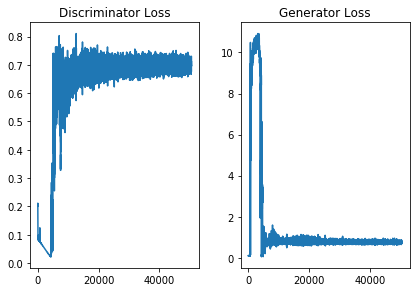

In [15]:
'''Plot discriminator and generator losses'''
figure,axis = plt.subplots(1,2)
plt.tight_layout()
axis[0].plot(discriminator_loss)
axis[0].set_title("Discriminator Loss")
axis[1].plot(generator_loss)
axis[1].set_title("Generator Loss")

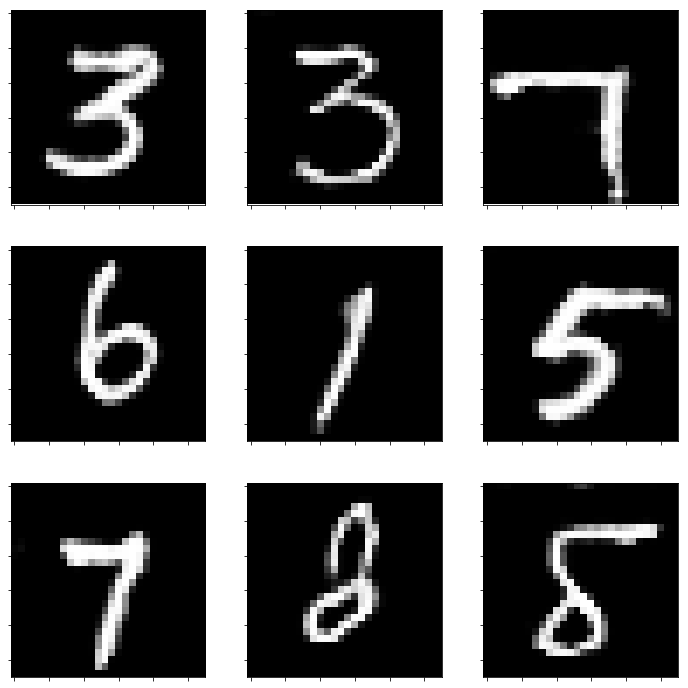

In [19]:
'''Generate images with our trained generator model'''
num_generated = 9
in_noise = np.random.rand(num_generated,100)
im = generator_model.predict(in_noise)
im = im[:,:,:,0]
figure,axis = plt.subplots(3,3,figsize=(10,10))
plt.tight_layout()
for i in range(3):
    for j in range(3):
        axis[i,j].imshow(im[i*3+j],cmap='gray')
        axis[i,j].set_yticklabels([])
        axis[i,j].set_xticklabels([])

In [20]:
'''Save weights and models'''
discriminator_model.save_weights('discriminator_model2_weights.h5')
generator_model.save_weights('generator_model2_weights.h5')
model.save_weights('gan_model2_weights.h5')

discriminator_model.save('discriminator_model2.h5')
generator_model.save('generator_model2.h5')
model.save('gan_model2.h5')